In [1]:
#this gonna get cray
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re

#from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

with open ("data/train_df_20180425-1926.pkl", "rb") as picklefile:
    train_df = pickle.load(picklefile)

plt.style.use("fivethirtyeight")
%matplotlib inline

### Make column masks to quickly grab `target` and `features` from a `DataFrame`

In [2]:
targets = ["dnf_rate", "sqrt_dnf_rate", "log_dnf_rate"]
features = (["gender:ladies","days_since_season_start","olympics"]+
            [dummy for dummy in train_df.columns if ("event:" in dummy or "region:" in dummy)]
           )
#features

### Playing with target transformations

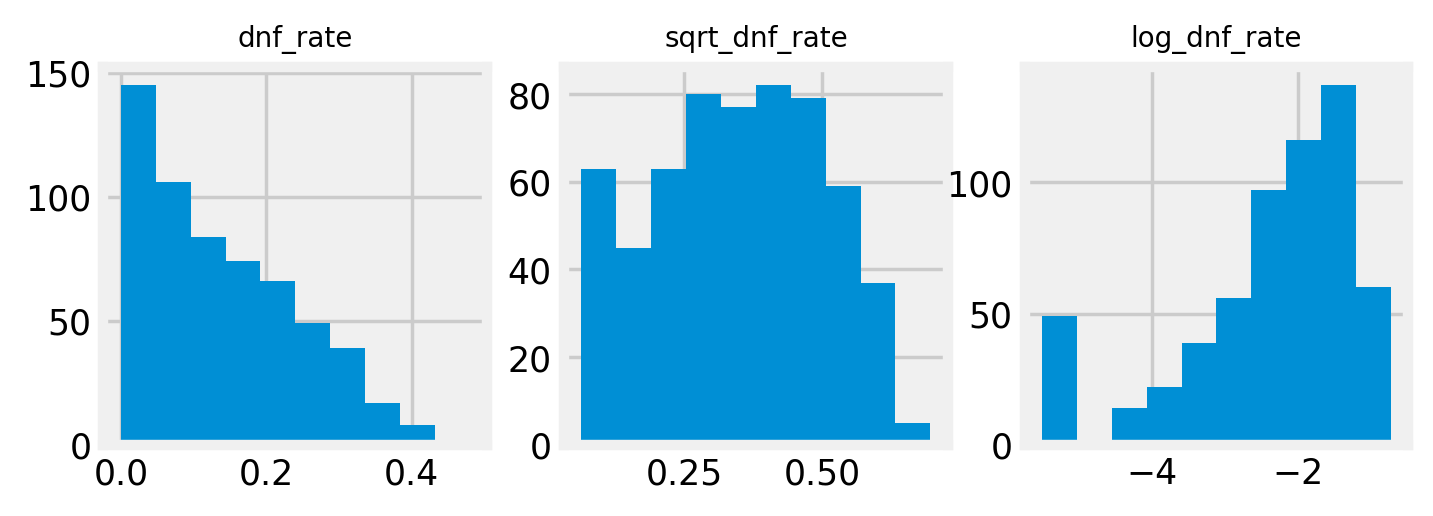

In [3]:
plt.figure(dpi=250,figsize=(6,2))
for i, t in enumerate(targets):
    plt.subplot(1,3,i+1)
    plt.hist(train_df[t])
    plt.title(t, size=8)

Despite the more normal appearance of the `sqrt_dnf_rate`, it performed consistently worse than the default 
`dnf_rate`. The log transformation also did not help.

In [4]:
target = "dnf_rate"

## Preprocessing data

```python
rand_state = np.random.randint(2048)
y_trains=[]
y_tests=[]
for i, t in enumerate(targets):
    X_train, X_test, y_train, y_test = \
        train_test_split(train_df[features], train_df[t], test_size=0.2, random_state=rand_state)
    y_trains.append(y_train)
    y_tests.append(y_test)
```
Turns out none of that matters, because `dnf_rate` is the most predictable.

## Polynomial features -> StandardScalar -> Lasso:
These are the coefficients of one run, sorted by absolute value:
```
 1. ('event:Slalom^1', 0.04139540044301016)
 2. ('event:Downhill^1', -0.03886310728099469)
 3. ('gender:ladies^1xevent:Slalom^1', -0.01231170117047865)
 4. ('days_since_season_start^2', -0.011981244297940648)
 5. ('event:Slalom^1xregion:SE_ALPS^1', 0.011671326921970085)
 6. ('event:Giant Slalom^1', 0.010595905490916678)
 7. ('event:Super G^1', -0.009924742966351584)
 8. ('event:Slalom^2', 0.0057614445534406)
 9. ('gender:ladies^1xdays_since_season_start^1', -0.005332106804633901)
10. ('region:CAN^1', -0.003909911911563925)
11. ('event:Giant Slalom^2', 0.0031164459254945077)
12. ('event:Giant Slalom^1xregion:ITA^1', 0.0026340308878495334)
13. ('event:Super G^1xregion:KOR^1', -0.00223899398694845)
14. ('days_since_season_start^1xregion:SE_ALPS^1', 0.0021775668778881135)
15. ('event:Downhill^1xregion:GER^1', 0.0018927794796225565)
16. ('event:Super G^1xregion:BUL^1', -0.0018438489763193144)
17. ('olympics^1xregion:NEUTRAL^1', 0.001725458665476746)
18. ('region:CAN^2', -0.0015826683386807128)
19. ('event:Super G^1xregion:ITA^1', -0.00144808294346535)
20. ('days_since_season_start^1xregion:FRA^1', -0.000760165266449663)
21. ('olympics^1xregion:KOR^1', -0.0007355745136791676)
22. ('event:Giant Slalom^1xregion:GER^1', -0.0006827442087098016)
23. ('gender:ladies^1xregion:CAN^1', -0.0006411909596604941)
24. ('gender:ladies^1xolympics^1', 0.00019852758608558332)
25. ('event:Giant Slalom^1xregion:SE_ALPS^1', 9.561096346954774e-05)
26. ('event:Super G^1xregion:CAN^1', -7.857644340798337e-05)
27. ('', 0.0)
28. ('gender:ladies^1', -0.0)
29. ('days_since_season_start^1', -0.0)
30. ('olympics^1', 0.0)
```
 - (16) Rare situations, like Super G in Bulgaria, are considered highly indicative. Significant overfitting.
     `model.score(*test_tuple)` returned 0.67, though, which was better than most straight linear tests.
 - `event:*` and `region:*` are boolean. Squaring them is meaningless.
 - (4) `days_since_season_start^2` being so highly rated is interesting, so that will be added to the dataframe.
 - `gender:ladies`, which normally lowers the rate, may be split into (4) `event:Slalom` and (9) `days_since_season_start`. Other interactions are weak and not repicable.
 - but so can `region:SE_ALPS`, the most strongly predictive region. (19) and (5)

```python
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)
```

In [5]:
def mult_columns(df, head_a, head_b=None):
    if head_b == None:
        head_b = head_a
    return [a*b for a,b in zip(df[head_a],df[head_b])]

In [6]:
def polymerize_df(df):
    df["days^2_since_season_start"] = mult_columns(df, "days_since_season_start")
    df["days^3_since_season_start"] = mult_columns(df, "days_since_season_start", "days^2_since_season_start")
    #df["gender:ladies*event:Slalom"] = mult_columns(df, "gender:ladies","event:Slalom")
    #df["gender:ladies*days_since"]   = mult_columns(df, "gender:ladies","days_since_season_start")
    #df["region:SE_ALPS*event:Slalom"] = mult_columns(df,"region:SE_ALPS","event:Slalom")
    #df["region:SE_ALPS*days_since"]   = mult_columns(df, "region:SE_ALPS","days_since_season_start")


In [7]:
polymerize_df(train_df)
features = features + ["days^2_since_season_start",
                       "days^3_since_season_start",
                       #"gender:ladies*event:Slalom",
                       #"gender:ladies*days_since",
                       #"region:SE_ALPS*event:Slalom",
                       #"region:SE_ALPS*days_since"
                      ]

In [8]:
X_train, X_test, y_train, y_test = \
     train_test_split(train_df[features], train_df[target], test_size=0.2) #random_state=42)

In [9]:
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

### Regularization

In [10]:
def run_model(model, Xtrain, Xtest, t):
    model.fit(Xtrain, y_trains[t])
    print("Score: ",model.score(Xtest, y_tests[t]))
    plot_residuals(model, Xtest, t)
    
def plot_residuals(model, xtest, t):
    y_hat = model.predict(xtest)
    error = (y_hat - y_tests[t])
    plt.plot(y_hat, error, "o")

**Mean Absolute Error** because I think there are going to be significant features I haven't been able to include, and I don't want to waste accuracy chasing outliers due to something obvious to peoples on the ground like bad weather.
**Lasso** because there are a large number of features that likely have no effect.

In [11]:
model=Lasso(max_iter=50000000)
parameters = {"alpha": [x*1e-4 for x in range(5,18)], "fit_intercept":[True, False]}
grid = GridSearchCV(model,parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=3, return_train_score=True)
grid.fit(X_train_scaled, y_train);

In [12]:
grid.best_params_

{'alpha': 0.0006000000000000001, 'fit_intercept': True}

In [13]:
lcv0 = LassoCV(max_iter=20000000,alphas=[0.0006],fit_intercept=True, cv=5)
lcv0.fit(X_train_scaled,y_train)
print(lcv0.score(X_train_scaled, y_train))
print(lcv0.score(X_test_scaled,y_test))

0.6465537710222704
0.671277504604928


In [14]:
grid.cv_results_

{'mean_fit_time': array([0.00199838, 0.00097208, 0.00118504, 0.00096965, 0.00109921,
        0.00096068, 0.00100875, 0.00097389, 0.00085354, 0.00096974,
        0.00077333, 0.00115919, 0.00078511, 0.00103345, 0.00076818,
        0.0011127 , 0.00070696, 0.00104213, 0.0007041 , 0.00095139,
        0.00061841, 0.00089602, 0.00072527, 0.0007966 , 0.00070553,
        0.00074806]),
 'mean_score_time': array([0.00042076, 0.00020647, 0.00019226, 0.0002142 , 0.00019822,
        0.00021014, 0.00019255, 0.00020041, 0.00018411, 0.00018802,
        0.00022635, 0.00020146, 0.00020761, 0.00020003, 0.0002049 ,
        0.0002152 , 0.00018387, 0.00018535, 0.00018234, 0.00019026,
        0.00017214, 0.00021191, 0.00023804, 0.00021019, 0.00019121,
        0.00021977]),
 'mean_test_score': array([-0.05115201, -0.14744401, -0.05114554, -0.14740573, -0.05116533,
        -0.14736733, -0.05120093, -0.14732395, -0.05123912, -0.14725999,
        -0.0512869 , -0.14720492, -0.05134644, -0.14715007, -0.05141257,
  

In [15]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test_scaled)
resid = [true-pred for true, pred in zip(y_test, lasso_pred)]

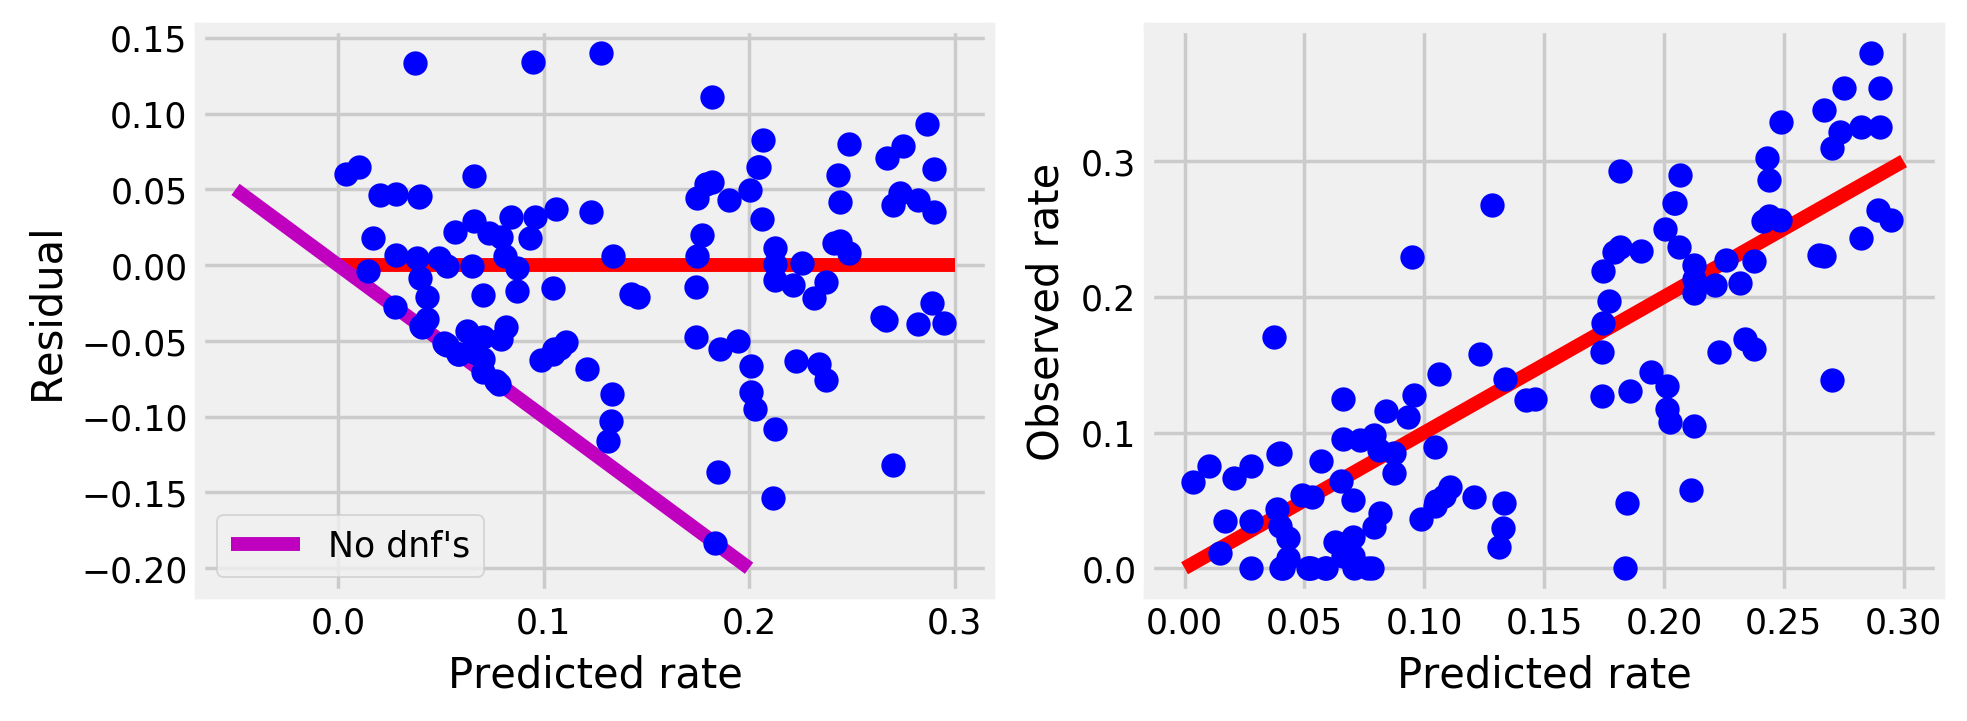

In [16]:
plt.figure(dpi=250,figsize=(8,3))

plt.subplot(1,2,1)
plt.plot([0,.3],[0,0],"r")
plt.plot([-0.05,0.2],[0.05,-.2],"m", label="No dnf's")
plt.plot(lasso_pred,resid,"ob")
plt.legend(loc="lower left")
plt.xlabel("Predicted rate")
plt.ylabel("Residual")

plt.subplot(1,2,2)
plt.plot([0,.3],[0,.3],"r")
plt.plot(lasso_pred,y_test, "ob")
plt.xlabel("Predicted rate")
plt.ylabel("Observed rate");

In [17]:
best_lasso.fit(X_train_scaled,y_train)
best_lasso.score(X_train_scaled,y_train)

0.6465537710222704

In [18]:
best_lasso.score(X_test_scaled,y_test)

0.671277504604928

In [19]:
from scipy.stats import normaltest

In [20]:
normaltest(resid)

NormaltestResult(statistic=0.2794212126499729, pvalue=0.8696098585807738)

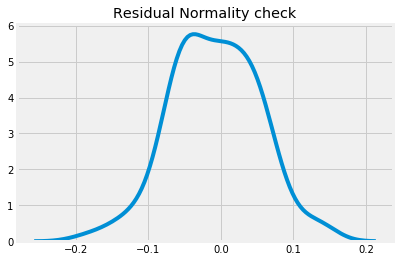

In [21]:
plt.title("Residual Normality check")
sns.kdeplot(resid);

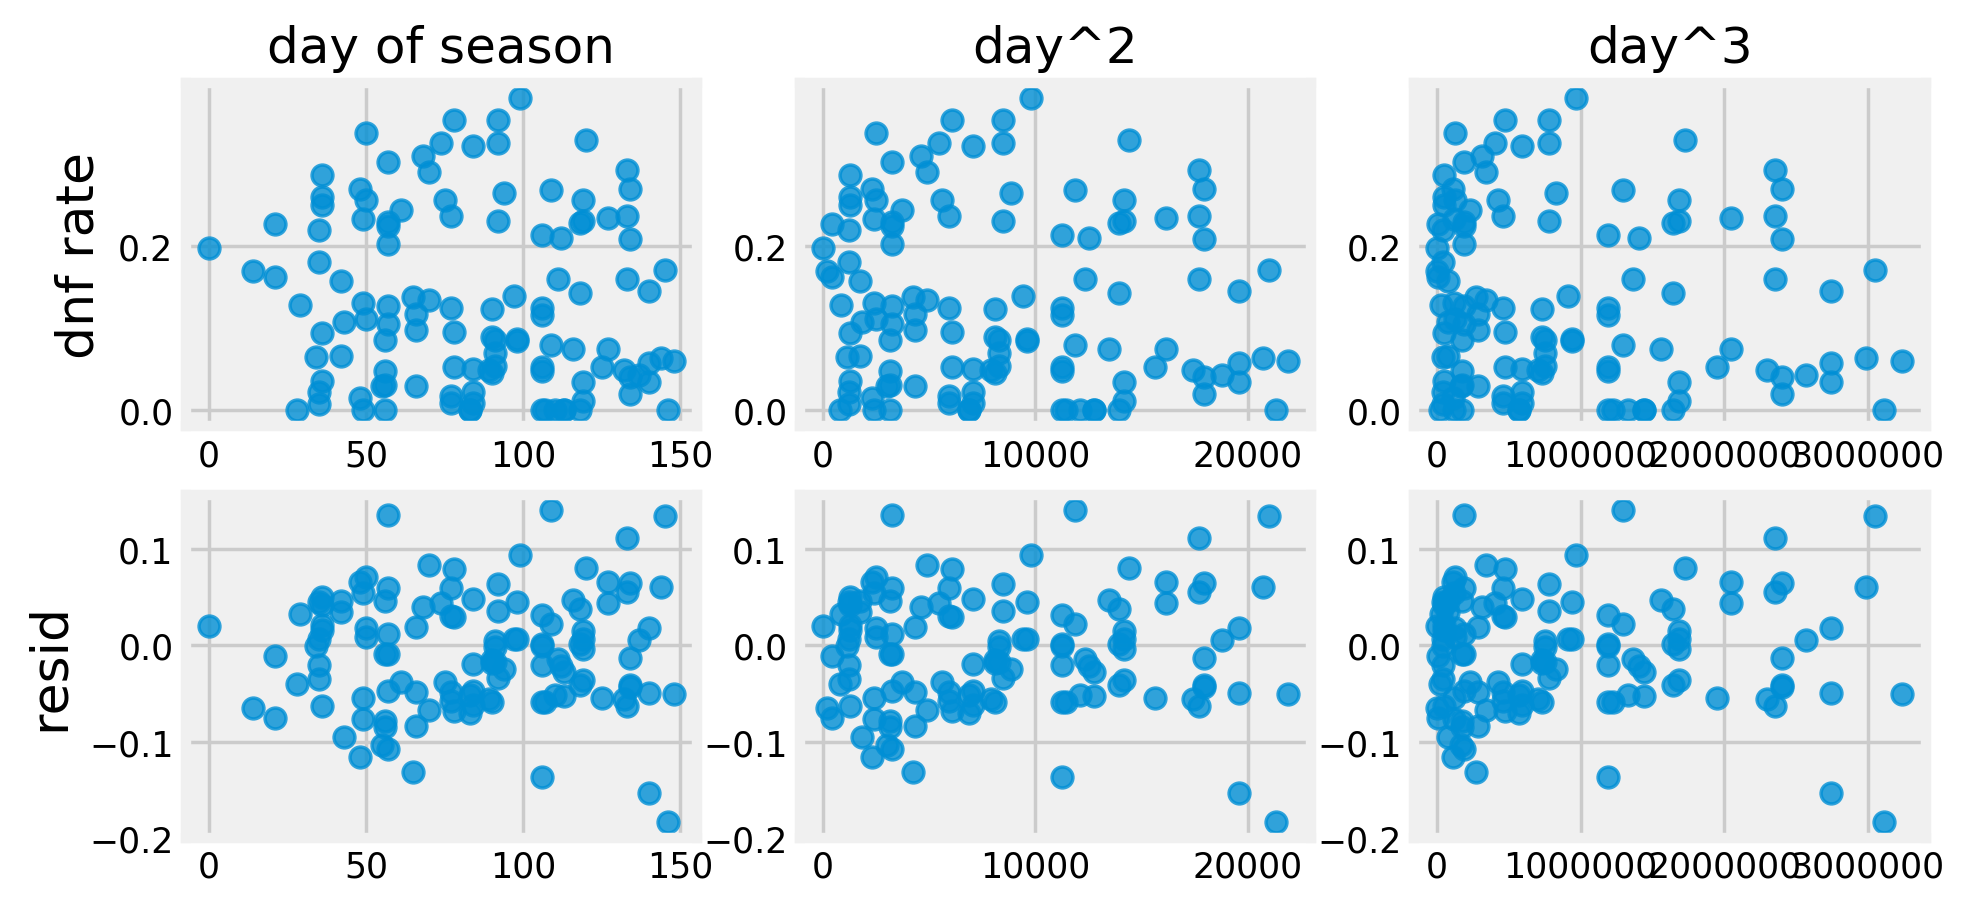

In [22]:
plt.figure(dpi=250, figsize=(8,4))
plt.tight_layout()

plt.subplot(2,3,1)
plt.ylabel("dnf rate",size=15)
plt.plot(X_test["days_since_season_start"],y_test,"o", alpha=0.8)
plt.title("day of season")

plt.subplot(2,3,2)
plt.plot(X_test["days^2_since_season_start"], y_test, "o", alpha=0.8)
plt.title("day^2")

plt.subplot(2,3,3)
plt.plot(X_test["days^3_since_season_start"], y_test, "o", alpha=0.8)
plt.title("day^3")


plt.subplot(2,3,4)
plt.ylabel("resid",size=15)
plt.plot(X_test["days_since_season_start"],resid,"o", alpha=0.8)

plt.subplot(2,3,5)
plt.plot(X_test["days^2_since_season_start"], resid, "o", alpha=0.8)

plt.subplot(2,3,6)
plt.plot(X_test["days^3_since_season_start"], resid, "o", alpha=0.8)

In [23]:
with open("data/final_model-TIME.pkl", "wb") as picklefile:
    pickle.dump(best_lasso, picklefile)

# Final modelling

In [24]:
with open("data/test_df_20180425-1926.pkl", "rb") as picklefile:
    test_df = pickle.load(picklefile)
with open("data/final_model-1121.pkl", "rb") as picklefile:
    best_lasso = pickle.load(picklefile)
polymerize_df(test_df)

In [25]:
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

In [26]:
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

Training MAE: 0.0494598337898756
Testing  MAE: 0.05413212186047713


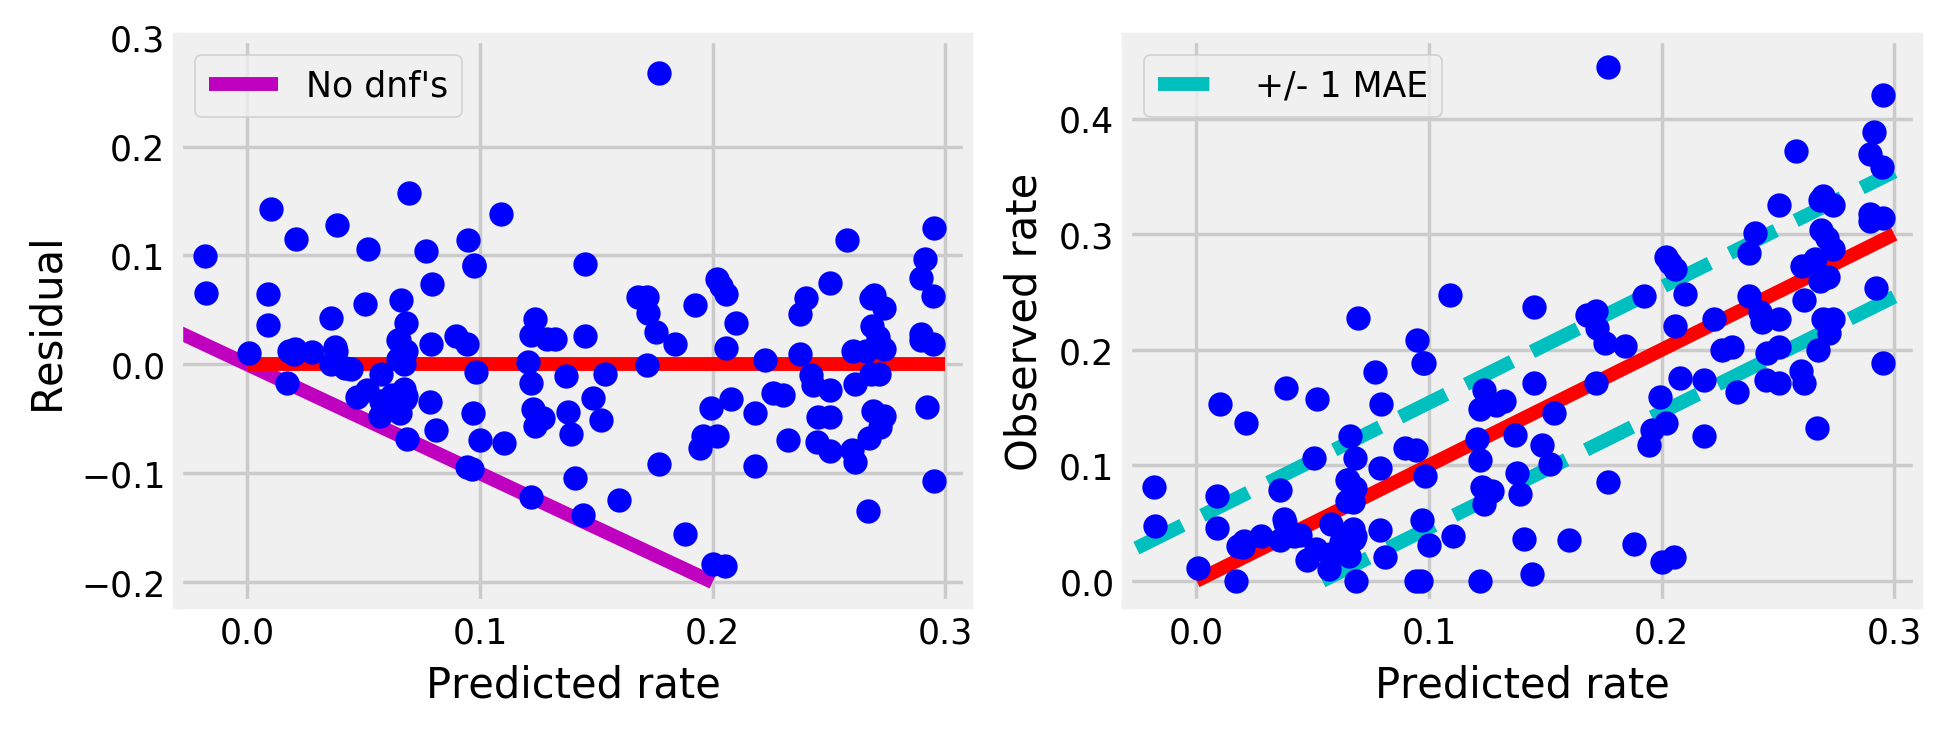

In [27]:
best_lasso.fit(X_train_scaled,y_train)
y_hat_train = best_lasso.predict(X_train_scaled)
y_hat_test = best_lasso.predict(X_test_scaled)
mae = metrics.mean_absolute_error(y_test,y_hat_test)
print("Training MAE:",metrics.mean_absolute_error(y_train, y_hat_train))
print("Testing  MAE:",mae)




# Plotting residual
lasso_pred = best_lasso.predict(X_test_scaled)
resid = [true-pred for true, pred in zip(y_test, lasso_pred)]

plt.figure(dpi=250,figsize=(8,3))

plt.subplot(1,2,1)
plt.plot([-0.03,0.2],[0.03,-.2],"m", label="No dnf's")
plt.plot([0,.3],[0,0],"r")
plt.ylim(-0.22,0.3)
plt.xlim(-0.03,0.31)
plt.xticks([0,0.1,0.2,0.3])
plt.plot(lasso_pred,resid,"ob")
plt.legend(loc="upper left")
plt.xlabel("Predicted rate")
plt.ylabel("Residual")

plt.subplot(1,2,2)
#plt.plot([-0.02,0.2],[0,0],"m", label="No dnf's")
plt.plot([0,.3],[0,0.3],"r")
plt.plot([0-mae,.3],[0,.3+mae],"c--", label="+/- 1 MAE")
plt.plot([0+mae,.3],[0,.3-mae],"c--")
plt.ylim(-0.02,0.47)
plt.xlim(-0.03,0.31)
plt.xticks([0,0.1,0.2,0.3])
plt.plot(lasso_pred,y_test, "ob", label="")

plt.legend(loc="upper left")
plt.xlabel("Predicted rate")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB5oAAALbCAYAAAArX4x0AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAmcgAAJnIBISuX7gAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzs3Xt4VNW9//HPym0yQGBUwAvBWwWRquRn2xxALd4o9UI5eAFtaEltQRBapZ5qPUDPsVDbHmsPVHOAWgUsCEaFUqx3BWpFjZZCq9RCVS6RKiIGCJlMJpn1+yPJuAO5zGT2XPN+Pc88z9p71uULZDPZ891rLWOtFQAAAAAAAAAAAAAAkcpKdgAAAAAAAAAAAAAAgPRCohkAAAAAAAAAAAAAEBUSzQAAAAAAAAAAAACAqJBoBgAAAAAAAAAAAABEhUQzAAAAAAAAAAAAACAqJJoBAAAAAAAAAAAAAFEh0QwAAAAAAAAAAAAAiAqJZgAAAAAAAAAAAABAVEg0AwAAAAAAAAAAAACiQqIZAAAAAAAAAAAAABAVEs0AAAAAAAAAAAAAgKiQaAYAAAAAAAAAAAAARIVEMwAAAAAAAAAAAAAgKiSaAQAAAAAAAAAAAABRIdEMAAAAAAAAAAAAAIgKiWYAAAAAAAAAAAAAQFRINAMAAAAAAAAAAAAAokKiGQAAAAAAAAAAAAAQFRLNAAAAAAAAAAAAAICokGgGAAAAAAAAAAAAAESFRDMAAAAAAAAAAAAAICokmgEAAAAAAAAAAAAAUSHRDAAAAAAAAAAAAACIColmAAAAAAAAAAAAAEBUSDQDAAAAAAAAAAAAAKKSk+wA4D5jzHBJEyVdKKmfJCOpUtKfJC2x1m50ebwsSedIOl9SkaSzJJ0i6ThJHkmHJO2RtEnSGklrrLVBN2MAAAAAAAAAAAAAkDjGWpvsGOASY0x3Sb+SdGMHVR+S9D1r7WGXxp0m6f4omrwnaZK19iU3xgcAAAAAAAAAAACQWMxozhDGmGxJqyR9xXHaL+ltSfWSBkvq2XT+Rkn9jDFXWmsb3Bj+iONaSe9K+qRp7D6SBknKbXr/dEnPGmOut9Y+4cL4AAAAAAAAAAAAABKIPZozxxy1TDI/IKnQWvsla+0wSSc11Wk2StKPXRo7KOklSbeocens7tbas621I6y1l1prz5XUW9Jtkmqa2uRIWmyM6edSDAAAAAAAAAAAAAAShKWzM4Ax5iQ1ziDObzr1W2vtN9uoO0fSrKbDWkmfs9buiX+U4fFHSnpWn82C/rG19r8SNT4AAAAAAAAAAACA2DGjOTPcos+SzDWSbm2n7hxJu5vK+U1tE8Za+7ykdY5TFyVyfAAAAAAAAAAAAACxY4/mzHC1o1xurd3fVkVrbZ0xZrGkHzWdGivpjngG14o/S7qkqXxCNA0PHDjQR9IVEVZ/T42ztgEAAADAKV/S6RHWfapXr14fxzMYdB3c0wIAAABwSUrc15JoTnPGmDMlneE49UwEzZ7WZ4nmAcaYgdbaba4H1zbnz93BKNteIWmJe6EAAAAAQLtKJS1NdhDIGNzTAgAAAEi0UsXpvpals9PfkCOOX42gzSZJde30EW9fdpQjiRcAAAAAAAAAAABACiHRnP7OcpTr9Nn+y22y1h5Z76y26rrNGDNN0heaDusklSVqbAAAAAAAAAAAAADuYOns9HeKo1xprbURttsl6XNN5VNdjcjBGJMt6RhJ50n6tqRxTW+FJE2x1v4jXmMDAAAAAAAAAAAAiA8Szemvp6N8IIp2zr2RC1yKRZJkjHlTn81abs0bkv7DWvtHN8cFAAAAAAAAAAAAkBgsnZ3+ujvKtVG087fRR7y9Jek+sTczAAAAAAAAAAAAkLZINKe/XEe5Pop2zrp5LsXSbKOkZ5teL0n6m2O8syU9LOktY0yRy+MCAAAAAAAAAAAASACWzk5/NY5yfhTtnHUPuxSLJMla+70jzxljuksqkfQTSb0lDZS0zhgzzFr7jpvjAwAAAAAAAAAAAIgvZjSnv2pH2RtFu25t9BEX1trD1tpfS/qipD1Np32SHoj32AAAAAAAAAAAAADcRaI5/e1zlE+Mot0JjvInLsXSIWvtTkn/4Th1gTHmnESNDwAAAAAAAAAAACB2LJ2d/v7hKB9njOlmra1ps/Zn+jvKiV66+neSgvpsf+lhatzHORLvxSWiDFJbW6u9e/eGj/v27av8/GhWVQcQT1yjQGrjGgVSVxKvT+5B4CZ+njrAZzGQ2rhGgdTGNQqkriRfn3G7DyHRnP7+fsRxkaSN7TUwxvST1KedPuLKWus3xuzTZzOwe0fRvDYOIWUUa60CgUCLYwCpg2sUSG1co0DqSuL1yT0I3MTPUwf4LAZSG9cokNq4RoHUleTrM273ISydnf4qJAUcxxdE0OZCR7m2qY9E6+koVyVhfAAAAAAAAAAAAACdRKI5zVlrqyW96DhVEkEzZ50XrbWH3Y2qfcaY8yR1d5x6N5HjAwAAAAAAAAAAAIgNiebMsMRRPtcYM7qtik1J3svbaBt3xhgj6ceOU4clbUhkDAAAAAAAAAAAAABiQ6I5MzwuaYvjeJExZtCRlYwxJ0paJim76dRmSU+01qEx5iJjjHW8Stuo93ljzAPGmAEdBWmM6SXpYUlXOk7Ps9ayRxUAAAAAAAAAAACQRnKSHQBiZ621xphJapwZ7JV0oqTXjTELJP1RUr2kYknTJR3f1MwvabKNfbfxXEnfkfQdY8xfJK1TY9L7I0nVkrpJOlnSMEnXSPI52lZIujvG8QEAAAAAAAAAAAAkGInmDGGtfcMYM0GNM5a9knpKuqPpdSS/pBJr7Rsuh/H/ml6ReFLSN6y1NS7HAAAAAAAAAAAAACDOWDo7g1hrV0n6gqQXJLU2U9k2vXeetXa1S8PukPQTSZskNXRQNyTpWUljrLWjrbVVLsUAAAAAAAAAAAAAIIGY0ZxhrLV/lzTSGNNf0vmS+jW99YGkV6y1uyPsZ70kE0G9KkmzJM0yxnSXNETS59S4RLdXUo2kKknbJf3FWnsoqj8QAAAAAAAAAAAAgJRDojlDNSWUVyZ4zMOSNja9AAAAAAAAAAAAAGQoEs3AEay1CgaDqqmpUSAQUCgUkrWtrUSemkKhUIvjTz75RFlZrJIPRMMYo6ysLHk8HnXr1k25ubkypsNFHgAAAICk454WQDx1dI1yPw0AQNdCohlwqK+v1759+xQMBsPnsrKy0uoX4qysLHm93hbHAKITCoVUX1+vuro6HTp0SLm5uerdu7dycvjYBAAAQOrinhZAvHV0jXI/jVTn90sVFdnavDlb27dnKxCQPB5pwIAGFRU1qLi4QY4fcQBAB/iEB5rU19dr7969amhokNfrVffu3ZWfn59WN+RS4y/0dXV14eO8vDxuzIFOsNaqtrZWhw8flt/v1969e9W3b19ujgEAAJCSuKcFkAiRXKPcTyMVVVYaLVjg0fLluaqqavtzxecLqaQkqKlTAyosTJ8VQQAgWfhNHVDjL8D79u1TQ0ODfD6fevfuLa/Xm3Y35ADcY4yR1+tV79695fP51NDQoH379qXVsoMAAADoGrinBZBKuJ9GKrFWWrw4T0OHFqiszNNuklmSqqqyVFbm0dChBVq8OE/82AJA+0g0A5KCwaCCwaC8Xq8KCgqSHQ6AFFNQUCCv1xv+vwIAAABIJdzTAkhV3E8jmYJBafJkr2bM8Kq6OrqHr6qrjWbM8Oqmm7ziRxcA2kaiGZBUU1MjSerevXuSIwGQqrp16yZJ8vv9SY4EAAAAaIl7WgCpjPtpJIO10s03e/XYY3kx9VNenqdp07zMbAaANpBoBiQFAgFJUn5+fpIjAZCqvF6vJKm2tjbJkQAAAAAtcU8LIJVxP41kWLIkL+Ykc7Py8jwtXZrrSl8AkGlykh0AkApCoZCysrLYvwpAm4wxysrKUigUSnYoQFL5/VJFRbY2b87W9u3ZCgQkj0caMKBBRUUNKi5uUNP3SAAAIEG4pwWQyrifRqJVVhrNnu3uw1ezZnl12WX1KixkajMAOJFoBiRZa7khB9AhY4wsayWhi6qsNFqwwKPly3NVVdX2ojg+X0glJUFNnRrgBhwAgAThnhZAquN+Gom0YIEn6j2ZO1JdbbRwoUdz5zIzHwCcWDobAAAAbbJWWrw4T0OHFqiszNNuklmSqqqyVFbm0dChBVq8OI99rAAAAAAACeP3S8uXx2eZ62XLcsVW4wDQEolmAAAAtCoYlCZP9mrGDG/UT4NXVxvNmOHVTTd5FQzGKUAAAAAAABwqKrI7fEC6s6qqslRRkR2XvgEgXZFoBgAAwFGslW6+2avHHsuLqZ/y8jxNm+ZlZjMAAAAAIO42b45vInjLFhLNAOBEohkAAABHWbIkL+Ykc7Py8jwtXRqfpcsAAAAAAGi2fXt8E8HbtpFoBgAnEs0AAABoobLSaPbsfFf7nDXLq8rK6JbfBgAAAAAgGoFAevcPAOmGRDMAAABaWLDAE/WezB2prjZauNDjap8AAAAAADh54nzbGe/+ASDdkGgGAABAmN8vLV8en2Wuly3Lld8fl64BAAAAANCAAQ1x7X/gwPj2DwDphkQzAHQRPp8v/Nq5c2fS4njhhRf0rW99S0OGDNFJJ52UMnEBaFRRka2qqvj8ilhVlaWKCvazAgAAAADER1FRfBPBQ4aQaAYAJxLNADLK1KlTWyQufT6fXn/99YjbX3nlleF2s2bNimOkXdP3v/99XXvttVq9erV27typmpqaVuvt3Lkz/O9w5ZVXJjhKoGvbvDm+ieAtW0g0AwAApLo1a9aE78lmzpyZ8PEDgYA2bdqk3/zmN5o2bZqGDx+u4447LmH3iUd+r+Dz+bRhw4ao+ti7d6969+59VD9bt26NOh7ndxU+n09z586Nuo/ly5e3+ueK9DV16tSoxwSSobi4QT5fKC59+3whFReTaAYAp5xkBwAA8TZ37lytXbs22WF0eWvWrNFDDz0UPvb5fDrrrLPUrVu38Dmv15uM0AA4bN8e30Twtm0kmgEAAFLds88+Gy6PGjUqoWNPmzZN5eXlCgaDCR23IytWrNCIESMirl9eXq76+vqYx925c6c2btzY4tyjjz6qmTNnyhgTc/9ApvF6pZKSoMrK3N9MecKEoPjqCgBaItEMIOO9/PLL2rBhQ1Q3hHDfsmXLwuVRo0bpt7/9rfLy8pIYEYDWBALp3T8AAABiEwqF9Pzzz0uSevXqpeHDhyd0/B07dqRcklmSnnzySR0+fFjdu3ePqP6KFStcGXflypWy1rY4t3v3br388sv68pe/3Ol+L7300qjqDx48uNNjAYk2dWpAS5fmqbravYcxCgqspkzhhhYAjkSiGUCXMGfOHBLNSbZ58+Zwefr06SSZgRTlcf+h74T2DwAAgNj8+c9/1scffyypMRmZk5Ocrw89Ho8GDx6s8847T0VFRVqzZo1eeOGFhMdx8skna9euXaqurtbatWt1/fXXd9jmb3/7m95+++0W7Ttr5cqV4fLIkSPDDwGsWLEipkTzE0880em2QKorLLSaM6dWM2a4N/14zhy/CgttxxUBoIthj2YAGev0008Pl9988009/fTTSYwGn376abhcWFiYxEgAtGfAgPjuNzVwIPtZAQAAxOqcc84J753rtmeeeSZc/upXv+p6/x2ZMWOG1q9fr8rKSq1bt0733nuvvvGNb6hPnz4Jj0WSxo0bFy47k77tcc5mHj9+fKfH3rhxo95//31JjQnre+65J7xc9tq1a3X48OFO9w1kutLSOo0bV+dKX+PG1WnixNRbaQEAUgGJZgAZ6+yzz9ZVV10VPv7JT35y1HJTSBzn3lRZWXz8AKmqqCi+ieAhQ0g0AwAApLLmh7Szs7M1cuTIhI9/2WWXqaioSLm5uQkfuzVf/OIXNWDAAEnSH//4R+3Zs6fd+g0NDXr88cclSV6vV2PGjOn02M6E9bhx43Tqqafq3/7t3yRJ1dXV+v3vf9/pvoFMZ4xUVuaPOdk8blydysr8Ykt0AGgdS2cDMdrSf0uyQ2iptTxqgn8RGrJ7SGIHbMfMmTP11FNPKRQK6a233tLvfvc7jR071tUx9uzZo0ceeUTPP/+8duzYoU8//VQ9e/ZUv379dMkll+j666/XmWee6eqYTu+//74efPBBPf/886qsrFROTo769eunkSNH6lvf+pZOPfXUiPuaOnVq+Eb2jjvu0J133ilJevHFF/Xwww9r8+bN+vDDD9W9e3edeeaZGj16tL797W/L08ZauG09XT9kyNE/I2vXrtWFF14YcazNQqGQ/vCHP2jNmjXavHmzPvroI9XU1Mjr9erYY4/V5z73OZ1//vm69NJLNWTIEJLcQAeKixvk84VUVeX+teLzhVRcTKIZAIBU0n9Lat3TxnJL+/PCQn39uOPcDKfL2b17t7Zu3SpJKi4u1jHHHJPkiFLD+PHjNXfuXIVCIZWXl+vWW29ts+4LL7ygvXv3SpKuvPJKFRQUdGpMv9+vNWvWhI+bZ1aPHz9er732mqTGRPQNN9zQqf6BriA3V1q0yK/hw+s1a5Y3qj2be/SwmjvXr4kTgySZAaAdJJqBGIUOhZIdAtpx1lln6ZprrtFjjz0mSbr77rv1ta99TdnZ2a70f//99+unP/3pUctV7du3T/v27dOWLVt03333adKkSZozZ47re1stXrxY//mf/ym/39/i/IEDB7R161b9+te/1rx58zq9VFd1dbVuueWWo/ZuCgQCevXVV/Xqq69q8eLF+t3vfqd+/fp1+s/RWbt379bEiRO1adOmo96rrq5WdXW1du3apXXr1mnu3Lm66667dMsttyQ8TiCdeL1SSUlQZWXub6Y8YUJQXve2yAIAAC44FMqce9p6VrCKWbKXzU5V48ePD6+StnLlynYTzc7ltSPZz7ktTz75pA4ePCip8WHtgQMHSpLGjh2rO+64Q3V1dXr55Ze1e/du9e/fv9PjAJnOGKm0NKjLLqvXwoUeLVuW2+6D1T5fSBMmBDVlSoA9mQEgAiSaAWS8O++8U6tXr1Z9fb22b9+ulStXqqSkJOZ+Z86cqbKyshbnTj/9dJ100knav3+//v73v8taq/r6ei1YsEA7d+7Uww8/7Fqy+aGHHtL3v//9FucKCwt1yimn6ODBg9q6dav8fr9uuummTu3b1dDQoG9+85t66aWXJEknnHCCTjvttPDs8Obk+vbt2zV+/HitX7/+qD/bpZdeGi6/+OKL4fLw4cPlPSLbFO2T8jU1NRozZozee++98Lnu3btrwIAB8vl8CgQC2rt3r95//32Fmr48C2XQl2hAPE2dGtDSpXlRPe3dkYICqylTAq71BwAAAPc9++yz4TKJ5s/0799fF1xwgV5++WW988472rx5s4qKio6qd+DAgfDS4yeccIIuvvhiVVZWdmrMRx55JFx27hPt8/k0cuRI/eEPf5C1Vo8++qj+4z/+o1NjAF1JYaHV3Lm1mjmzVhUV2dqyJVvbtmUrEJA8HmngwAYNGdKg4uIGHpAGgCiQaAaQ8U4//XR9/etf18MPPyxJ+vnPf65x48bFtN/TmjVrWiSZzzvvPM2fP1/nnHNO+NyuXbv0gx/8IHyj/tRTT+mXv/ylbr/99k6P22zbtm364Q9/GD7u37+/7rvvPl100UXhc3v37tXMmTP12GOP6eabb456jIceekj79+/XoEGDdM8997RY1trv9+uuu+7SwoULJUlvvfWWHnnkEX3zm99s0YdzJrQz2b1gwQKdcsopUcfk9OCDD4aTzD179tQ999yjq6+++qh/15qaGq1fv16PPvqoazPZgUxXWGg1Z06tZsxw7+56zhw/T4MDAACksMOHD+vll1+WJJ166qlx3QIqHV1//fXhv58VK1a0mmhevXq1amtrJUnXXXddp+9B9+zZow0bNkhq3Cv72muvbfH++PHj9Yc//CEcC4lmIHJerzRiRINGjGBbJwBwAxtVAugSbr/99vA+wrt27QonnTujrq6uRbJ4yJAhWrt2bYsksySdfPLJWrFihS6//PLwuXvuuUcffPBBp8duNnv2bNXV1UmSevfurSeffLJFklmS+vbtqwceeEDjx4/XJ598EvUY+/fv15lnnqlnnnnmqL2TvV6vfvazn7V4wr15b2c3nHLKKaqqqlJVVVX45vlIzz//fLg8d+5cjR8/vtWHB7p166YrrrhCS5cu1bRp01yLEch0paV1GjeuzpW+xo2r08SJQVf6AgAAQHy89NJLCgQaV6BhNvPRxowZo27duklqfKi6vr7+qDrO++JYls1+9NFHwytyffnLX9bxxx/f4v1Ro0aFH+Z+9913VVFR0emxAAAAYkGiGUCXUFhYqNLS0vDxL37xi6P2NY7U73//e3300UeSJGOM7rvvPnXv3r3VullZWZo/f74KCgokScFgUIsXL+7UuM0qKytbJFlnzZrV7uzgn//851EvS93sf//3f9tddts5U3rTpk2t3mjHy549e8LloUOHRtSGGc1A5IyRysr8MSebx42rU1mZX8a9VbgBAAAQByyb3b4ePXroqquukiTt27evxX25JL333nt6/fXXJUnnnHOOPv/5z3d6LGfC2rlsdjOPx6MxY8a0Wj9SPp8vqtfOnTs794cBAAAZjUQzgC7jtttuCz99/K9//Uu/+c1vOtWPc4bt+eefr3PPPbfd+n379m2xzNVTTz3VqXGbPf300+EnmwsKCjp8Strn8+m6666LepyBAwdq+PDh7dYpLi5WVlbjR0kgEEjojWfzDHVJevvttxM2LtCV5OZKixb5NW9ejXr0iG7Z6x49rObNq9GiRX7FsFMBAAAAEsBaq+eee05S49ZE559/fpIjSk033HBDuLxy5coW7zmTvc560XrzzTe1bds2SY0rdI0ePbrVeuPHjw+XV61aFV6yGwAAxJ/fL23YkK358/M0fbpXkyZ5NX26V/Pn52nDhmx1co5bWmKPZgBdRt++fTV58mTNmzdPkjRv3jx961vfUo8ePaLq58033wyXR44cGVGbUaNGhWcyv/POOzp06FB4lnO0Nm3aFC4PHz5c+fn5HbYZOXKkfv3rX0c1zpe+9KUO6+Tn5+vYY4/Vvn37JEkHDhyIaoxYFBUVhRPMt99+u7p166avfOUrMkybBFxljFRaGtRll9Vr4UKPli3LVVVV288q+nwhTZgQ1JQpAfZkBgAAiNK6det0//33d1jv448/DpevueaaDutPnz5dF198cZvvb9q0SXv37pUkXXzxxa1uSwRpxIgROumkk7Rnzx4988wzqqqqks/nk7VW5eXlkqScnJxOPezdzJmwvuKKK9r8zmLYsGE6+eSTtWvXLh04cEBPPfWUrr766ojHufTSS6OKy+v1RlUfAIBMVFlptGCBR8uXd/z9WElJUFOnZv73YySaAXQpt9xyix566CEdPHhQn3zyiRYsWKAf/OAHEbevr6/X7t27w8eDBw+OqJ2zXigU0s6dO3X22WdHHrjD+++/Hy6fddZZEbUZNGhQ1OMcuQdUW5w3mzU1NVGP01mTJk3SypUr1dDQoI8//ljjx49Xv379dNlll+n888/XsGHD1L9//4TFA2S6wkKruXNrNXNmrSoqsrVlS7a2bctWICB5PNLAgQ0aMqRBxcUN4jsoAACAztmzZ49efPHFqNpEUr+jBOTTTz8dLrNsdtuysrJ03XXXaf78+QoEAlq1apVuvPFGvfLKK+EVvi699FL16dOnU/0HAgE98cQT4eP2EtbGGF133XW69957JTUmqKNJNDvHAQAA7bNWWrIkT7Nn56u6uuOJTlVVWSor82jp0jzNmVOr0tLYtqZLZSSaAXQpxxxzjKZNm6af/vSnkqT77rtPkyZNancfYqcjZ+wee+yxEbU77rjjWhxXVVVF1K41zraRjh9pPafOPMFubeKezioqKtL999+vW2+9VYFAQJL0wQcfaOnSpVq6dKkk6fTTT9fo0aNVWlqq0047LWGxAZnM65VGjGjQiBENyQ4FAAAALnnmmWckNSZSv/KVr7Ra59FHHw3P2m3LRRddpO9+97uux5dKbrjhBs2fP19S4/LZN954Y4tltDva3qo9zbOkJal3794dzjoeP358ONH80ksv6cMPP9QJJ5zQ6fEBAMDRgkHp5pu9euyxvKjbVlcbzZjh1auvZusXv8jM9bRJNAPocm6++WYtWrRI+/fv18GDB/WrX/1KP/rRjyJq25zQbBZpMjYvr+WHUF1d559gcraNdHznfsaZ5IYbbtCwYcN03333afXq1dq/f3+L99977z3Nnz9fZWVlmjZtmmbPnq2cHD76AAAAAKSmkpISlZSUdFjvnHPOCa+2FcuDzFLjA7tvvfWWpMYtlI58ULrZe++91+Hs6b59+8YUSzoYNGiQioqKtHnzZlVUVOitt97SmjVrJEm9evXS5Zdf3um+H3nkkXC5qqpKp59+esRtGxoa9Nhjj2V8oh8AgESytvNJZqfy8jzV1/fSD39YqUzb+bHtBcQBIEMVFBTo1ltvDR8vWrSoxf5W7enZs2eL4+rq6ojaHVmvV69eEbVrjXNv586On0lOPfVU3XvvvfrnP/+p9evXa+7cubr88stb/D3V19dr/vz5mjlzZhIjBQAAAIDU0zybWZJGjRqVxEjSh3PW8uTJk3Xo0CFJ0tixY5Wfn9+pPvfu3dsikV9fX6+DBw92+HJy7u8MAABit2RJXsxJ5marVnm1enVvV/pKJSSaAXRJkyZNCi8ndfjw4fBSUx3p0aNHiz2Jm/dg6ohzX2Xp6KW0o+Hc62nXrl0RtdmxY0enx0sXWVlZKioq0vTp07VixQr985//1OLFi3XyySeH6zzwwAMR/5sBAAAAQFfw7LPPhsvt7c985513qqqqqt3XggULEhFy0l177bXhFca2bt0aPh/Lstnl5eWqr6+PKa6tW7dq8+bNMfUBAAAaVVYazZ7duQfI2jJ/fn99+GH0W1amMhLNQIyyCrJS69WjlVeCY0gHXq9Xt912W/h48eLF+uCDDyJqe+6554bLmzZtiqjNm2++GS77fD6dcsopEUba/vh//vOfI2oTaZyZxOPxaOzYsVq1alX4C4Dhwy0oAAAgAElEQVRQKKQNGzYkOTIAAAAgdRRkZaXUq0crr0jb5mTaOoQJUFNToz/+8Y+SpP79+2vw4MFJjig9tLZ/8mmnnaahQ4d2uk/nbOTbbrutw6S+83XxxRe32g8AAOi8BQs8qq529/fLmppsrVx5vKt9JhsbVQIxGrJ7SLJDaCEUCrXYwzcvL09ZWemR/E20iRMn6le/+pV2796tQCCge+65J6J2w4YN0+uvvy5J+v3vf6+77767w72Sy8vLw+WhQ4fKxPAFyLBhw8LlrVu36h//+IfOPPPMdts88cQTnR4v3Z1xxhk688wzw3uORbpMOgAAANAV7B7CPW1Xtm7dOtXW1kpqfzYzjnbDDTe0WHZ8/Pjxne7rr3/9q95+++3w8de+9rWo2v/7v/+71q1bJ0l6/PHHNXfu3A6/pwAAAG3z+6Xly+PzWbp2bW9NmRLZpLd0wG/qALqsvLw83X777eHjZcuWaffu3R22KykpCZc/+ugjLVy4sN36a9asaTGj+Rvf+EYnov3MxRdfrOOP/+ypp7lz57Zbf926dXrllVdiGjMVWWsjrnv48OFw+ZhjjolHOAAAAACQdiJdNhtHGzNmTItZxT/84Q873dcjjzwSLp966qkaEuUDIFdddZWys7MlSZ988omee+65TscCAACkiopsVVXFJ4V68GCO/va3HnHpOxlINAPo0r7+9a/rjDPOkCTV19dHtOfxgAEDNGbMmPDxj3/8Yz355JOt1n3jjTf03e9+N3x89tlnx3zznpOTo+nTp4eP165dq//5n/9pte7WrVs1adKkmMZLVRdccIHKy8vDT9+35cEHH2yxR/bw4cPjHRoAAAAApDxrbTgh2aNHD11wwQVJjqhrqq+v1+OPPx4+dn7fEKnjjjuuxb8fy2cDABCbzZuz49r/O+90i2v/icTS2QC6tOzsbN1555369re/HVW7X/ziF3r11Ve1d+9eBYNBTZgwQaNHj9aYMWN04okn6pNPPtHzzz+vFStWqL6+XpKUn5+vhQsXhp8yjsXUqVP1+OOPa8uWLZKku+++W+vXr9cNN9yg0047TQcPHtT69ev18MMPq7a2VmPHjtXq1atjHjeVvP3225o8ebJuu+02jRw5Ul/4whd0+umny+fzqa6uTu+//77Wrl2rF198Mdzmqquu0qBBg5IYNQAAAACkhr/85S/68MMPJUkXXXSRPB5PkiNq9Morr+jqq68+6nwwGAyXN27c2GKlr2bz58/X9ddfH9f43Pbcc89p37594ePOJJqb223YsEFS40z1/fv369hjj22z/jXXXBNV/927d9fDDz/cqdgAAEg327fHN9G8Y0e+pIa4jpEoJJoBdHlXX321fvnLX7bYD6kjffr00ZNPPqmxY8fqgw8a91NYu3at1q5d22r9goICPfLIIzr77LNdiTknJ0fl5eW64oor9O6770pqvNHeuHHjUXUHDx6sefPmZVyiudmhQ4e0atUqrVq1qt16X/ziF3X//fcnKCoAAAAASG3O/YVHjRqVxEhaCoVCCgQC7dax1rZap6Eh/b6wdc4+7t+/v84777xO9TN69Gj94Ac/UENDg4LBoB5//HFNnjy5zfrOh7Ij0bNnz07FBQBAOurgVxEX+s9SpiSaWTobQJdnjNHMmTOjbjdw4ED96U9/0k033aTu3bu3Wic3N1fXXHONXnnlFV144YWxhtrC8ccfr5deeknf/OY3lZube9T7Ho9HEyZM0HPPPadevXq5OnYquOeee3TJJZeoW7f2lxkpLCzUXXfdpaefflo+ny9B0QEAAABAamtONBtjUirR3JV8+umnLfbJ/trXvtbpvvr06dNiqyjnvs8AACA68V7oxeMJxXeABDLW2mTHAETswIEDX5JU4Xa/e/bskSSddNJJbnedcKFQSHV1deHjvLw8ZWXxTEm81dbWauPGjdqxY4c+/fRTFRQUqLCwUBdccEFCnvrdv3+/1q9fr8rKSuXk5Khfv3768pe/rGOOOSbuYydbfX293nrrLb377rv68MMPVVNTo/z8fPXu3Vtnn322Pv/5z7t2Dbjxf4Xf71dlZWX4uLCwUF6vN+bYALiDaxRIXUm8Pot79er1RiIGQubjnrZj3NMmxp49ezR48GBJ0he+8IWoZ7ei6+rsNZpJ/08BqYx7WsAd8+fn6b/+K37Xzve+t1t33pmbyOszbve1LJ0NAC7Iz8/XJZdckrTxjz322Fb3sOoKcnJyVFRUpKKiomSHAgAAAABpwTmL9qtf/WoSIwEAAEg9RUXxXdZ60KAaSZmxCimPhAIAAAAAAABdSKruzwwAAJAKiosb5PPFZ3nrnj3rdc451XHpOxmY0QwAAAAAAAB0IcOHD1dRUZHy8vJ07rnnJjscAACAlOL1SiUlQZWVub9Z8+jR+5SfnznbGpNoBgAAAAAAALqQW265JdkhAAAApLSpUwNaujRP1dXGtT67d2/Q9dd/5Fp/qYClswEAAAAAAAAAAACgSWGh1Zw5ta72+b3v7dYJJwRd7TPZSDQDAAAAAAAAAAAAgENpaZ3Gjatzpa+rr/Zr7Nh9rvSVSkg0AwAAAAAAAAAAAICDMVJZmT/mZPO4cXWaN++AjHurcKcMEs0AAAAAAAAAAAAAcITcXGnRIr/mzatRjx42qrY9eljNm1ejRYv8ys2NU4BJRqIZAAAAAAAAAAAAAFphjFRaGtRrrx3S9OkB+Xyhduv7fCFNnx7Qa68dUmlpMCNnMjfLSXYAAAAAAAAAzYwxwyVNlHShpH6SjKRKSX+StMRauzHB8fSS9HdJJzpOL7XWliYyDgAAAADJVVhoNXdurWbOrFVFRba2bMnWtm3ZCgQkj0caOLBBQ4Y0qLi4QV5vsqNNDBLNAAAAAAAg6Ywx3SX9StKNrbx9VtNrkjHmIUnfs9YeTlBo/6OWSWYAAAAAXZjXK40Y0aARIxqSHUrSkWgGAAAAAABJZYzJlrRK0lccp/2S3pZUL2mwpJ5N52+U1M8Yc6W1Nq7f7BhjLpQ0KZ5jAAAAAEC6Yo9mQJIxRtZGt4k7gK7HWiuTyRtqAAAAJM8ctUwyPyCp0Fr7JWvtMEknNdVpNkrSj+MZkDHG0xSHkfSxpL/Gc7xYcE8LINVxPw0AQGYi0QxIysrKUigU4sYcQJustQqFQsrK4qMTAADATcaYkyTNcJz6rbV2srV2f/MJa+1ha+2PJM111Pt+U9t4mSXpzKbybZI+jeNYMeGeFkAq434aAIDMxac7IMnj8UiSamtrkxwJgFTl9/slSfn5+UmOBAAAIOPcIqn5l6waSbe2U3eOpN1N5fymtq4zxpwt6Y6mw5estb+Nxzhu4Z4WQCrjfhoAgMxFohmQ1K1bN0nS4cOHkxwJgFRVU1MjSfJ6vUmOBAAAIONc7SiXO2cyH8laWydpsePUWLeDMcZkqXHJ7FxJAUlT3R7DbdzTAkhl3E8DAJC5SDQDknJzc5Wbmyu/369Dhw4lOxwAKebQoUPy+/3h/ysAAADgDmPMmZLOcJx6JoJmTzvKA4wxA92NStMkDW0q/9Rau83l/l3HPS2AVMX9NAAAmY1EMyDJGKPevXsrOztbVVVV2rdvn2pqatjfCujCrLWqqanRvn37VFVVpezsbPXu3VvGmGSHBgAAkEmGHHH8agRtNkmqa6ePTjPG9Jf0k6bDbZJ+5lbf8cQ9LYBUwv00AABdR06yAwBSRU5Ojvr27at9+/bJ7/eH94/JyspKu1+EQ6FQuJyVxfMkQLSstS2uo9zcXPXu3Vs5OXxsAgAAuOwsR7lOn+2/3CZrbZ0xZrekz7XSR6z+T1JBU3mqtTbgYt9xxT0tgERp7xrlfhoAgK6FT3jAIScnR8cff7yCwaD8fr9qa2sVCoXS6inwUCgU/kJBatz/hhtzIDpZWVnKyclRfn6+vF6vcnNz0+7LOQAAgDRxiqNcaSO/+dqlzxLNp7oRiDFmvKSrmg5/a619yY1+O6u2trZT96I9e/ZUfX29AoGAgsFgWt7TBgKf5fc9Hg/3tEAKieQazc7OVm5urjwej3JychQMBhUMBhMdKtAlOa/P1o4BJI/b16cxRvn5+TH14QYSzcARjDHKy8tTXl6eevXqlexwoub3+1VZWRk+Pu644+T1epMYEQAAAAC0qaejfCCKdgcd5YI2a0XIGHOMpPlNh/sl3RZrn7Hau3cvXw6LL8iBVMc1CqS2jz/+ONkhAGhDrNenx+PRySef7FI0nccjoQAAAAAAIFm6O8q1UbTzO8rd26wVuXslHd9Uvt1ay7eyAAAAANABZjQDAAAAAIBkyXWU66No56ybF0sAxpiLJX2r6fBPkh6KpT8AAAAA6au21uivf+2hd97prp07PQoEsuTxhHTKKQENGnRY555brfz89NmaJt5INAMAAAAAgGSpcZSj2WDMWfdwZwc3xuRL+nXTYVDSlCj2iY6rvn37ptXeym4JBAItlhHs06ePPB5PEiMC4MQ1CqQ2rlGg8z74IEsPPNBdjz7qVVVV2wtC+3whjR/v16RJh9WvXyji/t2+Po0xnW7rJhLNAAAAAAAgWaodZW8U7bq10Ue0/lvSGU3lX1hr346hL1fl50eTd89cHo9HXm80PxoAEolrFEhtXKNAx6yVlizJ0+zZ+aqu7jh5W1WVpUWLumv58m6aM6dWpaV16kzON1OuT/ZoBgAAAAAAybLPUT4xinYnOMqfdGZgY0x/Sbc1Hb4vaU5n+gEAAACQnoJBafJkr2bM8EaUZHaqrjaaMcOrm27yKhiMU4BpgEQzAAAAAABIln84yscZY7q1WbOl/o7yO50c+zh9ttLbaZJqjDG2rZekEY62E494/6JOxgAAAAAgCayVbr7Zq8cey4upn/LyPE2b5lUX3PVGEolmAAAAAACQPH8/4rioowbGmH6S+rTTBwAAAAC0a8mSvJiTzM3Ky/O0dGmuK32lG/ZoBgAAAAAAyVIhKSDJ03R8gaSNHbS50FGubeqjM+oV3bLbvfTZ9ygBtdwbugsvlgcAAACkl8pKo9mz813tc9Ysry67rF6FhV1rajMzmgEAAAAAQFJYa6slveg4VRJBM2edF621hzs59lvW2t6RviS94mi+8oj3X2lrHAAAAACpZcECT9R7Mnekutpo4UJPxxUzDIlmAAAAAACQTEsc5XONMaPbqmiMOU/S5W20BQAAAIB2+f3S8uXxWeZ62bJc+f1x6TplkWgGAAAAAADJ9LikLY7jRcaYQUdWMsacKGmZpOymU5slPdFah8aYi4wx1vEqdTlmAAAAAGmooiJbVVXxSY9WVWWpoiK744oZhEQzAAAAAABIGmutlTRJUvOz/ydKet0Y8zNjzBXGmK8YY2ZJ+ouks5rq+CVNbmoLAAAAABHZvDm+ieAtW7pWojkn2QEAAAAAAICuzVr7hjFmghpnLHsl9ZR0R9PrSH5JJdbaNxIYIgAAAIAMsH17fBPB27Z1rUQzM5oBAAAAAEDSWWtXSfqCpBcktTZT2Ta9d561dnUiYwMAAACQGQKB9O4/1TCjGQAAAAAApARr7d8ljTTG9Jd0vqR+TW99IOkVa+3uCPtZL8m4HNtFbvYHAAAAIPE8nvTuP9WQaAYAAAAAACmlKaG8MtlxAAAAAMgsAwY0xLX/gQPj23+qIdGcgYwxwyVNlHShGp/+NpIqJf1J0hJr7cY4jNlN0ghJl0j6f5IGSTpOjUubfSrpbUkbJC221u5xe3wAAAAAAAAAAACgPUVF8U0EDxlCohlpyhjTXdKvJN3YyttnNb0mGWMekvQ9a+1hF8Y8XtJ8SaMldWujmlfSSZJGSvovY8wvJP23tbYu1vEBAAAAAAAAAACASBQXN8jnC6mqKsv1vn2+kIqLu1ai2f2/RSSFMSZb0iq1TDL7Jb0p6TVJBx3nb5T0RFObWPWXNF4tk8xW0ruSXpH0R0n/cryXK+lOSb8zxuS5MD4AAAAAAAAAAADQIa9XKikJxqXvCROC8nrj0nXKItGcOeZI+orj+AFJhdbaL1lrh6lxRvEcx/ujJP3YxfGtpBcllUjqa609w1p7gbV2hLX2JEkXSdrqqH/5EfEAAAAAAAAAAAAAcTV1akA9elhX+ywosJoyJeBqn+mApbMzgDHmJEkzHKd+a62d7KzTtEz2j4wxRtKsptPfN8aUxbhnckjSE5J+ZK3d2lYla+2Gpr2jN0oa3HT6VmPML621H8UwPgAAAAAAAAAAABz8fqmiIlubN2dr+/ZsBQKSxyMNGNCgoqIGFRc3dLnZt80KC63mzKnVjBnu/QXMmeNXYaG7yet0QKI5M9wiKb+pXCPp1nbqzpE0UY1LXuc3tb2jswNbazdJujbCugeMMTMkPdt0Kk/SVZIe7Oz4AAAAAAAAAAAAaFRZabRggUfLl+e2uw+xzxdSSUlQU6cGumSCtLS0Tq++mq3y8th3eR03rk4TJ8ZnOe5Ux9LZmeFqR7ncWru/rYrW2jpJix2nxsYtqta9qMa9o5sNSvD4AAAAAAAAAAAAGcVaafHiPA0dWqCyMk+7SWZJqqrKUlmZR0OHFmjx4jzZLpZrNkYqK/Nr3Li6mPoZN65OZWV+GeNSYGmGRHOaM8acKekMx6lnImj2tKM8wBgz0N2o2matbZB0wHGqZ6LGBgAAAAAAAAAAyDTBoDR5slczZnhVXR1dxrO62mjGDK9uusmrYBeblJubK82b59fNN9cqLy+6THuPHlbz5tVo0SK/cnPjFGAaYOns9DfkiONXI2izSVKdGpeubu5jm5tBtcUY45XU13FqbyLGBQAAAAAAAAAAyDTWSjff7NVjj8W2BHTzEtKLFnWN2bmRLjF+JJ8vpAkTgpoypWsuOX4kEs3p7yxHuU7S7o4aWGvrjDG7JX2ulT7ibYxazqR/LYFjAwAAAAAAAAAAZIwlS/JiTjI3Ky/P0/Dh9SotzdypzdY2/p3Nnp0f1ezvvDyr73ynTrNm1apbtzgGmGZINKe/UxzlSmsjXkV/lz5LNJ/qakRtMMbkSPpPx6m9atyzOS5qa2sV+V9H5ggEAu0eA0gurlEgtXGNAqnLzevTGKP8/PxYQwIAAACApKqsNJo92917m1mzvLrssvqMnK0bDHZ+9nddndH//Z9H+/YZlZV17eWynUg0pz/nHscH2qx1tIOOcoFLsXTkh5LOcRzPtdbWxmuwvXv38uWwpI8//jjZIQBoB9cokNq4RoHUFcv16fF4dPLJJ7sYDQAAAAAk3oIFnqj3ZO5IdbXRwoUezZ0bt/RNUrDEeHxEvug4UlV3Rzmaq97fRh9xYYwZKem/Hac2Svq/eI8LAAAAAAAAAACQafx+afny+EyrXbYsV35/x/XSidtLjC9dypRmiURzJnD+JNdH0c5Z150rqw3GmEGSVkrKbjr1qaSvW2sb4jkuAAAAAAAAAABAJqqoyFZVVXzSfFVVWaqoyO64YpqI1xLjlZVMaWbp7PRX4yhHc5U46x52KZajGGP6S3pO0rFNp2okXWWt3RmvMZv17du3y+7R7FxGsE+fPvJ4PEmMCIAT1yiQ2rhGgdTl5vVpWN8MAAAAQJrbvDm+ieAtW7I1YkRmzBdkifH4IdGc/qodZW8U7bq10YdrjDHHS3pBUv+mUwFJ/26t3RiP8Y6Un+/u0ynpyuPxyOuN5kcDQCJxjQKpjWsUSF1cnwAAAAC6su3b45to3rYtM2Y0x3uJ8Zkza9WVb01ZOjv97XOUT4yi3QmO8icuxRJmjDlW0vOSBjadqpc03lr7vNtjAQAAAAAAAAAAdCWBQHr3nygsMR5fJJrT3z8c5eOMMd3arNlSf0f5HRfjkTGmp6RnJZ3TdCok6RvW2jVujgMAAAAAAAAAANAVxXunr0zZSSwRS4x3ZSSa09/fjzgu6qiBMaafpD7t9NFpxpjukp6S9MWmU1bSd6y1K90aAwAAAAAAAAAAoCsbMCC++ycPHJgZ+zOzxHh8kWhOfxVq3Pu42QURtLnQUa5t6iNmxph8Sb+XdL7j9DRr7WI3+gcAAAAAAAAAAIBUVBTfRPCQIZmRaGaJ8fgi0ZzmrLXVkl50nCqJoJmzzovW2sOxxmGMyZX0uKRLHKdvs9YuiLVvAAAAAAAAAAAAfKa4uEE+Xygufft8IRUXZ0aiOd5LgL/xRramT/dq/vw8bdiQLb8/vuOlmpxkBwBXLJF0RVP5XGPMaGvt2tYqGmPOk3T5EW1jYozJlvSIpCsdp2daa38Za98AAAAAAAAAAABoyeuVSkqCKitzP5M6YUJQXq/r3SZFvJcY37EjWzt2fLZ8ts8XUklJUFOnBlRYaOM6dipgRnNmeFzSFsfxImPMoCMrGWNOlLRMUvNP/GZJT7TWoTHmImOMdbxK26hnJD0o6VrH6R9ba++O/o8BAAAAAAAAAACASEydGlCPHu4mMwsKrKZMyZz1oOO9xPiRqqqyVFbm0dChBVq8OE82w3PNzGjOANZaa4yZJGmDJK+kEyW9boxZIOmPkuolFUuaLun4pmZ+SZOtjflH/DpJEx3HtZL+zRjzTITt/2qtvT3GGAAAAAAAAAAAALqUwkKrOXNqNWOGe9OP58zxZ9RM3OYlxquqEjv3trraaMYMr159NVtlZZm7njaJ5gxhrX3DGDNBjTOWvZJ6Srqj6XUkv6QSa+0bLgzd7YjjfEmjomif70IMAAAAAAAAAAAAXU5paZ1efTVb5eV5Mfc1blydJk4MuhBV6ojnEuORaP53mTcvM5PNLJ2dQay1qyR9QdILklp73MQ2vXeetXZ1ImMDAAAAAAAAAACAu4yRysr8GjeuLqZ+xo2rU1mZX8a4FFgKiccS49EoL8/TsmUZsun1EZjRnGGstX+XNNIY01/S+ZL6Nb31gaRXrLW7I+xnvaQO/zux1i6RtKQzsQIAAAAAAAAAACA2ubnSokV+DR9er1mzvKqujjxb3KOH1dy5fk2cGMzIJLMUnyXGo3XXXQU666xcnXBCZs0YZ0ZzhrLW7rbWrrTW3tv0WhlpkhkAAAAAAAAAAADpwxiptDSo1147pOnTA/L5Qu3W9/lCmj49oNdeO6TS0sxNMjcrLa2LedZ3LA4fztLKlccnbfx4YUYzAAAAAAAAAAAAkAEKC63mzq3VzJm1qqjI1pYt2dq2LVuBgOTxSAMHNmjIkAYVFzfIm5mrObeqeYlxSa7sZ90Za9f21pQpHyg/P3nLeLuNRDMAAAAAAAAAAACQQbxeacSIBo0Y0ZDsUFJGLEuMu+HgwRz97W899KUvHUrouPHE0tkAAAAAAAAAAAAAMl60S4y77Z13uiV0vHhjRjMAAAAAAAAAAACALqOtJcb/9Kds7diRHbdxd+zIj1vfyUCiGQAAAAAAAAAAAECXc+QS45MmeeOaaA4EMmux6cz60wAAAAAAAAAAAABAJ3g88e4/sUt1xxuJZgAAAAAAAAAAAABd3oABDXHt/9RTa+Paf6KRaAYAAAAAAAAAAADQ5RUVxTfRPGhQTVz7TzQSzQAAAAAAAAAAAAC6vOLiBvl8cVreuiAoDT4Qn76ThEQzAAAAAAAAAAAAgC7P65VKSoLx6fzyD7U0KxCfvpOERDMAAAAAAAAAAAAASJo6NaAePay7nXarl66p1OsNDfprQ3yX504kEs0AAAAAAAAAAAAAIOmkfiFdc+cn7nY65V2pb+Ns5gfq6tztO4lINAMAAAAAAAAAAADo0kLWavWnn+r8d97R0mFvSZd95E7Hl30kXfWv8OFrDQ3a5Pe703eS5SQ7AAD/n737j6+6rvs//njvbOfsjG1MFBk6ldIBasjSWkga5oV15Y+utFp6QTFNkSmpKxWvi9Gv0bdSS6xOsKyAhFJUytTSysrLEpupoKkImagjAREnG5ydnW3v7x9nxx3GtrOz8/mcX3veb7fdODv7nPfnfcbOr/fr/Xq9REREREREnGOMqQTOB04DjgfGAWN7f/wRa+0fB7jNRKCg99ugtfaNVMxVREREREQk3bqt5Vetrdy0YwebOzoiVxpg0ebI5T9MGPngs3dGxjEHXv2d3bv54LhxIx83QyjQLCIiIiIiIpIDjDHHAd8BzqFvGSN2OWOoJmNfAS7rvfyGMeZIa23uNA4TERERERHpp9ta1r/1Fjfv3MmL0QBzrHwL//sCnNQKy4+FYAJhVX8X1L0UyWQ2B//4j/v28VwwyIl+/8jvQAZQoFlEREREREQkyxljaoDbgGIiyxixQWXLgEsbB7gZuJRIi63xwHnAr5yfqYiIiIiISHp1W8s9b73FTTt2sDUUGvpgA5z3OnxgD9xTAb8th7aCwY8vCcPHdsAnW97pydzfe/PyWHzkkZxQWDjyO5EhFGgWERERERERyWLGmPOAtYCHvgCzAXYArwHvjzeGtfafxphHgVm9V12AAs0iIiIiIpJDuqzl7rfe4uYdO/hnvABzf4eHIhnKl7wMz5XClhJ4tQg688DbA0fvh8ltcOJe8PUMOMQpHg+XFRRwSn4+FWPGYEy8/cCZT4FmERERERERkSxljJkA/Jy+ILMB7gKWWmuf7T2mh6HLZkfdTSTQbIDZrkxYREREREQkxbqs5a49e7h5505eSjTA3J+vB05ujXwN04eKi7lm3DiO2rMnuXNnIAWaRUTEMcEgNDd72LjRw9atHkIh8PmgsrKbqqpuqqu7yfKWEyIiIiKZ5ivAmJjvr7fW3jzCsR6JuTzBGHOMtfaVkU9NREREREQkvf6+bx/zX3mFfyUbYB6BWcXFLJo4kZnFxQSDQVoUaBYRETlYS4th+XIfa9cW0NqaN+hxZWU9zJkTpq4uREXFcJJqRERERGQwxhgP8N/0ZSvflUSQGeAFoAOINgo7HlCgWUREREREstaRXi/bOztTes4Pl5SwqLycGcXFKT1vOgweDRAREYnDWli50suMGSUEAr4hg8wAra15BAI+ZswoYeVKL1axZhEREZFknAqUEil1DdCYzGDW2m5ge8xVRyjBI68AACAASURBVCcznoiIiIiISLpNLCjgc4cempJznVlSwkOVlfzyuONGRZAZlNEsIiIjFA7DFVf4uesub8K3bW831Nf72bDBQyAQpKDAhQmKiIiI5L7jYi7vtNY+58CYsY3GSh0YT0REREREclymt1S8ZsIEVr/5Jp0uZT7NLilh0cSJvH/MmPgH5xgFmkVEJGHWjjzIHGvdusjtm5qCGBPnYBERERHpb3zvvxZocWF8rRmIiIiIiMigsqWl4pFeL5879FB+vHu3o+N+pLSU68vLed8oDDBHqXS2iIgkbNUqb9JB5qh167ysXq2UZhEREZER6I657FRQOLam3B6HxhQRERERkRySjS0Vr5kwAa9D2U4fLS3l4cmTWXfssaM6yAwKNIuISIJaWgxLlhQ6OmZDg5+WFqU0i4iIiCRoV++/BpiY7GDGmDLgGCIZ0gBvJDumiIiIiIjklnAY5s/3U1/vp709sTXdaEvFyy/3Ew67NMFBVHi9fDbJXs3/WVrKn6ZM4c5jj+WUUR5gjlKgWUREErJ8uS/hNxDxtLcbVqzwOTqmiIiIyCjwcszlw40xxyY53seIBK2jb/aeSnI8ERERERHJIU62VLzySn/KM5uvmTCBghFkNZ89dix/njKFO449lvcWFbkws+ylQLOIiAxbMAhr17pT5nrNmgKCQVeGFhEREclVfwP20peB/PmRDmSMyQOui7lqm7X2lSTmJiIiIiIiOSbbWyoe5fUyd9y4YR9/ztixPDJlCj9/97upUoB5QAo0i4jIsDU3e+L22xip1tY8mps9rowtIiIikoustV3AA/RlIV9jjDlhhMN9A6iKDg38IvkZioiIiIhIrnjtNcMNN2R/S8X68vK4Wc3njR3L/02Zwtp3v5vpCjAPSYFmEREZto0b3Q0Eb9qkQLOIiIhIgr4GdBEJDhcCvzPGTB/ujY0xPmPM94Hr6cuM3gd81+mJioiIiIhIdgqH4YILxhAKudtScX9PD4+0tTl6jv6O9nqZM0hW88fLyvjL1Knc/u53c5ICzMOiQLOIiAzb1q3uBoK3bFGgWURERCQR1totwC1EMpotcATwhDGmyRhzmjGm/+qIBTDGTDPG/C/wL+AK+rKiLfA/1to9qboPIiIiIiKSuayF+fP9rq0Nr1lTwJv7evjBrl1UPfccn3rpJVo6O105V1T9hAnk9142wCfKyvjr1Kn87F3v4j1+v6vnzjX58Q8RERGJCIWye3wRERGRHHUDcBxwPpFAcT5wae9XNEs5GkRea4wZBxTEXE/vzwywylobSNG8RURERERkAMFgpI3hxo0etm71EAqBzweVld1UVXVTXd1NquKhq1Z5+eUvnenLPJDW1jxOXNBBx6x98J4e8FmW7dzJzUcd5do5j/H5mHvooezt7ua68nKOV3B5xBRoFhGRYfP54h+TyeOLiIiI5CJrrTXGXAjcDHyBA4PLpt/35f1vHnPcd4BFrk9YREREREQG1NJiWL7cx9q1BbS2Dl6UuKyshzlzwtTVhaiosIMe58R8lixxti/zQDrumwj3TYSSMPznDlZ/ejv1Ezo50utegPu7Rx1FXpxezRKfSmeLiMiwVVZ2uzr+5Mnuji8iIiKSq6y1YWvt1cDZwBP0ZSofcFi/L3qP2wicZ629zlrbk4r5ioiIiIhIH2th5UovM2aUEAj4hgwyQyQLOBDwMWNGCStXerEuxZqXL/fR3p7CYGxbAdx1FOF57+Py73e6dr8ABZkdokCziIgMW1WVu4Hg6dMVaBYRERFJhrX2QWvtDOBUoBH4M7AL6KIvu/kt4GkiGcxnWWtPttY+kJ4Zi4iIiIiMbuFwpAdyfb0/4aBue7uhvt7P5Zf7CYednVcwCGvXFsQ/0A3BfP7SeCSfvdTn+P0SZ6l0togMSyb1hJD0qa7upqysJ+6OupEoK+uhulqBZhEREREnWGv/Bvwt9jpjTBEQtNbNvAARERERERkua+GKK/zcdVdyJaLXrYvcvqkpiFOJus3NHlfWgRNx/z2FXOnJc/R+ibMUaBaRIWVaTwhJL78f5swJEwg430x57tywNiuIiIiIuMhauz/dcxARERERkT6rVnmTDjJHrVvnZebMLmprnUkB3rjR48g4yXL6fomzVDpbRAaUqT0hJP3q6kIUFzv7H1xSYlmwIOTomCIiIiIiIiIiIiKZqqXFsGRJoaNjNjT4aWlxJvV369bMCDSDs/dLnKVAs4gcJFN7QkhmqKiwNDZ2ODpmY2NQmfAiIiIiI2CM+WnM19Qkxzo+ZqyfODVHERERERE52PLlvoTX3+NpbzesWOFMNcpQBuUFOXm/xFkKNIvIAZzsCXHllX5lNueo2tpOamo6HRmrpqaTefO0K0FERERkhGqBeb1fRyQ51hEx49UmOZaIiIiIiAwiGIS1awtcGXvNmgKCweTH8WVYXNep+yXOUo9mETlAJveEkMxhDAQCkVf1detG/vdSU9NJIBDEqOrJiASD0NzsYeNGD1u3egiFIm8AKyu7qarqprq6W32vRURERgcDOLnF0+nxREREREQkRnOzJ267ypFqbc2judnDrFndSY1TWZnc7Z3m1P3qT2usyVGgWUTe4VZPiNmzu1QWOQcVFEBTU5CZM7toaEiszHpxsWXp0iDz5oUVZB6BlhbD8uU+1q4tGPINaVlZD3PmhKmrC+kxKCIiktv0Qi8iIiIikkU2bnS3//GmTckHZKuqMivQDM7cryitsTpDpbNF5B2Z3hNCMo8xUFsb5vHH21i4MERZWc+Qx5eV9bBwYYjHH2+jtlZB5kRZCytXepkxo4RAwBd312Nrax6BgI8ZM0pYudKrUvYiIiIST+xqV+atKomIiIiI5IitW90NNG/Zkvz41dXdcdd7U82J+6U1Vmcpo1lEAPd7Qixe3KHyEjmsosKydGkHixd30NzsYdMmD1u29JUZmTy5m+nTVWYkGeHwyPunt7cb6uv9bNjgIRAIUuDOQ11ERESy37iYy+1pm4WIiIiISI4LhTJ/fL8fLrgoxE+XZ86CbrL3S2uszlOgWUSA7OgJIZnP74dZs7r1f+0wa0f+BihWtJ92U5P6YouIiMiAZvb+a4Gd6ZyIiIiIiEgu87lcBDTZ8d8Ih/n+rl384sw2WHUKBDMjnJjM/XJyjbWrCz73uU42bVJf58z4yxCRtMuGnhAio9WqVd6k3wBFrVvnZebMLmprw46MJyIiItnPGDMG+CRwKX39np9J34xERERERHJbZaW7a+WTJ49s/DfCYb63axc/2b2b/T09cBiw4CW4ZYqzExyhkd4vcHaNdf16L+vXDz7WaOrrrECziADZ0RNCZDRqaTEsWVLo6JgNDX5mz+7K+Tc5IiIiucIY869hHrrGGNORyNBAEXBo7+VozRMLPJDAOCIiIiIikoCqKncDzdOnJzb+znCY7+3cyU937ybYvwnxea/Ds2XwhwkOznBkEr1fUW6ssQ4l2td59WovjY0d1NZ2puzcqaZAs4gA2dETQmQ0Wr7cR3u7s3Wu29sNK1b4WLo0kXVoERERSaNJRIK/g70piF5fnuR5oud4CViX5FgiIiIiIjKI6upuysp6XGlnWVbWQ3X18AKyO8Jhbt25k5W7d9PRP8AcZYBFmyOX0xhsTuR+9efGGutwxPZ1vvnmYMrPnwruNGQVkayT6T0hREajYBDWri1wZew1awoI5uZ7GxERkVxmB/iK9/PhfEUZ4EXgE9Za7UgTEREREXGJ3w9z5rjT2m7u3HDc/sA7wmFuaGmh6rnnWP7GG4MHmaPyLfzvC/DFF8Hf5dxkEzCc+zUQN9dYh2vdOi/XXDOWeL/mbKSMZhEBMrcnhMho1tzscWVXI0TKtzQ3q3e6iIhIlniVg4PKUcfE/GwXkEiAuAfYB+wBngN+B9xvrdUbBBERERERl9XVhVi92utopm1JiWXBgsHLi/67s5Nlu3axevduQolGPQ2RMtof2AP3VMBvy6EtNQHcePdrKG6usSZi/Xo/U6YcxgUX7E73VBylQLOIAJnXE0JEYONGd3ubb9qkQLOIiEg2sNZOGuxnxpiemG/nWGv/6P6MREREREQkWRUVlsbGDurrR5CmO4jGxiAVFQcHkLd3drJs505+9uabiQeY+zs8BHUvwSUvw3OlsKUEXi2Czjzw9sDR+2G3F+45KrnzxBjsfg2H22usibj11qOYOfNtysvdyWZPBwWaRQTInJ4QmS4YjOyA2rjRw9atHkKhSFnwyspuqqq6qa7uHlH5DpGBbN3q7pugLVsy502WiIiIJMUweMaziIiIiIhkqNraTjZs8LBunTfpsWpqOpk378AAZktMgLnT6brNvh44uTXy1Z+F/L1eun6ffE/nge5XItxeY03E/v0e7rhjAtdc05LuqThGgWYRAfp6QgQCzjdTHmnvhEzS0mJYvtzH2rUFQwbjy8p6mDMnTF1daMQ7rESiQiOrBpMx44uIiEhKrI65/O+0zUJERERERBJmDAQCQYCkgs01NZ0EAkFMTBXuv+/bx9lbtzofYI6jOC+P+ePHM/9n+Xz56k7H71eiMm0N9L77DmPBgu3pnoZj0l+UXEQyRl1diOJiZ190kumdkAmshZUrvcyYUUIg4Iub8d3amkcg4GPGjBJWrvSS4tdwyTE+5/d9pHR8ERERcZ+19uKYr83pno+IiIiIiCSmoACamoIsW7Y/4fX54mLLsmX7aWoKUtCvXXJVUREV3uQzpYerJC+PaydM4JkTT+TLRxxBuT/flfuVqExbA927N59nny1O9zQco4xmEXlHKntCZINwGK64ws9ddyX+Ytzebqiv97Nhg4dAIPkXQxmdKivdLTk/eXJulLQXEZHso3YkIiIiIiIifYyB2tows2d3sWKFjzVr4lfWnDs3zIIFg1fWzDeGL02YwJWvvurWtAEozcvj8sMP54rx4zkk/8Cwoxv3K1Fur7GOxObNRemegmMUaBaRA7jdEyJbWDvyIHOs6O+xqSm58h4yOlVVufsmaPr0zHuTJSIiuU3tSERERERERAZXUWFZurSDxYs7aG72sGmThy1b+jbnTp7czfTpw9+c+5lx47hpxw62dXY6PtdSj4cF48dzxfjxlOUPHW50+n4l4vjjM28NdNu2QiDz5jUSCjSLyAHc7AmRTVat8iYdZI5at87LzJld1NZmZ9Bd0qe6upuysp64JdtHoqysh+rq3HgzIyIimc/ayPurJUsKaW+P/wYx2o5k9WovjY0d1NY6vygiIiIiIiKSqfx+mDWrm1mzklu/yzeGL5WX8wUHs5rHejzUjR/PgvHj8YXzaf7r8KtVOXW/sl0olIcCzSKSs6I9IWbO7KKhwT+sxcCo4mLL0qVB5s0LZ22QuaXFsGRJoaNjNjT4mT27Sxk5khC/H+bMCRMION9IZO7csEqSiohISjjVjuTmm4MuzC53GWPeDbwXOAwoAxJ+Q2Gt/brT8xIRERERkdS6cNw4bt6xg1eSzGoe6/Fw5eGHc/n48bS9ns9NX8mOalUvvOBJy3mH4vP1pHsKjlGgWUQGlAm9E9Jl+XJfQsH14WhvN6xY4WPp0g5Hx5XcV1cXYvVqr6N/kyUllgULQo6NJyIiMhgn25F0dY3lhhtasnYzYyoYY44EFgK1wOEODKlAs4iIiIhIlivozWq+aoRZzWW9Aeb548dTmudJulpVqj/Tbd2aeYHmSZM6gIJ0T8MRCjSLyJDS2TshHYJBWLvWnSf4NWsKWLy4Iyd+T5I6FRWWxsYO6uud+8NpbAxm/YYQERHJDk62I1m/3s+UKYdxwQW7HRkv1xhj5gIBoBgYaukm+iZgsGNs78/0ZkFEREREZBDBIDQ3D79kdLpd1JvV/GoCWc2HeDwsPPxwLhs/nlKPh3AY5i9IvlpVIBCkIIUx1lAG5ttMnbofGJvuaThCgWYRGZbR0juhudnjSj9ciOzeam725PzvUJxXW9vJhg2epPqmR9XUdDJvnvqFi4iI+9xoR3LrrUcxc+bblJfrtSyWMWYe8FMGDhDHfm84OMAc7+ciIiIiItKrpcWwfHl2lIyOVWAMX5owgatfey3useNiAswlnkg2sJPVqiDSujNVmc0+57sSJqW0tItp09rJlUCzO9EUEZEstXGju2U0Nm3KvDIdkvmMgUAgSE1Ncn1Uamo6CQRS9yZORERGNzfakezf7+GOOyY4Oma2M8YcC6ygL8hsgEeBBcB/cmDg+Nre6/4b+AawgQODy88DHwc+DJyZgukPyBgz0xjTZIx53hjztjFmb+/lHxljZrpwvjxjzHRjzBW953jUGPOqMWafMabLGPOWMeY5Y8ztxphPGWNyo8adiIiIiAybtbBypZcZM0oIBHxxk5WiJaNnzChh5UovNv2xZi4aN46KIVKJD83P56tHHMEzJ57IF8vL3wkyg7PVqtat87J6dereUldWZlbi13nn7aawMAP+IByiQLOISAy3+zVs2aJAs4xMQUFkp9+yZfspLk7sjUhxsWXZsv00NaW2LI2IiIxebrYjue++w+jo0K6pGDcAsXv0v2ytnWWt/ZG19nf9jt1orf2dtfYOa+0Sa+0HgZOBx4kEm48HvgVstdY+kpLZxzDGjDHG/AT4KzC/dz6lQEnv5cuAvxpjfmKMGePgqeuAjURKj18GnAYcBRQBHqAMOAGYC9wFbDbGpC0QLyIiIiKpFQ7D/Pl+6uv9CW+mjZaMvvxyP+EhCjNtDgZp/Pe/sS5GpL15eXypvPyg6w/Lz+frRxzBphNO4JoJEyj2HLiG7Ua1qoYGPy0tqflcV1WVOYHmMWO6ufDCnemehqMUaBYRieF2v4ZM7Ach2cMYqK0N8/jjbSxcGKKsrGfI48vKeli4MMTjj7dRWxtWJrOIiKSMm+1I9u7N59lni10ZO9sYYzzAhUQymS3wkLV2aSJjWGs3Egms3k5fsPmBVGft9t6X9cAlMVcHgb8TCYTvjbn+EuCe3ts4cvp+33cAzwH/B/wReBaIXRZ8N/CQMeaTDp1fRERERDKUkyWjr7zSf1Bm8wvBIJe8/DKnbt7Md3bu5Pd79w48gEPmxGQ1j8/Pp7E3wHzVAAHmKDeqVbW3G1asSE1N6+rq7rjrqKly1VWv5VwrKPVoFhGJ4Xa/hkzrByHZqaLCsnRpB4sXd9Dc7GHTJg9btngIhSJ/Y5MndzN9ejfV1d34/emerYiIjEZutyPZvLnI1fGzyMlANLPXAjeNZBBrbY8x5mIiWbunACcRKbP9TScmOUyNwEdivr8NuMFauwci2c7AImBJ788/CnwdWOzAucNEAsr3Ao8Az1prD1iJMsaUApf2zrOIyHrKSmPM49ba7Q7MQUREREQykNMlo2fO7KK2NsxzwSA37djBva2txMaev71jB2eVlmJcyhjx5uXxlSOOYGdXF5ccdhhFeUNvEHazWtWaNQUsXtzh+vql3w9z5oQJBNK7OH/BBUHOP393WufgBgWaRSRjBIOR7JeNGz1s3doXNKus7KaqKjVBM7f7NUyenDllOiT7+f0wa1Y3s2bp70pERDKL2+1Itm0rBPT6B0yNuRwiEiQdyqArRL3B5gbgt0QyfK8yxnzLulm7r5cx5gigPuaq26218/vNbx/wZRNZcWvovfqLxpiAtfbfyZzfWtsENMU5Zi/wXWPMs8BDRH5HJURKfH8lmfOLiIiISGZyo2T0/ywu5IEpL/P7wjcG/PmT+/fzcFsbs0tLHT1vrE+PGzfsY92sVtXamscDD+TzqU91uTJ+rLq6EKtXex3PzB6umk+HuPk7b7Mzt6pmAwo0i0gGaGkxLF/uY+3agiFftMrKepgzJ0xdXYiKCnfWu9zu1zB9uhZEc0UmbIwQERF36bl+5NxvR5KHAs0ARFeILPBy/yzcmJ9FxVsl+wOREtWlwOHA+4Ankp3kMFxN39z2A9cMcWwjMI9ID+XC3tsucnV2May1vzfG/AmI9mg+I1XnFhEREZHUcqNkdHBfHr9fWQp1AweaAb79+uv8R0mJa1nNiXC7WtUVVxTR1tZBbW2nq23/KiosjY0d1Nen9kN8sb+LG4/5PrXHv83bBQtSeu5UUaBZRNLG2kjpkSVLCof1gt3amkcg4GP1ai+Nje68+ET7NbixS6usrIfqai2IZrtM2hghIiLu0HN98txvR5IZ/bUywJiYy28Pckw7kcxbC5QNNZi1ttsY8wowrfeq95CaQPMFMZfXRctlD8Ra22mMWQl8ufeq80lhoLnXk/QFmstTfG4RERERSQE3S0bz23K45GUY5HPNE/v386e2Ns50Mat5uNyuVtXZaaiv97Nhg4dAIEiBS79ygNraTjZs8LBuXfKl0L1eS2fn4MGJQ4rD1B7yS+pf+xJHbW6h5wfjMJ/7bNLnzUTu5LuLiMQRDsP8+X7q6/0J7wprb4+8+Fx+uZ9w2Nl5Rfs1uGHu3LCynrKYtbBypZcZM0oIBHxxNyNEN0bMmFHCypVe3C86KSIiydJzvXPcbkcyaVKHq+NnkbaYy4OF9/fGXD5qGGPG/nIPT3hGCTLGTAGOi7nqwWHc7LcxlyuNMZOdnVVcsZv29w56lIiIiIhkLTdLRtNWAM8NHUT+9o4dpKCLTVxuV6uKWrfOy5VX+l39XG0MBAJBamo6kxqnpqaTf/5zL/fe287Xvx5k7txOPv3pTubO7aTxks387qR6treX8t3XPsNRtACQt2cPRatWOXAvMo8CzSKSctbCFVf4ueuu5HYOufXiU1cXorjY2UFLSiwLFqToVVkcl6kbI0RExDl6rneW2+1Ipk7d7+r4WWRHzOWxgxzzr5jLpwxjzKNjLqdiZWt6v+83DOM2TwGxq0P9x3Dbh2IuD2e+IiIiIpJl3C4ZzZaSIX/8t337+HNb25DHpILb1apirVvnZfVqF1OagYICaGoKsmzZ/oRjAMXFlmXL9tPUFKS0FGbN6uaqqzr5wQ+C/LT2D6x89Swafno8Zz2zDD8Hb44e88MfkhcMOnVXMoZKZ4tIyq1a5U06yBy1bp2XmTO7qK11blXXjX4NjY1BldTMUk5ujABYtiz33kyIiGQ7p5/rm5qCrvaWygZutiMpLe1i2rR2Bo+rjirP9/5rgKONMQXW2v5vjDcBp/cec4YxpshaO2Ck3hhTDUygL8C824U593d8zOVO4LV4N+gtn/0acOwAY7jKGHMlfQH7TiDg1rk6OjoyIosl1UL90mb6fy8i6aXHqEhm02PUOZs3uxvw5NWiuIf8v3//mw/k56e1V/OkSXmAM2v5w7F4cSGnndbOkUe62y7pM58Jctpp7fz4x2O44w5/3LZZF14Y5NJL93HkkT10xMSQvY89xpjvfAffY4/FPWfenj2Mv/tudn42UkI72cenMYbCwsKkxnCCAs0iklItLYYlS5x98mto8DN7dpejgVwn+zXU1HQyb57Sm7KV0xsj3vc+Px/+sCPDiYiIQzJ9E1w2irYjCQSc3/5+3nm7KSwcfcG3QbxIpAdzMeABTgQ29jvmd8BCIsHjUuB/gCX9BzLG+IBbo9/2Hv+kK7M+0DExl1vs8COrr9IXaJ7k6IxiGGM8wCHAycDngZreH/UAC6y1L7p17l27dmlxGHjjjTfSPQURGYIeoyKZTY/Rkduz511A/GDwiHXG35T7RDDIL195her89IXyJk4sAaak7Hz79uVxyy09XHNNS0rO9/nPw5w5hmefLWbz5iK2bSskFMrD5+th0qQOpk7dz7Rp7RQWWqyFlhbAWkqefJIjbruNkqeeSuh85bffzhuf+hQ9fn/Sj0+fz8fRRx8d/0CXKdAsIim1fLkv4XKU8bS3G1as8LF0qXO9+qL9GoCkgs01NZ0EAspqylZubIz42tdKOP74AsrLR3cAQkQkU2TLJrhsVFcXYvVqr6Pv/caM6ebCC3c6Nl62s9Z2GWMeBT7We9VHOTjQ/CCwCxhPJID8v8aYQ4HlRALVXuA0oJFIpq7tPe5f1tpNrt+JSPA76u0EbhfbG3nouoMJMsb8naHLjD8BXGut/T8nzysiIiIimcPnczejFu/wxv9xZyfv93jSltV80kntlJZ2sXdv6sKJ9913GAsWbE/ZBuPCQsv739/G+98fp1S5tZQ88QRH/PjHlDz99IjOVfDWW4y/5x52zp07ottnIvVoFpGUCQZh7Vp3So6sWVOA0+0NnOrXUOBylRVxjxsbI/bty+OOOyY4OqaIiIycm5vgRrtoOxInXXXVa9qsdbD7Yy6f3/+H1touYDF9WcoGuJxIQDpIJLj7AAcGmS3wVTcnHWNMzOVE/mBi3/2PGfQo5/0D+D7qzSwiIiKS0445xuXKMkcP2M3mIE/39PBkd7e7cxlCYaHl3HNT0VGnz969+Tz7bHFKzzkkayn529+YctllTLnyyhEHmaPKb7+dvA5nPyunkzKaRSRlmps9rvTpA2htzaO52cOsWc6+6BoDtbVhZs/uYsUKH2vWFMTt1zB3bpgFC0KjPosp27m5MSLVu/JERGRgbm+CW7y4A7/fleGzhpPtSC64IMj556d2gSNLrAO+R6R0drUxptpa2xx7gLX2J8aYM4A59PVf7r/DIvaNSZO1dq1L8+0v9kHYlcDtYo91umncY/T1py4gkg1+PJE1lPcAPwMajDGfsdb2zyB3zOGHHz5qezTHlhEcP348Pp8274hkCj1GRTKbHqPOOf10L9//vosnmBwnezbG771ePnHEES5OZmhf/GIe997bw759qctdff31iVRUjE3Z+QZkLd5HHqH4u9/F+8QTjg1bsGcP49evp+fqq5N6fKazd3csBZpFJGU2bvS4Ov6mTc4HmqMqKixLl3aweHEHzc0eNm3ysGWLh1AIfD6YPLmb6dO7qa7udm1BORiMBOs3bvSwdWvfuSsru6mqcvfco5GbGyOiu/LilmMRERFXZeMmuGzjZDuSm29+m52qmn0Qa+2bxpjxRALNAPsGOfRzwD+B64GB3jUar6dUCgAAIABJREFUoA1otNbe7PhEBxebypFIHfvYYwe7zyNirb2q/3XGmDFEAvXfAA4DJgN/Msacaq3d7OT5owoLnS3rn618Ph9+fdARyVh6jIpkNj1GR+700yNJRa58ZiwJw4l74x72Lq+Xa8vLqRk3joI0BhWPOw6WLg1RX5+6v6WXXy7E70/TpktryX/4YXzf/jb5DgaYY0342c/Y84Uv5MTjU4FmEUmZrVvdDTRv2eLu+AB+P8ya1Z3SReOWFsPy5T7Wro2fTT1nTpi6OmVTO8HtjRGbNxcp0CwikmbZvAkum0Tbkcyc2UVDgz+hUuXFxZalS4PMmxcmhyqLOc5a2zqMYyzwNWPMcuC/gBnABCIB5h1Esnh/aa3d4+ZcB9AeczmRVZaiQcZwhbV2H/AjY8xDRH5XRwBlwG3A6W6fX0RERERS68muNsacHaT15+XOD/6xHTBED+hjfT6unTCBT48bR36GZK06Wa1qON56Kw3321ry//CHSID573939VTeN9+k6PbbsVdf7ep5UkGBZhFJmZDLbS3cHj/VrIVVq7wsWVI4rAXZ1tY8AgEfq1d7aWzsoLa2kwx5H5KQTMncdntjxLZtylAREUm3XNgEly3UjiRzWGt3EQmO3pbuufSKrYc+MYHbxa74venQXOKy1r5ijLkW+HnvVacZY6ZZa59N1RxERERExD2PtrXxrR07+Gt7O/yXD355GAQdDKUVdcEnWwb80XE+H9eVl/PJQw7JmABzlFPVqobroYfyWbnSm5o1bmvJ/93vIgHmp55y+WR9xgQCtM+fT7aXKVWgWURSxu12ILnUbiQchiuu8HPXXYm/aLe3G+rr/WzY4CEQCFLgTutJx2Va5rb7GyNS19NEREQGpk1wqZcJ7Ugk47wYc/lQY0yRtXb/oEf3OSrmsiulq4fwKyBMX3/pUwEFmkVERESylLWW/2tv59s7dvBYe0yxnMNDsOAluGWKcydb8FJk3BiVMQFmT4YFmGPFVqu6/no/nZ3uzbWrKwVr3NaS/+CD+G68kfynn3bhBEPrGT+evNdfp+fd7075uZ2kQLOIpExlpbulIydPzo3SlNaOPMgcK7qzrKkpmNGZzZmaue3+xojBy+OIiEhqaBNc+qSjHUkuMsacDtTHXPVda+1f0jWfEXqh3/dVREpTD8oYcyQwfogxXGWtDRpjdtOXgX1YKs8vIiIiIs6IBpi/9frrbNi3b+CDPrITHhkPT41L/oSzd8K5r7/z7ZTCQq6bMIHzMzzAHCtaraq42HLppWNcP58ra9zWkv/b31L47W/j2bTJoUGHb9+UKbx+2WUU//d/4y8qin+DDJeWQLMx5nfpOG8Ma639aJrnIDLqVFW5u5A4fXpuLFSuWuVNOsgctW6dl5kzu6itDTsyntMyOXPb7Y0Rkyap0aSISLppE5zkgGrgE4AlkmFbm9bZjEwzEAKiWzNOI06gmQN7Inf0jpFqpTGX4/bIFhEREZHMYa3lz21tfHvHDh4fLMC8ywd3V8CD5dDmwMLj7J2waDMYmFpYyPXl5fxXWVnWBJj7O+ecLsrKeoasTOkUx9a4rSX/gQcovPFGPM8848zkEhCeNo1t8+bx9oc+BMZQnKX/9/2lK6N5NpEPwulg0nhukVGturrbtRefsrIeqquzfzG3pcWwZImzvXsbGvzMnt2Vcf0NMz1z2+2NEVOnDqcipIiIuEmb4CQHRBuBG+BVa+3edE5mJKy17caYh4Gze6+aA9wY52ZzYi4/bK0dZHXQHcaYk4HY9I2XUnl+ERERERkZay1/7A0wNw8WYLbAfRNhxbHO9Gb2d0HdS3Du6xzv7wsw52V5kNHvhzlzwgQCqSnlldQad08P+fffHwkw/+Mfzk8ujq73vpfQokW0fehDvL19e8rP7zaVzs5BxpiZwDwiu7yPJLLo0AL8BVhlrY23O3yk5y0DTgHeB7y/999jYg75mrX2q26c203BIDQ3e9i40cPWrX394yoru6mqUv+4RLj54jN3bjgn/h+WL/cNq3x0ItrbDStW+Fi6NLMyaDM9c9vNjRGlpV1Mm9Ye/0AREXGVNsFJDojW3bPAW+mcSJJW0RdoPskYc5619r6BDuwN8n6s321TxhhjgK/HXLUPeCSVcxARERGRxFhrebitjW+9/jp/3z9E8keXgW9NhYcnJH/SkjB8bAd8soUTjjYsKp/EeTkQYI5VVxdi9Wqv4+vZAxnRGndPD/n33RcJMD/3nHuTG0TXyScTuuEGus46K1JzPBhM+RxSIZ2B5tx5NGUIY8wY4HvAJQP8+Pjer8uMMT8FrnJy17cxZgtwHDn0/9rSYli+3MfatQVDLj6WlfUwZ06YurpQxmWMZiI3XnxKSiwLFoQcGy9dgkFYu9bh+s+91qwpYPHijowJxmdD5rabGyPOO283hYV6vhARSTdtgpMc8FrM5fGDHpX57gY2AdN7v28yxmy11m6OPcgYMxFYQ18m90bgnoEGNMacAfwp5qqLrbWrBjjuROAa4EZr7dahJmmMGQv8ADgn5upl1trM2tEpIiIio15Hh+GZZ4q5994xbNvmG7XJU9Zafr93L9/esYMnhwowQ2TrplNB5pP3wDf+wYllXhZNPIJzx47NqQBzVEWFpbGxg/r61PwxDXuNu6eH/F//OhJgfv75lMwtVtf73kdo0SK6Zs/G0RKcGSpdgWZ3IimjmDHGA6wHPhJzdRB4DugCTqCvh9QlwJHGmHOstU6lWVQ6NE7aWRvJtFyypHBYwdDW1jwCAR+rV3tpbOygtrZzNDx3jJgbLz6NjcGcCPI3N3tc62nR2ppHc7OHWbMyI7MqWzK33dgYUVzcw4UX7nRsPBERSY42wUmWe4xIf+Ay4BhjzERr7etxbpNxrLXWGHMZkcxgPzAR+JsxZjnwf0Q+01YDC4Hoyl8QmG+tTfaDQAFwKXCpMeZpIsHpTcBOoB0oAo4GTgU+SeR3HdUM/L8kzy8iIiLimO3b87jllgruv/8w9u4dPPyT68lT1loe6g0wPx0vwBx130RngswAT43j4qdP5Dt1npwMMMeqre1kwwbPO+0N3RR3jbu7m4J778V30014XnjB9fn01/X+90cymM88c1QEmKPSEmh2MLgpfRo5MMh8G3CDtXYPvJPtvAhY0vvzjxIp97XY4Xm8DTwFPAH8HbiVyCJBVgiHR94ztr3dUF/vZ8MGD4FAkAJtpxiUky8+NTWdzJvnXLnkdNq40RP/oCRs2pQZgeZsytx2Y2PEl7/cRnl5bvzNiojkAm2Cc55az6SOtbbTGHMXcFnvVZcDX03fjEbOWvuEMWYukYxlP5GN0ot6v/oLAnOstU84PI339n4Nx/3AZ621w1y5FBEREXFPNHmqoaGEffviJ7LkevLUP0MhLvzXv4Z/g12+SE9mB931/8bxpY+35cxnw6E+533mM510dcH69e4Hmwdc4+7upuBXv8J34414XnzR9Tn01/WBD0QymD/84VEVYI5Sj+YcYIw5AqiPuep2a+382GN6y2R/ubefVEPv1V80xgSstf92YBpziASWt8buKDfG3OTA2Clh7ciDzLGiwdOmpuBofE4ZFmMgEIj0I0gm2FxT00kgkDu/561b3Q00b9ni7vjDlW2Z205vjJg7N8j27Q5MTEREHKNNcM5Q65m0+TpQQyQwe50x5iFr7YY0z2lErLXrjTGnEGkJ9R8c3JrJAg8DX+hfVjsJ24BvEOn7PJ2+stwD6QF+D/zQWvtrh84vIiIikhQlTx2ssrCQj5eV8evW1uHd4O4KCDobLnOj+mI6DPdz3tixPZxxRpi//CWfri73FuwPWOPu7qZg/fpIBvOWLa6dczBdp55Kx6JFdM+aNSoDzFHurPRLql0NRJud7ifSX2owjfT18SrsvW3SrLU/t9ZucaBsWdqsWuVNOsgctW6dl9Wrc+RV2SUFBZFg/LJl+ykuTuzPprjYsmzZfpqacufND0DI5Qqbbo8/XKnI3HZSdGNETU1nUuPk2sYIEZFcouf65FgLK1d6mTGjhEDAF3dDWTR7YsaMElau9JK9nyAyg7V2O/BpIlm+fuBBY8yl6Z3VyFlrX7DWngUcA1wEXNv7dRFwjLX2rOEEma21f7bWmpivVYMc12qtbbDWngKMBT4IfA64Dvhy77kvBWYBZdba/1SQWURERDKFk8lTV17pz6n35teXlw/vwFAePDjMYxO0Zk0BwaArQ7su0c95b7+dx5//XOD631AoBHR1UXDnnRTPmEHRZZelPMjcdeqptN97L/t+8xu6zzhjVAeZQRnNueKCmMvrouWyB9JbWm0lkQ/MAOczcCmyUaWlxbBkSWH8AxPQ0OBn9uwuZWkMwRiorQ0ze3YXK1b4WLMmfvbL3LlhFizIzewXny+7xx+ubMzcjm6MmDmzi4YGf0J9PIuLLUuXBpk3L4wx0NXl+PRERMQBTj7XjybKnkg/Y8zRwBZgLrCcSA/jJmPMYuBOIn2EXwb2Agml21trX3V2tgmd+zXgjhSfcx+RvtePpfK8IiIiIiPldPLUzJld1NbmRoWm9/j9nDd2LPe9/fbQB/6jFNrc+TDiRvXFVEjmc153t7sfiv3b/0XxB87F89JLrp5nIF0f/GAkg/n000d9cDmWAs1ZzhgzBTgu5qoHh3Gz39IXaK40xky21qa+rkAGWb7cl9Bi4nDkSmmMVKiosCxd2sHixR00N3vYtMnDli19fR4mT+5m+vTc7+dXWenuG47JkzPjDU22Zm5rY4SISO7Tc31i1HomY2wjUlI6yhIpOX0MkazckbJozUBEREQkYyl5Kr7ry8vjB5q3lLg6hwF7Cmcwpz7nueU9j/0ED6kNMnedfnokwHzaaSk9b7bQh8bsN73f98PpxfUU0AlEnymmE9kBPyoFg7B2rTs7ltasKWDx4o6cDo46ye+HWbO6s+qF10lVVe7e7+nTM+P3mu2Z29oYkbuCwUgP8Y0bPWzd2vd/WlnZTVWV/k9FRhM91w+PsicyjqEv4GxjrhMRERGRHKTkqfimFRVxztixPDBUsPm1Ilfn4Eb1RTc5+TnPDafwZMrO1fWhD0UCzB/8YMrOmY2yMtBsjCkATgAOA8qAhMMK1tqfOz2vNDk+5nInff2XB9VbPvs14NgBxsgZHR0dDKdl9KOPeuP2Fxip1tY8/vKXbk47Lbl+f4kI9Uvn7P+9ZK5p06CsrMiVv8eysh6mTWvPiJ4gkybl0bfPxXnvelcHwRTd0erqyFesYBD+/ncvgUABL73koaPDUFhoOfbYbk46KcxJJx34fKDHaPpt357HbbeN4c47/XEzFz/zmSCXXbaPI4/sSeEMJZX0Oir9DfRcHysTXlvTYfv2PBoanN35v3hxIaed1j7oc6yTj09jDIWFzmZ/ZAgFlkVERERGATeTp37ykwL+9387KHI3/poy15eXDx1o7nQnNhCVTcsKbmTJO+kQ9nDqsHItkxM+4wxCixbRfeqprp8rF2RNoNkYUwjMAS4GTiH5KEWuBJqPibncYocTWY14lb5A8yRHZ5Qhdu3aNazFp0cfLQfGuTaPRx/dx6RJO10bP5433ngjbeeWxJ19Nvz85+WOj3vOObt4880Wx8cdiYkTS4ApLo7/Oi0tba6NP5gdOwr4xS8mcN99h9HWNvjLa0lJKeed5+Wii3ZSXh7WYzSNrIVf/vIwbr31KPbvj7+7tLU1j6amMdx+eyFXX/0a55+/WyVeRwE9RkUGdsstFezb5+yCzL59edxySw/XXDO89yzJPD59Ph9HH330iG+fYVanewIiIiIiklrNzR7XkqeCwTwuuqiIu+/eT4E7seyUml5UxNljx/KbwYLNXneTCdyuvjgSg1X1e+kl43iWvJMu4af4cS/bPnzmmZEA8wc+4No5clFWBJqNMR8kEhiuiF41wqGivapyo8FARGnM5TjNBg6wN+ayu00IMtwrr7j7TL9tW+buAJLMc9FFO/nVr8YPK+g1XGPGdHPhhenb7NDfSSe1U1raxd69zr8ElZZ2MW1au+PjDiUarLzllqPo6Ij//9bWls/Pf17O+vXjqa9XsDJduroMX/3qJB566NCEb7t/v4dvfnMSTz9dwle+so38/Fx6WyEiEl9Hh+H++w9zZez77juMBQu2U1io59bhstZenO45iIiIiEhqbdzobjnmRx4p4Mor/TQ1BXNi3er68vLBA81H7Xf13JMnZ0Y7Q4hkLC9f7mPt2gLXNiq4pYS9XM2trowd/o//iASYhypnJoPK+L8kY8xZwJ+IBJn7P6XZmK/+7AA/z4GnxIOMibmcyFaO2CJ/YwY9ahQIhdwujZHxDzPJIOXlYa6+Om4F/IRcddVrlJdnTr/DwkLLuefudmXs887bndKF6a4uQ0PDu/jmNycNK8gcq6MjEqxcsuRddHXl4stT5rKWEQeZYz344KF87WuTGHYtERGRHPHMM8WubBgD2Ls3n2efLXZlbBERERGRXLF1q/t9f9et87J6dQ6kNANVRUX8Z2npwD+c7G5lxOnT0x9othZWrvQyY0YJgYAv64LMADdzLUfhbMXO8Fln0f7737P/nnsUZE5CRmc0G2MmAHcSmWd0GfcV4G7gZSAQc/13gX8RqYF8IvAhYGLMz58HbgVyrali7DN9VwK3iz02czu7J+Hwww8fVo/mceP8rs5j3Dg/FRUV8Q90SCgUOqCM4Pjx4/FlYn0OGdQXvgAvvhhk/frk/zYvuCDIF75QiDGp+xscji9+MY977+1xtORmcXEP9fV5HHlkau6rtVBXN5bf/S65/6eHHjoUv7+IH/7w7ZzYIZoNfvYzPw89NNaRsR588FDOPDOfz352lDZpzUF6HRWJ79573d2n+vrrE6moOPh52snHp9GLroiIiIhksVT1/W1o8DN7dhcVFe7ssu+ylrv27OHHu3ez/rjjGOtxL4B+w8SJPLh37wHXnV5czDUfP4zPL+1xJfhaVtZDdXV6A83hMFxxhZ+77sreMNAc1nAZtzk2XvijHyV0/fV0n3KKY2OOZhkdaAa+BJTRFyxeBSyw1nYCGGMCMcf+xlr7x+g3xpg84ALgJiJ9jI8HaoDzrbWpravqrti6DonUaI49dp9Dc8kohYXD+3VMneruItPxxxv8fneD2UPx+XxpPb+MTFNTJ/n5HtatG/kbgJqaTgKBTgoKMu///7jjYOnSEPX1zs1t6dIOjjsudcGgn/7Uy733OjP/X/3Kz6xZlosvzpzM81zV0mJobHS2Y8TXv17K2Wcb1z50SXrpdVTkYNu2uft6+/LLhfj98Z9T9fgUERERkdEqVfuh29sNN93k49Zbne2L22Utd+7Zw3d27uRfvVHzpjfe4PryckfPE6uqqIiPlpby0N69fKi4mEUTJ/LB4kg1pTlzwgQCzv9S584Nk86PLNbmRpB5JRc7Uq44/NGPRkpkn3yyA6NJVKbnx3+eviDzk9baS6JB5nistT3W2ruBaURKbxvgTCLZ0LkkNmieyFNW0SBjjDpVVe7uKMqE0hiSfQoKoKkpyLJl+ykuTix4VVxsWbZsP01NQQoyuLpNbW0nNTXDekqPq6amk3nzUhekbWkx/M//ONt//YYb/LS0KLvKbcuX+2hvd/b33N5uWLFCGa8iMnq4nT2RquwMEREREZFsVVmZujXn1au9NDV5HWkdFraWNW++yfuef54rX331nSAzwA937WJvt7v36ytHHMFvKyv5dWXlO0FmgLq6UMJrsPGUlFgWLEjvh5tVq7wZE2TOz0vs/7aYNpqYz+18loKEivkeLPyxj9H25z+z/847FWR2QcYGmo0x7wEOoa+v8jdGMk5v9vJ5wEu9Y51ljJnvyCQzQ2yj04kJ3C52a9CbDs0lK1VXd1NW5k5F9UwojSHZyxiorQ3z+ONtLFwYivt3WlbWw8KFIR5/vI3a2nDGl2E2BgKBYNLB5kjmdjCl9/fGG32EQs6eMBSK7BAV9wSDsHatO7sv1qwpIKjq2SIySridPaFq9SIiIiIiQ3M7eepAhkWL/Fx+uZ/wCPM8wtbys94A88JXX2Vb58Hrga3d3fwoplWOG07w+zk1JsAcVVFhaWx0Nmu7sTGY1up3LS2GJUucTZRJxid77uJL3Mwh7BnyuEPYw5e4mec5gfncllQmc/icc2h75BH2/+IX9FRVJTGSDCWTS2efFHO5G/htnOMHLd5vrd1vjFkM3EEk2Hw98KOkZ5gZXoy5fKgxpshau3/Qo/scFXN5s8Nzyip+f+6WxpDcUFFhWbq0g8WLO2hu9rBpk4ctWzyEQpGF2MmTu5k+vZvq6u6s+3uLZm7PnNlFQ4M/oUzT4mLL0qVB5s1LbVA9GIQ773RnJ+Add3j51rc6su7/MVs0N3tc6bcD0NqaR3Ozh1mztLlIRHKf29kTkyfruVREREREZCjR5Cm31jkGEm3x19Q0/ISPzp4eftFbIvvVAYLL/QV27eLy8eMpcbFX82BqazvZsCG5VoZRqa6+OBA3qvol4xSe5DpuppElbOBUnuQUNjOVDgoppIOpbOYUnuRUNuAnuaB/+Nxz6bj+enpOOin+wZK0TA40H9r7rwX+NYyS2fGW5X8NBHuPe5cx5j3W2n8kOcdM8EK/76uAx4a6gTHmSGD8EGOMOnV1IVav9jr6xJsJpTEkt/j9MGtWd84FsqKZ27Nnd7FihY81awqGfJNcVtbD3LlhFiwIpWVX4KOPehzPZo4KhQyPPurhIx/Jrf/jTLFxo7sfUjZtUqBZREYHtZ4REREREUkvN5OnhrJunZeZM7uorR06iNrZ08PPewPMrw0jwBz1Vnc3t73xBl90sVfzYKLVF4Gkgs3pqL7Yn5tV/UbqFJ4EwE8HZ/InzuRPjp8j/PGP03HddfRMm+b42DK4TA40l8RcfmuQY/YBY4gEo0uHGsxa22GMeRk4ofeqKiAXAs3NQAiIvqKcRpxAM3B6zOWO3jFGtWhpjPp659II010aQyTbZEvm9gMPuPsm7Te/KVCg2SVbt7obaN6yJfW7bUVE0sHN7Am1nhERERERGR43kqeGo6HBz+zZXQOufYd6eli7Zw/f3bGDlhHW2f7+rl1clqas5mysvjgQN6v6jcQh7OFUNrg2fucnPkHouuvoOfFE184hg8vkQPO+mMuDzXMvkUAzQMUwxmyPuZxIP+OMZa1tN8Y8DJzde9Uc4MY4N5sTc/lha+2+QY8cRXKtNIZItsr0zO1nnnE/K1bcEXK5yITb44uIZAq1nhERERERST83kqeGo73dsGKFj6VL+8obh3p6uP3NN7ll5062j7SRc6+3urv58RtvUJ+GrGbIvuqLA3G7ql+iLuGnSZfD7s8aQzgaYD7hhPg3ENdkcqA5tuv7YNnKr9EXMJ4+jDFjg8uZ9UhLzir6As0nGWPOs9beN9CBxpiTgY/1u62QW6UxRMQ9b73l7oPb7fFHM5/L1aTcHl9EJJOo9YyIiIiISPo5mTyViDVrCli8uAPj6wsw/zvJAHOsaFZzcRqymqOypfriQNyu6peIIvbhJcTn+fE7/Zin8CKn8CQzeSzhALQ1hvAFFxC69lp6jj/epVlLIjI50BztG2yAo40xedbann7HbAKqe485wxjjsdYOmAJnjJkKHEWkzDbAHhfmnC53E/ldRIPtTcaYrdbazbEHGWMmAmvoC7JvBO4ZaEBjzBlwQJH8i621qxycc0bKldIYIiJysMpKd7PkJ0/OzCx8ERE3qPWMiIiIiEj6RZOndu40PPJI6nrytrbm8eXft3P/u7fxuoMB5qg93d38ZPdurp4wwfGxE5Xp1RcHkklV9/Yzhm+yeMCfHcIeLmYl17CMo2gZchxrDOFPfSoSYJ4yxY2pyghlTpH2gz1PpPcwgBeYPMAxf465fDhw+RDjRctJR0OAzyQzuUxirbXAZUCw96qJwN+MMd8yxpxtjPmIMaYBeBqIbvEIAvN7b5s0Y0yDMaaj/xdwTMxhAx5jjDlmsHHTIVoa4/HH21i4MERZWf/9DQcqK+th4cIQjz/eRm2tgswiue6QQ9xdAB83TgvsbqmqcvcDwfTp2fOBQ+Lr6DA0N5cQCIxh4UI/l13mZ+FCP7fe6uWRRzwEg/HHEMl1s2eHHdtko9YzIiIiIiIjU1AAv/jFfoqKUrumdNtfO1wJMkd9b9cu9nVrrWUksqXq3luM47t8iRN4nibmM9BfsM3Lo7Omhva//Y3gbbcpyJyBMjaj2VobMsY8DszqvWo2sLnfYb8i0nd5DJEA8neMMYXAbdbaNgBjTCWRIPO5RLKZDbALaHb9TqSQtfYJY8xcIhnLfiLlxhf1fvUXBOZYa59wcAr5QLynLw8DlyzPyNBsNpfGEBH3nHRSN08/7d7L57RpegPtlurqbsrKeobsqzNSZWU9VFfr/y4XbN+exy23VHD//Yexd+/gj/Wysh7mzAlTV5c5PZhEUsVaWLXKy5IlhY6UzlbrGRERERGR5BQVwcUXdxIIpDDC+GqRq8O/2dXFT3bv5qoMyGrONm5X9XNaOyUsoIlHOZ2VXEwBXdi8PMKf/nQkg7myMt1TlCFkbKC512/oCzT/F/CD2B9aa4PGmG8C3yASRPYBNwHfNMbsJJIJPT7mJqb3uG8PUIY761lr1xtjTgG+B/wHBwdwLfAw8IX+ZbVlcNlYGkNE3HPOOWFWr3bvTfu55yqbyy1+P8yZE3blQ9fcuWFtOspy0cBZQ0MJ+/bF34zQ2ppHIOBj9WovjY0d1NZ2Kkgmo0I4DFdc4eeuu5LvAafWMyIiIiIizqmrC7FqVcGwPtM6otP987zS2en6OXKR21X93LKWuWAMP/nMA3Redy09xx6b7inJMGRy6WyAX9CXhXymMWagnPibgEfoCyIboACoIFJOO7pkEU01+a21dpmbk04na+0L1tqziJSsvgi4tvfrIuAYa+1ZwwkyW2v/bK01MV+r4hz/1X7HJ/K1Lfl7LiKSGqef3o0dLNRGAAAgAElEQVTP5072os9nOe207HwjmC3q6kIUFzv7/1dSYlmwIIOa30jCwmGYP99Pfb0/4Q/k7e2G+no/l1/ux8WKYSIZwVrngsyTJ3ezYYNaz4iIiIiIOKWiwvLlL7el7oRed3L5DHB+WRmPTZ3Kd446ypVz5LpoVb9stNbOYcWMHyvInEUyOqPZWttijHkfkcxkgD0DHNNljDkb+BEwJ/ZHvf8a+oLQPwKucm/GmcNa+xpwR7rnISKSa/x+uPDCTleymi+8sFNZsS6rqLA0NnZQX+/cL7qxMajSyVnMqcDZunWR2zc1qfxvpggGobnZw8aNHrZu7Wt/UlnZTVWV2p+MxKpVXkeCzABbtnh4+OF8amu1Q0NERERExCmf/WyQP/2piwcfPNT9kx2939HhDHBBWRnXlZczVR/WkuJmVb/j2MI2JtGFM58NB9LQ4Gf27C6tt2WJjA40A1hrnx7GMUHgs8aYW4DPADOACUSem3YAjwG3W2ufd3OuIiLinkwKGFx3XYg77vASCjkXTfL5LNddp6zYVKit7WTDBs87gcFk1NR0Mm+egiTZzMnA2bp1XmbO7FLgLM1aWgzLl/tYu7ZgyJ7s6rOdmJYWw5IlhY6OqcUDERERERFnGQNf+co2APeDzZOdyZ42wKcOOYRry8uZUujsZ47RrK4uxOrVXtrbnVu/zCfMP5ns2HiDaW83rFjhY+nSDtfPJcnL+EBzIqy1TwFPpXseIiLinEwMGFRUWL75zQ6++EXnItvf+payYlPFGAgEggBJBZtrajoJBJS9ms0UOMst0T7bS5YUDuuDtPpsJ2b5cp+jCxSgxQMRERERkf/P3rnHR1Gd//99ErKbhQ2EgCQIKl5A8AYVpUitWEtrbVV60WhLLNFWBElV6gVrQFug/WmLLbSmQLFCNFSLWsvXtra1ltLaglSreAO5CGqQBLknsMlusuf3x2bJEnPZzc6Zmd193q8Xryyb2TNnN7Mzc57P8zwfE/TooZkzZztnnVXP/Pkn0uouaiF5ITjzUFJDZNEqMA8TgdlyTHT1ayLHsrG6oqoqh/LyBulElgK43aNZEARByFC0hmXLPIwdm0dFhbdTkRlaBYOxY/NYtsyDNqzxXH99kKuuCloy1lVXBaUC0mZyciItjhcsOJKwZ7Pfr1mw4AhLlgTIse/+WjCASeFMsJdYn+1E/6bis901gQCsWGHmhFdVlUMgYGRoQRAEQRAEQchYlIJrrvmISZMM3WxfVgPe7nkAZwHX9O3L+hEj+NWQISIyG6S0NEhxsTXxS7s5cCCL9euznZ6GEAdpVdEsCIIgpAehUPc9U6OCwdq12VRUmBMClYJFiyLVrMm03f3qVwMsWiRVdE6gFJSWhpgwoYnFi71UVXVdNV9SEmLqVGmzmw6YFs4k69Y+xGfbPOvXZ3eZ8NVdosGD8eObjYyfyiilHnF4Clpr/S2H5yAIgiAIgiAkwYwZ9axalXhCbqf0bIKvVSf8smyguKCAOwoLOVXEZVs42tWvsZGVq/K6PU4PQrZWM0fZsEHWiqmACM2CIAiCq0glwSAnB371qwCf+lQT99zj48iR+Hfk8zVz220f8J3v5JKTI2qUkwwerJk3r4Hy8gbWr89mw4ZsNm9u9QEfNqyZkSPt9QEXzGNaOHvppWwuvlgWQ3YgPtvmee01s1nkEjzokFLAqcwm1bJvEZoFQRAEQRBSmEGDwpa3T2bqNhjQGPfm2cA1BQXcUVTEKV7pAGYnas8e/A89xOPPL+WzfIPbeZB64hec/dQxlrX8jc8bnGXHbN7sbEVzIBCJH732WjZbtrTGCocObWbUKIkVRhGhWRAEQXAVqSYYJFoV26dPmMsv382119ZSVBRCqcHG5iYkhs8H48c3i9iRIZgWzu69N5cXXjgs7dUNIz7b9rBli9nvi9PBgzSjvay3zg7mRLcXBEEQBEEQUoiDzc3UXPoeOZ8rIPT8gOQHnFALl++Ka9Ns4OsFBdxeVMTJIjDbivroI7y/+AWeX/8adfgwAFNYymU8x0Ju5RFuYD8FHb6+L/u4gUe4iSV8kpfsmvbHaIw/n8FSqqsVixZ5WbGi6+6HkyaFmDYts7sfitAsCIIguIZUFgzirYo9++x69u5NvL2QIAjWYlo4e/31Hkyf7pM2zIYx6bM9b16DpeOmMqYX904FD1KE7hzgsTc9Ko4xEt1eEARBEARBcDmHtObxYJCV27ZxKByGu2ojbQT/Vtj9QSfUwsxNXd4t9gC+0a8f3y0sZIgIzLaidu/G+/Of43nkEdSRIx/7/QlUM587mcts1nIBrzCaTQyngVxyaWA4mxjNK1zAWnw08AKXdCpIm8buw0frSBHU7Nm5ccUaDhzIoqLCS2Wlh7lzGygtzUx7RFcLzUqpzYaG1lrr0w2NLQiCIHSTdBAMuqqKDQRsmYYgCF1gh7AlbZjNIj7b9mF6cS+xpw45OcHtRwC/BE4iEv4LAn8C/gG8AewFDgO9gH7AOcB44IuAh4jgvB24GdiU9OwFQRAEQRAE26lvbmZxYyNPhEIcjv1FDw33bIRzDsCiUyGQgDTka4Jp2yKVzJ2E7XoAk1oE5pPkJt9WVG1tq8AcR/DRRwOXsJpLWN3pdq8w2qopdothw+zrOhgKdd/Osb5eMWOGj7Vrs6moCGRcdztXC83AaUQWu1bnAGRuDbsgCIJLEcFAEAQ7sWvNK22YzWHaZ3v9evENjjJ0qNnPwc7gQSqhtX4v3m2VUuOBJ4A8Iuvnh4F7tNZ7OnnZamChUuo44EdE/JiHtIxzpdb6X92cuiAIgiAIguAQSimeaisyH/0lcMUu+OQ+eHowPFcEdZ3E4vJCcFkNfK26U0/mHKUoKShgRlERJ3qsscMT4kPV1OBduBDPsmWoBuuLbN7B2XrNkSPtWStq3X2ROZaVKyOvz7Tudm4XmqNYEZlTmBGthQxATN8FwTwiGAiCYCemhbMo0obZHKZ9tjdskOtGlFGjzH4OdgUP0hWl1EnAKqA3kTXvFK31w/G+Xmv9EXCjUuolYAnQB/g/pdRIrfX7JuYsCIIgCIIgmKFXVhaTPB5+GQx2vNGAxkiF8g3b4a3esDkP3u8JwSzwhOHEIzCsDs48BN5wh8PkKMU3+/XjtsJCThCB2VbUrl14FyzAU1lpRGCO0oC1FoeJkJ8fZswYe9aKy5d7khaZo2Ridzu3C80fkrjI3JPIwjiqVkRffxCot2heQoaQ6abvIrALdiKCgSAIdmJaOItFuiqYwbTP9ubNZsdPJcaMaSY/P2wkIczO4EEa82NaReYliYjMsWitH1ZKjQZuahnvx8C1ls1SEARBEARBsIXinBxWBIMc7GpDbxjOPRD51xmNWfBmiyD9QU+yQlmclufh8rNyGH8e9O8v9/N2oT78sFVgtsETLBfnkuZLSkK2xFGqqxWzZ1srqGdadztXC81a68HdeZ1Sqgcwmsii+FuAHwgBN2itn7duhkK6kumm75kusAvOIIKBIAh2YlI4a4t0VTCD6TW1HT7esbg5wc/ng0mTQlRUWN9z3q7gQbqilCoAvhrz1ANJDnk/EaFZAV9VShVorfclOaYgCIIgtIub738EIZXppVTXVc3xsNsLTw2GPx/bYjsMbAZ++gz8FIkR24HauTMiMD/6qC0Cc5TTece2fcWSl6eZOtWe97lokTcuDSgRMq27nauF5u6itW4CXgJeUkr9AvgdcA7wB6VUsdZ6laMTFFxNJpu+Z7rALjhLugkGgiC4G5PCWXs8/LCHiy7KLI8e05j22bbLxztVEvymTWukstJj6QLc49Hs3Km48UafBJW7z6eBbCLVzDsS8XVuD631e0qp7cDJLeN+mkhbbkEQBEGwjFS5/xEEOzCVcHF1Tg5VwSCHujMpDTw7EBafCoGuJaR0jxE7mRSjqqvx/uxneB57DJVs4kCC6F69OPvSIRF1zWbmzg3Yct4PBGDFCjMiTiZ1t0tLoTkWrfW7SqlLgZeBQcAKpdQorfVWh6cmuJBMNn3PZIFdcAfpIhgIgpuIZzEEmVtFYEI464hnn/Vw003IddJCTPtsDxtmdvxUS/AbPFgzd24DM2ZYd0IIBhXPPPPxe08JKifEKTGP91g05h4iQnPb8QVBEAQhKVLt/kcQTGI64cKvFN/weFicqDjZpOD+4fBCYWKvI/1ixE4mxagPPmgVmEP2ev1qv5/GKVMITp/OJ3r2I//v9nSDi1JcHGTyZHve8/r12cbeWyZ1t0t7oRlAa12rlPo+sBTwEfGa+mqnLxIykkw1fc9kgV1wD6kuGAiCm4h3MeT1RhZAjY0dn7TTWfAxIZx1hlwnjyXZrHDTPtsjR5obP1UT/EpLg6xdm330WDaFBJUTImompoD+Fo3ZL+axpOoJgiAIlpCq9z+CYDV2Jlxck5PD401NHAyH45wc3RaZY0n1ta+TSTHq/ffx/vSneFassF9gzss7KjDrggIgIqbZ2Q2uuDhIRYV9x81rr5m1WtywITOEZvvSEJznt0R8mhVwpVJqgMPzEVyGKdP36mr3X02tFtgrK+WOX0icVBYMBMEtaA3LlnkYOzaPigpvl1mZjY2qU5EZWhdMY8fmsWyZB51eWjOlpUGKi+1rPyXXycg9V3l5LiNG5DFxop/77vNRVRW5F6mq8nDffT4mTvQzYkQe5eW5Hd5LRX22TZCfHz5a8W81WkNpqTUJftOn+2z9TioVqcq36zsTDSrfdJMPm2MsqURNzOOTlFInJDOYUmowkWrm6JG1O5nxBEEQBAGsLXCw+/5HEKwkFIIpU3zMmOFLuLNWd+6N/UoxpUUwjIecPxyftMgcJVXXvnb/jaKo997Dd+ut5J17Lt7ly20VmXXv3jTccQd1r79O4+zZR0XmKNOmNeL3mz3x+v2aBQuOsGSJvclEW7aYFZo3bzY7vlvIGKFZa10PvNvyX0XEa0oQjmLS9N3NZLLALiROIABr1mSzcKGHsjIfN97oo6zMx8KFHtasySYQ6P7YqSoYCIJbSGYxFA/pKvhEhbNzzmmybZ+Zep1MNBGiqySHqM+2CUpKQkZaxmsd+Z7+8Y+pm+CXkxOpTFiw4IjxYEMUCSp3yuaWn5rIOvf2JMe7s2Wc6ElqcyfbCoIgCEJcSIGDIDiXcPGtvn3pk9252NUzK4vS5uPxLDktqbm1JdXWvk78jdSOHfi+8x3yRo/GU1mJarIvNqF792b/jHt4dtFmfpw3h+mzj2831hvtBmeC/PwwZWWNrFtXR2lpyPYK+MbG1B7fLWRE6+wYDsY8HuLUJAT3kcmm7yYF9nnzzFyABPuxw5MkKhiYaMViSjAQBLdg1WIoHlK9BVZ75OTAnDkNfPnLflv2l4nXSVOtEk34bOflaaZOtX41GApBaWlP/vhHa+85Z83yMWFCk62t7ZWC0tIQEyY0sXixl6qqzu8PrGDlSg/nnefjM58xuptU5D/Ah8BAIuJwmVJqvdb6N4kOpJSaBJTRKlrv0lq/aOVkBUEQhMzDVIGD3fc/gpAsTlk29snOZtpxx3F/Tc3HftcrK4tv9+9P2YABLPh+HocPW3tPn2prXzv/Rlnbt+OdP5+cJ55ANdtbHKN792brpLtZGJrOimV+Dvys61jv1KmNFBdbY6M0ZEgz118fjMsyyzRewzWCpsd3CxlT0dzCcTGPJfVNOIodpu9uxLTAnkx1q+AOrK4+6woTrVhMCQaC4CasXAzFQzpWEXzyk+a6KrRHJl0nTWaFm8isnjs3YHnQMvoZWC0yg7MddAYP1syb18DGjXWsWlXPnDkBSkqCXH11kK98JYjHY+3n+IMf5FFTk17nnmTRWmtgARFhWBNZ4z+qlFqglMqPZwylVL5SaiFQGX2qZawFBqYsCIIgZBiZ2kFQEGJxuqPk1OOOo3dMVXOvrCxuGzCADWecwQ8GDcLflJPxMWK7/kZZ776L7+ab8Z93XsSH2UaRWffpQ+Du77Fw5ruc+9jdVDzcO+5Y7wUX5DFmTDNXX52cjVJxcZD//reeW28NMn68syIzwNChZj//YcMi428MBNjakBoJF90hY4RmpdQpHOs1tcfB6Qguww7TdzeSqQK7EB9OeJKkimAgCG7CxGIoHlKtBVZXmGzD3B6ZdJ003SrRSp/t4uIgkydbfxyYTgZxOnjj88H48c3cckuQhx4KsHRpgOOP1wSD1p4jDh/O4oknrPGMSzN+CvyXY8Xm7wA7lVIrlVI3K6UuUkqdqZQ6ueXnRUqp6UqplcBOIpXMsQuDl1vGFQRBEIRuIwUOghDB6YSL/B49mHrccfizsvhuYSGvn3km3x80iP4t7aIkRmz+b5S1bRu+qVPxn38+nt/8xlaBOZyfT0N5OXtfeZ3J277PjPJ+3Yr13nFHRBV+8MHEbZSc8mDuilGjzP4d8kcEKN2+nXGbNnHvhx8a3ZeTZIzQDDzY8jP6DXrLqYkI7iNTTd8zVWBPJUx6IneGU74xkBqCgSC4CROLoXhIxyqCadMa6dXLvqrmTLhO2pEVHvXZTvbaUVwcpKLC+pbwdiSDuC14YzKo/Oyz/WloSJ8kFyvQWoeBLwD/o1VsVoAP+BrwC2A18DqwteXnauDnLb/3tXndq8AXW8YVBEEQhG4j4pUguCfhomzAAF4/80zuPf54+vU41lE102PERv9Gj2bDt8oiArPNbbLDffvSMGsWda+/TsMdd3Lz94qSjvU++aSHl17qwdq1dZSVNXbZGc5pD+auGDPGXHe7nN5N3JL3Jr8/cAAN/OngQd5M06rmtPdobqlk/hlwBa0L573AOifnJbiLTDV9z1SBPRWwwxO5M5zyjYFWwSD62u5iSjAQBDdhcjEUD1VVOZSXNzja6igQiASwXnstmy1bsmlsjHjgDB3anLDfz+DBmnvvrWPmzD5mJ91CJlwnTWaFx/p85eREfMPHjWti1qzEOnH4/Zp58wJMnmxm0WtXMsiGDdmMH2+vt1dHmAwqHzrUgzfe8HP++XVGxk9VtNb7lVIXE0mw/nb06ZafnR2AmtZ1MsDDwO1aa/mABUEQhKSxQ7xyy/2PIHTEsy+GjSdcxPM9iG2d3ZZMjxEbTYo51INXnt7JJdiXwxkuKCBYVkbjjTdCXh4Ay5dZH+udN6+B8vIG1q/PZsOGbDZvbo3JDBvWzMiRznswd0W0u11FhfWFFKEv7ALvsX/3n+7ZwxzL9+Q8rhaalVL3dPOlPqAQ+ARwbuyQRBbR97d4WQkCkLmm75kqsLsZrSMi7+zZuXEFpaM+GZWVHubObaC0NJh0kNxU9dmECU1xi+FuFgwEwU2YXAzFQyKLWqsxlZBz3XUBVq9u4s9/7mfldNsl3a+TpjP32yY5KAWlpSEmTGhi8WIvVVVdHxslJSGmTrU2WSsWO5NB3BS8MR1U3rSppwjN7aC1rgduUko9AtwGfBnoaiWigCDwDLBQay0J2YIgCIJlZLp4JWQ2Oxob+WltLVXP9wT6GtuPFQkXmR4jNr1+eYXRXMJqo/sACPfrR+N3vkPwW986KjCD+Vjv+PHNKZ30M21aI5WVHmsTxHs2wdeqP/b0c/X1lPh8DOsk8SMVcbXQDMyjNQu7O0SPjNgs7T8DC5Ocl5Bm2GX67jYyVWB3K6FQ99tVRz2R167NpqIiOa8Lu6rPusKNgoEguA3Ti6F4sLuKwHRCjlJw3307AIyLzel+nbSjVWJ7x97gwdo1mdV2JoO4KXhjOqi8Y4f9vvSphNb6JeDrSqk+wAXAGOAUIB/oBRwGDgDvEvF2/o/W+qBD0xUEQRDSmEwXr+zGym5PQvfZ0djI/Joanti3jyaAD/ob3Z8VCReZHiM2vX7ZxHCj44f79aPxllsiArPf/7HfuyXW61YGD9bMndvAjBkWniCnboMB7V+kHg4G+XGanYzdLjQnS2yrMA0sBr6rtXan6ic4hmnT95Ej3XnIZarA7kas9ESGSDVwd6p57a4+iwc3CQaC4DZML4biwc4qArsScnr00MyZs53GRsXq1QVJzLhz0v066XSrRJ8PxzOr7UwG2bo1izVrsl1xPTQfVHauk0Mq0SIe/7nlnyAIgiDYTqaLV3bhtP2aEOHdFoH5t/v2ccwKJGj23tWKe+9MjxGbXr80YCZRNnzccRGB+YYboFevdrdxY6zXjZSWBlm7NjspG8ejTKiFy3d1+OvVzc1saW5maBpVNaeC0JxMqoUmkqX9J+BhrfUb1kxJSDeipu8mKk7y88OMGePOi2mmCuxuxElP5Ficqj6LBzcIBoLgNtyQwW/XHOxOyFEKrrrqI6NCc7pfJ6VVor3JIK++2oOJE/2uCCCaDyrb528mCIIgCEL3yXTxyjRusF8TYFtDAz+preXJtgJzFI/Ze1cr7r0zPUZsev2Si7VVv/EIzFHcHOt1E0pBRUUAIDmxeUItzNzUpar562CQ+9NBoW/B7ULz57rxGg00AIeA97XWh6ydkpCOmDR9LykJuTarJ1MFdrfhBk/kKE5XnwmCkBhuyOC3aw5OJOScc069XCeTQFolOjNHNwQQTQeVhwxJ/fZsgiAIgpAJZLp4ZRK32K9lMlsbGvhJTQ1P7t9Pp1LyCUeMzsOKhItMjxGbXr8MZ5Ml44QLCyMC8/XXQ8+ecb1GYr3xk5MTKUoYN66JWbN8ibUb9zXBtG2RSuY4XvZCczNbm5sZ3P3pugpXC81a6xecnoOQOZgwfc/L00yd6t4oaKYK7G7DTT4ZUn0mCKmF6cVQPNhRReBUQk5uruaaawIsWdJ5hnB3yITrpLRKdHaOTgYQTQeVhw83G6wTBEEQBMEaMl28MoVb7Nfcgt3e1JsbGphfU8NTXQnMUYbVWbfzdrAi4SLTY8Sm1y+jeSWp14eLimi89VaCpaUk+mFKrDcxlILS0hATJjSxeLGXyqoc6jq7huWF4LIa+Fp1h57MHfHrUIiLk5uua3C10CwIdmLC9H3u3IDrPU8yUWB3E27zyZDqM0FILUwvhuLBjioCJxNybrzxMCtW9JTrZDeQVonuSAZxIoBoMqjcu3cTZ59db/m46YZSKgs4D7gQGAEUAH2ALOB2rfWrDk5PEARByBAyXbwyhVvs15zGbm/qd1oqmJ/ev5+ERjnrUESMqrM+/mdlwkUmx4hNrl88NFLJN3mZ8xjNK4zjP/jibKUdHjgwIjBPnpywwBxFYr3dY2d+HW+XbqHu8sPwVm/YnAfv94x4rnvCcOKRSBLJmYegm9ZOLzQ18U5jI6PS4GJm1oleEFKM0tIgxcVBS8YqLg4yebL7b9KiAruVpILA7hbs8MlIBKk+E4TUIroYcgo7qghMJ+QEAp1vM2hQWK6T3URaJbojGQQiAcTKSvtKmqNBZRNcccUecnPT//vTXZRSHqXUDGAbsBb4CXAD8GXgEmA80LeD1y5WSr3b8m+1XXMWBEEQ0ptp0xrx+629dqeKeGUCU92eqqtTp6RZa1i2zMPYsXlUVHi7jKtFrWXGjs1j2TIPOsHDcVMgwLe2b2fsxo08lajIDBER6gs1ib4qLqxMuMjkGLHJ9UsQL49Sykx+zAReYBA7uZ35fNBJ0+Tw8ccT+PGPqXv1VYJTp3ZbZAaJ9SbK2vp6vrx1K5du2cLf6+oi399zD8C1H8Bd78CsjZGf134Qeb6bIjNEPIB/tmePdZN3EBGaBSGGqOl7smJzcXGQiorUaTuTiQK7W7DDJyMRpPpMEFILk4uheLCjisANCTlyneweJhMhUqVVotPJILHYHUA0EVT2+8Nce22tpWOmE0qp04GXgPnASRzrDhbPH/9xYEjLv4uUUmMtnqIgCIKQgWSyeGUCk92eUoFQCKZM8TFjRoL+qbRay9x0k49QHEuytwMBrt++nQs2beLpAwcSF5hjuao64uFqISYSLjJ57Wti/dIe+yngp9zOGbzNEqYcc1yFBw0iMH8+df/7H8EpUyA3+aQSifXGx7/r67lyyxYu27KFf9SZbXcfy//V1fFOg7XXSCcQoVkQ2hA1fV+w4EjCFxe/X7NgwRGWLLHXBy9ZMlVgdwNu88mQ6jNBSD3sWgy1xa4qAjck5Mh1snvs3as46SQzImuqtEp0OhkkFrsDiCaCyvfeW0dRkTs+T7ehlBoK/As4h4ioHL0wqDb/7xCt9RpgY8xT11g8TUEQBCFDyWTxykqc7vbkBIEArFmTzcKFHqZP9zF6tN8Sb+rp030dVja/FQgweft2xm3axDPJCsxRBjTC1G1WjHQUEwkXmbz2Pan2ZR444ee27a+ePKayhOt4jMZBQwg8+GBEYP72ty0RmKNIrLdzXqyr44otW/jSli38s95ei6YTlGLBwIGcmgZl4SI0C0I7RE3f162ro6yssctKlPz8MGVljaxbV0dpaSilLqJRMlFgdwNu88mQ6jNBSD1MiDnx8P3v21NF4JaEHLlOxk9sK7sNG3pYPn6qtUp0KhmkPewOIFodVC4pcWH00wUopbzAn4D+MU+/B9xKxJ/ZT5xiM/BkzONLrZqjIAiCkNlksnhlJW7o9mQX1dWK8vJcRozIY+JEP/fd52PFCg/vv2/NHNuzlnkzEOCb27fzqU2bWHXggCX7OYYrdsEEa7rzmEy4yLS1b/bLL9Pz6qvxf/azTNt4G5OosnX/Kyjhm2M30njDt4z0oZZY78fRWvPPujq+tGULl2/dyr9sFphPVIofeL2s7NmT4j596JEGFzXrIz9xoJS6x4n9xqK1/pHTcxDcz+DBmnnzGigvb2D9+mw2bMhm8+ZsGhsj5/1hw5oZObKZMWOaU6KqpiuiAvuECU0sXuylqiqn0xvY/PwwJSUhpk5tzNiWRcniNp+MaOVVRYX1E0uV6jNBSEVKS4OsXZvNypXJZXYnwrp1PbjhBvPJVW5KyJHrZNeEQnDzzb6kqww6I9VaJUaTQWbMcP4iGA0gjh9vTzAgGlQGkjo/RYPKTdZ2G0wnvgOcSquQ/AxQorU+qsyr+E/WfwHuJSJMn3GGYX4AACAASURBVK6U6qe13mvhXAVBEIQMJSpejRvXxKxZibU99vs18+YFmDw5NYs7rMKObk923Sd2hNawfLmH2bNzLW8R3pZZs3xMmNDEvoLD/Limhj8cPGh0fyhg5qbI478VdnsYOxIuMmHtm71+Pd4HHiDnhReOPqeAZVwPRARgu1j5dC7jPh2mtNT65AGJ9baiteaf9fXcv2sXaw8ftn3/Q71ebi0o4LxDh8hOs4uZI0IzMI/4sqlNIkKzEDc+H4wf3+z4zZZdZJrA3h6BQCRT9LXXstmypfW9Dx3azKhR1r13N/pkTJvWSGWlx9Ib+lSrPhOEVMMqMScRnnzSw6c+1WRkIRSL2xJyQK6THaG1eZE5VVslOpEM0hF2BxCtDCqL0Nwht9C6vv4fcK3WurtflA1AmNbuZ2cQacktCIKQEdgVC8hUMkG8Molbuj2Zwo6k1Vjq6xVXPBBg+w3v2LI/AHpouGcjfT5RR+CXpxA8HH+FuhMJF+m49s1ety4iMK9e3e7vc2jiMa7jIv7J7TxIPXm2zCua+GDiXJfpsV6tNWvq6nigpsYRgXmY18tdRUV8pW9fgg0NVNvoAW0XTgnN3aGjb0F737zOto23ZZggZDyZJrBDpDXPokVeVqzoerEzaVKIadOSW+y40SfDROVVqlWfCYkhwRh3kIyY011MLoSiuDEhJ0omXic7Y/lyj3GROVVbJTqRDNIRTgQQJahsDqXUmcDglv9q4HtJiMxorY8opaqBE1ueOg0RmgVByADsjgVkOukoXtmBm7o9WY0dSavtsf33BTApC7xmWgu35ficHG4rLOSb3+vHnsn1KXNv7MTa1+pYU/batRGB+R//6HJbBUxhKZfxHAu5lUe4gf0UdPu9xEN9vWLxYi/z5rVao1n1GdgV6413vnbFEbXWrG4RmF9yQGAenpvLnUVFfDk/P+0qmNvipNDcnU+27ZlUdTJOItsKgpDhJNqa58CBLCoqvFRWepg7t4HS0mC3At9RnwwTHjvJ+GRYWXmVqtVnQtdIMMZ9JCrmJEt7CyGrcWNCjvBxqqsVs2fnGhk7XVolOpEM0h5OBhAlqGyEkTGPDwF/t2DM/bQKzfkWjCcIguBanIoFCBEkcTMx3NjtySpMJ612SF0OvNUbzjXgyRzDoJwcZhQWcl2/fnizImt0uTduH6tjTdn//je5DzxAj3/+M+G5nEA187mTucxmLRfwCqN5kzN5gq8TxPovTFVVDuXlDezda328zWSsN96/We/empNPbmb79iwOHTIXR9Ra8/e6Ou7ftYv/HjmS8OuTZURuLncVFTExP5+sDLlJcEpo/lyC2x9HpNX1SbSKxW8C/wDeAPYCh4FeQD/gHGA8cFbLthrYDtwD7Eli3oIgpCHJtOapr1fMmOFj7dpsKioC5OQk9nq3+mRY7amYIdfUjEGCMe6n7YL15ZezeeCBXIJB6z/46ELI1MLXrQk5wrEsWuQ1IpyOGtVEVdWRtElSsTsZpD2cDCBGkaCypQxo+amBHVprK8pxYrOHMiisKQhCpuFkLEAQuoObuz0lg8mk1bjYnGdMaB6ck8N3i4qYVFBwVGBui9wbR7A61pT9r39FBOYXX0x6bj4auITVXMJqXuASHqU06THb48CBLObM8fLYY/GtrxOJt5mI9Sb6Nzt0SLFhQ9eSZHfjiFpr/nboEA/U1PCyAwLzGS0C85UZJDBHcURo1lq/0PVWEZRSZwCPEGkHpoDVwJ1a6//F8drRwE+Ai4EhwP3AF7TWNhovCILgZqxqzRO9QC9Zkrio6lafDCs9FYX0QYIxqUV0wQoYEZkhsgBYv96c56tbE3KEVgIBWLHCzBd6x44s+vVLD5E5ls6qF7ZuzeLVV80t05wKIArGiL0gBy0as2/M44MWjSkIguAq3BALEIRESdduT6aSVuPm/Z6WDzk4J4fbi4r4RicCs9CKZbGmh46Qu65FYP73vw3MFF5htJFxoyxalHjSRbzxNitjvXZ4qsf7vrTW/LVFYP6fAwLzmbm53DVwIFf06ZNxAnMUV3s0K6UKgL8Ag4hkaN+vtb4n3tdrrV8BLlFK/T9gJpGK6L8opT6htd5vYs6CIKQWVrbmWbnSw7hxTZSWJtYm2s2eyIlWXnk8miFDwpx5ZjMHDyr++c/sjGvxk85IMCZ1ee01s56sGzaYE5rBvQk58ZLuPubr12cbq8o1ncjgNO1VL6xZk83EiX5j+5R28WnHRzGPj0t2MKWUh8i6OXojKR3BBEFIS9wQCxCEREnHbk8mk1bjJmjd53mix8PthYV8vaAAjwjMcWFlrCn776tZsedKo/6p73C6wdGTI554W6Kx3vY8wu32VO/ofWmt+UuLwPyqAwLzWT4fM4uK+FIGC8xRXC00Az+kVWT+fSIicyxa6+8ppYYDE4ETgHnAdMtmKQhCSmKiNc+sWT4mTGhKWOR1uydye5VXr76azVtvZbNjR9bRSslgULF5c6Qq65lnIq8Vf970QYIxqcuWLWaF5s2bzY7v5oSczsgUH/NUT2RwG+kYQBSM8mHLTwWcpJQq0FrvS2K8C+Go4ZwGNiUzOUEQBDfipliAICRCOnZ7Mpm0Gjee5J1HTvR4uKOoiK8XFJCT4YJTolgZa3p8z6VczI1MYakl47VHAw62eY+DeONtyXiEO+Gp3vZ97WhspHT7dl4LBGydB8A5Ph93FRXxRRGYj+LatBqlVC9gcsxT9yY55Ozo0MD1LeMLgtAJgUCkqmbhQg9lZT5uvNFHWZmPhQs9rFmTjQPncUsx0Zqnvl6xeHHiN/xRn4zi4uQ6Hpr2RPb54KKLmsnLg+efz2Hz5uwu2/FGfTXGjs1j2TIPWtbdKYmpYEx1tdyQ2UGj4cJd0+NDJCEn2XNkFBMJObFoDcuWeRg7No+KCm+XgZNUP0+meiKD24gGEE0g7eLTkv8AIVorkK9NcrxbYh7v01pvSHI8QRAE1+GmWIAgJMq0aY34/dYuGOzs9tQW00mrcXFi9yshh3g8/OLEE3nljDP4Zr9+IjIniIlY0+08yAcMtnTMWHJpMDa2VSQSb4t22brlliAPPRRg6dIADz0U4JZbgowf/3GR2UlP9dj3VZSTQ21Tk637H+nz8ZtTTmHN6adzeQb6MHeGmyuaPw3kElkwf6i1fiuZwbTWbyqldhKpkPa2jP/npGcpCGlIJlRgmWzNU1WVQ3l5Q8KB3FTwRBZ/3szFZDBm3jz336SnOl7DMS/T40NrQg6QVPcH0wk5mXieTIdEBidpr7V6U1PEjsJKb3UnA4iCObTWdUqpF4HPtDz1PaXUb7TWBxIdSyl1FXAlraL1HyyapiAIgmtwYyxAEBIhVbs9dYTppNW4GFaX8EtObqlgLk7xCmanbZ6MxJrIYyG3Mp87LR0XoHnECE4+ayQ8afnQlmIy3uakp3rs+8rNyuK2wkJmVlcb3+8on4+7Bw7k0t69USn8fTeJm4XmYTGPP+xwq8TYRURojo4vQrMgxKB1pPXF7Nm5cV0wohVYlZUe5s5toLQ0mDJ+q271k7TCJ8MU4s+buUgwJvUZOtRsq9xhw+xpxev2hJxMPU+mQyKDE8Sb2GcVTgYQBePcT0Ro1sDxwO+UUldorQ/HO4BS6mvAspYxFNAMPGBgroIgCI7i1liAICSC2+3XEsHxpNK8EJx5KO7NT/F6ubOwkKsLCuiRCou1DnBDkZHJWNMj3MBcZuOzqPq4+YwzaLjrLpquvJJz/pXjeqEZzMTb3OCpHvu+Jvfrx89qaqgxVNl8bs+ezCwq4vMiMHeJa1tnA/6Yx/kWjdkn5rG0zhaEGEIhmDLFx4wZiQXuobUC66abfIRSxG7VDj/JZIj6ZGzcWMeqVfXMmROgpCTI1VcHKSkJMmdOgFWr6tm4sY558xpsCRxb7c9bWZkipXqCLcEYwSyjRpkNdo0caV8wLZqQs25dHWVljeTnd+6nlZ8fpqyskXXr6igtNdv1IVPPk+mSyGAXibZWtwKnA4iCWbTWzxNJoo6e4cYDbyilvq6U6jRVQyk1Tin1DLCSyBpZERGbH9Faiz+zIAhph9tjAYIQD6livxYPjieVXlYD3q49mk/zell80kmsHzGCr/frl7Iis5tsnkzGmvZTwFouSHqc5jPP5HBlJfUvvkjTl78MWVmMGdPcZRzCDZiIt7nBUz32fUWrmq3mvJ49efKUU3hh2DAu7dNHROY4cHNF80ctPxUwRCnVT2u9t7uDKaX6ASfT2gas22MJQrqRiRVYqeInGfXJcDoj2pQ/74QJTVJdlQLYEYxx+hhPd6ILIRMLgvz8MGPG2P/3iybklJc3sH59Nhs2ZLN5c2urr2HDmhk50nyrryiZfJ5Mp0QG0yTTWr27uCGAKNjCN4j4NQ8nsuYdAlQBAaXUmy3bREXkO5VSdwOjgH5tfqeAl4Hv2DZzQRAEG0mVWIAgdIXbuz3Fi+mk1U7p2QRf67zt7lCvlzuLivha375kO/1hJYnbbJ5Mx5peYTSXsLpbr20+6ywaZs6k6Utfgqxj4yg+H0yaFKKiwuksia6xOt7mCk91jn1fk/v352e1tZb4NZ/fsyd3DxzIJXl5Ii4niJuF5u0tPzWRed4E/CiJ8abR+n418G4SYwlCWmF1Bda4cU2Ulrq7akb8JBND/HkzGwnGpD4mF0IlJSFHW5+7JSEnk8+T6ZjIYAKrEvvixU0BRME8WusDSqnPA88Ao2kVjXsC58dsqoDPxzymZdvo9v8Bvqq1Tq5EShAEwaVILEBIJ9xsvxYvppNWO2XqNhjQ/pd2mNfLXUVFfCUNBGZwZ5GR6VjTJoYn/Jrmc86JtMj+4hc/JjDHMm1aI8uXezh82N3HhtXxNld4qnPs+/JlZXFrYSH37NzZ7fE+2asXM4uK+IwIzN3Gza2z1wD7Wx4rYLZS6sLuDKSUuggop7Wa+QDwj2QnKAjpgKkKrOpqd5+UxU8yfkz78wYCRoYWLESCMenBtGmN+P3WBhPy8jRTp8ofMNPPk9FEBhM4nchgJVYm9nWGne3iBXehta4GxhHxVm575tAx/9o+p4BGYD7wGa31bvOzFQRBcAaJBQjpiBvt1+LFsTbERQH4Qs3Hnh6em8uvhwxh7YgRXFVQkBYiM7jT5sl0LKiB+OPdzSNHcvg3v6F+zRqaLr+8U5EZIt+5b37T/XmZVn/GbonftZ3H9f37M6BH4jW1F/Tqxe9PPZU/Dx3KJeLDnBSurWjWWoeUUg8DdxJZ/HqBvyilZgK/1Fp3eQVSSmUB04H7AQ+t7cCWaq3NOIQLQoqRqRVY4icZP3b48zpdiSh0jgRj0oPBgzVz5zYwY4Z1qt3FF4fYti2Lfv3saU/tVuQ8GUlkqKz0WHpPkU6JDCYS+zwezZe+FKJHD2faxQvuRGsdAr6nlPoxka5glwFjiKyn2xIGXiXi7/yQ1rrWtokKgiA4hMQChHTGLd2eEsGxNsQ1PvjxcLhnIygYkZvLXUVFTMzPJyvNxKadO7NcafNkOhaUS9dx6aZRo2i8+26aLr2URDN0Cwvd79Ns9Wfslvhd23n4srK4pbCQWXFWNV/Qqxd3DxzIRX6/iMsW4eaKZoDv09riWgM+YCGwTSn1I6XU55VSxyulvABKKW/L/y9VSv0I2AYsaHldlO0t4wpCxpPJFVjiJxk/dvjzCu5GgjHpQ2lpkOJi67Jun33Ww8SJfkaMyKO8PNf13SxMIefJ1kQGK5k7N+CqaotkMJHYFwwqBg3SLF0a4KGHAtxyS5Dx40VkFiJorfdrre/XWo8H+gAjgAuBy4FLgHOAAq31+Vrr2SIyC4KQKUgsQBDch4nuW3Hxt0IG/uVEKocM4d/Dh/OVvn3TTmQGWLq0l7Eio24TDnN68A3rJtQOw9nU4e+azj2Xw7/9LYdXr6bpC19IWGQG2LrV/et0q+Ntjnqqx9De+7qhf3+O66Kq+VN+P/932mn8aehQxkubbEtxtdCstQ4AlwLVtFYjK+AkYCbwHPABcEQp1QQcafn/n1p+f1Kb130AfEFr7d4yS0GwETsqsNyKydY86eQnCeLPK0gwJp1QCioqApaKzRA551dUeBk7No9lyzzo9NAG40bOkxGsTGQoLg4yebKZdtx2kwmJfYEArFmTzcKFHsrKfNx4o4+yMh8LF3pYsybbFXPMZLTWQa31O1rr/2it/6S1/ofW+k2t9SGn5yYIgmA3EgsQBHegteaFQ4cIhsNGklbjpa7iZEYfLkhLgRmgoUHx29+ayUTt1lokHKbH73+P/8ILuWDlXUbmFWU0r3zsuabzzuPwk09y+IUXulXFHItb2kh3htXxNkc91WNo7331zMrilgED2t3+Qr+fZ087jT8OHcpFIjAbwdVCM4DWehsRn6kXaBWNo+FLFfMvq83/abPdauBCrfVWe2YuCO4nkyuwxE8yfsSfV5BgTHqRkwNLlgRYsOCI5Vnj9fWKGTN83HSTj1B6aIRxIefJCFYlMhQXB6moCKSNt3A6J/ZVVyvKy3MZMSKPiRP93Hefj6qqiP9bVZWH++7zSdcDQRAEwVVILEAQnEVrzZ8PHuSzmzfztW3beGLfPsD67lvxknRlrst5/XW/O9Yi4TA5zzyD/1OfoldpKdlvv804/kNf9hmZW1/2cQFrj/6/6fzzOfz00xx+/nmaPve5pATmKG5pI90RJuJtjnmqx9DZ+7qhf3/6x1Q1X+T388ehQ/nD0KF8Oi/PrilmJK4XmgG01ju11p8DrgNe4VgxGVrF59hoaXSbV4DrtNaf1Vp/YNOUBSElyPQKLBOtedLJTzJKpvjzSjVWx2RKMCaTjgGloLQ0xLp1dZSVNVq+UFi50sP06b6MqWzOlPNkPCSTyOD3axYsOMKSJQFyzBQAO0I6JvZpDcuWeRg7No+KCm+XwatM73pgGqVU5z3iBEEQhGOQWIAg2I/WmucOHuQz77zDte++y/+OHAFgfm0tIa2Ndd+KB7d0CTLBpk29jI7f5VqkuZmcp5/GP24cPa+/nuyNG4/+ykcD17PMyLxu4BF8NND0yU9y+He/4/Bf/0rTZz9ricAcxS1tpDvCRLzNZHwwXjp7X72ys7llwAAuzsvjuaFD+b+hQ/mU32/vBDOUlFqQaq1XACuUUmcBFwNjgFOAfKAXcBg4QMTX+b/Aaq31m87MVhDcT6ZXYEVb88yYYd1VN538JKOkuz9vdbVi0SIvK1bkdBooz88PM2lSiGnTGtPub9wVWkO/fmFanSiswS3BmEw+BgYP1syb10B5eQPr12fz8MNenn3WGoVv5UoP48Y1UVqa/qXN6X6eTJRoIsOECU0sXuylqqrr71ZJSYipU9PnuxVLuiX2hUJw880+nnzSk/Bro10P1q7NpqIivRIKHGaXUupx4FGt9ctOT0YQBMHtSCxAEOxDa82fDh7kxzU1bGhHzX0/GOSJffu4rl+/o0mr48Y1MWuWz3Jf4Y6IVuaOH59a6654eO89s1nLHa5FmpvJ+d3v8P7kJ2Rv3tzh629jAb9iCvVYV22axyGmn/si9ff+nubx4y0Vl2NxSxvp9jAZb5s2rZHKSo9t389Y4nlfZQMGcEthoU0zEqKklNAcpUU8FgFZ6JSGHQ3kDsl1ehquRiqwIq151q7NZuXKxIOlbUknP8lY0tWfV2tYvtzD7Nm5cd0cRauxKis9zJ3bQGlpMG3aunZGMoJCVzgdjJFjoBWfD049Nczq1dbeGs6a5WPChKa0D7ql63kyWdomMmzYkM3mzdk0NkbuEYYNa2bkyGbGjGl2TWcDE5hOvNu/3+z4sWhtzTUhet+1ZEn6tEh3mH7AdGC6UmoTsBxYobX+0NFZCYIguBiJBQiCWcJa88cWgfmNLsqFH6yp4dqCAnKUSjhp1So2bEhPobmx0exn97G1TksFs/cnPyF7y5YuX38C1cznDqayxLI5zbt5OwU/XE6z4YVGtI20HcdnopiMt5lI1oqXeN5Xuvqtu52UFJoFIR7eu/49cgbmUDijkF7nm20TkqpIBVarnySQ1AIz3fwkYzF54+SUP69UY8WHVYJCe4wfH+LAAUVZme+o6DR0aDOjRjVz9tnNvPFGNq+9ls2WLdkf+70VopQcAx9n0SKv5RmpUb+refMaLB3XbaTjedJKfD4YP745LQM38WA68e4vf8lh2bJmW5Jfli/3WHZNyKSuBzaigBHA/cCPlFIvEBGdf6+1Tu8TsSAIQoJILEAQzBDWmj8cPMgDu3bxVkN8tx87gkF+u28fJf36HX2ubdLq97+fy6uvmpMy3G7/1128XrN+ukfXOk1N5Dz1FN7588neujWhMabwK/7Fp1lBSdLzKb46yDd/OMTKZnwdEm0jXVHhrkorO5KfrEzWihdJ6nI3IjQLac3BPx3k4J8O4v+UnwG3DaD3hN4oufs/ilRgRUimNY/fr5k3L8DkyaG0XlheeGETf/iD9TcPTvjzSjVW/FgpKMTi8WjWrMlhzZr2FVqlNFp3/KEm28JajoGPEwjAihVmFPOqqhzKyxvSumLV5ALTTT7mQvcwndjX1GRP8kt1tWL2bGu7BWVK1wMbOEzESgpafS6ygc+1/KtTSq0k0lr7RWemKAiC4D4yPRYQCMD69WYTfIXMIaw1zx44wAM1Nbwdp8AcS7SquUebL1Q0afW008K8+qpVs/04brf/6y4nnWT2jQ07NUTOb34TEZjffbdbYyhgGdcDJCU2O5H442Qb6faw6zMI6jDn/+AD/nAgjyN/HWB2Z0hSVyrgvrp+QTBA/b/reffqd3nn0++w76l96CYJZkFrBZYJUq0CK9qaZ926OsrKGrv8XPLzw5SVNbJuXR2lpam7sOyM6mrFLbfkMmRIbyMis1P+vFZXY1VWpkk5axtMCAqR2DcEg51/YToTmaG1hfXYsXksW+ZBJ3hKl2Pg46xfn22s3VPU7yrdmTatEb/f2vsLt/iYC8lhl3fXypUepk/3JXxOjBeTXQ+EpCkESoG/E73Ytv5UQG/gW8AapdRWpdRspdQQm+coCILgSjIxFlBdrSgvz2XEiDwmTvRz330+qqoia6SqKg/33edj4kQ/I0bkUV6eS3V1Cr5JwTbCWvPM/v1cuGkTk3fs6JbIDLA9GGTlvn0d/l7s/7rH8OGHjY4/dskUet58c7dF5ig5NPEY17GEKfipS+i1fr9mwYIjLFlif8e5aBtpKykuTjy2YNdn0BgO8/BHH3Hu229zZ80HHLn7bfjuO5DbZGyfPXtqFixIn26C6YoIzUJGEXgzwHvffo+3R7/NR7/+iHDAbPsQtxOtwDJBqlZgRVvzbNxYx6pV9cyZE6CkJMjVVwcpKQkyZ06AVavq2bixjnnzGtKyAkdreOQRD6NH5/Hoo14aG80sKp3w5zVVjZWOC28TgoLVvYuiLaxvuslHKM5TmRwD7fPaa2aF4A0b0l9oNrHAdNrHXLAGk4l9bTGV/GK660EXtn1CF2itj2itH9VaTwCGALOAd2i98MaKzqcA3we2KaX+oZQqVUr5bZ6yIAiC68iEWIDWsGyZh7Fj86io8HaZaJpsgq+Q3jRrze/272fcpk1cn4TAHMv82lqaOjjQxP6ve5xzTr2xtUhf9nFhze8sG08BU1jK25zB7cynLx0nHoB7En9KS4MUFwctGau4OMiSJQ2uS35qCIdZ+tFHfOLtt7mjupqd0SCcAq7YBXe8Y2bHwJEjiv/+N/1jSqmOtM4WMpLge0Gqb6+m5v4ajpt2HP1v6E+P/Mz8Opho8ZEOFViZ6icZCsHUqT6eftqsx4ZTvhriQRsfJgUFEyTSwlqOgfbZssXsTXu6+l21xUqfIvEfSh/s9u4y0Y7ajq4HmXbPZQqtdTXwIyIezWOAycA1QEF0k5afCvh0y7+HlFK/I9Ja+282T1kQBMFVpGssIBTqvn1QNME3atMhZDbNLRXMP6mt5R0LxOVY3m1s5Kn9+7m2oOBjvzPdJWjEiPT6zkfJzdVcc02AJUt6db1xgtzAI/iwPg5yAtXM507mMpu1XMArjObtgZ/hyPBReAb1Z9iwZkaOdE97f6U4em5MJhYQ2x66rUf5hg3ZbN7canFg12fQEA5TuXcvC2pr2dVZhcduqzsiHsuGDbJedDuOKGtKqbYpHlpr/bHISzvbWUW7+xMyj6aPmtg1Zxe1P6ul//X9GTBtADkDU0dcsYJoBdaMGdZdlaQCKzXRGqZNs0dkTtRXwwrvKJPi6ZIlHvbuVQwfnh5eViYFBVOsXOlh3LgmSks7vvEVH+KOMe1HFTt+OnvBmVhgCumBnd5dJpJfTHc9mD07l3POCafFecBNaK3XA+uVUrcBlxMRnS8DcjhWcO4JTAImKaU+BB4FHtNab7J/1oIgCILVaN19kTmW6P3tggUiNmcizVrz9P79zK+pYbPBBeT8mhqu7tuX7DaLoWiXIFOxim9/uyclJSGmTWtMu5jmjTceZsWKntYWGXGIW1lo2Xjt4aOBT382izEzP0/zmDEtz7rz/JOTEyl+GDeuiVmzfAl91n6/Zt68AJMnf7wi2ankp0A4zPI9e1hYW0tNUxxtsT/oaXQ+mVK8kMo4VcLZdr8dnb1NzS+9rhZC0oTrwuz++W4+WvwRBV8vYMAtA8g91WwmjpuQCiwBIr61Tz1lTmTu7MapI6qrFYsWeVmxIqfTxUR+fphJkzpfEJgUT0MhxeOPt3528czHzZgWFEzRVRWfVOR1jB1+V1Z+n92MqQWmkNqYSOzrDKuTX0x3PXj99R68/nrr/1P9POA2tNYh4BngGaVUPyKi8nXA6OgmLT8VMAi4G7hbKfVfrfVYu+crCIIgWMvy5Z6kReYoK1d6OO88H5/5jCXDCSlAk9Y81SIwbzWdoQxsbWzk6f37KW5T1Wy6S9DBg5FW8ZWVHubObaC0NJg2a7JBg8KWr0XmcwcnUG3ZeG0Jfe5zNN51F83nn29sH1ajFJSWhpgwoYnFi71UVXUd+ygpSt1zPwAAIABJREFUCTF1qnvWPEfCYZbt2cPPa2upjUdgjhI0W6xiw6lHSBIny5U08Qm+Vn7L3PGNFVyLDmr2Vu5l43kb2V66nSOvHXF6SrYQrcBK1k9CKrBSl+pqRXm5meSK3r0T9wsx4R1lp3ia6l5WpgUFU0Sr+DpCfIg7xrTf1cGDZJQXXHSB6TZfJcFZrPTu6opo8otV2L2wT4fzgFvRWu/VWv9ca30+cCbwE+BDWv2caXmsgNSJ7AmCIAjtUl2tmD3b2rX+D36QR01NZnUDzESatObxvXv55MaNTH3vPVtE5ig/qakh3M4N4LRpjfj9Zm8Mo63ib7rJR2edggMBWLMmm4ULPZSV+bjxRh9lZT4WLvSwZk02AZcV3lq5FplEFTey1JKx2hL6/Oepf+EFjjz5ZEqJzLFE215v3FjHqlX1zJkToKQkyNVXBykpCTJnToBVq+rZuLGOefMaXCEyHwmHeWj3bka99RblO3cmJjIDeMz4gEcxXRwhJI9TFc3/IT7RN97tBMFaNBz4/QEO/P4AeRfnUTijEP9FflQaR36lAqtz0rnVK0R8a48cMfPH+8Y3Qgm177TSOyonZu3rhHja2XzcTCpnCnZWxSc+xB1j2u/q2Wet/T6nCm7xVRLcgVWt1ePFSh8rpxb24glpFq31RmCmUupuYAKR1tpfAzwcKzwLgiAIKcqiRV7LrTsOH87iiScKue02c9WMgnM0ac1v9+3jwdpa3nUgODDe72fmwIFktRNgtLNLUPR+fcmSYwtqUrVTl1VrkUlUsYzrLb9RDF16KY0zZ9J87rkWj+xcTNeKttem5364uZlH9uzh57t381Gi4nIsJ5gt1hs2LDW7B2YSjgjNWusLrdxOEExS94866v5RR89P9KTwtkL6XN4HlZ2ecZd0aPFhNal6A5kIgUBEnDPFE0/kcN998bXvtNo7KnZB4KR4GjufVCCVMwU7a2Ftpw9xqmHa7yoZOlrgu4F4F31O+SoJ7iM2se+OO3w0NZk7qK1MfhkyxNljVzwhjZMHnNTyz4skewuCIKQFgQCsWGFmrf/ss/2ZOnUnublyyUgXQlrzxL59PFhTw46gPV14Yrk4L4+ZRUVc4Pd3up2V9n9dsXKlh3HjmigtDaF1pA397Nm5cSVvRDv0uKkVd1JFRtTxILdzI0stFZlDl11Gw8yZhEeNsnDUCKkc0zU99/rmZn69Zw+/2L2bPckIzFGG1SU/RieMHCmxFLfjVEWzIKQcR149wvbJ2/Ge6mXArQMouKaALK/7AvJW4EQFltsqhtPhBjJe1q/P5uBBc8dyIt61VntHRRcE4Lx4Gp3PNde4P0huuo2yaTqq4rPDhzhVMe13lSxtv89Ok8oLVsF5ool9zz+fwx//aC7Ry8rkF4/5OF6XiCektSilsoBLgW8CVwLRvqpyshIEQUgT1q/PNpZIeuhQD954w8/555sVFwTzhLTm8RaB+T0HBOZLWgTmT3YhMEexu0vQrFk+xo9v4kc/yrW8854THC0yurCepTN28OiLQ9mv+3a4fV/2cQOPcCsLLfVkDn3xizTcdZcRgTmVY7qm517f3MzDLQLzXisE5ihnHYK8ENRZf4Dn54cZMya145SZgAjNgpAgjdsa+eCWD9j1o10MmD6A/pP7k907dduldoYdFVhuDNabat3sVuzwLo6nfacJ76hZs3xMmNDE4MHaFeLprFk+Lryw3ulpdInpNsqm6aiKz/QxkOqtfKZNa6Sy0mN5az2riP0+O0UqL1gF99G3r9lj2cq4gQMxx3b5wQ/yGDEih6IidySdpCJKqXOIiMvfAAqjT7f81DGPG4BV9s5OEARBsBLTa/1Nm3qK0JzCBMPhiMBcW8v7DtzsfTYvj5kDBzKmV6+EX5tMZW6i1NcrrrmmV9LdglzTqSsQwLN8OSMWLmRBTQ3/j1zWcgGvMJpNDKeBXHJpYDibGM0rXMBafMRvh9cVocsvjwjM55yT9FjtFS3l5MAbb2TxxhuJy15Ox3RNxqPrmptZ+tFHPLR7N/uaLYpdNWbBm71hcx580BP6Bo0IzSUlIbEaSwFEaBaEbtJU08SHsz+kdn4t/W/sz3E3HUfOcSmgKjpM9Cbg1Vezee65HF55JTuutpF2BetNtm52K3Z4F8dzQ27CO6q+XrF4sZd58xpcIZ7W1ysefrgX3/qW0zPpHDe3UY6Hjqr4TB8Dqd7Kx06/q+4Q+312gkxLQhI6pzudWNq+ZsMGs+fYP/4xh2XLmi25Z9qxwx1JleIJ2T2UUgOASUQ8mM+OPt3yU9MqMCvgP0Al8Fut9SGbp3oUpdQ4IvP9NDCoZW7VwIvAcq31fwzssycwHrgE+AQwHOhH5PPZD7wFrAGWaa0/tHr/giAIVmN6rb9jh7WJ4oI9BMNhVrRUMFeH7E/e+1zv3swsKuK8bgjMsSRq/5cMVlnSONqp68gRPMuW4f35z8mqrT36tI8GLmE1l7Da6O5DV15Jw513Ej777K437oJ4i5a6ixMxXVPx6EPNzfzqo4+o2L2b/VYJzLu98NRg+HOREWE5lrw8zdSpKexTl0GI0CwISdJ8sJna+bXsfmg3/a7rx4DpA/AOcWfrUSex6iags2C9Fe23TbZudit2+MquX59NdbXqsBLRpHdUVVUO5eUNrhFPn3jCx6RJytVeVm5vo9wVHbWwNnkMpEsrHzv9rrpD9PtsdzZrJiYhCe3TnU4sgNFASEcEg9YlOLjJg148IeNDKeUFJhIRaz8HZNOxuPwe8BjwqNZ6q/2zbUUp1Qv4OXBDO78e0fLvRqXUI8AtWuvDFuyzEFgIXAH07GAzH3A8kc/yPqXUfOD7WmuX1PsLgiB8HNPX78bG1ExMzlQaw2Gq9u7lZ7W1jgjMl/buzV1FRYxOUmBuS9T+76KLQhQXx9d+20ns7tSVFQjQc/Fi/IsWkbV7ty37jCU0cWJEYD7rrKTHSrTDWDLYHdO1Oh79ibEh6r5YzS937+aAVQKzBp4dCItPhYA9suLcuQGxIUsR0lJobslEPh/oTyTzeIPWeq+zsxLSHd2g2bN0D3se2UPfr/al8NZCfGfZXxUWEVvz2LSpF++95yU720+vXtkp43UcL7HB+p07rWm/bbp1s1uxw1d28+Zsxo7N67Aa3aR3VKxHtBvE0wMHslLCy8rtbZQ7o6MW1iYF9HRp5WO331WiJOL5biWZmIQkHEt326Y//HDkuGlsdO5cakWCg5s86MUTsnOUUp8iIi5fDfSOPt3yM1ZcPgw8DVRqrc2WsMSJUiob+B3w+ZinA0QqiZuAM2h9TzcAg5RSX9JaJ3tROAG4ps1zGngXqAGagaHAwJbf5QDfA0Yppb4sYrMgCG7F9PXb6w2b3YFgCY3hMI+1CMw7HRKYZxYVca7FAnNbNm50RweerrCrU1dWIMBxTz1FUVUVOfv2Gd1XW7RShL78ZRrvvJPwGWdYMmYyHca6i4mYbntFUk1NkW5UVvK9ci8M2gcDLIqdNCm4fzi8UNj1thZRXBxk8mSJm6QKrhaalVIeoCjmqY+01oFOtvcCDwA3AbFnnWal1DPAbVrrXUYmK7iOk5aeRM39Nez/3X6w8963GfY/uZ/9T+6n9+d7U3hbIb0u6IUyXLrUWmGTx4EDRR1ulypex/GwcqUHreG553Is8co03brZrdjlXdxZNbpp76ioR7RbxNNU8LJyexvlzuishbWJYyDdWvkk43fl92s+85kQzz5rbvEXj+e7lezcmZWRSUhWYkXHESdJ5n7GSYE5lmQTHOy6V4iXVLiO2olS6mQivsvXASdHn275GVu9DLCaSGvsp62oBraYuRwrMi8F7tZa74Oj1c4zgdktv78UmAOUW7R/DfwdeAT4q9Z6T+wvlVLjgV8SEbwBLmuZ80yL9i8IgmAppq/fQ4a4N84hQEM4zKN797KgtpYPHRCYL+vTh5lFRYzq2VGzEGuxwxbOKox26qqvp9fixZxdUUHO/v0GdtAxWilCX/0qjXfcQXjECOvGtajDWKJYGdM13e77YwR6wNODYdq25MfSOCIyV1RIJ7hUwu09Tm4Gtrf820rEH6ldlFI9gD8D3wG8tGZqKyKC+lXAyy2LcCEDyD0tlyEPD+GM/51B/2/3R+Xaf2Y69NdDbPniFrZcuoWDfzqIDlsfUNYali3zMHZsHhUV3i4vVlGxdezYPJYtiwi1JrDrJuDJJxMXjKKC5003+Yjea5ts3fzYYzkEOkyRcR67vYtXrvQwfbrvmGPP9IIg6qcTFU+dJlW8rEpLgxQXp1aRTlctrE0cA+nYyifqd7VuXR1lZY3k53eesZWfH6asrJF16+ro08fs3Kzyx4qXpUt7GUtCSneqqxXl5bmMGJHHxIl+7rvPR1VVpDq8qsrDfff5mDjRz4gReZSX51Jd7b5VpFNBDRPMmuXr9mds971CV6TKddRGtgH3AqdwrMBMy/+3EhFnT9Zaf1Zr/ajbRGal1PHAjJinHtNaT4mKzABa68Na63uBeTHbfbfltckQJlLdfZbWeoLW+jdtReaW/a8BxgFvxzx9W0vrbUEQBNdh+vo9fPgRo+ML3SMQDrN4924+8fbb3FVdbbvI/KU+fVhz+uk8fsoptonM4C6rl66IduqylLo6vD/7GXkjR5I3b56tIrNWiuBVV1G/di2BX//aUpEZrO0wlihVVcnFdBON21vKc0VghcXBswNtE5n9fs2CBUdYsiQ56yfBftwuNF9Fq1j8f1rr6k62vRsY3/K4bbQ3msE9EFillHL7+xYsxDvEywnzT+DM18+k8PZCsnvbn+F2eP1h3v3Gu2wat4m9j+9Fh6wRJEIhmDLFx4wZiVWcQftiq5U4eRMQL7GCp8nWzQcPGriBtJAxY5rp08fellcrV3qorGy9YzDvHdX62A3iaap4WUXbKDv9eSVCPC2srTwG0r2VT9TvauPGOlatqmfOnAAlJUGuvjpISUmQOXMCrFpVz8aNdcyb18DgwdrW77NpGhoUv/2tmVLbZBesbsatSXDdIRXuZ+IlmQSHqMe9W0iV66gDxIrLh4hUBF+otT5da/1DrfX7zk2tS24FohkER4DbOtl2LvBBy+Pcltd2G631/7TWV2mt345j24McK4h7gMuT2b8gCIIpTF6/e/du4uyz642MLXSPQDjMot27+cRbb3H3zp3ssllgvrxPH/55+umsOOUURtooMEdxk9VLPGzYYFGcsK4O709/St7IkeT+4Adk7bXPPVRnZREsLqb+pZcIPPww4eHDLd+HCZvDREgmKSCZuL0l1OXAW7273q4zdnsjnsyGiS1eKC0NSSVzCuLa1tktbbPPo3WxvKqTbXsDd3Dswnod8G8iPs1fBfwtz58JTAEWG5m44FpyBuRw/OzjKby1kD3L97C7YjdNtU22zqFhUwPvT3ufXT/cxYDpA+j3zX5k9+rexcqqChsrfPva4vRNQCJEW0kePGj2CvbPf/aw3VM0Xny+iDhnt3dxbOtY895RrY/d4EGbSl5WybRRPrZTp3nibWFt1TGQSa18fD4YP745rvOYnd9n07z+ut8W//h0Ipk2051ZLDhBKt3PxEt32/SZ9LjvDql0HbURRcRL+HkirbF/r7VOodoevhrzeGVsJXNbtNZBpdQyIlXcAF/B3vbVLxDxjo5+k6yPqgqCIFiAyev3FVfsITfXRdmBGU5Ia8Zu3Mh7QfuTxK/Mz+fOwkLOdkBcjsVtVi9dkXSnrkOH8P7qV3gqKsiyu0V2Vhahq6+OtMgeOtTovkzYHCZKd+y7XNMZa3MenHug+69/anCkDbfFDBsWsdAaNqyZkSPdb6cldI2bU8HPIpIdHD2T/L2Tba8CYtMz/p/WepzW+k6t9fXAucBHtEa8bzQwXyFFyO6dTeEthZy54UxOWHgC3lPtD5iFqkPs/P/snXl4lNXZ/z8nk5nJhCSEkA0JIK0guEGrUkurdkHbWlurvqIWlKCCgCBQUOsrdBHsTxQVrBFwAxRccKnWt9q61KJVEEVBxQVEUYJkgwQSmMxMMuf3x8yQISSZ7TnPPDM5n+vKlcnkmfOcmXmWc873vr/3jbvYcuIWdt+6m5a9sQveRmbYtM8uTRQrDAJiYc4cl/IawS+8YG2/j8mTPWRnmztJDM+sUj0hGDz48PZD4umiRQfJyTF/cpxqtazitVH+wx/MXd+OxcI6kWNAW/l0jdnns0o+/bSH0vYNi2K3CEYGwbUvsZAMUm08Ew2JRORPnuxJyj2zI1LtPmoCHwPXA/2klOdIKZ9IJZFZCHEscEzYU/+M4mUvhj0eJIQYbGyvOkdK2QrsC3sqwVQRjUajUYeK+3dOjp9LLqk2tE1NYtiF4Oeqaxi14zf5+bw5ZAgPDxyYdJEZrFfqJRJxO3Xt24fzttvIPekksubPN1VklhkZeC+5hKYNG3AvW6ZcZFZZ5jAW4gkKsIwz1tcJnJueDPhnqXF9CaOmRnD77W6uvdbLmWdqkTkdsLLQ/K2wxw1Syl1dbBuKfhZAFfDH8H9KKbcDc2gTrYcLIfoY1VFNapKRlUHhuEKGbhjK0SuPxjXc/Cta695Wqm6tYssJW6i8sRJvZXSRhyoybBKp2xeOVQYBsdDUJNiyRe1i/+efZ1jaIrWsTHLLLeYv2oasY1VPCIYNO7L9WMVTI0nVWlax2ijPnOkxzXY7HgvrROoQayufzknG+ayKr75SG4xmdr1p1Vg5CC5WUnE8Ey3xBjioqHEfL6l6H1WFlPIEKeVCKWVVsvsSJ8Pa/b0uite8B4QPMtq3oQwhhAsoDnuqxqx9azQaTayouH//4Q+NlJamb/mgVGVGSQlOxZNUAZyfn89bQ4awYuBAjreQOmS1Ui+RiNmpq6EB54IF5J10Ell/+QsZDQlkqcaItNnw/va3NL37Lu6lS/Efc0zkFxmAyjKHsRBrUIClnLG88X9+mVt6Buy3FaCkTrkmqVjWOptAPWUIZCHv7mwjIYQNOIM22+xHpZQdpYeuAZYAoSN4eFftaroPwibodV4v8n+dT+PaRqrvqqZprbl1ZvwH/dQuqaX2/loKRhdQMr2ErGM7vyGpyLAJZZfOn5/YBMQqg4BY2bFDbZ99PmF5i9Tyci9vvWUzNeIuNLAITQhUHDv5+X5GjOj8cw+Jpzfd1MyGDTY2b7bx8cc2nn7ajs9n/CQtP9+f8rWsorVRNsumPFEL646Oga1bbXg8gcmftvKJjWSez0ajug6synrTbnfgnrxpk41t29qO50GDWhk+3PjjWVUQXKjEgtmk6ngmGhIJcCgv97JunS1ppSdA14RsjxDidA6vGXynlPK/yepPnAwNe+ylrf5ypwTts3cCoaJxQ7va3mDO4/Cg/fWqdtTc3IxMtr1DEvC0u0G2/1uj0cTGxRe7eeMNeOaZxAd/F1zg5qKLGqira3tOn6PWIB8Y07MnDykQIAVwXm4uMwoLOTaokLotmE1x8cWZLFum1pXKKAYObI7qMxT79tHj/vvJvv9+MvbvN6FnbUibDffo0Ry49lpajz468KSJ3/s771jju8zMbInpeP/rX3Ot44zliD34wiEEY3r2JLduAHcr6FKId9/1M2KE9a4jqjF6nCuEICsr+YENVhaaw68kXV1FhxOovwwBsfkfHW0kpdwvhPiKtkzpAQn3UJNWCCHI+1EeeT/K4+D7B6leVE3D3xvaQhjMoAX2PrqXvY/upec5PSmZWUKPUw+/qarMsIm3bl84qi2oVeH1qh8AxFPTw0yEgHvvdeP3w9NPm7eAHPpcVNWOGjvWF9Ux3V487d1bKunPJZe4u1Utq8RqPHdNTo5k/nw348YZk10cSx1iTeeorAUX7flsFKrrwKqoN11ZKViyxMnq1fYuhdL8fD9jxviYPNljiJBr5SC4eEjV8Uw0JDKPNSuAqCt0TcgjGAH8JvjYC5QnrytxEz43r5TRK6tf0yY0H21ojzpBCJEJ/G/YUzUEajYroaamRgs4QG1tbbK7oNGkPNddt4uDB4/mn//sHXcbP//5Hq67bgd1dYdfpvU5ah0u9Pt5BDAq31wAZ2dmcqXDwUApobaWSoPaVsG559p55JETOHjQ+mP5Pn12U1nZ2On/bfv3U/LYYxQ//jiZTSYnRNls7Dn3XHaXl+MtKws8WWn+N//BBwOAXNP3256ioj1UVkZXLqC5WfDYY6YZ7USmf/ROUA7gfLudy+12iltamLdFrXPF5s0eKpNwXFmNRO+hTqeT/v37G9Sb+LFymH74SlVXqtrIsMc+uo4mDou303WUNJ2T/Z1sBq4cyNB3htL78t4Iu/lRSPte2MfWs7ay7Zfb2P/K/kOR7CozbIywrdi2zfqDuWSRKhapZtsBhz4XFbWjcnMlkybFtzinqj9XXXXA0DbNwu2GtWttLF7sYOpUFxMmuJg61cXixQ7WrrV1GdQaq0W1EF1/7trC2vpY7XyOlwED1O7PyHrTUsLy5Q5OOy2XigpnxLFCQ0MGFRVOTjstl+XLHQnVQ1YdBJeMZIl0Hs8kGuCQSI37RNE1ITsk/GD9WkppbqqLMYTPzfd1utWRhL9Xs1Yhfw+cGPb3fCmlNTzlNRqNpgsyMyU33/wlN964g+zs2Mag2dmt3HjjDm6++UsyM3Wwl5UpzsjgN/bEx+UZwM8zM1mTnc38rCwGZlhZQmijtNTH9OkRjVGSTlcOPbZ9+zhqyRJO/PWvOeqBB0wVmf02G7W/+Q0fPf00X82Z0yYyJwnVDmPREkvZng8+yGH/fgvldg7uPJghhBO4xG7n2exsZjudFAfPd/UOb9b4fjXGYKGj/ghCk0YBlHSx3Y+DvyWwMcIkL3wSro9kTUSyjsmi/939Kf19KbVLaqlbXoe/ydx6H01vNtH0ZhOuE1wUzyjm/a9Lle4v0azbVA64F0IipTrFyuqfjZQwZYqLp54yN0Mp9LmEakfNnGlcuuK8ee64M/VU9advX38yAkHjxsjsyGgtqk88sZUPP9QW1qmM1c7neBkyRG1giFH1pn2+wPU7ntIHTU2CmTNdrFtno6LCTTzrUmYEwZntNGD1e3YiGBHgEAogGjWqhaVLnaxa1fU9wih0TcgOCZWDkkB9MjuSAOEWTrGItuFhKMq9FYUQZwF/CnvqLeBe1fvVaDQaoxACLrigjpEj9/H44yU8/3xhl4KI3e4nN7cFu13y8MOlPPdcEYMHH+TMM+s55ZRG7TBiUcbZ7Tzr88WV1RwSmMc7HBydIuJye84/v473389NKHs/xNFHu9mxw/jFh44cemwNDZQ++ijFa9ZgO2BugoI/M5O6X/+aqvJyvH36RH6BSah2GIuGWMv2fPqpNey+Acj1wfGdx6A6gQuCGcyFHZzv6h3ekv/9Jkpzs+CDD3L49NMefPWVE48nA6fTz4ABHoYMOcBJJzV1m3ullYXmXWGPjxJCFEopwzOSEUJkAWfRZm68NkKbvcIe68JemqhxHOWg77y+lMwqoe7BOmqX1NJS11EpcHW4P3Lz1VVf8W6PbECdwpJo1q0KG1CzyM2V7N+vTmi2+mezYoXD1PrMIcI/FyNrP44e7WXcuMQWo1X0pzlFcl6kDBwTc+dmRWWHG8qOXLnSwbx5zZSXezvNNI7GolpbWKc+Vjuf4+Gkk5osX286FCSU6PU79D0tWxZ7vXPVNtPJKD1h9Xt2IhgV4ACRA4gGDWrl3//OZO3axDNrRo/2Mnasm127Im/bzQhP2ylKWi8SI/wAiWWSFb6t0kGsEGII8Dhtwev1wG+llEovTsXFxd22RnO4jWBRURHOdL4wazQmU1YGp5wC8+bVsXGjgw8+yOTzzzOpr89g61YbX32VSWurwOfLYO/etsvrrl3w8cc9ePbZIhwOP+ecU8eVV+7mxBPz9TlqIcqA31ZVsTKGWs024IK8PKYXFvJtR3LKoxjJfff5mDHDnVBd8gsucHP99Y389KdODhwwbj6Yk+Nn5swM+vYNZAuLPXvosWwZ2Q89RIbJArO023FfeilN06bhLyuj2NS9R+akk7L4+9+T24ff/tbDMcf0jXr7ujoLmej+ogo6EHOzhGBcfj5TevemOLNzeVD15z9smJOyJGfNx8uuXRncf38PnnjCFTEp5+KL3UyYcIC+fQPfhdHjXGERm0crC83vB39LAlnNY4DF7ba5lLbIZQm81lljQgg7gXttaJZWZVhPLYgQYiQwDjgd6EvgM6wE/guskFK+pXj/JwLjgVEEPncHgeCBd4FHpJT/VLl/VWTmZ1I6q5TiKcXsWb2Hmrtr8H7tNbUPbsVjjkQzeAYNSl1hqF8/P1u2qIvYNNIi1WgqKwVz52YlZd/hn4tRtR9Hj/ZSURG7WNIeq/XHLJKdHakxF7c7kJG6aZONbdsOF4iGD48/gzwdzp+sLMnFF7tZtsz4qGSj6k0bGSS0Zo2DkSNbKC+PTdRXbTOdjNITqTye6QqjAhza01UA0ZQpXq65xmXIdaDF3DjPVOEtoAHIBwYIIfpIKXdHeI3VCPcjjGVAGr6tslmSEKIf8BJQEHzqIHCulPIrVfsMkZWVnPG51XA6nbi0nY1GYzguF5x1FowaJVm+XHDjjU48nugG3V5vBs8+W8wLLxQyb14jEyeaX4ZL0zmz+/bl0X378EUIVrIBFxcUMLu0lG+lUbCAywUPPujljDMkc+a4ogqeD5GTI5k/3824cT6EcDJ/vsdQp67585s55hgnoq4Oxz334Lz/foTZArPDgffyy/HMmIEsK8Oq3/yppyb3opKbK5k6tTWmMUhLi0XktuwWuPBwO8XsjAyuLCxkWnExxVEs1qn+/E85JSPlxnfxJOUsW9aD1auzDyXltCddxrkWOfKPREr5lRDiI+B4AiLpzUKId0ICqRDiBOAvtAnR9cB/umjyBNqinCWwTVHXk4oQogdwN3BFB/8eGvyZIIR4CLhWSmnonUwIkQncDNzAkfbkg4M/vxVC/B9whZQysWrnSSLDlUHRVUVNXM+6AAAgAElEQVQUlhdS/7d6qu+qpvljc9IUHai2rUjs9cOHp+7CbK7iym5GZhAZzZIlzpgG3kbS/nMJ1X4cObIlwQmBMf2zWn9UY4XsSI05GGmL3hnpcP5MmHCA1auzDb1GGlVvWkWQ0Jw5LkaNaonpu1ZtM50MG+tUHs90hVEBDrFg5HVAC81HIqX0CiGeBCYEn7qaw+2dU4Fwt7FYjtDsTtowDCFECfAK0C/4lAf4jerAbY1GozELnw8mTXLx9NPxzf+83gxuuKEn77zjZckSHWhsFfo5HIwtKGD5nj0d/t8GXFpQwKzSUgamkcAcTqylXvLz/Ywd62PSpMPnvUY7dZWf8w1Zf/grjgcfTI7APG5cQGDuG32WbrIYMaJVmcNYNMRTvssyp9Ok7VAcmEhnZ2RwVVBgLorhIq3y81cVAK0So5JyFi50R35BCmL1Ygv3EhCRJZALvCGE2CyEeBfYCBSH/f8hKWVX6Rc/DXvsAT5W0+XkIYSwAc9wuMjsJpBFvJ62utcEt3k6+BojWQbcSNux5QM2A28C4aObc4GXhRA5Bu/fVESmoOCiAoa8OYRvrfkWOSPVv51+hwX8G0+iWbehm1Aqsn69utgbK99A3W5YvTo5s8HOPpfQhGD9+kamTvVEPKby8/1Mneph/fpGysuNF6Ws1h+VGJ0duXKlXmmwGlLC8uUOTjstl4oKZ8RJQ8gW/bTTclm+3EGsDp6pfv707etn3jxjg8mMqjetIkioqUmwdGlss2PVk+lkTNZTeTzTGUYFOMRDql8HUoCbgX3Bx9cJIb6fzM7EQXiJrFgKA5aGPe54JT0BhBAFwMsEgqUhYNV9sZTyZaP3pdFoNMlASpg8OX6ROZynnnIwZYor5rlCd6ShpYX/t3s3O71qHRJnlpZibzeIygQu692bjccdxz0DBqStyBxOqNTLJ5808txzTdx8s5uxY71cdJGXsWO93Hyzm+eea+KTTxqZP7/5iHlayKlr9OjEvq/Rv97Pg4XXkzd8GM677zZVZJZOJ56JE2nctInm229PCZEZApnpY8aYX0IL4i/fZQlnrFHVcO5uemRkMKO4mA+OO46b+/aNSWQGtZ9/MgKgE8HIpJwZM3qm5b1SWLnejwgYjL8JnEZb5jJhj0O/q4DjpZT1XbT1NnBq8DVvSSlPV9j1pCCE+AsBkTfE/cDvpZR7g//vQSDTeG7YNn+RUt5k0P4nEhCaQ/wdmCKl3BX8v51AhP1dtGXTPyqlHBPtPvbt23cqsMGI/qqi6e0mahbVsO/FfZE3joON5DOb4UraBnjuuaaE6yDedFMWFRXpP1iNhZEjW7jhhua4LWhVsnatjfPOS07Mx9SpHubPjyzghKx929d+HDy4lWHD4rf2jZdE+uN2u6msbLOvKSsrs4xFSmWl4LTTcg0VrnJyJOvXNxoiqmkSJ5EIzBAhC9t4sxWsdj4f2b8jz9GsLBdXX52Y9W+I0aO9hmT6u90wdGiusujiTz5pjPp7WLzYwR//qO5Lu/lmN9dea26pEki/8cyiRQdjtkVXRbzXgSTeQ0f07NnzHTN2FC9CiFHAswSyfBuBWVLKB5Lbq+gQQlwD3BP2VA8pZcToWiFEDW11qa+RUt5rYJ/ygFeBU4JP+YExUsrHE207Fea0ycbK42WNJp1YvtxhqCUwWGu8YTXqW1q4t7aWZTU17Pf7uaKwkDv79Yv8wgSY8fXXrNizh0xgTO/e/K6khAHdQFxWgZSwcqU9doeebD+3jniCyeuvJKPZ3ExGv9NJ7fnnI264AefAgabu2yhUrFNFIpE1j2SusQIwqpoeN27l6j6FXFNcTO8uajBHg4rPPzdXsm5daq0TGn2/vPHGHVxwQSDW1uRxrrJ5raWFZgAhRC/g/4DwqOxw0bmWQH2kTj8gIcRJwCba6jP/WUp5s4LuJg0hxFHAdtrqVD0ipby8k23nAXOCfzYD35ZSfpPg/rOD+w9Flf8HGCWlPEKxFEJcCYQWPSRwipTyvWj2k0qTcvcnbmoW17D3qb2B2HeD8JDBRXyfRozPEuxFPZU5x+ISiWVu7fT35fgDG2hCsRd1CuLiIN/K+JJjxBcUZNRzrNjGybZNjLS9nfDnHi+3eabze+880/eby34+6vE9+mXsMn3fyURKSfi9VwiBsEiq1qzmW7jLN83wdn9nv5uFWXMib6hRipRwWfMDPNoyOuG2xmQ+wcNZE9Iyy7Czc9QnM7mieQmrWy6Ou+0xmU/wUNZk7CLxgcGrLWdylvv5hNvpjFdc5/KTzNdTri9Gkk7jmXQ5Z0Pn5/v/+Q+gheYQQoj+wYffBZYAJQTmWV8DTxCYP31JwOEqptV/KeXXxvW0Y4QQPyEg6ob4QSRraiFEXyC88NxPpJSvGdSfHsC/gB8En5LAlVLK5Ua0n0pz2mShhWaNRj2VlYIRI3I5eNDYwUF2tmTDhtQSEFSzt6WFe2tqWFZbS6O/zdXFLgTvH3ccZQ5jHMU64muvl7uqqpihBWbDqKwU0Vlx92yl/OjXmPnpZPp7PjexhyCzsqg5/3yqLr8cX2Fhyt9HVQTFdIQR5bu27vPywxN74d1vbsXanBxJ+ZwGHL+qYmpJMQUJCszhGP35p1pAkgqxPTu7lSee+IjSUl/aCM2WrdEcQkpZL4T4IXAJ8D8EbKtcwDcEbKzulVJGssmaHfwdOhr+rqKvSWY6bSLzQWBGF9vOA8YRqDOVFXztDQnufxxtIrMkkMncYVqslPJBIcQE4HsEvpMbgPhXbS2Ka6iLAUsH0OemPtRU1LDn4T34DyZuwejEz8+p4kmMj3q8ggfJbkq8bHZ/PmUhs5l0WIK7BsBNNlv8x7OF4yHsDOnFXsaznBksot9ha2bq2crRpu4vxEJm0//Ap0nZdzKx6hq/myxWELXBREws941lvu8GXCQnmEIT4D4m8iiJi8wAq1su5oymV5nI/Ya0ZyU6O0cdwCNcwhm8yizuiEl8zKGRO5jFhJb7EQZVEX2PocY01Fn77qH8lH9Ete0PeIVe7KWeAsP70Yu9jHS/ikjC9cMq45kRrGcDp8X9+jGsYnnLeDKaUr/AsVXvoRZgB21B1dAWmD0AuC6BdiXmrBlsIFDeKrQC/kMgUg3kcIeyZgwSboUQWQTWC34Q9vQ1RonMGo1GYxWWLHEaLjIDHDwYEOGicS5Ld/a0tFBRU8N9tbU0+Y9cD/RJyaLqahYqzGru73BwV//+kTfURE3Iivumm5o7dugpbeDUzx7ljJf+TPbmBlP7Jl0uvFdcwb6JE5Vbs5uJkXWyO6Kz+tyx8JXHw13V1azeuxffz74FT6p1KwhxeN8zgKMM34fRdcrjsSRPJipKlh08aOPxx0uYMcNcDUAlls9oNgIhRD5wqBZxFMJ0yiGE2AYcE/xzhZRyfITt/wz8IfjnNinl4K62j2L/r9BWB/s/UsofR9h+PPBQ8M8moFBKGbFoXCpHf7fsaaH2vlpq76ultT4xa+oanJRzKm4D131y2c8WjjdM5JTAZTzCasYa0l53IYdGFjKbidxn2mLqGFbxqCKBsTOG8jFbOF4vGFuIV/kJow5LJjK+/Z9gSKKRJg52UsZxfGxoZmYOjXzMcaYHx1iBnZSxmOk8xBVdiqu92MsVPMR0Fhv+OV3JAzzElYa2Gc4VPMiDXBX19rNYyJ3MMrwfs1jIwoR0ssRI9nhmDKt4mMt4gAnxBzhwf9rdb999JxCErTOaAwgh/BxeXuqwfyfQtJRS2iJvljhCiH8A5wT//EBKOSzC9s8D5wb//IeU8tyuto+yD3bgb8Avw56eJaW8M9G2w0nlOa1Z6IxmjUYtbjcMGZLLvn3Gl2CB2MuwpBt7Wlq4p6aG+zsRmMNxBLOa+yrMataYg/jmG5yLFuFYuRLhibjEbSgyOxvvlVfimTYNWVyclvdRnw+uuSaxclYnndTCCSf48fmMK9+1w+PhzupqHt2zp83QtMYJ5aeC27h1e6dTcs45PjIzjel7qJTRpk02tm1rC5QYNKiV4cOPbNeIzz/RMmzJQGXJsry8Fv7xj80cc0xfndGcKkgpzQ0fMhkhxLG0icwA/4ziZS/SJjQPEkIMllJujXP/OcAZcew/RA5wJvBSPPtPFTJ7Z9Lnxj4UTytmzyN7qLmnBt+u+CJ4ivEwie3cxbGG9W8hsw1dBBfAcgLxDlpsjp4mcpnEMt7gdJYzHruRvuudkJWELLHdlNJMVlpnuLrJ4i1GspGT+YxjaSaLLJo5ls84mY2M5C1Lvf+NnKy8fS00J49FzDDc/reJXBYzPakiYLLoRyULuY55zGUd32cjJ/MpQw6d50P4lJPZyPdZp+w8bz5kZKOGWNufwSLuY6Khx1ku+5nOYsPai4dkjmfGsIrljCcDmMj9/IIXkx7goEkJUjWuYAVtQvNJQohfSSk79OQXQnwX+EW71yaEEMIGPMrhIvNNRovMGo2mexDrAr7ZbNhgUyYyAzQ0ZLBhg40zz0wsySLVqPP5+GtNDQ/U1XEggsAcwhvMar5dca1mjTrErl0Bgfnhh5MjMF91VUBgLioydd9mY7fDsmVuRo5sib1OtgGW2O3Z4fGwsKqKx/fuPXLlttgDk7bDXcat2y9Y4DbEbrqyUrBkiZPVqyNYv+f7GTPGx+TJgSxvq33+ZrFhg02JyAywf38mH36YwzHHRN42FegWQnM3oH2097ooXvMe4CXgBBlqIy6hGTgODisYHHH/UsoqIcQOOOTZO4w0F5pD2HJsFE8upvDKQuqfqqdmcQ3Nn8W+CP0rdvMh+bxCScJ9GsMqJiiwP7XTwiNcxhm8HnMWTjQkaiVpZUKL2Y9wmfLVwmP5TPEejqSBAtbx/bQUHndSxiJmsJzxEYWAZNmld8RnBgaudMSnDFHavqZz3GQdEsqM5iGuYB5zLRU0YSYumvkJryXlWqY6SCjW9gPiu7E200YHwcVLIuMZZ/Bz9MQg3HeWiWyFAAeNZVmZ7A4YwFPAZtrmtsuEENuklIfVWRFC9AFW0eZYtgl4uqMGhRA/gsMu0OOllCs62E4ADxIo1RXiZinlX2J/GxqNpjsT7wK+2WzapN6sYvPm7iM01/p83F1Tw4N1dRyMUmAOZ+WePcwsKeEondWcUojKyjaB2WSbatmjB54JE/BOnYosLDR138lECCgv9zFqVEt0dbINsMRuz5dhAnOXV7hf7YYP8+GVxNftjbCblhJWrHAwd25WVCJxQ0MGFRVOVq50MG9eM+XlXkt8/maj+n756afZSts3Ey00pwfhRfq8wM5IL5BSeoUQO4Fvd9BGIvsH2B7l67bTJjQbXmiwubkZq1vDZ5+fzYDzBtD0UhN7/rqH5veiXxQMFLcOrLskIjaHsmVUiZmCtiycRUznHqbhPVR+LX4StZI8m5d4hgsT7odKVjOWM3g9oRqo0WTVnsxGA3sdPemW4SoJ1MCdzcKojsd6CriTWdzHRNPt0jvCatmR6YBVstrfYqSS2rkQOI7TNWjE6qgOEhrCp5E3asdE7uMNTjck81dVEFy8hI9nYs0qBqJ6jQMP32I7w/iABvL5Nz/hO7zH+3y30+vIVO7p1qKyJ4GsESEEWVnpcW+KVDYpFZBSSiHEBGAt4AL6AG8LIZYArwMtwAhgKhya/LiBiTLxSd9FwLiwv5uB7wkhonHqgoDV9/UJ9kGj0aQwRi3gm8W2beqF5q1bTam8kFRqggLzQ3EKzCG8UrKopobbysoM7J1GFWLnTpx33YXjkUcQPnNrzcqcHDwTJ+K95hpk796m7ttKRKyTbYAldnu2NzezsLqaNZEE5hACuCE4p05AbA7ZTSdyj/D5YMoUF08+GXswS1OTYOZMF+vW2Q7ZXifj808Wqu+XO3ZkQXRHlOVJWaFZCNETGAIUAD2BDOAVKWVNUjuWHAaEPa6MYaL9NW1C89EG7b8F2B3D/kMksv8OqampSWjxyVROANtSG673XHhXemldF90FJhPJ//IJJ9HAEr4dU81ms+v29aOSO7iOP/JnLuAZXuWsuNsywkryT/wp7v2bySzu4Be8GHNGVyxZtWN5hJ40sI/8RLsbE+mU4eojk3JWxFXrOhl26R1htezIVMZqWe3aFj09UR0kFE/7RtlM/5RXOJ6PuIoHLFd2IN6s4vaveZeT+YBhfMG3DgXgeXHyKcfxKcfxBJcAIPAj6TxK3GruGGZTW1sb92udTif9+/c3sDeaRJFSviOEGEsgY9kF5AE3BH/a4wbGSCmNqDHWPpUgC/hZDK9Pj4gFjUYTF0Yv4JuBGUtlqbIcFw/VPh+Lq6tZXleH26AEl5V1dcwsKaFPKhUv7WaIr78OCMyrVpkvMOfmtgnMBWqCyFMRlwvOPLNVqXvC583N3F5VxZP19cQcTpIp4X8/gZMaYMm3Y6rZbJTdtJTx36PCCdVmXrasTfQ24/NPNqrvZR5PBlpoTgJCiCLgGuACAnbN7U+zs4B/d/C6y4FQWNg3HdllpTh5YY/3xfC6/WGPE/E0Dt9/o5Qy2uuuUftPC4QQ2E624TrZRetnrfge8dHycguR7mKCgI3299jL05TxIqU00vnANNl1+/Jo4mXO5v44M5GNspJMlezKWGugxpNV+1emY8dcmx9Ine8gEhLiFpnDMdMuvSOsmB0ZDVbJGgbrZrVrW/T0ZCRv0Yu9SrLVe7GX70dVieVIErGZtuPFjo9XGcWrjOq0b1YQVuOxTXfRzI95jW0M4gV+GdVn05XIDNZzx9BoEkVK+YwQ4mTgbuCnHDnnl8CrwLT2ttoajUZjNioX8FXiTNxkzhL7MJsqn49F1dWsqKuj2WAHRY+ULK6u5lad1Ww5xFdfkXXnndgffTQ5AvPVVwcE5l69TN13d2drczMLq6p4Kh6BORxBwEb7e3vh6TJ4sRQaO1+3N9puesUKR8L3qBBr1jgYObLFkFrRqYLqe5nTmdDRZSlSRmgWQswGbgacHDnZhMCEszN6AvOD27QIIV5Is8znHmGPY1lNd3fSRqrtP+2wHWvDNt+Gf5If7yovLc+3EEkHLMbDZLZzBV+yhTxaWW3Zun2J2E92tagcy6JvKmVXRlsDNZGsWh/m1wJKpe+gK+5jYsIicwgj7NLjxYrZkV1htaxhK2e1a1v09MRFM+NZzp3MMrztK3goobFCrPf5bA7gw44PR8T7USoLq4lcJyJhFXcMjcYIpJSfAGcJIfoBPwD6Bv+1C3hTShmxVFSwnf/Q8dpB++1WACvi6atGo+nepOoC/qBB6rOnBg9OjwwtgG+8XhbV1LCyrg6PwhJ9K+rqmFFSQqnOarYEYscOsu64A/tjjyFazB1by7w8PJMm4ZkyBfLNdR/s7nwWJjAberYXe2DydrjiS9iSR8/t+Zyzrw8tXqHMbrqyUjB3rrHrNXPmuBg1qiVlay7Hiur75dFHN0MXCYOphOWFZiGEDXgSOI/AJLH9USyJPHl8gIBI3ZPAe/4tsMjYniaV8KMxljtf+LaJjIyTvf8OKS4utnyN5oiUAadByx9bqH+gnvoV9fj3dx3p4sTPd2ngRyw0p48JEK/9pBGozt40kmhqoBqVVWsmqjJczWQnZcw2+FyL1y49UayaHdkeK2YNWz2rXduipy8zWMR9TIwpazgSuew/VFc4USLd5wexlZc5i393kr3cFakmrJp1n062O4bZFBUV4YwzzFyYWQxTExdBQfnxZPdDo9FoOiKVF/CHD1cvAg8blvpC8y6vl0XV1Ty8Z49SgTlEczCr+f/prOakInbsIGvhwoDA3GrucSzz8vBMnoxn8uSkCsxuN2zYYGPTJhvbtrXV3h00qJXhw9Oj9m57PnW7ub2qimcaGowVmNvj9MN3G9j33QZG9GtlfGGhsl0tWeKkqcnYOU9Tk2DpUifz53ePdSDV98shQw4SkCxTH8sLzcAS4DfBxyFR+UPgJQI1fiOuhEkp3UKIvwOXBZ/6JeklNB8MexzLKDd82wMpvP+OG89Kowyr/pB7cy59Z/elbkUdNRU1tFRbe0E1FuKxn0wU1dmbRhOpBqqRWbVmkWrfQUcsYoahAg/EbpduFFbOjgxh1axhq2e1p6otuiYyASF3NpNYZlibC5lteKBLR/d5CYxlVVwiczipIqyaeZ9OpjuG2TidTlzptsplMEKI3sAQoIDAKkYG8C8pZXVSO6bRaDQpTiov4I8Y0UrPnn727eu6REe85Of7GTEidYXmyjCB2WtyAsuT9fX88aijyMpQ891oOifjiy9wLlyI/YknzBeYe/bEM2UKnquvTqrAXFkpWLLEyerVdhoaOj8G8/P9jBnjY/JkY+ydk8nHQYH5WdUCcwc8smePMqHZ7YbVq9Vkyq5aZeemm5rTLtigI0aMaCU/39/l+RAveXktnHhiE1poNgEhxBnAVbRlMe8FrpBSPh+2zWK6ts0O8SwBoVkAPxBCOKSU5hclVUNT2ONYTvHsTtpItf13G2x5NkquLaFoYhF7n9hLzd01eLYrrkqfpqjM3lRBVzVQVWTVqsbIDNdk4SaL5YxX0na0dulGY+XsSKtmDadCVnuq2aJrYmMi9/EGpx86thNhDKuYYJI4afUADSNJxn06We4YGmsghCgBpgEXAMd2sMlZwBFCsxBiPNAv+Oc3UsoHlHVSo9FoUphUX8B3uWDsWB8VFWqKT44d60tJAWJnUGB+JAkCc05GBhOLirimuFiLzCaTsX07zttvx/7kk6YLzP78fLwhgbln8sQmKQOlAObOzYoqgKahIYOKCicrVzqYN6+Z8nJvTPXlrZAxvSVMYDYNTwZ8lEePz3tybG0BA0QWU7OEkve9YYNNiTgKge9/wwYbZ56ZugFF0eJywZgxau6Xv/pVHVlZqR2oEY6lhWbgz8HfAmgEzpRSfhxnW2+HPXYSmHB/mEDfrERd2OM+MbyuNOzxHoP2nyOEyJFSRiMcG7X/bkdGVgaF4wrpPbY3Df/XQPWd1bg3uyO/UHMIldmbKuiqBqqKrFoAO15ltZuNynBNJm8xUlmgQjR26SqwcnakVUWpVMhqTxVbdE18CDgU9JKI2DyGVSxnvClZwakQoGEkqu7TXZEsdwxN8hFC/B74I4HSRB2d0l2tZmQDfwpu0yqEeF5nPms0Gs2RpMMC/uTJHpYvd3DwoLGjvx49JJMmpVZCxNdeL3dVVbFq7158JgvMuWECc0Gm1Zfp04uMzz9vE5j9XZcpNBp/r154r7kGz8SJkJdn6r7b4/PBlCmuuOrNNzUJZs50sW6djYoKN5HKi1shY/ojt5vbqqr4u5kCc40TnipD/LMU2WjnAPBe8CccI9/3pk22hF4fic2bu4fQDIH75cqVDkNdTHr0aOWSS9JrmmXZO5gQohdwOm0T4XkJiMxIKb8RQuwBegefGkL6CM3hnpi9hRDZUsqDnW7dRr+wx4n4Xrb35OwPRPNdGbX/bouwCXqd14v8X+fTuLaR6ruqaVob0PhbDksYN6k/mQLhEAiblc0r25juf4D7DhibvakKp70VmXVkP90yi+VNVyjZZzYHuTDzMR5quZyO1ynjI5f9XNvjQWSG9T/3rnjXMxIU+mK86xzJjx3vqttBJ0yQj/FG809Y3XJxwm2NyXyCq7IeR4rEvuud/r7MPmC8KPXzHm/QL2NX3G2oPP8e4kpuzrkNl0g8ICMLKG9ezV2+aYl3rB3j7avIyrIjUZPRkQyklMiwBSYhhOVruWYCD8spnO7bwGzPLTHd13JoZKHzJibYVyCEyxS7sLuar6fJZ3yAxiL7dSzMmmNou4mi8joRCSOvI1ah/fmpaUMIYQOeAc4lMHBr/0GFylB1xUPAPCAfsAFjgDuN7alGo9GkPumwgF9WJrnllmZmzjQ2bfCWW9wpY6X7lcfDndXVPJokgfnqoMDcSwvMppKxdWvAIvupp8wXmAsK8E6dimfCBMhN/pqYlPGLzOGsWRN4/bJl7g4zm83OmO6IDw4e5LaqKv5v377EGooFCTzfB7H020h3ZsS5tpHve9s2tfeprVvVtm8lysok8+YZe7+89tqdlJb6DGvPClj5TnY6gfpRAK2AEbZdtbQJzcUGtGcVPmn393Dgra5eIIToCxR10Uai++9SaBZC2IHjDdp/t0cIQd6P8sj7UR571+2l8vZK/vvaP6IzlTeSlsBPz1/2pGRGCT1O7XHoX1awRWlPT2De8kxmzjR3v/EwcO5F7L/2vCOeX7vWRv15OUr2uY98znv6Qo79tJkbbjDuy5m3KJOe5evZb1iLyeGjqS5Ypa79Dy/6A/vvSU4m2iIf+K7xHposxMPo0V4WVfycRvvOhPtz201ZNBlsU9NELreP35RQ/TOV5189vXhl9ReGLTBdWSm4/zRpaARmbq7kinXl7C8bZ1ibVsDtdlNZ2ZYVW1ZWljI1YC8BflgpWbrUw6pVkaPEx471MWmSpKxsHo3MM6WPbjcsH5oLCgLIH+oxles+GWcpq0aV14lIGH0dsQLtz0/NYdwH/Cr4OCQqvw+8BHwNVERqQErpFkL8Hbg8+NQ5aKFZo9FojiBdFvDLy7289ZYtYZEpxEUXeRk3zvoL5zs8Hu6oruaxPXtoMXnfeRkZTCouZkpREfkKBGYrrr2ZQTTvu8fXnwUymJ9+GmFyYIG/oADvtGl4rrrKEgJziBUrHIad/2vWOBg5soXy8sOvAWZmTHfE5oMHWVBVxQtmCswALYKs246j+eWimJfnw9/3woVu3n8/9nPao9hYQnX7VqO83Mu6dbaE1klDXHCBm/PPr4u8YYphZaE5ZAEtge1SSiOWo8KvKNa5qifOBsBDwBIc4IdEEJoJCPkhmoNtxIWU8gshRCVQFrb/RyO87GQOr9H8erz71xyOa7gL1wIX/h1+vKu8tLzQAiaP8/f9Yx/7/rGPnB/k0HrZUTzyYQGrVzuSZovSFUbeKFQybFjHi8RmRFJPm+Zl40ZjPqPRo1Nj4hkN6Txos9sDkagjR7YwZ44rZrBQ0X8AACAASURBVHHS5fJTWCiprhYJn89Wrn+WSpkMKiIw581LnWyF7kRZmWT+/GZuuqmZDRtsbN5sY+vWtgnp4MGtDBuWvEWmdLCaDCfSotY77yQ30rs7WZp1Z4QQPwLG0xZmWgeUSylfDNumgujCUJ8lIDQLYKQQwiGlVOjhotFoNKlHuswFhYB773UjJTz1VGLz/f/5Hy/33ttxNqNV2OHxsLCqisf27sXs0VGezcbkoiImKxKYrWBJnAyifd+97I2U+/7LTNbTz8SsHH/v3niuvRbvlVdCTnKCTzujslIwd27nZfriYc4cF6NGtRw6tszKmO6ITUGB+UWzBWagT6adkjtPYtPLiclPa9Y4ePZZO15v52+6s3PaaXxJ4cNQ3b7VEAIqKgJlSxNNylm4cB/V6eWaDVhbaA4vJFhvUJvhwmZ6KB2AlLJJCPEqgYhzCFic3RbhZeGFLl+VUh5IsBt/B6YEH18khJgRYUEifP9bpJTbE9y/ph0ZR2eQNSeLkj+W0Li8kbrldfibzLOEkcCjb+ay9M1i3FFcalTYokSDUTcKleTn+xkxouNpkBmR1EbeTCsqrD3xjIV0H7QJAeXlPkaNamHpUicPPRR9/S63O4N773Xy8MOJn89WFqVSLZPByMCadAoaSVdcLjjzzFbLiYypFKDRFdEuajkcyV3A606WZt2cPwd/C2A/cKaUMt7SRG+HPXYSKDn1QQJ902g0mrQjneaCdjvcf7+bH/yghd//3oXHE9vEzeHwM39+IxMmYNm5/hdBgfmJJAjMPW02phQVcbUigdkKlsTJINb3Xe/L5S5+x/1MYCGzmch9BhaIOxJ/UVFAYL7iCujRI/ILksCSJU5DHc8gkIm7dKnzkHOcGRnT7Xn/4EFu3b2bf+0330exr93OzJIS/M/34frnjfneuxKZofNzetAgtVe7wYOttc5gBokk5eTkSObPdzNunI/m9KlsdRhqVm6NQUX2cZ+wx+mWn74i7PFJQohfdbahEOK7wC86ea0R+y8Eru5i/2VAuM+mEfvXdIK9j52+8/py/EfH02dOHzIL1ceXtCC4haHcxbFRiczhhOxBrr7ahc8kDSN0o1i06CA5OdaL6Bw71tdp1plZkdSJfEY5OZJFiw6ybFl8NjdWpbsM2kpKApnJ0YrM4RhxPpshSsVLqmUyhIJGRo9OLDEt3YJGNOaSagEa7ZESli93cNppuVRUOCMGwkRaGFBNd7M0644IIQqAHxCI85TAzQmIzEgpdwN7wp4aklgPNRqNJv1It7mgEDB+vI+NGxsZN86D0xl5zu9w+PnNb2p4+ukPuewya84Ntjc3M+mrrzj144951GSROd9m43/79OGD44/nhj59lIjMPh9MnOhi5szYXciSsfZmFAm9b3KZxDIu4xF8CvLv/EVFuOfNo3HTJrzTpllWZFbtHOd2q8uYrqzs+DvfeOAAo7dv58effWa6yFxmt3NHWRnvHXccP/cUc/MfsiO/yGDan9PDh6u94p1wgjXWLM0mlJSzfn0jU6d6yM/vOqkvP9/P1Kke1q9vpLzcZ8l7pVFYOaO5JvhbAAOFEDYpZdxHsBBiEAEBNMSuRDpnQZ4CNgPDgn8vE0Jsa7/IIIToQ6CqaGgVbhPwdEcNBi3YXgt7aryUckVH20op3wnW8/p18Km/CCHek1K+2a7NPAK22qHggSqiqBemSZzM/ExKZ5dSfE0xe1bvoebuGrxfG++CJ4FbGcKrlCTUTjy2KInQPnszUm1Ll8uP260+Vic3VzJpUuerxGZGUsf6GbXV/0wPS6b2qB60dWaXbibJtDkKYWVRKhUzGYyKwEznwbFGLakWoBFOIvXFkkWy3TE0pvBD2gLIW4EHDWizBugdfFxkQHsajUaTVqTrXLCsTLJ4cTO33trMG2/YeOEFO5s326ivDwz+CwokJ57YyllnHWDAgC/JyrLmPP/z5mZur6riyfp6zPP1C9DLZuOa4mImFhWRZ1M3l7XCXD0ZGPW+VzMWgEe4zJDMZn9JSSCDefx4yDZfZIwVM5zjXnrJrjxjGuDdAwdYUFXFy0nIYC6z25lVWspvCwpwZgQ+TxWZ4rEQOqcXLXKTn+9X9j2vWuXgxz9OjeuGCqxesiwZWFlo3hT2OItATeH/JNDe2LDHLcC6BNqyHFJKKYSYAKwFXASyt98WQiwhUP+4BRgBTIVDCqAbmCilNGpkOB0YSUDQzwFeFUI8CLwENAEnAdOAgcHt/cH9uw3avyYKMlwZFF1VRGF5IfV/q6f6rmqaPzbOs+F5+iQsMoeI1hbFSKK9UZx6aiszZriU221HqoGajEhqfTMNMGJEq7JBW1d26WaSDJuj9lhZlErVTAYdNKJJJqkYoAHGLWqZjVXcMTRKOSr4WwLbpZRGFKILX6kzyl1Mo9FYBLc7IDJs2mRj27a2edygQa0MH57+8zgjSPe5oMsFZ5/dytlnd9wPt9tLZaX15gVbm5tZWFXFU0kQmAtsNqYWFzOhqIhchQJzCCvM1ZOBke97NWM5g9eZyP1xt+EvLcUzfTre8nJS6cKp2jnu3XdtSjOmb7qpmQ/9B1iwezevNjYq2U9X9HM4mF1SwqUFBTgy2u4DKjPFYyF0To8Z46OiQs0E+ZlnHJxxRmpcN1Ri1ZJlycCyQrOU8nMhxHbgW8GnridOoVkI0ZeAwBkaBW0woCax5QhmFY8lkLHsAvKAG4I/7XEDY6SU7xi4/x1CiPOA5wnU2HYSqNs8pYPNW4HpUsrnjdq/JjZEpqDgogJ6/U8v9r+8n+q7qjmwLrHTogYnS/m2QT0MMGeOi1GjWkwXN6K5Uaiu7RxNDVQrRFK3D1UxLHTF4rhcKBu0dWWXbhaqbI5iPZ+tLEpZ4fxLBB00okkGqgM0VLVv5KKWmVjBHUOjnF5hj+sNajM8Fcd4CySNRpMUKisFS5Y4Wb06cpDhmDE+Jk/WQYadke5zwVTjs2AG89P19Zh9xBbYbEwrLuYqkwRmsM5c3WxUvO9Z3MEveJF+VMb0On9pKZ4ZM/COG5dSAnMI1c5xb72VqTRj+hfPVrNpyDdK2u+K/kGB+ZJ2AnMIlZnisTJnjou//a2JlSsdyjKsU+G6oTEPywrNQVYA84KPfyaEmCal/GssDQghegHPAPnBpyRwj2E9tBhSymeEECcDdwM/hSMcQCTwKjAtkdpdXez/LSHEScBi4Dw6PsY2ADOklGmVVZ6qCCHoeXZPep7dk6a3m6hZVMO+F+NLhHiKsphrMkeiI1sUq5CIBW0k2tdA7Szq/OijW8nJkUoGDZ1FUusFijYmT/YYPmiLZJduFirsfuI5n62cNZwumQw6AlNjJqoDNKqr265bRmVsqVjUMgMrZERpTCF84G5U9vFRYY/3dLqVRqNJCaQMBEzNnZsV1fi+oSGDigonK1c6mDevmfJyb7e1xuyKdJ4LphJSSi774gu2JmqF5cmAj/Jgay7szAZvBjj80O8gDG6EE/aDsy1PundmJtcWF3NlYSE5JgnMIawyVzcbJe+bXBYznYVcF9X2/qOOCgjMl18OWak3Pwih2jmupkbtTWPTJhsMUbqLwzja4WBWaSmXFBRg7+KGqDpTPBaamgTPPRe4j8+cqSYYIhWuGxrzsLrQfCeBbNhSAoLpIiHEUcCfpZQRj2AhxC8JCJ4Dactm/kRK+YSi/loCKeUnwFlCiH7AD4C+wX/tAt6UUu6Msp3/cKRQHc3rdgH/I4QoAs4AygAH8A3wjpRya6xtaswh53s55DyWg/sTNzWLa9j71N6A6XoUeMjgn5Qq6VfIFsWKQYKxWtBGon0N1GhFXRW0j6TWCxRHUlYmDR+0RbJLNwOVdj+xns9WzhrWmQwaTeyoDNAAWLnSyfnn+3j2WYdhAVHJrrMVL/o60m2oCf4WwEAhRKaUMsoR/JEIIQbTVp8ZAnNIjUaTovh88Zd+aGoSzJzpYt06GxUVbuzJdwO1FOk6F0w1hBDMLClh8tdfx9dAjROeKoN/lkJjFwd5rg9+XkXBxbuZeWI+VxQW0sNkgRmsNVc3E7cbHn1YzfzhIa5gHnNx0bnU4O/bF8/MmXjHjk1pgTmEaue4gwcVz52+NqcO9kCHg9mlpYyOIDCHUJ0pHiurVtn5+ONG3njDxjPPqHHnsvJ1Q2Mu1sjl74Rg7d5yAlKXJDB5vh7YKYRYKoS4Krhp6Ew/QQgxWgixQAixBfg7bdbbAjgIXGpW/5ONlHKnlPJxKeUdwZ/HoxWZDdp/rZTyaSnlYinl7VLK1VpkTg1cQ10MWDqA4987nqKri8jIjnyp+Ig8GlEz2G1oyGDDemvdrNsTsqD95JNGnnuuiZtvdjN2rJdf/tLH0KGtZGV1XSEoP9/P1Kke1q9vPFTfYvlyB6edlktFhdN0kbl9JLXPBxMnupg5M/bM7dACxdVXu/ClYemO8nIvo0cb4yoZjV26Gai0+2loyGDDhujP55AopQIjsv0mT/aQk2PsYpDOZNCkM6EADVUcOCA455ycqO6doYCo007LZflyR4elH6xSZytW9HWkW/F+2OMsAoG+iXBZ2OMWQLtQaTQpipTxi8zhrFnj4JprXN2mRFIspONcMBW5qKCAb8WqnEng732g/FR4sl/XIjME/v9kPzzjTiXnhX5kZyRnjcpKc3WzsG3cyOZz/0J9pO8oTuopYB3f7/B//rIy3HfcQeN77+G96qq0EJlBvXNcjx5qbxg2nwHHqScDNubDY/3gtmNh/tDA78f60efDIhYVD+Cd445jTO/eUYnMoD5TPFYaGjJ45x0bY8aoq4Rj1euGxnysntGMlPJlIcSVwENA6KjtDUwI/oQQwF3t/oY2gdoDjJVSfqi2xxpN+uDo76BsQRml15dSe18ttffV0lrf8WBkq2FOfR3z0lV7OOGPrfS6uBcZTuvGyHRmQRuy74ymBmoiUedGER5JbeQCBQTsxtMps1kIY+p1t7dLTyaq7X42b7ZFbdNs9axhncmgSVWMspWOh8mTPaxY4eDAATUXPJ8vvoCojjK2rFRnKxb0daT7IKXcLoTYBhwTfOp64N/xtBV0xJpKmxvY21LKA4n3UqPRJIMVKxyGzSnXrHEwcmTLoaBoTYB0nAumIplCMKukhGuizWpuEXDrEHi1JOZ9HTiQ3Ex/K83VVWN7912cCxZgf/llNkdpbR0vGzmZn/Daob/9ZWV4Zs3C+9vfqk//TQKqneOKi9XOQ4bk2dkS74ujcDHYDfwp38+2GMsBWvFQ2bzZpjxQzErXDU3ysLzQDCClXCWE2A48BvSnbeIrwh6H/ib4XPg2u4ALpZQbTOiuRpN2ZPbOpM+NfSieVsyeh/dQU1GDb9fhE8ydqLUt+WKPg6+v/Yzd/283RVOKKCwvxJabOhFT0dZANUrUTYT2kdR6gSIyidTr7tHDzy23NB+yS7cCqu1+tm6NrX2r1z8rL/eybp0tocWlEDqTQaOaaEsyRGsrHQ9lZZLLL/eyZIm1ZuIdBURZqc5WtOjrSLdkBXBL8PFZQogZUspFsTQghCgA/gb0DD4lgb8a1kONRmMqlZWCuXONzbybM8fFqFEtOpCpHYnMBduXztLEz8UFBdxeVcUOb4TMPUncInM4yQqkt9pcXQW2DRsCAvOrrx567jOOVbrPT4MFf/39+tE8eza+Sy8FR/LW5VSjspxRfr6f005r4ZVX1EVhnHuigy8zMjjoj8H9TgLP94Gl3wZ3ZEksnnKAqjPF48GMc9oK1w1N8kmZ8Hwp5TpgKHAt8AVtorII+6Hdc1XAdcCxWmTWaBLHlmOjeEoxx71/HP0r+pN1bNvE1av4chJq37fbxzdzv2HLCVv4Zv43+GrTayHVSFE3Hs4808eQIa1Mm+ZiwgQX48e7uOEG4xcoKivTbxYdqte9fn0jU6d6Ito95+W1MGZMFWvX1lFebq2FBdV2P7G2H8oaNhIjs/1CmQyJ2ubpTAaNSqSMrSRDaGL9ve/lcuONWSxa5GDq1MC9YepUF4sXO1i71obbHV9/SkrUWOInypo1DlaubFsUsVqdrUjo60i35S4CyRchN687hBC3CyGiigQVQpwHvAt8h7ag7S1SyicV9Vej0ShmyRKnoUGaEHAAWbrUWkFiViHWuWD70ln6vp04mUIwu7Q08obP90lYZA7RftxoBlabqxuJbf16ss8/n5yzzz5MZAZoRq1ltTu7NwfvvpvGjRvxjRuX1iIzqC1nNHasj1NPVSu4jvyuZEJhYfQvaBFwy1C469ioROZwYikHqDpTPB48nvS+bmisQ0pkNIcI1my+B7hHCDEIOJ2A+NwbyCdQg7kO2AG8JqXcnKSuajRpTYYjg95jelNwaQH7XtxH9V3VON5Vu2Ds4PD2W/e1Ur2wmpp7auh9WW+KpxbjHJDak14VUefRYrdL7HZYu9bO2rVqJ0qhBYr5840VDq1CqF73TTc1d2iXPnBgM3367ObEE5vIypL07VuW7C4fgWq7n3jat3rWsM5k0FiZREoyHDggusw8jjfz+fPPrSvghmdspcqkWV9HujdSymYhxGXAC4CdgNj8O+BKIcQzBERkaHMEGyaEKAVOBs4lYLsd+p8AmoBLTX0TGo3GMNxuWL1azZxu1So7N93UrKy8RqoTaS7YUeksjXGEspq/6iyrucYZyGY0ELMz/a04V08U27p1gQzm//yn022yULt+ZPvNz/FdniIDf4NQ6RzXu7dUmjE9YkQrx2cWc39dXeSsZhNdDFRmiseLGee0FS3DNeaTUkJzOFLKbcC2ZPdDo+nOiAxB/i/z6XlOT74zE15coW5f/TnY4fOyWVJ3fx11D9XR68JelEwvwXV86szYwmtkPv64sQO8aHC5/LS0CHw+ETEyz0i6wwJF5/W63VRWNiapV9Gh2u5n8ODY20+F+mehTIZRo1pYutTJqlWRrYnHjvUxaZLx1sQaTQjVJRnisRQDa0c9hwdEqZ40OxwSr7fzD0wIiZSd/19fRzQhpJT/FkKMJ2CjHZrn5wPjgz8hBLCw3d/QJjI3A2OklHGXvtNoNMllwwabskXuhoYMNmzQtRgjEW3pLI2x2IVgVmkp13ZWq/mpspizGSNhdiC9Fefq8WJ7802yFiwg8/XXI257LJ8p7cvgIak9jg5fW9y2zcaBAw5aW20MGOBhyJAD9O7NEetvIee4mTONW5gLd44bM8ZHRYXxk6mxY324XODCzpWFhfy1pqbrFxjsYtBVOcBQpriK9x0vgwe3Kq/RbOZ1Q2NdUlZo1mg01kEIwffOtwWWtRQxmAjCXCvUr6mnfk09eT/Lo2RGCTnfz1HXoQSJtkamEfTo4ed3v/Pw5ZdtkdTf/nYrr72Wyeuvm2vzFEIvUFgb1XY/w4bF136ys4bbT95C59OgQa0MH96WmaAzGTRWwqySDCFLsXXrbFRUuLFHuL1YPeo5FBClejHvhhuaOeWU1k6vEyee2MqHH+rriCY6pJSPCSG2A48DRxMQj6EtW5mwv6HNJjv03NfAhVLKjep7q9FoVLFpk1rXkM2b9TxOY10uLShgYVUVX7fPavZkwD+jsNaOAzMD6a06V48F2xtvBATm//436tecjNqhiRnvWwVdry22HZCduVCpdI5TmTEdYlpxMQ/U1uLuTElNgouBivedCGYc26l6/miMpdsJzUKIYuA6KeV1ye6LRpNOqLQHycXH8eyPevv9/9rP/n/tp8f3elAyo4S8n+UhMqxxg5cysOg/d26WaYOOAwcyOOWUVmbN8h7qw8SJrqSJzCH0AoV1UXk+h2yO4iUZWcPRBoa0n7zpTIbuSbQBCWaQjJIM0ViKgfpsjEQJBUSpXsw75ZTWiNcJfR3RxIKUcoMQ4jigHJgOHBv8V0dnZOi5SuAOYJmUMj1rm2g03Yht29QKzVu3xt++lcZJmvTELgSzSkqYvnPn4f/4KA8a1ayBmBlIb+W5epdI2SYwv/lmzC8fyVv0Yi/1FBjeNaXvWxGxri125kKl0jlOdcY0QLHdzhWFhVTU1na4fe9nB7DHZBcDFe87XsKP7ZS8bmhSim4jNAdrUN0ATCAQ0qOFZo3GQFTag/yCKpzEXgP6wNsH+OLSL8gamkXJ9BJ6XdgLYU+e4JxIjcxECRd1zcpui0QiCxQatag8n0M2R4liRtawUZM3Tfcg3oAElSxZ4kxKJHUkSzFQn41hBJs325gwwasn5ZqUIygWLwWWCiEGAqcDQ4HeBOy0DwJ1wA7gNW2TrdGkF6rLU8TTvhXHSRrzeefAARbs3s2EoiJ+1rOnsv1cGqzVXBlWH6znF/nsU7ZH8wLpU2GufhhSYnv9dbJuvZXMdevibsZFM+NZzp3MMrBzAZS8b4UksrbYkQuVCuc4KSX/2r+f1d+v4hcXnsiLTyf+AbfPmA5xbUkJD9bV0RyW1XyCy8XM/D7MejE5LgZGZoonQvixnVLXDU1KkvZCsxCiL/B74ErAyZG2YRqNxiBU2INk08KFVCbURvMnzXw16Su+mf8NxVOL6X1Zb2w9zBU5VdfIjMTf/mZn61Yb9fXwr38lN5M5xCefqLUM1ySGGTZHRqAqa9joyZsmfbFqQILbDatXJ+/gi2QppjIbwyi2brWl3mKeRtMOKeWXwJfJ7odGozEP1eUpYmnfquMkjbm83dTEgqoq/t0YKIm2t7WVs/PyEIq+XEdGBrNKS5m5cyf9HQ5ml5Swfl8fHlWytwDtA+lVZu+nxFxdSmxr1wYymBMQmMOZwSLuYyJN5BrSHqhZo1CJUWuL7V2ojHKOk1Lyz/37WbB7N5vcgUzpi36/ldG2oYZnTIcosdsZX1jIktpaTnK5uL60lHN69uSN1zOVzTUjuRgYlSmeCO2P7ZS4bmhSmrQVmoUQ/YEbCViGOejYKkyj0RiICnuQSWynGGNuWr5KH7t+v4uq26oourqIoglFZBaYcxlMdhbx++9n8v77Sdt9h2zebKOyUkSMVNf2asnBDJsjq6Jq8qZJP6wckLBhgy2pIm4kSzGVAq5RhDK29KRco9FoNKmE6vIUgwdH176Vx0kac1gXFJj/ExSYQ7x38CCv7N/PWQqzmscUFODKyODCXr2wC8EbXrUTstC40YzsfUvP1aUk87XXcC5YQObbbyfeXhj9qGQhs5nEMsPaTJU1ihBGri125EIVr3OclJIX9u3jtqoqNgcF5hBPN9WzYXE9I0fmGpYx3Z7pJSWcnpvLL8ICWDZtUptgFMnFIJFMcSNof2xb+rqhSQssJzQLIUYCPwWOAQoJZB9XAxuBZ6SUVRFe3x+YC1wG2GkTmENHvQA+N77nGo0GjLUHGUU157LbgF4dTuveVqr+XxU1d9fQe1xviqcU4yhTJwIno0ZmKtDS0rUIoe3Vko+R53NnNkdWRPXkTZMeWD0gQfXEOhoiWYqpEHCNJJSxpSflGo1Go0klVJenGDYscvtWHydp1PJWUxMLdu9mbVNTp9ssqKpilOKs5ksK2ur5qs70dzhg+XLzsvctN1eXksx//xvnrbeS+c47CfepMyZyH29wOqsZm3BbqbRGAWrWFjtzoYrWOc4vJf8ICswfthOYD20D3FFTzZLyrIQzpjuj1G7nnHaBK9u2qZ0PR1MOMNZMcbtd4vMlfk3s7Ni23HVDk1ZYRmgWQpwNLASO72STcmCREGIJcL2U8rAUACGEC/gTcC2HZzCHC8yfAbeAUrcUjaZbY5Q9yCiquYFPlVoR+A/4qb23ltr7aikYXUDJ9BKyjjVeEE5WjcxUoCMRQturWQejzueubI6shpmTN01qY/WABNUT62iIZCmmQsA1kvCMLT0p12g0mtSnuzglqSxPkZ/vZ8SIyEKz1cdJySLdj8H/NjayoKqKN7oQmEO8e/Ag/25s5Kd5eSb0TH2m/4cfZrB6tXnZ+5aZq0tJ5iuvBDKY33037n5EiwCWMx4gIbE5ldYoQqhYW4zkQtUZfin5v337WLB7N1uaI792zd69XF9aysAyZ1wZ0/HgUWweFUv70WaKf+c7rcye7VJ2TlvmuqFJSywhNAshJgN3AxkcbnEdLhJDoL9TgZOFED8Nic1CiJOBJ4CBHC4wi+DPFmA+sEZKqVd5NRrFJGIPkm1rZVLr55zLbvP87ltg76N72fvoXnr+siclM0vocUoPQ5pOdo1Mq9NehND2atYjkfM5WpsjK2GlyZvGuqRCQILqiXW0RLIUM1LANZrwjC09KdekG0KIEcBM4IcEnMTqCbiI3SelfD6ZfdNojKa7OSWpLE8xdqwv4uJ/KoyTzCbdj8G3DhzgzspK3oxCYA5nQVUVP8nNVZbVHI7qTP8PPkhsiT2e7P2kztWlJPOll3DedhuZGzfG0UD82GlhxXG38r0R3+Z/nzot7dcoQO3aYiQXqnD8UvJ8QwMLqqr4OAqBOUQrsLCqiooBA4DoM6YTQbWLQTztR/O+VZ/T3W2NT2MeySvcFkQI8QPgr4CNgCgsOVxgDheOQ+Lx94Hbgq//KbCWNpE5/LWbgYuklCdKKZ/QIrNGYx4he5D16xuZOtVDfr6/y+3z8/1Mnephw+YDXP9OPoWX9UbYzb9r/X/2zj08qurc/5+VyyQTJiRAkgkXr4ggWqVeWuQci7XUeuux1Zb2VJR4AUERoRXpqVhb4dd6qwQlAqIFKrQWL/VabU9tq+2p1NZWrIiCFpQomSQkgYRMZibJ+v0xGTOEXOay1549k/fzPHkymdl77TWZPXuvtb7v+333P7+fHdN2sPOinRx46QDJXjZSXSMzHdi6NZx1Z6W92vXXu5ErvnUk+n3esqWZior0GYCanrz14SQlpCEmAxKswvTEOlYGshSLCLjTpwdt6lFs9JaxFZmUV1a24vHEd5PxeDSVla2sWSOBUIL1KKXOVUq9EvVz/ADbLwD+AkwHRgN5QDlwAfCUUmqjUkoGsELao3XYynby5EKqqvIGnJdFnJImTy5k3TpXWs8n5s4NxH2vGojCQs2cOQNHBEXK7wAAIABJREFUsqXDOMkuMvkc1Frzt/Z2Zre2cumePXGLzACvHTzIH3rUbzZFJNPfyWze7GLDhvgGirbP1bUm58UXGXLOOQz5xjdsF5k7TjqJg488wsE//4krKidm/BpFBJNri5EEkP7o1JpfNTbyn++8w8zdu+MSmSM82tDALhujoU27GES7X1mJHd/pwbLGJ9iLSrX2qpR6EziJQwXiIPB3oLrr7zHAaYQtsSNic4hw9PVvgaIe+78JfF9r/Yw970Kwi/37958BvJbqfjgZv99PdXX1J3+PGTMGtwO8lyIWUfHYogQ/DlL3QB316+vpbEnNhMD9KTfeBV6KLy5G5cR/J12xwsVtt6X+/+9kZswIsnKln3XrXJbap1ZWtjrSXs2p39F4SOT7nA68/HI2F1/sMdb+00+3GI3YFaxhoO+o3w8nnFBozI5y+/ZmS74/Trn/fP3rQdauHTjKQmvYsCE37qhqq+pY9WTevEC/LgTV1cpIfbFMw2qL0BTeQz9TVFRkruBgkiilHiUsGmvgX1rrSf1sOw34DYeXmvpkk67nHtRazzXQ3UGPzGkHxorvejJOSREiLhTpGiCUivlVuoyT7CBTz0GtNb/dt48ff/QRb3Qmv07z2SFDeHHcOFuymm+5Jd9Ipr+VeDyaLVuaEx43Gpura03OCy+EM5jfeCOhviVDx6c+RdvixbRfcAFkHX59ydQ1igim53a33+5n/vzDA387tObppibuqqnhnQTE5Z7MGD6clV1ZzabJlPUdO87tTP/+OI0Urwsbm9em1DpbKXUm3SJzZEJ7N/AjrfX+HtsWA7cA3+7aLgd4lm6RWQENwCJgvWQvC4KzSMQWxTXKxehlo/He5KX+oXrqVtfRXt9usJeH4/+Xn91X78a11IV3vpfh3xpOVn7sk2Yn1Mh0OoGA2KulG3bYHKWCN94w+30dyEJYSA09hbCDB110dGRz1FEBJkw4yIgRHDKpsiOa3IrzxLQ9YKzEmlkdiaqeNq09LgH34ouDfPWrHkszp2LJ2Iq1ztZgnZRnukWoAzkn6vGjA2x7L91z74iDmA8YCrijnp+tlHpEa/0X67srCGax0ikJ4rOydRJWlqeYPj3IzJkDB/GmyzjJNJl4Dmqt+WNzM3fU1PDXgwcta/evBw/ycnMzZ9tQq3nu3AAbNrgsz7i3kmTLLlk+V9eanOefJ/+uu8h+801r2oyDjpNPpu2736X9/PPp70uQqWsUEUyvLfZ0oeroymC+2+fjXQsE5giPNjRwU3k5R9tgvxVxMTAV+NTT/coUdpzbmf79Eewh1TWav9z1OzLRXaS1vre3DbXWTcAipVQNYTFaA2V0R2BvBb6sta7ubX9BENKXnOIcym8qp+y6MvZt2kft/bUEP7TXYjO4O8ieb+9h7x17KZ1bSulVpWQXDTzQc0qNTCeTlyd1cdMVqzPVUo3dkzchtfQvhHWfuD2FsHQJSDA5sY6HeC3FEhFwly5tszRja+lSf8yip0zKD0VrWL/exa235sd0X49YhG7Y4GLp0jYqKoIpX0hPN5RSxxKusRzhhX62/TyHuon9DfiW1vp9pVQuMA+4J+r1hYQttgUhrVi/3pW0wBdh82YXU6a0O9IpaSAi5SmApMTmSFZtLNfndBknmSaTzkGtNb9vbubOmhpes1BgjubOmhqm2lCrecwYbfm40QTx1Mw1RmdnWGC+806y33rL9sO3T5pEYPFi2s87r1+BebBgem0x0n6H1jzR2Mg9NTXsMHDQduBen4/7jjzS8rZ74nbDZZeFjLgYzJgRSqu1LkGwg1QLzadFPd7Rl8gcjdb6J0qpa4Dj6Y629gFf1FrXm+mmIAhOIKsgi9JZpZRcWULjrxrxLffR9ra9ImJ7bTt7f7gX370+Sq4qoWxuGbnlfftYOaVGppM55pgO7r/fzD/KERO0DCRTM9XsmrwJqSVZISxdAhJMTqzj4ZRTElsMjkfATUXGlnA4yViEtrQoFi508+qr2Y6zCE0Dousxh4D+VoO/2fU7Uq7qa1rrPQBa6xCwXCk1Friua7sLlVJurfXA/veC4BDEKelQcnPD2bBTprTHXZ7C49EsW+Zn5szY6zGmyzjJJJlyDmqt+d2BA9xZU8PfW1uNHuvVgwd5paWFqYWFRo8DMG1aiOOPdzn6XEpp9n5nJznPPhvOYN62zfbDt596alhgPvdcEZijML226MrT/LKhgbtranjP8MLFz/ft4zteL0fZsGBqwsUgFvcrQRiMpDbFoXtSrIHH49jvcbptvjSwXERmQRg8qBzF8K8PZ8L/TeDYzccy5Mwhtvehs7mT2hW1bDt5Gx8u+JDAv3sfZIwb5/xo61STm4txezXBGrQO13qbPLmQqqq8AT+3iEA3eXIh69a5cHpRC9PzHAk8ST2hEMye7WbhwvgWWqFbCHvlFbPXFCvn9XPnBvB4UvfFs8tSLJKxNX16cm4n8WRsWY3fH64jtmKFi3nz3Mya5WbePDcrVrh4+eVs/A6X+ay0CL3+erfj7xcOI1LoTgMfaK37+9Kd27WdBp6JiMw9WBH1OA84xZJeCoJNmHRKSlci5Sm2bGlm3rwAxcX919UtLu5k3rwAW7Y0U1ERu8gMErgJ6X8Oaq357f79TNuxg6//+9/GReYId+zdi8kqiJG57JlnFjpaZI6wdavNfezsJOepp/D8538yZOZM20Xm9tNO4+Bjj3HwpZdo/9KXRGTugem1xReKarj2gw+Mi8zQndVsBxEXAyuJx/1KEAYTqc5oLop6/K849uu57a8t6IsgCGmGUoqic4soOreIli0t+Cp9HHjxgK190EHNvvX72PezfRRfXIz3Ri8Fkwo+ed0pNTKdisulCRp2QU8XezWn4/RMNStsvE1P3uK1EBasxSoh7MMPzS76WBmQkGp7QDstxezO2LKKTHGIyCSL0DQkOv1rf18bKaWOJCxKR06gp3rbTmu9UylVB5R2PTUB2GJBPwXBOH4/bNpkxhIhE5ySEilPES+DPXAznc9BrTW/6cpg/qdN4nI0zZ2d7O/ooDjH+qXqZOayqcI2Mbyzk9ynnybvrrvI3r7dnmNG0X7GGeEM5i98QcTlfjC9tthwbKPR9nvyUTBIp9Zk2fCZi/uVINhDqoXmoXRPdOO5ojX1+Pvf1nRHEIR0xTPZg+dRD/63/fhW+Gh8vBHs1HQ6oelXTTT9qonCcwrx3ujF8zmPY2pkOpXTT+9g9+7MsVeLRexMR6zMVIOwGGTVfMJKkcb05C1RC2HBGqwUwkwyUEBCvEEVVk6s4yEVlmKRjK1p09pZvTqPjRsHvi7MmBFizhz7xdtMqmWcKRahaUy07NLfBWRK1++IK9jv+9l2D91C87DEuyYI9vLaa9nGnZIyIYA1nvIU8TLYAzfT8RzUWvPCgQPctXcvb6TAQuVkt5uby8u5oKjIiOhk1VzWbownlnZ0kPvUU+TdfTfZ77zT52Z+8vkLU3id03iX8bSRTz5tjOddTuN1pvAX3MSfMdr+2c+GBebPf14E5hgwurZYGIIT7UnaObuwkMXl5Zzp8dhyPOh2vwKSmhOn0v1KENKBVAvNWXQLzfGMlA7ZVmttf6idIAiOxD3RzdFrjmbULaOoraql/mf1aL+9i5TNv2+m+ffNFJxagHeBl8u+lUfVA9YuwAKccEIHbrfmH/9I9aU8ca6+OsCLL5otxGiHvVo8Yuc3vpHDRRflUl6ePlGQTsxUMyHSmJy82WUhLPSOCSHMFH0FJCQaVGHVxDpeUmkpZkfGVjI43SEiXkxahC5bZq3VXYZyMOpxUZ9bweeiHv9ba13Tz7bRfjMFfW4lCA7jjTfMBpiKU9LADPbAzXQ6B7XWPL9/P3fV1PBmCgTmU9xuFo8cyflDh6IMKjfpEmzaE2PZ+x0d5D75JHn33EP2u+/2udkexlDJAtZxJY0M73O7YTRwJetYQCVHUD3g4dsnT6btu9+lY+pUEZjjwO2Gyy4LUVVl4MQ4vwby+i+pkCzndAnMn7VRYI4mXd2vBCGdkBQ7QRAyEteRLsbcOYaT3jqJ8pvLyS62vwZP6z9a2XXFLqb9ehtDLB60FRZqHnvsIBdfnD5iZU8KCjQXXNCe1vZqidQsXrNmCN/4xkk8+WRJWtSgNJWpVl2d+Ajdijq7117rJtTj6xOZvJnATgth4XBMCGEm6C0gwYra6JGJdWVlqy01m51iKRbJ2Jo/P8jKlX7WrvWzcqWf+fODTJ2aGpE502oZm7YIdXptaoewr+u3Ao5WSvUVgXhe128NvDJAm9GCtQR1C2nDzp2Z45SUrkQCN02QDoGb6XAOdmrNs01NnPXuu8zYtct2kXmS282jxx7LH8eP54KiIqMiczoFm/bE8uz9jg5yN2/GM3kyBbNm9Skya2ANs5nI29zLd/oVmQEaGc69fIeJvM0aZtPX0LT9zDNpefppDr7wAh1nny0icwLMnRuwfi5X0A6XDhwgkChfKCzkt8cfz5PHHZcykTlCxP1qy5Zm5s0LDHivKi7uZN68AFu2NFNRISKzIAxE+qbBCYIgxEDOiBxGfm8kZfPL2PezfdRW1RL6yN7F7+LdzcxmJ8sZb1mbkUyxdK4BfdVVQdzu9LVXSyYjrbU1mx//+Gj++c9CHnzQ2QKk0zLVTNt4z50bYMMGl6XvORUWwkI3JoUwq+kZkGB15ms8ttKJIpZi/WO1Q8QHH2Rx5JGdcdekt4p0tAjNQN6KepwHTANejN5AKXUmcDTdbmJ/HKDN8qjHDcl1TxDsw7STkR1OSemOyay7dAjcdPI52Kk1z+7fz11797KtzX7HkFMLClhcXs65hjOYo0mXYNPesCx7v72d3McfD2cwv/dev5uGyKGC9fycy+I+TAuFzGENf+Is1nElubSHD/8f/0Hb4sV0nHWWiMtJMmaMZunSNhYutPBCOOd9KLP+wvXFoUO5ubycM4YMsbztZHG6+5UgpCsiNAuCMCjI9mRTdl0ZJdeU0PhYI74VPgI77Fsp+DJ7+RfF/A5v0m1FZ4p95jMd5Od30taWXgYVHk+38JaO9mpWiZ0vvjiCBQv8PPywc2ptRmM6U+2WW9riHribtvE2MXlLpYWwYFYIs5KeAQmmgioGmliPG9eBz6fYsCGPgwedZSkWb33qeLc3jYmsmr/+NYe//vXQ52KpSW8V6WQRmsH8C2gEiglnNS9TSv1Bax0AUEplA0u7tlVAO/DbvhpTSh3JoXWZ/22i04JggnR2SsokBnPgphPPwU6teaapibtqang7BQLz6V0C8zQbBWZIr2DTnliSvd/eTu7mzeT95Cdkv//+gJtrSFhkjmYTMwBY9x9rCHy3S2AWLKOiIsirr2ZbUxJpmg8u2pt8O1GcO3Qoi8vLOc2BAnNPIu5XMtcQBGtwktB8ilKqPdZto/9QSp1FeNIcM1rrgezCBEHIQLJcWYy4bATD/3s4+3+9H1+lj9a/m3cEVMBi3gFISmzumSnmdsO557bzzDPpVXNo2bJu4S0d6+JaKXY++aSbz31OJ12z2ASmM9W++918LrkkFLPYY8rGe9q09kPEGCsnb06xEB7MmBbCrKJnQILpoIqBJtbXXReMKfO5uLiTGTNCzJljTtSMtz71V74S5KmnXHHXszaNXVk1sdSkt4p0sAjNdLTW7UqpXwDXEV4n/jTwD6XUeiAETAc+S3c282+01r5+mpzS4++3re2xIJgjXZ2SMo3BHLjppHOwU2ue7hKYt6dAYD6joIDvjhzJOYWFtgrMEdIl2LQ3ksreb28n95e/DGcw79oV824PMjtpkTnCJmZwxtcvoeIsmQdbjVJQVRW2u09qvWKaDxa/E6ea0jdf6hKYT00DgVkQBDM4RWhWwD1J7PvHOPfROOe9C4KQAlSWoviiYoouLKLl/1rwVfpo/l2z0WPmoPke2zmZJlYxFn8cl6H+MsW+//02nnkmF8tGiIbpKbylm72aXWKnEzAt0G3YkMeGDXkxiz122XhbNXkTC2FnYFoIs4Ke10UnXGecYCmmdVhwv/XW/Ji++xGBtarKRSz3RDsF2VRk1fRmn241TrYIHWQsBS4Dhnb9fQJwR49tFNAJ3D5AW5dGPX5Pa72vzy0FwWGko1NSpjJYAzedcA52aM1TTU3cXVPDOykQmD87ZAiLy8v5fIoE5gjpEmzak4Sz90Mhch99NJzBvHt3XLvuYQw3Jbws3ztOXePIBHJzw25VU6a0c8sSNwfjWSNxt8Pc98OZzBZ8Pc8vKmJxeTmTCgqSb0wQhLTGKaFdmvDlLZ4fHfUT776y5CsIAgBKKQr/s5DjHj+O8S+Pp/jSYqNXRkXYRns9f2M6eyik/wlzcXEn8+YF2LKlmYqK3u1Ix47VlJWlx+C9L+Ft7twAHo+178GUvZpJsdNp2CXQRcSeyZMLWbfOhe7lVDBt4+33H/pcZPJWWdka97npcmk++9l2Ojth4UI3K1a4ePnl7MOOIdiDaaHqyCOTW1Ds7bropOtMJPN5/vwgK1f6WbvWz8qVfubPDzJ1qjmRORSC2bPdLFzoTuB/Ed/2EUH22mvdhAytY6cyq2bzZhfXX+/u9dqaLE60CB2MdGUoTweCdM+Vo4l8Kb6vtf5bX+0opYqB8+meZ//R8s4KgkEiTkkmMOWUlKlEAjenTw8m1U66BW6m8hzs0JrHGho4c/t2rt6923aR+cwhQ3hq7FheHDeOc2y2ye6NdAg27Y24s/dDIXJ/9jMKTz+dghtuiFtkBqhkAS0Uxr1ffzh1jSNTCOhOAhd+zJANf4fpe6BwgElMYSi83fq/wZeTF5kvKCrij+PH84tjjxWRWRAEwFlZvcksfcSzb5oMTwVBsJuCUwo45uFjCCwJUHt/Lfs27UMHzAi4ZQSYy/tcxS62MZQdFPIhBQTJwkUnxx3ZzplXuDh7bh4FQ/q/bK1f76K21ilxQ32huesuP7Nm9S6Wp4u9mhNrFpvE7kyy/rLvTNt4v/ba4XVAlYKKihDTprXHZCGslEZrRTCoUl43VejGtFB11lkdnHFGgCVL4hNE+3KqGGzXmd6wqj51vPSsZ20lqc6q6c0+3QqcZBE62NFa/69S6nTgLuCLHDrX3wn8QGv9iwGamQNEVgs18KzlHRUEg6SbU1KmE511Z9U4yemk4hxs15onGhu5p6aGnSmwAvl0VhbfGz2aaSNGpFxcjiYdXVHiyt4PBsn9xS/Iv+cesvbsSfiYfvJZx5UJ798f6TL3SCf8nZ2sr69nhc9HTXs7DCecoXzVLtg2FHYUwocFEMwCVycc2QrHN8OJByAv+SCYi4qKuLm8nJNFXBYEoQepFpo/JDmBWRAEwXLyjsnjiHuPoHxxOXVr6qh7qI7OA2aikvPo5FSaOJWmQ1/4EFgGHzyRj/dGL8MuHYbKPXzSZsJe1QyK8eM7+10kSAd7tVSInakkVZlkvYk9pkWarVv7/t/3ZSHc1gZ79mTxz39mEwwqtO5/YcVOm16hG9NC2PjxHXEFJAxU03iwXWd6w8r61PFiSpB1QlaNCQtDJ1iECt1orbcBFyqlCoFjATfwsdb6wxib+ABYGPX3/1rcRUEwzty5ATZscFnqDGLKKWkwEG/g5kDjpHTAznNwc0MDd9XU8F4KVNVTs7KY5XJxWnY2RwwZ4iiRGdLPFSXm7P1gENemTeT95CdkVVcnfdy/MIVGhifdTm+ky9wjHQhpzdq6Olb4fPja2w/fIK8TTm0K/xjgv4qLWeT18ikRmAVB6IOUCs1a66NTeXxBEIT+yPXmMur7o/De6KV+fT21D9TS7utlQGeQtu1tfDDnAz5e9jHeG7yMuHwEWQXdE3MT9qqm6E/Ig/Soi5tKsTMVmBbo+qOn2GNapNmxY+D2IxbCU6d2EAqFMy7/+tf4h1J21E0VurFLCLOqpvFgu870xAkBVCYEWSdk1fRWkz5ZIhahJoIjxKY2cbTWzcDWBPYbKONZEByPE5yS/P5w4Ngbb2Szc2f3WGDcuA4mTRp4LJCJWDVOSgfsPAd/vX+/7SLzWR4PC4YP58iGBluPGy+pnMvGQ8zZ+4EAro0byVu+3BKBOcLrnGZZW73h9LlHupAN/LyhoXeRuT8CWfBWV6bznqhM5yO6Mp1P6j/T+eLiYhaVl3NSul+YBUEwTqozmgVBEBxPdlE23hu9lF5bSsOjDdTeV0vg3/ZO5kLVIaoXV1NzVw0ls0sonV1KKD/HmL2qCWIR8pxur+YEsdNOTAt0AxEt9pheP4mnfatsfU3a9Ard2C2ERQckJMJgu870xAkBVCYEWadk1VhtYSg2tYIgOJFUOSVVVytWrcpj06aBs3YHazmVZMdJ6YJd5+Ci8nKeajKTwdiTz3k8LB45kv/wePD7/VQ7XGhO9Vx2IGLO3g8EcD3ySFhg/ugjy/vxLuMtbzMap8890oUspbi5vJwrdu2KbYfaPHh8DLxYDs39rBsWhuC8GvhaNZSFF0UU8JUugXmiDMYFQYgRpxf1FARBcAxZ+VmUVJRwwt9O4Oj1R+M+xf4BV/u+dmp+XMO2k7bx/LWNxuxVTRCrkBexV9uypZl58wIUF/dvW15c3Mm8eQG2bGmmosJsDS8niZ12EBHoUkVE7AHzIk087Vtp67t5s4sNG9InYCQdiQhhJjAhhA2260w0JutTx8vGjbn4/da155SsmoiFoZXMnRvA47FWKBGbWkEQkiHilDR9ejCpdmJ1StIa1q1zMXlyIVVVeQPO0SLlVCZPLmTdOhd6cGnNgwK7zsET3W7+q7g4qWMMxNmFhbwwbhzPjBvHf3g8Ro9lJamey/bGMcd08MMf+nn66Ra2b29m2bK2vkXmtjZcDz5I4ac/jfumm4yIzABtmHUScvLcI924qKiIifkDfF4aeGYkVJwBjx3Rv8gM4dcfOyK8/TMjuaSomL9MmMC6Y44RkVkQhLhIH4VCEATBIahsxbCvDGP8H8cz9ldj8XzO/slW58FOXnvGGYvWsRKvUBixV9u+vZmnn27h9tv9zJgR5OtfDzJjRpDbb49xgmYhThI77cCkQBcrEbHHtEhz/PGxtW/C1nfJEjfV1ZLSbJJ0EsIG23UmGpP1qePFakHWSVk1W7daKzRHLEKtJF6bWkEQhJ5EnJIqK1vjHgN4PJrKylbWrBm4xEkoBLNnu1m4MD43Jugup3LttW5CqR1yCwaw6xy8ubw8iV72zTmFhfxm3DieOu44zkwjgTmCE+ay0UyfHuS111q48cYgU6f2YxHv9+NavTosMN98M1kff2y0X/lYO4briZPnHulGllIs7u/73q7g/50Ay8eDP04TW38OLB9Pzh0TOS5HBGZBEOJHrLMFQRASRCnF0M8PZejnh3LwHwfxLfex/7n94QhCG9hDgT0HsohYhbyeOMlezSlip53MnRtgwwZXyqxsI2KPXXV2B8KEra8Jm17hUJxQrzFWBuN1JoLp+tTxYmVNOZMW7vFiwsIwVTa1Qt8opRTwReBs4DPAMUAx4AFagCZgF/Aa8DLwW60lr1LILCJOSdOmtbN6dR4bNw5saR2TlW0XUk5FGAjT5yDASW43FxUV8dz+/Zb0+QuFhSweOZLPDBliSXupxMxcVhM2F46NmEt8+f241q8nb8UKsmpqku5lrIznXaPtO3nukY58ubiYifn5vN3WY+1AA3dMgJe8SbUv9yNBEBJFhGZBEAQLGHLqEI595FjadrZRe18tDY82oENm1+qCaWZKEauQ52ScInbaiQmBLl62bs1m1qygrXV2e8Okra/VdVOFw0kXIWwwXmcimK5PHS9WCrImaxnHiwkLw4hFKJDUdyxWm1qhb5RS2cAC4AbgiOiXoh4P6/o5Gvg8sBioVkrdDyzXWjv3QiEICRBxSrrlljZeey2brVuz2bEjm0AgnG13/PEdnHJKB5/5TD9Zhr1gdTmVKVPaqaiQQJtMxNQ5GOHm8vKkheYvDh3KzeXlnJEBAnMEE3PZ225rY9++LOuCBlpbca1bR95995Hl81nWz1g55cw8eNVg+w6ee6QjWUqxqLycK3fvPvSFZ0cmLTJHkPuREAt+f9iR7I03stm5s/t+Nm5cB5MmJX4/E9IXEZoFQRAsJH9cPkfefyTl/1NO3QN11K+vp7PFTF0gF86qN9QfsQp5TsdkRpqT/0dWCnSJsGNHtlGRJtY6uyZtfSOZ207I3M9U0kUIG6zXGXBeDTer+5Nqh4gIpiwMIxahU6a0s2RJfBayMWf7CP2ilJoI/Bz4FIcKy5q+PXci2x0B3AlcrpT6ltZ6m7GOCkKKsNIpyVQ5lWnT2qV0QAZjyq3r5IICLigq4tcJiM1f6hKYT8sggTkaq4NNFywIohTJBw0cPIjrpz8l7/77yaqtTbpv8RK6+GLaFi3ilLEnUXzC4Jx7pCsXFxczIT+fdyJZzbV5sHqspceQ+5HQF9XVilWr8ti0aeBgm8suCzF3buwOHUJ6I0KzIAiCAVyjXIxeNhrvd7zUP1RP3eo62ve1W3qMI2i1tD2TxCrkxUMqouecIHamgohApzWWZW3EQ0TsMSHSxFNn17Str5U2vULvpIMQNlivM+C8Gm5W98cJDhFg1sLQDotQoXeUUqcCvwGGExaPI/9QRbeY3An4ATccYo0Tve2ngJeVUudqrf9hut+CkK5IORXBaSwuL49LaP7S0KEsLi/n1AwVmCOYCjZNOGggIjDfdx9ZdXUJ9ycRtFKEvvIVAosW0TlxIhAeEAzWuUc60XP9q7j5JAg2wxGt8E5h/DWZB0DuR0JPtA47udx6a35M45+mpiyqqvLYsMHF0qVtVFQEJaA4wxGhWRAEwSA5w3IoX1RO2fVl7Nu0j9r7agnuCVrS9vE0W9KOaeIR8mIh1dFzqRY7U0VuLpx5ZgePPWb/sSNiT6rr7Jq29TVRN1U4nHQQwgbrdcZ0fep4MSHIptohAuyxMDRtESocilKqCHgWGEF39rICdgIbgT8Cb2mtG6P2GUa+zNrIAAAgAElEQVRYVJ4KzADG0S04DweeVUqdqLVusultCELaIOVUBCdySkEB5xcV8cIAYvP5RUUsLi9nUkGBTT1LPY4INm1pwfXww+EM5vr6JBqKH60UoUsuIXDTTXSecMJhrw/WuUc60Pf6lwvwGD223I+ECKEQXHedO6HEk5YWxcKFbl59NZuqKj+5ZoZPggMQoVkQBMEGsgqyKJ1VSklFCY2/asRX6aPt7eQiA0/iAIWEaMbZd+l4hLz+cEr0XKrFzlRRXa34/vettQeMlWixJ5V1dk3b+jrNNjjT6UsIO3iwg46OFo4+uo0JE1o577wihg+3d3Y9WK8zputTx4sJQdaqrJpEsdvC0JRFqHAYPwZG0i0wtwLfBtZqrXv94neJzq8AryillgGzgZ8QTm4CKAd+BFxntuuCkH5IORUhEdo6O+nQmiHZ5oJLF5eX9yk0X1BUxM2DTGCOJmXBpi0tuB56KCww79uXeDsJoJUidOmlYYF5woQ+txuscw+TNLW3MzQ7m6wEF6HiXf8ygdyPBAifi4mKzNFE5r5r1pgrQyakFhGaBUEQbETlKoZPH86wrw/jwP8ewLfcx8FXDybUVh6dnEcNj3GExb0MC3tWZFfGK+T1hdOi56wUOy+5xG/J/8g0JuwBYyVa7EllnV3Ttr5Osw0eLPQUwvx+P9XV1VGvF6WkX6kMqkgVJutTx4tJQTaZrJpkEQvDzEMp5SackRwRmf3ANK31lljb6BKj1yiltgK/B/K62pqhlPq21lp8EwUhCimnIsSDv7OTDfX1rKitpWLECBaPHGnsWJMKCvjS0KH85sCBT567qEtgPnmQCsw9sc11pbmZvLVrca1cSVZDg2X9jwWdlUXoa18LC8zHHx/TPoNx7mGCxvZ2HqirY01tLSuOPJKvDhsWdxvJrH9ZjdyPhPXrXZadi5s3u5gypZ2KisF5fch0RGgWBEFIAUopis4toujcIlq2tOCr9HHgxQMD79iDr1HNc4zEb+HlvLBQs3nzQX70o3zbhbzecGL0nFVi53nn7aOyMkR4jdi5mLQHHIjexJ5kRJr8fM3tt/uZNSt+6zPTtr4m66YK6UcqgypShcn61PFiWpDtmVWzdq2LQMDshyQWhhnL2YS9EyOW2T+IR2SORmu9RSn1A+COrqeGAJ8HXki+m4KQOUg5FSEW/J2drKuvZ4XPh6+9HYAH6uqYU1ZGkcGs5u+OHMlvDxzgy8XFLPJ6+ZQIzL1izHXlwAHyHnwQV1UVWY2NA29vIZ8IzIsW0TluXFz7Dsa5h5U0trdTVVvLmro6mjs7AbirpoaLi4vjymq2av3LKuR+NLiprlbcequ1zoZLlriZNq19UDseZCqpTxcQBEEY5Hgmexj76Fgm/GUCw74xDOIYx5URYA7vW9qfWy5v4qijOlmzxk9lZSseT3w3f49HU1nZypo11mQPWx09t2GDNYJpROxM5H9UUNDB//zPbm6/fVda1CcxaQ84EH2JPRGRZsuWZubNC1Bc3BlTe21tih/9KJ8lS/Kpro5v9mva1teOuqlCepHMdcbqa7FdzJ0biPu9Wo2dguyYMbqr9pn59zzYLQwzmKO6fisgBKxNsr0Hu9qJnCxH9bOtIAxKpJyK0B+tnZ2srK3llG3b+N5HH30iMgPs7+hgTV2d0eN/uqCAf06cyM+OOUZEZjvZv5+8u++m8OSTyV+2LC6R2U8+L3EOd7GIq3mIy9jI1TzEXSziJc7BT/9Cj87KIvjNb9Ly2mv4H3wwbpE5wmCceyRLQ3s7Sz/+mJO3beMen+8TkRlge1sbzzQ1xdWeletfViD3o8GNCWfDlhbF6tWpDywXrEcymgVBEByCe6Kbo9cczahbRlG7spb6R+rR/oEH919mL/+imN/hTboP0/DxmQe2s+OvBXhv9DLziiL7axhF4fTouUTqPH3zm34uvPA9ysvTxyrGtD1gX8Qi9kTqSR1xRCe33ZZPW5u5+t0mbX3trps6mPD7w8ESb7yRzc6d3bZ448Z1MGlS37Z4bW2KN9/08PTTQ9i9Oy/m/awmZfXkUoSJGnHxYrcga0cwz2C2MBwEDO/6rYFdWuv4VjR7oLVuUkr9Gxjf1Wb8no+CkOFIOZX0JtGx4UAc7Ojgp/X13FdbS12UuNyTB2prmVNaylCDWc1Hy0lkH01N5K1ZQ94DD6D6qI/dF3sYQyULWMeVNH5yOz+cYTRwJetYQCVH0F3iR2dnE/rGN8IW2ccem/BbiGawzT0SZV97Oytra1lbV0dLZ99B73fV1PBfMWY1m1j/ShZTlxJT12HBOkw6G27cmNsVbG2keSFFiNAsCILgMFxHuhhz1xi8N3upf7Ceugfr6GjqW4BSwGLeAUhKbJ6Gj8W8gwJaX29l1xW7yBuXh3e+l9u/P4xbbskyW8OoF0xGzy1bZl25wXjqPIGf6ur0Wuw3bQ/YF7GIPXbW7zZp6yt1U62nulqxalUemzYNvDhy2WUh5s4NL4589FEWy5eP4bnnSjhwoO+hcs/9TGNbPTkHYGWNuHhJhSBrOpjn5JPbB6WF4SAielW72aI2o9uJv7aLIGQ4Uk4lPUl0bDgQBzs6eLhLYK7vR2CO0NTRwYN1ddxUXh5X/wWH0dRE3qpV5K1ahToQ361SAw8ym5u4hxYKB9y+keHcy3d4kNncw03MynqY9v/+ZlhgPuaYBN9A/wymuUc81IdC3F9by0P19RzsR2CO8HZbG8/u38/FxcUDbmti/StZrL4fmboOC9ZjMhi6qSm8viz1vzMLpbV8WYX0Yf/+/WcAr6W6H07G7/dTXd0d4ThmzBjcg2nUl4F0tHSwb8M+aqtqCX3c9+K3Bp5jJKsYG1fNZjftzOV9LmIvfQ1pc0flUnZdGSNmjiC70B7R0e+HE04oNJY9un17c0omROn4HZ01y/4aQdOnBwesp601zJ5tTd9iOR6EJ0aTJxdaOgEsLNS8+mqzTKAsQuuw5ditt+bH9TkNGaK54IIQv/51DgcPxn7d8Xh0XJnxQmyEQnD99W5bxeZITTk77P6io/h/9jMX779v7t46Y0aQlSv9xtq3kxTeQz9TVFT0NzsOFC9KqXOA33X9WaO1HmVBmx8D5YSHl1/UWv8+2TaFbmROOzBOHy+//HI2F1/sMdb+00+3yOKrhSQ6NhxojNfS0cFD9fXcX1vLvhgE5miGZWfz5oknUmgwq9kkTv+OGqWpibwHHiBv9eq4BWaAEDlUsJ6fc1nCXZh+QSNVG7IGlUV1qqmLEphbYxCYozkxP58/TZjQb1azyfWvZLDqfmTqOiyYY8UKF7fdZu66fvvtfubPDxpr38mk+B5qbF4rGc2CIAgOJ9uTTdn1ZZTMKqHxsUZ8K3wEdhxuJ6wI22h/lgaeYAwvUE4zfc88CglxPjVcSjVl9G9PHPo4xEdLPqLm7hpKZpVQOqeU3JLutk3Y3kj0nHOw23ktIvYMNJGwun73lCntVFT0n8lowtZX6qZaRzIZ7gcPKlsy44XYiNSImzKlnSVL3HEGd2joM3TqcDwezbJlfmbODBlfwIg1it9KpLZaxvN/hDOQCwGvUmqS1vqNRBtTSn2asMgM0AL8OfkuCkJmIeVU0gcT7kfNHR08VFfH/bW1NHQk9lk1dnSwtq6Ob0tWs60ks26hGhtxVVWR9+CDCQnMEB6hJisyA2z+9TC4PrZAaSE5akMh7qut5acJCMwRtrW18fz+/Xy5n6xmO0rpxItV9yM7XegE6zDtbLhjR3oGWgl9I0KzIAhCmpDlymLEZSMY/t/D2f/r/fiW+2h9vfWw7coIMJf3uYpdbGMoOyjkQwoIkoWLTo6kleNp5kQOkEd8A+WO/R347vFRW1XLiBkjCH2tnIefKTRie2PaSnTrVnuF5sik9m9/G8Kbbx5FIJBFXl4nJ5+czxlnKEdbTpm2B4wQj9iTyvrdVtr6St1U69A68QmsFUTOh8Gw4GNXTa1Ea8RdfHGQp592OaqmXKJR/FYgZRozG611QCm1GljU9dQdwHlJNHlHpGlgldZ6cKYaCEI/SDmV9MCqsWFkjHf3Ay08VF/HytpaGhMUmKNZWVvL7NJSPGma1ZxOJGPXqxoaugXm5uQqVDzI7KRF5gixBkoLieELhVjh87Guvh6/BW6wd9bUcGFRUZ9ZzabXvxLBivuR1dfhwTDXdgqmg5UlGDrzEKFZEAQhzVBZiuKLiim6sIiWP7fgq/TR/NLhE548OjmVJk6lyfI+dPo1P12by+q1xTHZdDc1ZVFVlceGDa6YbW8yJXqu90ltdx2mZ54J/3ZyDZpJk8wKzR6PpqIiGJfYk8r63UpBVVXYhjYZsTnWzG0hNqzMcE+UTF/wSVVNrURqxJ1xhnNqyiUTxW8FUutzUPBD4L+A8cAXlVKrgOt0HHWylFIKeAD4YtdT27vaFQShF+bODbBhg8vycipz5sjKq1VY7X707JH78F+415L2ABq6rLcXeL2WtSkcSryBfoesWyyu59qGO8hf+yCqpSXpvuxhDDdxT9LtRBNroLQQOzWhEJU+H+vr62mzsNzoW34/v96/n4v6yGo2vf4VL1bdj1LhQidYg+lgZQmGzjyc5ckgCIIgxIxSisKzCjnuieMY//J4ii8ttuWq3o7i/3ECyxkfVy1o6La9ufZaN6EBxobpHj2nNaxb52Ly5EKqqvIGtEGKTGonTy5k3ToXFs5pkiZiD2iCIUM6efPNAyxb1hbzBNnvh02bzHgmbdyYiz+GUqYRW9/KylY8nvg+LI9HU1nZypo1Yv1kFSYy3BNlyRI31dWZFT3ghOtZdBZ1tGg8blzforHbDVOndjB/frhG8dq1flauDNeCmjrVHpE51Zn2AKecIkJzpqO1biUsEL9F2Dd+NvB3pdSXugTkPlFhzgNe79oP4E3gXK11ZhT3FgQDRMqpWImUU7EOE2NDf9UxUGvtyvj9tbW0WJAdLRxOKASzZ7tZuDDeEixd6xa3ljJr+adpb7Hme17JAlqiAs6tIBIoLSTP3lCIxdXVTNq2jdV1dZaKzBHuqqmhrxhAp2V3WnE/MuVCl2lzbadi2tlQgqEzD8loFgRByAAKTingmIePIbAkQO39tezbtA8dsH5grIE7mMBLJBd1HYvtTTpHz6WiBo1JK1uT9oBXXhli+PD49nFK/e5EbX3tsOkdbJjIcE+UWDPj04VU19RKVRa1VaQ6015qfaY3Sqkr4txlFXAzcBTwaeDXgE8p9WfCIvQ+oBUoAEYAnwL+Eyiju7D5bmA1ME0phdb6Z0m+DUHIWKScinMxMjb058ATY2Du+5Y1ua+9nZ/W1zNfspotxapAv03MAOARLieZs8lPPuu4Mqm+9MXGjbncckubWO4nyMfBIMt9Pn62bx8Bw9H+b/r9vHDgABcUFR32mpOyO626H6XShU5IHtPOhhIMnXmI0CwIgpBB5B2TxxH3HkH54nLqVtdR93AdnQesy0R9lpFJi8wRBrK9SdfoObtr0NglwjjJHtBp9bsTsfUVrMNkhnuiZMqCTypraiVldRhjiQbTOCHTXmp9pj3rCcf5xYsmLBwroBy4tOunN6K/KZqwSF0V9ZwIzYLQB1JOxZkYHRu+UA5X7YI86+bY99XWcnVJCUOkVrNlWBnot4kZfI5XmM3ahNv4C1NoJM7o6hiJJ1Ba6KY6GKSyS2AO2mgnd+fevZw/dCg9DWdMr3/FilX3I9MudJkw13Y6EWdDE0keEgydmYjQLAiCkIHkenMZddsovAu81K+vp/aBWtp97Um1WUseqxlrUQ/D9FdTKF2j5+yqQWO3CBOxB1y40LrRfKJ2TE6t3x2x6ZVJvr2YzHBPlExZ8ElVTa1UZ1FbRaoz7aXWZ0YRz4mke/zuq51YtnOOPYAgOJRIOZUpU9pZsiQ+i16PR7NsmZ+ZM0MiMluI0bFhcy5sGwqnNlnSXA5wYVERAa0ZYkmLgolAv+/wE87nBY6gOqH9X+c0S/vTk3gCpU06oaUDe7oE5kdsFpgBPFlZnDN0KEGtyetx0Te9/jUQVt+PnOJCJySOSWdDCYbOTERoFgRByGCyi7Lx3uil9NpSGh5twLfCR3BXMKG2HmdM3DWZB6I/25t0jJ4zVYOmpxifKhHGKfaA6V6/W7AW0xnuiRJvZrzTsOt61pNUZlFbiRMy7aXWZ8YQ7xkc6/YiawmCRUg5FWdhfGy4ozBpoTlXKWYMH87C8nKOdKWuxEYmYsSul0JWcCP3sCih/d9lvKX96UksgdLpXo4mWT4MBlleU8PGhgZCKRCYry0t5fqyMobn9L6mZnL9qz9M3Y+c5kInJIaTnA0F5yNCsyAIwiAgKz+LkooSRlw+gqZnmvAt9+F/0x/z/gGyeJFyI33ry/YmHaPn7KhBk0oRxin2gOlcv1uwHtMZ7omSaGa8U0hVTa1UZVFbTaoz7aXWZ8ZgpqCjIAhGkHIqzsD42PDDgoR3zVWKy0eMYKHXyxEiMFuOyUC/n3IVS7kVN/HXhm3LHgIGNbH+AqUzoRxNMnwQCLDc52NTCgTmwiiBeVgfAnMEtxu+9a0QDzxg/WLEF77QwJQpOezalW/b/cipLnRCfDjJ2VBwPiI0C4IgDCJUtmLYV4dR/JVimv/YjG+5j5ZXWgbc7y2G0oyZCVt/tjfpFD1nVw2aVIswTrAHTNf63YIZnJqB7tR+xUKqamqlKovaBKnMtJdan5mD1npDqvsgCEL8SDmV1GJ8DBaMP5DMpRRXjBjBAq+XMQYF5sFui2wy0K+R4bzKmZzDH2LeR7vdBK++mqya8+FxI90C+g6UzpRyNImwOxDgXp+Pn+/bR3JF5OJnaFYW15aVcV1p6YACc4RQCD74wPpzd8iQDhYs2MPpp3txu+2bD4kLXebgFGdDwfmI0CwIgjAIUUox9PNDGfr5oRx8/SC+Sh/7n9vfZyW+HRQa7c/vv7uf01cqhpx2aGWqdIqes6MGzdixnY4QYVJtD5iu9bsFMzg1A92p/YqFVNXUSlUWtQlSkWkvtT4FQRAEwYYxmKsz9k2VYmaXwDzaoMA82G2RI5gO9Hud02ISmnVBAcFrriFwww3o0lLGrXAZFZp7C5TOlHI08bI7EOCemhoebWiwX2DOzmZuaSlzS0spjlFghu7P6vnnrVfz58/fQ3m5/cKeuNBlDk5xNhScjwjNgiAIg5whpw3h2EeOpW1HG777fDT+shEdOnTSuYfE7cFiYcf2LHZ84V08Z3nwLvRS+PlCVNfoI12i5+yoQfPb3+Y6SoRJlT1gOtbvFsxhOsM9UdI5Mz4VNbVSlUWdCLFkC9kZZS+1PgVBEAShG+NjwyNbB9wkTylmlpSwoKyMUQYF5mRskW+9tY3x4zvYujVzsp9NB/q9w4R+X9dDhhCYNYvgvHnokpJPnk9FoHSqndDs5t9dAvMvGxpMupT3SlGXwDwnToE5gpWfVTTnnbePr3613vJ2Y0Fc6DILJzgbCs5HhGZBEAQBgPzj8zlq5VGM/J+R1K2qo35dPZ0Hw9HaQczWmYy03/KnFlr+1IL7ZDfeBV6KLy5GZau0iJ4zPal9++1sXnzRzG07WRHGbnvAdKzfLZjjpJOcOclM58z4VNTUMp1FffnlBQwbppNaQI0nW2jkSLOC79ixHcycGZRan4IgCILQg6NOCgIGb4zHN/f5Ur5SVJSUcKPXy0jDXsPJ2iIvXtz//yjdsp/Vnj2E/tICTDZ2jDZ6dxfTHk+3wDxixGGv2x0onUnlaAbi/bY27vH52JwCgbk4O5vrysq4trSUouzE5k8mPiuA885r47bbdqdM2BMXuswj1c6GgvMRoVkQBEE4BNdoF6OXjcb7HS/1D9VTt7oO177Y7cESOiaHtu9/08/uq3bjOsaFd76X4f893PHRc6az1z7+WKXEytappFP9bsEcWsPGjeayRBIl3TPjU1FTy3QW9e9+d/hib6wLqIlkCzU1JdXdAZk5M8j8+UGzBxEEQRCENMIXCrHC5+OnngYonAzNBoTewhCceOCwp/OV4sougbnchmK2Vtki90d09vPSpW1UVAQdmY2mPvyQvOXLcW3cyJDQKkwKzfkc6gKmCwsJzJ5N8Prr0cOH97mf3YHSmVSOpi/ea2vj7poaHmtsxOxq1eEMy87m+rIyZpeWMjRBgTmCic8K4KijOsjJSZ24Jy50mUuqnA0F5yNCsyAIgtArOcNyKF9UTtn1ZZx0TQcv/NrcsY6kd/ux4K4gexbuYe+P91J2XRmXX1ni2Og50zVimpvNzup7s7J1MulUv1swx/r1Ln71K+cJzemeGZ+KmlqpqGkcywJqMtlCJpEofqEvlFJHAScAw7t+CoFmoKHrZ7vW+oPU9VAQBMFaakIhKn0+1tfX06Y1uIDzauCxI6w/2Pk1kNcta7mV4qqSEuZ7vXhtEJgjmLLa7Y2WFsXChW5efTWbqio/Nr7NflEffED+vfeS+/Ofo0JhS+fxvGv0mBN4B+gSmK+9NiwwDxsW0752BUqnUzmaRNjR1sY9NTU8niKBeV5ZGbMsEJjB7Gf1y1+6mTFDkZ+fmvUNcaHLfOx2NhScjwjNgiAIQr9kFWTxn9fmcrdBofl4+rYfA2ivbefjH3xMzb01lFxVwm03lHHLLbmOip4zXYPGdPR4b1a2Tidd6ncLZjBlM5YsmZAZn4qaWnbWNO5JXwuodmQLJYJE8QvRKKWygK8BlwL/AYyMYZ+9wP8BTwKPaa3tXqsVBEFImo+DQSpra9lQX09A9xBTvlYNz40Ev4XLngXtcGl1+GFWFleXlHBDWRllNiuvqRoDR+Zca9b4bT92NGr3bvJ/8hNyf/ELVHv7Ia+dxutGj31qwTu0Xb+I4HXXxSwwR7ArUNp0OZpUOaG9GyUw2y2dDs/O5oayMq4pLaXQAoE5gunP6l//8nDGGf2vtZlEXOgEYXAhQrMgCIIwICZtbwoJcSKH24/1RueBTmora6lbVcfwbw1n8g1epk41nHoXI6Zr0Hg8ZqdTqRR5EkUp0qJ+t2AGUzZjyZIJmfGpqKllOos6FqIXUJWyN1soHiSKXwBQSuUAC4AbgDGRp2PcfRRhcfprwN1KqfuAFVpribgSBCEt+NHevazw+Q4XmCOUBWDO+7B8vHUHnfM+BeUhrikp44ayMkpTlNqbyjHw5s0upkxp5xvfsF9sVrt3k3/PPWGBuaP3seoU/sIwGmikbxvrRBmW38qJ/6giUF6UcBt2BEqbLkdjtxOa1po5H3zA5hQIzCNycphfVsbVJSV4LBSYI5j+rN55pyClQrO40AnC4MJM2IwgCIKQUURsb0xwPjXkxWl6pAOafev28fbpb7Pryl20vtG79badRMR4ExQXdzJ6tNnBtBNEnkTIzQ2LQpWVrXGL8R6PprKylTVrnGMBJ8SGSZuxZMiUzHjT17PesnFNZ1HHyubNLjZsyJWMecHRKKXGA1uAO4EjCAvMCtBx/ET2GdPVzhal1ARb34ggCEKCFGRl9S0yR/jyXpjms+R42V/0ceNVHbw5cSK3jx6dMpHZCWPgJUvcfPSRfcvJWf/+N+7rrqPwtNNwbdzYp8gM4KaNK1lnpB+XXZONOwmRGboDpadPDybVTn+B0qbL0djthKaUIlspW0Xmkpwcbh81iq0TJ3Kj12tEZAbzn9Xu3amfy1RUBJM+3yNkylxbEDIVEZoFQRCEmJg7N2B5Vm0B7VxKdeINdELTr5p49+x3ee+S92h+pRk90IKDIUyK8TNmhJgwwX4r23RBKaioCLFlSzPz5gUGFMiKizuZNy/Ali3NVFSEJJM5DTFpM5YomZQZb/p61ls2ruks6nhYssTN3XdLxrzgTJRSlwCvA5/mUHEZusXjyPP7gY+7fuser8OhovOngdeVUl+35Y0IgiAkwTUlJQwfSPxRwOJ3khabJ1y0n20/y+GHY0ZTkuLoVCeMgVtaFA89NMT4cbLefx/33Ll4zjgD189/3q/AHM0CKvEMUJorXqwM9DMdKG3aqSwVTmg3lZdjh7xdmpPD0i6Beb5BgTmC+c8q9fNlO4IrBEFwBmKdLQiCIMSECdubObxPGdaMrpt/30zz75spOK0A7wIvRRcWobLsHYWarEHz/vtmJwm9WdmmG2PGaJYta+OWW9ocVb9bsB7TNmPx4PFoli3zM3NmZgUt2F1Ty2SJhnhpaVE8+qjzLLMlil9QSn0Z+CWQzaEiMcA/gCcIi9D/1FrX9bJ/KWFB+TTCNZ1P7XopstLtBjYppQJa62dMvQ9BEAYXfn9YIH3jjWx27uwem48b18GkSYmNzT1dNVN/uHdv/xvmaPjedji5CVaNjatms8ru5NzzQsy9Jpvk8litwylj4EcfdXPZZYr8fOuD37Lee4+8u+8m97HHUJ3xO+wcQTX3cBNzWGNZn6wO9IsESk+b1s7q1Xls3Jjb7xi4uLiTGTNCzJkTGLAfpp3KUuGEdmxeHtOHD+cXDQ1G2i/LyeFGr5crS0ooyLJvLmL+szLjUBUvkeCKKVPaWbLEHdf8MlPn2oKQiYjQLAiCIMSMlTWFpuHjIgZYGEiA1tdb2XX5LvLG5eG90cuw6cPIctkzWTBZg2bECHMiTF9WtumK2w1Tp3bYWjtKsBfTNmNjx7ZSV+fiwIG+h8rxLPikI3bX1IpkUVdVOcPHPxBw1kqGRPELSqmxwCa6RWYIi8xPAd/XWr81UBtd4vNvu35+rJQ6Cbgd+ArdwnUOsFEpdarW+j3L34ggCIOG6mrFqlV5bNo0sIh22WUh5s6Nb0x1TWkp99XW0jhQpqsibKP92QZ4Ygy8UA7NA2cm644sfvN8Hr95Pi/hPlqN6TFwrDQ1ZfGvf3ksrf+atWMHeffcQ+7jjyckMEczmwf5E2exiRlJ98tkoJ+JQGnT5WhS5YR2k9fLLxsa4iy61j/eLoG5wmaBOYLpz+roo9uMth8PJoMrBEFwBiI0C4IgCDETsb0BkhKbp+FjMe9gcr08sDPAh+Efc8gAACAASURBVPM+ZO+P9lJ2XRkjZo4gu9D8xNxKMT56UmtShOnLylYQnIppm7HjjvOzfv12/vUvD3v3jmTXrvxBmRlv6nrWFyayqNMdieIXolgNeOjOYt4PzNBaP59og13i9CVKqYuAR4ChXe17gDXAF5LttCAIgw+tYf16F7femh/TPb2pKYuqqjw2bHCxdGkbFRXBmO55hdnZzCsrY+lAWc0RygIw9324ahe8NRSeHg1/GQEdAwtMifbRalJhW9wX77xTYInQnPXuu90Cs0VlsBSwjisBkhKb7Qr0szJQ2nQ5mlQ5oY3Nz+frw4bxy8bGpNsqz8lhgdfLzJIS3CkQmCOY/qwmTGg12n4iiAudIGQuIjQLgiAIcZGM7U2B6mCOfo+L2GtUZI4m9HGIj5Z8RM09NZTOKqXk2hJyS8zV1rJKjO9tUmu3la0gOBU7bMby8zVnnNHMmDFFuN2DM4ra5PWsN0xkUTuRE07oYO9eJVH8Qswopc4mLPpGROY64Dyt9T+taF9r/ZxS6hzgN8CIrqfPVkqdo7X+vRXHEARhcBAKwXXXuXnssfjHDS0tioUL3bz6ajZVVX3XoI1mVmkp99fW0hRj/V4AsjW8MBL+VGpLH60kFbbFfbF7d35S+2e9807YIvvJJy0TmKPJpZ1HuJzP8Qrf4Se0UBjX/m53JyUlGp9PpdVYzGQ5mlQ7oS0qL+exxsaEs5pH5eaywOvlihEjyE+hwBzB9Gf1qU+1WN6uVYgLnSBkHqm/qgqCIAhpR8T2ZsuWZubNC1Bc3P9Qv7i4k3nzAvx1awvzH8lnyGkFNvW0m46mDmrurmHbp7axZ9EeAh+YE1cjYnxlZSseT3yTUo9HU1nZypo1hy9cREQYK7G63pQg2MFgshlLNaauZ31RURFk+vRgAj1NH046qYPt25t5+ukWbr/dz4wZQb7+9SAzZgS5/XY/Tz/dwvbtzSxb1ibXZyHCnK7firDYfJVVInOErvauijoGwGwrjyEIQmajdeIiczSbN7u4/no3sWiPQ7Ozub6sLPbGNXDHBHjJm3D/IL4+WonpMXA8BAKJLSlnvf027iuvxHPmmbieeMKIyBxBAbNZy9tM5NvcQwGxZ3j6/Vk88EAekycXsm6dy/bPOlEiTmgmSLUT2nH5+Xxt2LC49xudm8vdY8bwj4kTmV1a6giRGcx+Vt/8pt9IDXVBEIS+kIxmQRAEIWESsr05spiii4po+XMLvkofzS9ZV9cpFrRfU7+2nvqf1jPs0mF4b/TiPtH62ZKpGjR2W9kKghMZjDZjqcTOmlpWZVE7mbw8ieIXYkcplQNcSLf4+1Qydtn90ZXZ/BThms0AFyqlcrTW7SaOJwhCZrF+vStpkTnC5s0upkxpp6Ji4LnK7NJSVtbWsj+GrGb386PxJykyR4inj1ZhegwcD3l58eWVZm3bRt7dd+N66ilDPeqbspIOPhp1Hq1vxh/wnuos9kTIZCe0m7qymmOZYYzJzWWh18uMESPIc4i43BNTn9U11xxMm+AIQRAyAxGaBUEQhKSJd8FcKUXhWYUUnlVI69ZWfCt8ND3VRMIeSInQAY2bG2nc3MjQLw3Fu8CL50yP5YfpKcb//e+dbN0aIBDIIi+vk1NOyeP007NirkFjt5WtIPTE74fXXsvmjTey2bmzO7Bk3LgOJk2yp57SYLYZSyV21dRKpkRDOnD88c5ZJBbSgknAkK7HGnjY8PEeoltoLgA+DfzN8DEFQUhzqqsVt96anJVyT5YscTNtWvuAQWtFXVnNP+qnVvOw7GxmdIzip6uPTUkfrcLkGDheYnUAynrrLfLvuovcZ54x3KPD6Swro23+jVS8vpDHfpXcBCUy916zxvlzaBPlaM4+O8T772cxYkRqa+ce35XV/Fg/tZrH5ObynfJyvjV8uGMF5ggmPqulS/2MHt1JdbVlTQqCIAyICM2CIAhCSik4pYBjfnoMgVsD1N5fy75N+9ABe0MvD/zmAAd+c4Ahk4fgXeBl6JeGoiyePUbE+M98xk911Ih/zJgxuOOcqSUjwng8mmXL/MycGXL8BFlwFtXVilWr8ti0aeBs1ssuCzF3rrnashGbsaoq6wvVic3YwNiRjRtvFnU6cdJJIjQLcTE+6nEQ+K3h4/0WCACRaLbxiNAsCMIArFqVZ3lgWEuLYvXqPJYtG1jQvLa0lKpespqHZWczr6yMWaWl3Pn9IRw8mLo+WoHJMXC8DOQAlPXmm2GB+bnnbOpRN51eL4EbbyRYUcG6XxYnLTJHSEUWe6JY6YQG8OyzLp591jXgXO+1gwc51uWixGDq903l5TzeS1bzES4X3/F6+dbw4bgcLjBHY8K1rk0qQQmCYDNKi4+CkEbs37//DOC1VPfDyfj9yYtYgpBKQr4QdavrqHu4js4DdqY4d5M/MR/vjV6GXTIMlWvtYoTV39HqamXcylYY3GgdtkK89db8uIMali5to6IiaCSoobpaMXlyoeU2Y3/4Qx1af/jJc067jzohozwVRN53dBZ1Q4PipZfSwL+wB5dcEuThh52fDeNEUjjO/UxRUVFKxFal1LeBe7r+3K21tjYdr/djvg8cQziD+mat9U9MH7OXPkwBZgJnAaMJl9qsBv4MrNda/8XQcYuB04DTgTO6fh8VtckPtdY/SOYYMqcdGJnTphd+P5xwQqExp5nt25tjGtvcsXcvd9TUADA8O5sbysq4prSUwuxsx/TRCkyMgeOluLiTZ5/95yfBmdHf0aytW8MC8/NGqjz0S2d5OYEFCwjOnAlut5H/lcej2bKlOS3m1KEQXH+920g5mp5zvb+2tHBnTQ2/b25mflkZt48ebfkxo7l61y6eaGoC4EiXi5u8Xr6ZZgJzNFZ8VhHXutxcuY8KgpNJ8ffT2LxWMpoFQRAER5HrzWXUbaPwLvBSv66e2gdqaa+1tzRg29ttfHDtB+xdtpeyG8oYMWMEWQXdExYnCT12WdkKg5NQCK67zp1QvT3T9cwGm82YkzLKU0FvWdQmF43z8jSBgJkF3CefdPG5z6VHNozgCCIXOQ3U2nTMesJCM4C1XrgDoJQaAtwHXNXLyyd0/cxSSv0UmK+1PmjhsXcAxxEWtQVBiJHXXss25jrS1JTFa69lx+SiMqe0lMcaG7lixAiuLinBk53tuD5agYkxcLz05gCU9cYb5N95J7kvvGB7fzpHjQoLzFdcAfndt61UZ9qnGpPlaCJzvWde0XQs3s4r/uZPXnuovp75ZWVGs5oXlZfzj9ZWvl1ezjeHDyc3zSM4xbVOEIR0R4RmQRAEwZFkF2XjXeCldE4pDb9owHefj+CuoK19CO4JUn1zNTV31lB6bSmBC8t48OcFjhR67LCyFQYXWicuMkdjsp7ZYLAZizejvKkpi6qqPDZscBnNKHcCZi3UgzzxhMtYtpDdNR2FtCb6qjTCpmMOj3ocsOmYKKWygSeBc6Oe9gPbgHZgIjC06/mrgNFKqQu11lYNfsZZ1I4gDCreeCN74I2SYOvW2ETc4pwc/nbCCWT1MvBxQh+tDFa22hY5HgoLNddcc5CIQWbB229T/L3vkf+//2t7XzpHjw4LzJdffojADOH/96ZNZoTOjRtzueWWtrQI5DZdjuYPvyqA5jHwve2fhGm1dnaysraWHxjMap7gdvP6xIm9ft/TlXg/K3GtEwTBSYjQLAiCIDiarPwsSq4sYcQVI2h6pgnfch/+N/229iG0r501P4LVPyrEH8OtMyL0rFnj4rzzQlxzTZDPflYyioX0Yv16V9IicwRT9cyUgqoq/yfHSJSIzZjT1imcnFHuFObODbBhg7WCcGGhZtGiAJMmdRrLFkqnbBgh5dR1/VbASKWU0gbrXymlsoBR8Enpw7p+NreapRwqMq8Fvqu1bujq2xBgMXBr1+tfAm4HbrG4H/uBfxCuTf13YAUw0uJjCELG8Ld3zAocO3bELhL3JTrt3GlWaO6vjyZcaawaAydCxAGo4TfbGPXQQxT/+c+2Hh+gc8wYAgsXEpwxI6zW90ImZbFbQU8ntIceyuPZZy2aIPzOCyc3wZf3fvLU2vp6bvB6GZFjTnrIJJE5GnGtEwQhHUnPwgWCIAjCoENlK4Z9dRjjXx7P2CfH4jnLY8tx21H8P05gOeNjEpkP2bdd8dxzLr7yFQ8TJhRyyy35fPSR3HoF51Ndrbj1VmvdUpcsCddJs5qIzVhlZSseT3wLnR6PprKylTVrnCfEWplRfv31bszJUqklYh9pJUuX+hkzRlNREeSSS8w5aWzcmIvf3rgpIT3ZGfXYDXze8PHO7jpO5IK9s+9NrUMpNQpYGPXUI1rr2RGRGUBrfVBr/X1gWdR23+7a1wouA8YDw7TW52itF2utHwPstdQRhDThLb+fK3bt4rna5oE3ToKABb4KVrQRb/taw7p1LiZPLqSqKm9A0TMSrDx5ciHr1rkGHLslMwZOlOnTg1x14qsMu+wyJlZU2C4yd44Zg3/5cppff53g1Vf3KTKDPVns6YjbDWPHdvKHP1gsAK8aC7Xdn8fBzk6qau2q+JGZRFzr5s8PsnKln7Vr/axc6Wf+/CBTp4rILAiCs5DVbkEQBCGtUEox9JyhjHt2HMe/dDxFXy4yVklPA3cwgZfwJt3W/v3hhYOpU0t48smSjBV9hMzAZD0zE0RsxrZsaWbevADFxZ39bl9c3Mm8eQG2bGmmosKZtaz+P3v3Ht9kfTZ+/HM3bdKUpg2UHpCCoAIiKky0c3hge8b24AZzoqts4ChuYquo9OeB5xEYTtjjdKjV2UFRBx3FTdQ5dU62OX3UZ6JVFDyBIIpSbEMPHBqaNkn7/f2RRkLpIYf7TpP0er9efRnSO998hfbOfX+v73VdemeUV1bGWCRdR0VFbgoL9YkD+Uuog+/nas4c4+JL/mwYIfrwDr7y1f4rh58a/H5FAY/dwFaD38/vJo71g24BFvVy7ApgX+fj1M7XRkwp9ZhSapeRGeNCJIL3WlqY++mnXLhzJ88eOgTm3q+7ItVLLDGqY4QyvscDCxZYKS0NvS+uvyrNtdda8fRRDCjUa+BIXPkftayrn4ntO9OwvPSSYe/TnY4RI2gpK6P5nXdwz58f1D9of2axxzoj7vVwJcNT+cc9tba+niavV9/3EUIIEZOkdLYQQoi4NWjyIE7ZcAqtu1pxPOjg4OMHUR791gafY5guQeZAR48mcdddo3j3XRvLl+/VdWwh9BDP/cwSpcyYURnlidoT2MgS6h980P89HcXAppRq0zTtn8CMzqfmapr2sFLq33q/l6ZpF+HL6vWfKF5USkWrR/OsgMebAjOZu1JKuTVNWwf8ovOpy/CV1BZCGGh7Swv31NXx/OHDx39jRIuh7zt2bOSfk2PGGPtZGzhHPavSgC9rua9NkcFcA599dju7diVx552hBb/TrV7uGfkgxS/dbNT+7h51jBxJ6y234Jk9G8yh/X32RxZ7PDDyXo8X8uDqz8Di2/Dg7MxqXnaSXoVHhBBCxCoJNAshhIh7qWNTOfmhkxn238M48LsDNK5vpONoZLu5D2BhDafqNMMTbd6cBcDvf69vz1ohIpUI/cz8ZcbiNYBnZEZ5ovYE9pePnDLFy9KlIS6gpitWrnQxb96J2e2SDSNixKP4As0KX1WyKk3TvqmU+lyvN9A0bRTwB47ViVH4eiQbTtO0ccBpAU9tDuJlL3As0DxG07SxSqlduk9OCMG2lhburqvjha4BZr+xxpbOnjgx8uu5SZOMvSYMnKPeVWmmTPFSVBTcPWNf18Df/GY73/uelzVrLFRV9d4zenC6myL705TW3MKIj2vCmn+4Ok4++ViAOcz+NtHOYteDy+W7F9u2zcTu3cc2CowZ086kSfpsljXyXo/mFPgwA8459NVTa+vrWZiTw2ADezULIYTof3KWT0Capp0FzAemAfmAGdgPvI2v11UwN+7hvvcg4GvAucB5nf8dw7EFi0qlVJFR7y+EGNjMw83k/yqfvFvyaHi4gfqKeryN4ZVqepL8kHsyh2rz5iyqqg6zYIGhbyNESKLRzyxeA8DREM8Z5f3NXz5y2rTgFlDt9g7mzvVQXNzWY6a3ZMOIWKCUekbTtHfw3Wcp4GTgNU3TfqCU2hbp+JqmfQ14BhjOsWzmbUqpZyMdO0gTu/x5SxCveQdfaW9/NGciIIFmIXT0bksLv66t5e9HjvR+4JlHwObxBZl0Zrd3UFAQ+XVjQUE7dnuHIQG2wDnGQ1WavrKfx5n38PW3Krjw/QqszuhuUGwfPZq2m2/Gc+WVYQeY/aKZxR6pmhqN1astbNzY97XrnDkeSkp6vnbti9H3euyyHRdobu7Mal4qWc1CCJHQJNCcQDRNSwbuxFc2rOuVydjOr59omvZX4GqlVL3O7/9P4FuApGYIIfpV8uBk8m7LI2dhDo1VjRz47QHc+4Lvs9lGEpvJM3CGx/zylza+9z1nQpazFfFJMjj7VyJklPc3PUuox2M2jEhYC/AFYJPxBYPzgWpN0x4CVvZWaronmqYNAZYCCwPG1QBP5/tFy/iAx26O9V/uUWf57H3wVfmZ8b0dH69aW1sZiC2j27rswun6Z2GsbS4X9zY08OLRo8G9wNIB0+vgiRG6z2X2bBfgwuWKfKwrr0ymomJQ5AN1ETjH3/7WZkhVmoceMrF8uf6Z4wUFvi+AlNdfJ/2++7D8W/fODH3yjh6Nc9EiWmfNguRk8Hp9XxEYP74dMG535fjxLlyu4NcYuqMUbNhg5c470zl6tO/r/0OHkigvt7B+fQq/+EUzV13Vd1n1rnbuNKhstt8XaSc8VVFfz88yMrCb5D4wWuRzVIjYpffvp6ZppKbqu8ktHBJoTiwVwNUBf/YAHwFO4HQgq/P5GcA/NU27UCnl1PH9xyBBZiFEDElKSyJ7QTZD5w/l4J8P4njAQetHfe/K/oAMmjH4BqzT0aNJCV3OVsQfyeDsX5JRrh89SqjHUzaMSGxKqXc0TbsBWIMvIKzw3c/fBFynadpzwFPAVqXU7p7G0TTtNHxVpy4HZgIp+ILL/mimAm5SSm016v+lGycHPK5RwUdWv+BYoHmUrjOKEQcOHJDFYaC+Xtc98qIHH7S387DbzevtYXw2XVEDfx0GLv2WGQcNauf73/+Emhp9Wg3NmJHChg1n0tKi37VW4BxbWzX++MeuBRr08dhjFubM2Ulqqs4bT5TCtnUrJz38MLZ33jnh2y5SeZ0pbGUyHzOOVlJJpZVxfMxktjKF17ES/n1s68iRfPmzn9H03e/6Asx1dZH83xxn2DCNjIwMjhzRf+k7I8NLXt5n1NSE/+/h9Wrcccco/v73zJBfe/RoEosXZ/Lyy16WL99LcnLw82hqGg2cGAzWjfvEgHlzRwf37t3LtbLDst/I56gQsSvS30+LxcLIkSN1mk34JNCcIDRNW8DxQeZngeuUUvs7v58CXAvcj+/ffSK+wPQcA6ZzFNiGr1T328D/w1fmTQgh+oWWojHkyiEMLhzMkX8cwVHm4OiWnnfo78IWxdklfjlbEV8kg7N/SUZ5bIlmT0ch+qKUWqtpWhpwr/8pfEFiMzCr8wtN044CDuAwvnuzQUAmkNv52E/rMo4CFiul1hj7f3KCjIDHPTSB7VZgPd/oXrwJkUDe6wwwvxFOgNkvpw2K98D943Sb14037iMvT58gM0BenoebbtrHXXeN0m3MwDm+9166IUFNgCNHknn//XTOO0+nrGalsL39ti/A/O67J3x7H/mUsYh1zOcgQ3ocZjBNzGcdiyhjBMH3cXadfDK1V199LMBsgNRUxYwZDTz2mP6VymbObIgo6K8UnUHmrL4P7sXmzb7X33nnZ0FlNiulOJhi8LWnuaPbp//k8fATsxlbqCnYQggh4oIEmhNA52LDLwOe+l9gllLqq6sHpZQHeEjTNBfwSOfTP9Y07V6l1InbFsNTCnwCfBT43pqm/Vyn8YUQIiKappH5n5lk/mcmzi1OHGUOjvz9xJ5j+4zc4duNgVLOtr+4XL5yxNu2mdi9+1j53DFj2pk0KbjyuQOJZHD2L8kojy3R6ukoRLCUUmWapr0HVHJ8T+XAldv0zi84FkTudriA19YC85RSL+o746AEBr9DSY0LLKarfz1cIRLc9vZ2Hok0wBxoZi28b4cXcyMeavr0Ri67rEGHSR3vsssaePdd21cBukh0nePOncaehnbuTIs80KwUtupqTnrkEWzbtp34bWAtC7iFVTiD2L9zkCHcx82sZQGruIUFrO3xAwfANWoUtT/7GU3f+Q5EoYzyj3/s4C9/ydY9i332bEdEYzz99NCIg8x+mzdn8bWvNTNrVs+/L0opXm1v51G3mx0nNQM5urx3t0a2nPDU2KQkrjGb5YNaCCESmASaE8M8+KqZqMKXydztnYJS6lFN064Bvo5vQWExcKUek1BKPa3HOEIIEQ3p30gn/RvpuD5y4XjAwcEnD0LnmdN9Qpt741U/7eXii33BcKGPmhqN1astbNyY0muQyG7vYM4cDyUlbdIrG8ng7G+SUR5brFaYM8dDebn+f3Fz53pkk4sIi1LqJU3Tzgb+B/gpx5pQ9vQh1t3zWueXC9gA3B5On2edBPYrCaUpZ+CxZp3mElNycnIGbI/mwDKC2dnZWOQDTDdvtrRwX0MDr+rR+DiQBize6XscQbB51iwXZWUeUlLy9ZlXF2vXeli0yMWf/xz+h3B3c2xoyOjlFZGrr88iPz/M9k5KYX7lFdLvuw/zW291e4iHZIpYz2NhFD50YqOYCl7jItYxn5Qup3LvmDE4/9//o3XmTNJMpqht687Ph+XLnSxeHHp56p4sX+7k3HPD//nevz+JBx8cqtt8AB58cCSXX57G8OHHZxMrpdjsdHJfQwMf+HebjtW/1/dxAsY/02LhlqFD+W56uqxzRJl8jgoRu/T+/YyV86sEmhPD5QGPX1FK7ejj+Ap8gWaA72maZlFKSX6LEGJAsp5hZVTFKIbdPoz68noaNjRgdnVf7slI76x3sev9feQuyiXz+5loSbFxoRCPlIL1680sW5aK09n33+OhQ0mUl1uorDSzYkUrRUXuoEqPJSrJ4OxfklEee0pK2qisNAd1PgmWzaYoLpbLbxE+pdRBoETTtCX4WiTNwtceKZh7/HZgO76ezmuVUo2GTTQ4gelPqSG8LvDYnnuixLHU1FD+OhKXxWLBKjtzIvZvp5O7a2t51ek07k2SFdy+A84+BKtPDalnc3q6YuVKF/PmedA0ff+9XS547TUTzz+fwnvvmTh4UCMrq4ODBzU6OoL/fO9tjl6vsUusXm9y6L8HSpH80ktYfv1rknsIMINvN1K4QeZAG5kLwAauQgPax4+n7dZb8Vx6KZrJRH/8Fi9YAFu3utm0KfL9SIWFbq65hoh+PtetS+XoUX3vs44eTWL9+kxWrvQVBelQiucPH+buujo+6Lqh5MwjYPNAc5ibFnpj88CEI0yyWlk8bBjTMzJiJgAy0MnnqBCxK1F+PyXQHOc0TUsHLg54anMQL3sh4HE6MBX4h57zEkKIeGM52UL+Pfnk3pbLGVd38MKr0X1/N0m0bG3hs6s+wzLWQu6NuQwuHEySOfrZ1fHM44HrrrPyxBOhLyQ4nRqlpVa2bDFRXu4ixYB773ggGZz9SzLKY09+vmLFilZKS/X74V2xwjXgKyhIWwN9dGYh3wXc1dlS6XzgdGBI55cNaAaaOr8+Bt5QSsVSYDYw6hXKv3pgUpyBkTMh4tv/NTdzd10drxkZYA6k4Suj/fUmMv9yMp6/5dJyuOfSxXZ7B3Pneigu1r+6UE2Nxj33WHj8cTNtbeEHvIKZY0xVpVGK5BdfxHL33SS//Xafh69lQcRBZr+NzOXCYZ9w1V2j8f7gB5DUv/ezmgbl5b5gayTB5sJCN+Xlrog2JLtcsHGjMTeZVVUp/PftLl50H+ae2lo+bO2hE4WlA6bXwRMjdJ9DzswGfjt+FN+VALMQQgw4EmiOf2dwfKmxLX29QClVp2naXmBU51MTkUCzEEIAkDI0hYtvNnFvlAPNZo5lUbftauOLhV9Q+z+15FyfQ9a8LEzpxvewindKhR9kDuRfgKioiGwhIZ5JBmf/kYzy2FRU5GbLFpNu2TDz5nl0mFV8krYGxlFKtQAvdX7Fk8DGksNCeF1ewOP+zsoWIqYopXjN6eTuujr+Ha0Ac4BTLRZuPS+PK76bhqfVSXW1ie3bTezadWxj0dix7UycaMzGIqVg3Toz//3fqSEHmJOSFJMmtTN+fAfjxgU/x5ioSqMUyf/8py/AvHVrUOPuI59bWBXh7I53a/NyLjq3mfyk2Pj8Tknx3dtNmeJl6VJrSPc4x2exRzaP6mqTIdf44KvSNeWpL/n8zAN9H3xFDfx1WEgVB/piTe/gX/+dxgj9qpQbSjY8CiGEviTQHP/Gd/nzniBft4djgeauYySE1tbWAdvPqrc/CyH6dtZZYLenGXYT2J2Rx1WN9PF86WH/kv3U/qaWwfMHM/jqwSQPlY/unvzhD5EHmf02bTJz7rkurrpK5951cSIrC5YtU7r2M1u27AhZWS70bgeot1j4HL3yymQqKgbpPu7s2S4g9v8NYtWqVS683syIezquWnWYnpJMEplSsGGDlTvvTA+qZKS/rcH69Sn84hfNXHWVC7dbv99PTdOkLHHs+DjgcZamaWmdQfO+BKZj7dR5TkLEJaUUrzqd/Lq2li1Ho1+4YIzFwi15eVw+eDDJnVG5ZCtMndrO1KnR2ezm8UBxsZWnngrvvqCjQ+Odd5I55RQ3JSXuoKsc9WtVGqVI/vvffQHmd98NadwyFuHEFuHsjud0aqxZY/mqlHMs0DQoKvIwbZqXNWssVFX1veFN70z7bduM3Tz++QcWODOIA3PaoHgP3D9Ot/e+a2UrI/RPktadbHgUQghjyGp1/Ds54LEXqA3ydV8EPB6l22xiyIEDByTICsc157/etgAAIABJREFUlxdCBO9734PHHsvr+0CdjKW5x+91HOqg8f5GGn/XSMoPU0iZk0LSMCmpHaiuLoVf/jKYu+rg3XFHOuPH7yUvb2BmHn7rWzB9+mg2b86KeKzp0xv55jc/o6ZGh4lFWX98js6YkcKGDWfS0qLfYtSgQe18//ufUFMzMH+e9fJf/1XDuHFDeeCBESH9+6SltXPTTfu47LIGHA4DJxijvF6NO+4Yxd//HvrmlaNHk1i8OJOXX/ayfPl+kgPuYCP5/bRYLIwcOTLs1wtd7ejy50nA6729QNO04UB2L2MIMaAopXils0R2fwSYx1os3JqXx6zBgzH1Y0kgpaCkJPwgc6AnnzSjabB2bXBVjvqlKo1SJL/wApZ77iF527aQx3WRyjrm6zDDE1VVpbBkSWvMZYXm5ytWrmxlyZLWqGfa795tcJWyL9L6PsZvZi28b4cXcyN+23io1qMUrF9vZtmy1KAy2v0bHisrzaxY0UpRkXvAVjsTQohgSKA5/mUEPG5WSnX0eOTxjgQ81nfrohBCJIAf/9jBX/6SrWugpyc2PEw47rTcgzbwPO7B86SH5O8mk/LTFEynSUltgD/+MVf3f6uWFhN/+lMuixbFYXRUB5oGy5fvBYgo2Dx9eiPLl++VG/MQ5OV5uOmmfdx11yjdxrzxxn0DdtOEnjQNZs1qYMqUw/zpT7k899xQjhzp+ZYqI8PLzJkNzJ7tGLB//0rRGWSObNOK/zx0552fyfkk8VQDbYC/A+mF9BFoBi4KeNzaOYYQA45Sipc7A8xv9kOAeVxqKrfl5fFDu71fA8x+69ebefJJfSocATzxhJkLLvBSVNT3Z7jVCnPmeCgv179Z89y5nuODnkqR/Le/kXr33Zjeey/scV9nCgcZEvkEu3HoUBLV1aaoZbKHyhrlTHsAw3Nh3CFsctCAxZ3FQCIINuvRu9poHk/4LbacTo3SUitbtpgoL3cFXeFACCEGGgk0x7/Auoqh1KQJLJqof21GIYSIc0YEenpyCXVYCHafENAO3he8eF/wYrrQhLnIjGniwA04t7Zq/PWvQw0Z+7nnhlJcvJ/U1IFZLis5WXHnnZ/xta81R5TBGcsLD7HqsssaePddm24Z5Zdd1tD3gSJoeXkeFi2qobh4P++/n87OnWns3ZtKW1sSFksHo0a1cvrpLZx1lnPAnj/8nn56aMRBZr/Nm7P42teamTVLfp4TiVLKqWnav4DvdT41B7inj5fNCXj8L6VU9CNsQvQjpRQvNTfz69pa3moJptK8vsanpnJrXh6XxkiAGXwlcZcs0b8lwu23W5k2zRtU+dySkjYqK80h9QDui82mKC7ujFB2dJD8/POk3nMPpvffj3jsrUyOeIzebN8eu4Hm/mDRfw/C8cwhrCkAJCu4fQecfQhWnxpSz2Y9e1cbSanwg8yBNm3yvb6iIraD6kII0V8k0Bz/AvdSeUN4XeCx+m33jCE5OTkDtkdzYBnB7OxsLIZfzQqRmG64AT7+2BVRP86+pOHlcsLPmG3/v3Zc/+fCWmAl64YsBn17ENoAu/N57TVzrxmFkThyJJm6utFceKHbkPHjxY03wuWXN/LII4P405+sffazmj3bxc9/fpThw1OB/OhNVAex9Dm6dq2HRYsiOwfNmuWirMxDSkp8/TvEk9NO8z9q7/wC3yV6ZufXwLV/fxIPPqjvRqAHHhjBlCmHycvzRPT7OdA+K+PAeo4Fms/WNG2mUuq57g7UNO0c4JIurxW9cLmgutrEtm0mdu8+ViJ2zJh2Jk0ypkSsMIZSihePHOHuujre7ocA8xmdGcw/sNtJirHz6OrVFlpa9J9TS0vw/Ybz8xUrVrRSWqrfL9SKFS7yT2on+ZnnfAHmDz/UbeyP0a9Hb3d27Yr9zdDRPD+OGWNw0H1kGOcEDV8Z7a83wVP58EIeNPectmtE72ojrV9vjjjI7Ldpk5kpU4KrcCCEEAONBJoNoGlaEbDOgKHnK6XWd3ku8CoilK2bgccm5O7v1FT9d7LGI4vFglVWDYQIW0WFm+Rk01c7WPVWzB5yiLyGlqvaRc1VNaSekUruolwGzxqMlhxbiz9G2bHD2P1SO3ZY+c53Yn+RxGinnQa//rWX5cubg+xnlhibnPrzc9RqhUcfdXPxxYqlS60hZcccn2Ug1wGif6xbl8rRo/r2qgxsayDXuQnlSWA7MLHzzxWapu1WSu0MPEjTtGFAFeD/YN4GPNXdgJqmfRN4OeCp7u6nE1pNjcbq1RY2bkzpc5PYnDkeSkriI3AwkN1SU8OjDdGv6nBGaiqLhw1jZmZmzAWYwRcsrKoyrqbthg3B9xsuKnKzZYs+94+FP2rjZ/YnsV54N6aPPop4vK5aQ1pGDJ3hpaIj0B/nx0mTDA40j20O/7U5bVCyB67+jDM/zeW8/bl4Pk+LSu9qo9TUaCxbpu/P+NKlwVc4EEKIgUQCzfHPGfA4lI/6tB7GEEIIESAlxVceacoUb8iBnr5Mw8EManUbD6D1o1Y+X/A5tStqybkhh6y5WSSl6bvIH2t27zY2CBwPO/GjqT/6mQ1kmgZFRR6mTfOyZo2Fqqq+F8PiKctAJC6XCzZuNGbR39/WQCQOpZTSNO0a4BV897XDgDc1TVsNvIqvIlcBsBDwN5N0AQuUTmWsNE1bCizt5luBO6eWapr2X90cM04p9bke89CDUr4srmXLUoO6dj10KInycguVlWZWrGilqMgtpUFj1MzMzKgGms+0WrktL48ZMRpg9quuNnH4sHH3PIcPJ1FcbOVXv2rt8/pK06C83NetLpJg85Xn72H9B7NIfSL8Hsx9SQ2pA1/oYrG4Xn+eHwsK2rHbO3q9lg+bzQMTjkQ0xMXp6SweM4wLzk/vfMbV6/GxbvVqi67rN+Dr2RxshQMhhBhIJNBsDBfgMGjcrgLvMNI1TUtXSgUTOM4LeNwY2bSEECKxhRroCcY0HCxmJ0Yt17j3uam5rYa6u+vILs5m6DVDSbYn5se+0TvlY3knvhg48vMVK1e2smRJa5AZ5UL0r+pqkzELqfjaGrz/fnpA2XKRCJRSb2maNhdfxrIVyAAWd3515QLmKKXe0nEKyfRdjsPEsWzqQDETgfN4wu9H6XRqlJZa2bLFRHm5ixTjEkRFmKbabHx90CDePBpEYbq2JPggA3bZYF8auJN8PVxHtPgyH888Apbue7qeZbWyOC+P78V4gNlv2zbjN4Y+84yZf/0rJahgYySbldMtHn4zeAXXvrHC8BPLOD42dPyxY2NrY2p/nx+tVpgzx0N5uQER+Evqevx97ss3bTYW5+XxjfT0vg+OE0ZueKyqCr7CgRBCDBSJueLcz5RSjwOPR+ntul4VjgSCqaczIuDxzh6PEkII8ZWugZ5HHzXzt7+l4PUGvwRgxUsJe5hBbVRWJL2NXmp/VYvjAQdZ87LIuS4H83BjS01Hm9E75WNxJ74YuCSjXMQLoxf9d+5M6/sgEXeUUn/WNG0y8CDwbU4M4CrgX8ANXctqC1+mXrhBlED+LMyKCpdkNscYTdNYnJfHrD17ej7ogAWezIfNvfdaxeaB6XVwRY2vbC5wttXKfw0bxiUZGXHVy97oCkd+oQQbQ92sPDitjSLLRkoPLmdEXY0Bsz/RZLYaOv7EibFzvarn+fGtt0xMntxOamrovZxLStqorDTrm2mb5oXLQ/+Z+VZngPn8BAow+xm54fHQoSSqq01yPyaEEAEk0Bz/dnT58yT6CDRrmpYCTOhlDCGEEL04FuhxUVPTGkI5WzeFp9fB+gO0vx3FCQMdzg7qy+tpWNvA4CsHk3tjLqljE6OX/Zgxxt7gxdpOfCGEiAdGL/rv3ZsKyPk5ESmldgDf0TRtBHABMLzzW/uBfyul9gU5zv8SQqaxUuoO4I5Q5hpr1q83RxxE8du0ycyUKV6Kijy6jCf08y2bjYJBg6jumtWsgOeGwZpTwRXEcl9zCjwxAv46jPwb93FPiYlLMuMrwOwX7QpEoWzG6LUqjVlxeus2Ct78HRfWbMLaEt1yvAUF7Qz+yM1Bp/4bke32DgoKYudzWs/z42efmfjss+Ovc4Lt5Zyfr1ixopXSUh3TYYv3fLVZJBjfttlYPGwYBYMG6TeHGGP0hsft2yXQLIQQgSTQHOeUUp9qmlYD5Hc+dSHwWB8vm8zxPZpfNWJuQggxEIRaztblSqXm61baP2jHXemm/ZV236JQlCiPoqmqiaaNTWTOyCR3US6DJsf3DeakScbe4MXSTnwhhIgXxrc1SEICzYmtM6D8p/6eR7yoqdFYtkzfTYRLl1qZNs3bZ09aEV3+rObLA7OavRr8+nT4V27PL+yJK5mau0fzl8/cfCdOS6b3RwWiUDdjHFeVxusl5cknsaxahemTTwye6Ym8F1xA6+LFdFx0ET9Zqigv1/895s71xExpYSPOj12F0su5qMjNli2miHp4f2WaA2bUBnXodzIyuC0vj/MSOMDsZ/SGx127olNFQQgh4oUEmhPDs8B1nY9/pGnaIqWUu5fj5wQ8/lAp1UvNJSGEEMEItZyt6UwT1t9YyXZlc3jtYQ4+fhDliWbEGQ4/d5jDzx0m/aJ0cktzsX3LFpcZDAUF7djtHYaUxoq1nfhCCBEvjG9rEF4fQiES1erVFn1LseIrE7xmjYWVK6ObZSn69h82G+empfF2S4tv02q4QeYA8Vwy3egKRz0JeTOG10vKE0/4Asy9lT83iPfCC2ldvJj2iy766jkjSjnbbIri4iinmffCiPNjT4Ipr65pUF7uAogs2DzNAYt39lm747sZGSzOy2PyAAgw+xm/4dHY8YUQIt4Y06xARNv6gMdDgWt7OlDTtHxgXg+vFUIIEWWWMRZOfuhkzth2BtnXZ5M0KPofzc7XnOyZtYePp37MwacPotrjK2vFaoU5c4wp6xhLO/GFECKeGL3oP2qUBL6E8HO5YONGY9JQq6pScLkMGVpEwJ/VDPjKZUcYZPbbtMlMZWX8pTQbXeGoJ/7NGH3yeknZuJH0ggLSSkqiHmT2Xnwxzuef5+hf/3pckBmOlXLW04oVrpiphGDk+bE3mzaZuf56K6qHv4aUFN+mjrKyFtLTw/i7snjB7oamngPV/5mRwUtjx7Lp1FMHVJAZorHh0djxhRAi3kigOQEopd7Cl9Xs9z+apl3Q9ThN0zLwldW2dT5VB/RYIEfTtFGapqmArzt0nLYQQogA5uFm8n+Vz4QPJjDs9mGYhkS/FJPrPRd75+9lx3k7aFjfQEdr/GSLlZS0hXeD3otY24kvhBDxxOhF/9NPbzF0fCHiSXW1yZDKLuArB1tdHb8lQl0ueOUVEw88YGbhQivXXGNl4UIrDzxg5pVXTHEdRJ+WkcGZzXZfT2YdLV1qpaYmvlKaCwrayczsn3uXXjdjeDykbNhA+rnnknb99Zg+/TSqc/NOnYrzb3/j6LPP0n7BCcuEXykqclNY2FthxOAVFrqZNy92ersbeX7sS18bNzQNioo8vPFGMwsXtpGWFsL9bFsyPDkCis6DZ4cd145rekYGL48bx+Onnso5AyzA7Gf0hsexY6XqmRBCBJLS2YnjJmAKvozmdOBfmqY9CvwDcAJnAzcAozuP7wAWKKV0u63SNO0q4OFuvhW4ve4qTdNmd3PMd5VS0itaCDHgJQ9OJu+2PLKvz6apqgnHbx14aqJ7o972aRv7Fu2j9q5ackpyGDp/KKbMYwuMLpfvhn3bNhO7dx/rRz1mTDuTJh3rRx1N/p34paX6vXEs7cQXQoh4Y2Rbg4wML2ed5QQydR9biHi0bZuxgeDt201Bt4eJFTU1GqtXW9i4MaXX85Dd3sGcOR5KStri7rpP0zROfvYUPnDpu7QXjyXTrVZfJaLy8uinGfo3Yxz3O+LxkPLHP5J6770kff551Ofk+da3aFu8mPbzzw/qeL1KORcWuikvj63S60afH/sSTHn13FyFw6HR0hLGX5wrGe4fB+/bmf6rL/mvEXlMSkuLYMaJwegNjxMnxtdnohBCGE0ymhOEUmovcCnQ1PmUBV/f5r8ALwL3cSzI3A7cqJR6TudpmDrft+tX4JVSUg/HyM+iEEIEMA0ykX1tNhPencDJFSeTOj416nPwOrx8eceXfHDWB3z5yy/Zu62dJUtSGT/exqWXprN8uZWqKjNPPGGmqsrM8uVWLr00nfHjbSxZkhr1TIhE3okvhBDxxsi2BjNnNpCaGl8BISGMtHu3sYGUXbviJ6NZKVi3zsz559soL7f0udnl0KEkysstnH++jXXrzD2WuQ1Vu1Jsamri2UOH9BmwGy4X/PvJdEPGjseS6SUlIWaE6mj79s7fEbeblMpKbJMnk3bjjVEPMnu+/W2c//gHLU8/HXSQ2S+SUs6DBnVQVtZCRUX3PYn7k9Hnx770VV5dKbjuOitPPBFBr2aAF3PJuHcCE60SZIZjGx6NYLd3UFAggWYhhAgkwb0EopR6HV/m8lOAt4fDqoGLlFI9lswWQggRO7QUjSFXDuH0f5/OKX86hUHnR7/0VfuRDh6+P4lvfDOjXxfs+uLfiR9psDkWd+ILIUQ8MqKtwaBB7cye7dB1TCHiXZvBnT6MHl8vHg8sWGCltNSK0xnahZzTqVFaauXaa614Itgj41WKPzU18fUdO1jw+ecs3b8fd4cxwQ4pmX68/HzFr37VP1nYu3aCed06bOecQ9pNN5H0xRdRfX/PtGk4//lPWp56ivaCgrDH6VrKua9AXUaGlzlz6njllQaKijwxef8UC+ev3jZurF9vjjzI3Clee6wbwcgNj3PneqJewU0IIWKdlM5OMEqp/cAVmqZlAxcD+fhKV38JvKWU2hXCWHs5Phu5r+PXA+tDmK4QQoggaUkamdMzyZyeiXOLE0eZgyN/P2L4+3rR+DWn8y9yQ36tf8FuyxYT5eXR2d3u34k/ZYqXpUtDW2RMT1esXOli3rz+XSSJxdLkQggRDiPaGtx44z7y8qTihBCBLAZXCzZ6fD3olRXoLxtcURHapkNvZwbzvQ4HewIiW1+43fypqYmfDh0a0by6IyXTT1RU5Ob11026Be6C1f70ZqyPlUb1PQE83/2ur0T25Mm6jpufr1i5spUlS1qprjaxfbuJXbuO3ZeMHt3KsGG1nHWWk9RUxfDh+bq+v55i4fzVbXl1fCX+ly3Tt3JZMKW6B4qSkjYqK80hbzzqjc2mKC6Ogd0LQggRYyTQnKCUUvX4MpuFEEIkmPRvpJP+jXRcH7pwPODg4FMHfU0RdKYg7CBzoHAX7MLl34k/bZqXNWssVFX13Ztv7lwPxcX925tvIPQSFEIMPEVFbrZsMUXU89Fv1iwXl13WoMOshEgsY8YYGwwcOzb2g416ZwVOmeKlqKjvTS1epXi8qYlVdXV85u6+qs4qh4MfZ2WRovOFsJRMP5Gmwe9+50IpePLJ6AWbra6mvg/Skec//9MXYD7nHEPfx2qFqVPbTwiQulwuamqaDX1vvRh9fgxWdxs3Vq+26BoEhfjssW4UIzY8rljhkntwIYTohpTOFkIIIeKUdYKVUWtHccY7ZzD0mqFoVn1vUp9jWMRBZr/+KOPl34m/Y0czzzzj5M47Xcyd6+ZHP3Izd66bO+908cwzTnbsaGblytZ+u2GMlV6CQghhBD3bGpSVHY7JspxC9LdJk4wNpEycGBuBmp4YlRVYU9PzCcejFBsaGzn3o4+4/osvegwyw7GsZr1JyfTupaTAww+7uP/+Fszm6Fwon87OqLyPZ/p0nC+/TMvjjxseZE4URp8fg9V144bLBRs3GnN/HI891o1SVOSO+BrUr7DQzbx5UlVHCCG6IxnNQgghRJyznGxhxG9GkLc4j4aKBuofrqf9UGQ31AewsIZTdZqhT3+V8eppJ34s8HjCL/PYH6XJhRAiHHq1NWiV5BwhulVQ0I7d3mFIv167vYOCgti7hgoUzaxAj1L8sbGRex0OPu8luNzVvXV1zB4yRNesZimZ3heN5GQI4Z8pbJPZauj4nu99j9bbbqNj0iRD3ycRGXl+DEXXjRvR6LEei/e/0ebf8AhEVF2nsNBNeXl0KrQJIUQ8koxmIYQQIkGkDE1h2JJhTHh/AsNXDidlWPiRxyfJx6XzfjT/gp3w0bOX4PXXWyWzWQgR0/xtDd54o5mFC9uw2zt6Pd5u72DhwjbeeKOZoiKPLOwJ0QurFebMMSbLau5cD1b9qo7qLlpZge6ODiobGjjno4+4cd++kILMAHvdbjbpnNUsJdO75/HAggVWSkuttLQY/+ExmCa+wRZDxvbMmEHzq6/S8thjEmQOk5Hnx1B03bgRjR7rwse/4bGsrIX09NBumtPTFWVlLVRUyMZuIYTojWQ0CyGEEAnGZDORszCHodcM5eCmgzgedNC2O/jad20ksZk8Q+ZWVZXCkiWtMb1gGS391UtQCCH6k7+twZIlrVRXm9i+3cSuXSba2nyLsGPHtjNxYjsFBe3yWSFECEpK2qisNOua2WuzKYqLY7t+stFZga+/mcQXZx7g3ro6ajyRXWetqqvjyiFDSNZp58xAL5neHb02cobian6PFX1LbnhmzvRlMJ91lq7jDlRGnB9D1XXjhvRYjy7/hsdp07ysWWOhqiql188Ou72DuXM9FBe3SU9mIYQIggSahRBCiASVZEki66oshswZwuHnD+O430HLOy19vu4DMmjGmO26UsbLx6hegv1RmlwIIcIRy20NhIhH+fmKFStaKS3Vb4fGihWumL+uMDor8Op/NHI4c58uY33mdvNEUxM/zsrSZbyBXjK9O3pu5AyGjSPcxAO6jee59FJab72VjjPP1G1MYcz5MVRdN25Ij/X+IRsehRDCGBJoFkIIIRKclqRhn2knc0YmztecOMocNL/U3OPxu7AZOp+Xf3GEgtVJWM8YuHdu0ewlKIQQQoiBoajIzZYtpoj6UPoVFrqZNy/2K6UYnRV4+DN92778xuHgRzplNftLApeX69+aJtZLpnfHiI2cfVnFLYygJqIxlKbh+eEPabv1VjrOOEOnmYmu9Dw/hqq7jRvSY71/yYZHIYTQl/RoFkIIIQYITdOwXWzjtD+fxrj/HYf9Mnu3VwL7SDN0Hh9v19g5ZSd7Zu/B+YbT0PeKRdHqJSiEEEKIgUXToLzcRWFhaP2DuyosdFNe7oqL3uiGZ+259V02+7StjScPHtRtvJKStpB7jvYlHkqmd8eIjZy9uYw/cw0Ph/16pWm4Z83C+frruNatkyCzwfznxx/9KLLzYzi627ghPdaFEEIkEgk0CyGEEANQ2qQ0Rq8bzRlvn0HW/Cw087FFGbfBlwf+8Y9sPsLu6bvZdckuDv/9MErFdmlGvRjdS7C6WvpxCSGEEANVSgpUVLgoK2sJOQCZnq4oK2uhosJFijF74nRneNaeuUP3IVfV1dGu03WvvySwnuKhZHpXRm7k7MnJ7CWcsLbSNNxXXIFzyxZcv/89HePH6z430b2jmpdDZzRF9T1Ng9q73bghPdaFEEIkEgk0CyGEEAOY5RQLI+8fyYT3JpCzKIekjCTM6L+gFqjr+Ee3HOXTKz9l5wU7adrUhPLG18JWqIzuJbh9uwSahRBCiIFM06CoyMMbbzSzcGEbdnvv13Z2ewcLF7bxxhvNFBV54iKT2c/orEBGtug+5Cdtbbzu1K+qT1GRO+Isdr94KZnelZEbOXtSSREugi/VrZKScBcW4nzzTVyPPELH6acbODsR6KDXy8ovv+TMlz/hn/cMje6bF++BnBMDzf4e60aI1x7rQggh4pf0aBZCCCEEKXkpDL9jOHmleUz4WTsvvGjce42k+wW71o9a+XzB59SurCXnhhyy5mSRlJZ4e+KM7iW4a5cEmoWIZS6Xb0F82zYTu3ebaGvzZeSNGdPOpEntFBS0x11fTCFEbMrPV6xc2cqSJa1UV5vYvt3Erl3Hzjtjx7YzcWJ8n3eMzgpkbLOuw83MzOS2vDzOStOvVY2/JDAQUf/ZeCqZ3pXRGzm7c5AhbOEb/Acv93qcSkrCc8UVvh7MY8ZEaXYCoMnr5XcHDlBRX09zRwdsOhVc0VsKP+X7B/nzrXbyzSf+XkqPdSGEEIlEAs1CCCGE+Iop08RFN5hZZWCgeSy9L9i5v3BTc2sNdXfXkX1tNkOvGUqyPXEuWYzuJWh4r0IhRFhqajRWr7awcWNKr1lXdnsHc+Z4KClpi7vSpUKI2GS1wtSp7UydmngZbv6sQEOyWW0emHBEl6Eutdu5NS+PMw2K/vhLpk+Z4mXpUmtIvYrT0xUrV7qYNy++stkDGb2RsydbmdxjoFklJeEpLKTtllvoOO20KM9sYGv0eik/cIC19fU4OzqzhtuSYHNe1Obw/ctbWb8miZSUngPJJSVtVFaade0tHq891oUQQsS3xEsTEkIIIUREjCzjZcPDBIJbsPM2eKn9VS0fnvkh+5fux/2lPiUB+5vRvQQN71UohAiJUrBunZnzz7dRXm7pMxhy6FAS5eUWzj/fxrp1ZgZI+3ohhAiLPyvQEJfUgSX8a2INuMxu5/XTT6dy9GjDgsxfvd8AKpneVX9ttNzJieWvlcmE+yc/wfn227jWrJEgcxQ1eDzcsX8/Z3/4Ifc5HMeCzAAfZECz8X280wZ1UFbWQtUjbX32upce60IIIRJF4qQHCSGEEEIXRpbxuoQ6LCH2gO5wdnDgoQPUV9QzZPYQcm7MIXVM8P3QYo3RvQTHjk28bCUh4pXHA9ddZ+WJJ0IvZep0apSWWtmyxUR5uavPxUohhBiojMgKJM0Ll9eE9VJ/gPnWvDzG90P92oFQMr2r/tpo2RrQo1mZTHhmz/ZlMI8e3T8TGqAaPB5+e+AAjzQ0cLSjh3vNXTZD55Caqvj5z90UF4dWkaaoyM2WLaaIyt77xWuPdSGEEPFPAs1CCCGEOIERC3ZpeLmc8BbsAJRH0bihkcaqRjJnZJJbmsugcwZFPK9s/1iLAAAgAElEQVRo90s1upfgxIkSaBYiFigVfpA5kH/hsaIiPvtmCiGE0fxZgaWlOl6wFe+BnNDSZDXg8sGDuSU3l9NjIIKbyCXTuxqTfxSIPFAXqlRaUcnJeH78Y1pvvhk1alTU5zCQ1Xs8PHjgAI82NNDSU4DZb59+fdG788Mfeli5MvTsZOmxLoQQIhFIoFkIIYQQJzBiwa6YPeSgQ107BYefO8zh5w6TfnE6uaW52L5pQwvxrrq/+qUa2UvQbu+goCDxFxOFiAfr15sjDjL7bdpkZsoUL0VFkqUihBDdufwqF79/ycP7z2VEPtg0B8yoDfrwJOCKwYO5JS+PsanxW3UnHmkHD2IuL2fK7z4Gno36+582OZ3mR9+WAHOUOTweHnQ4+H1DA65ge4y4je0e2R7BLdhA77EuhBAi/kmPZiGEEEJ0q6jITWGhPn2Rp+FgBsEv2AXL+aqTPZft4eOpH3Pw6YOo9r4XGvq7X6qRvQTnzvUkTAlEIeJZTY3GsmX6BhuWLrVSUyMriEIIEehIezur6uqY+NGHvH/ju74gcSSmOWDxTl96ch+SgMLBg3lz/HjWjholQeYo0pqasKxcie3ss0ldtYoLWv7JYJqiPo8Jv/i+BJmjyOHxcHtNDZM+/JDy+vrgg8wA5vD7rQcj0vLtA7nHuhBCiPgnGc1CCCGE6JZeZbym4WAxO4NZrwub6z0Xe+fvxXKKhZwbcxgyewhJqScGkGOlX6oRpcltNkVxsQ4Z40KIiK1ebdG3Vyi+c9CaNZawyjIKIUSiOdzeztr6esoPHOCQP5UwGbh9B5x9CFafCq4QlrysXijZ48tk7uP0nQQUDhnCLbm5nCbB5ajSGhsxl5djWbsWzen86nkrrcxnHfdxc9TmIpWEoqfO46HM4WB9QwOt4e76HdGi76S6GDtWn5+FgdhjXQghRPyTQLMQQgghehRJGS+r1k6J+oQZ1BoaZA7U9mkb+xbto/auWnKuy2Ho/KGYMkxAbPVLNaI0+YoVLl1KewshIuNywcaNEexE6UVVVQpLlrTKwqIQYsA65PVSUV/P7+rrOdxdrVoNmFkLX2+Cp/LhhTxo7uWcbPPAJXVweU2fPZlNwJVDhnBLXh6nRJq+2A9cLqiuNrFtm4ndu48FrsaMaWfSpNgOXGkNDZgfegjLww+jHT3a7TGLKGMtC3Bii8qcpJKQ8b50uyk7cIDKhgbaIi0rNbZZn0n1YOJEfTcdDKQe60IIIeKfBJqFEEII0St/Ga9p07ysWWOhqqrvnsZz53q49uetDHrTjKMsldYd0c3A8zq8fLn8Sxz3Ohj686FkF2dT9fygmOqXWlTkZssWU0TZ4n6FhW7mzZPerULEgupqkyE92MFXyr+62iSLjkKIAeeQ18vq+npW19dzJJhmqDltvgzlqz+DDzNglw2+SPP1aTV3wMgWX+BpwhGw9F6i1gTM7gwwj47DAHNNjcbq1RY2buz7Gn7OHA8lJW0xs3lRa2jA8tvfYn7kkR4DzH4jqGEVt1BMheHzSuRKQsFsSDDal2439zsc/KGxMfIAs9+ZR3wbS3rbeBImyW4XQggx0EmgWQghhBBBCauM16ghDP7RYI784wiO+x0cfbP3BSK9tR9px3Gfgw8eOsySjvN0HXvpUivTpnnDXojTqzR5YaGb8vLws6uFEPrats1k6Pjbt0ugWQgx8NzrcPDbAwdCf6GlA8455PsKUTLw46wsbs7NZVQcBpiVgvXrzSxblhpUVaJDh5IoL7dQWWlmxYpWiorc/XZ9qdXXY3nwQcyPPorWEnzJ4wWs5TUuYiNzDZxdYlYSCmVDwpVXJjNjRgp5ecZsdP1/+/ax+cgRfQe1dMD0OnhihL7jItntQgghhASahRBCCBGSUMt4aUkamdMzyZyeiXOLE0eZgyN/13nhoA9PuIfTgr7BHz36pUZSmjw9XbFypYt58zwSZBYihuzebWygedcuY8cXQohYdF1ODmvr6/XLbuxFMjAnK4vSOA0wA3g84beMcTo1SkutbNliorzcRYox3SC6pTkcvgDz73+P5nKF/npgHfMBDAs2J1oloXA2JFRUDGLDhjO56aZ9XHZZg+5zujkvT/9AM8AVNfDXYaH1b+9DIme3CyGEEMEypqabEEIIIUQ30r+RzqmPn8rp/z6dwYWD0Tn22602kthMniFjV1WlEMYa2HH8pcnfeKOZhQvbsNt7L99ot3ewcGEbb7zRTFGRBJmFiDVtBq81Gj2+EELEomEpKcwbOtTQ90jRNIqysth6xhk8MHJk3AaZlQo/yBxo0yYz119vJQqxfTSHg9Tbb8c2aRKW8vKwgsx+KXjZwFVUsIB09O3Lm2iVhDweWLDASmlpaBteAVpaTNx11yh+8YvReHSOu583aBD/YTOg13ZOGxTv0XXIRMxuF0IIIUIlGc1CCCGEiDrrBCuj1o5i2JJhHHjoAI0bGlGtxtygf0AGzRiTiqFnv9SwSpMLIWKO0XGJOI17CCFExBbl5LC+oQG3zpHPFE3jqs4M5hHmyIKzsWD9enPEQWa/TZvMTJnipajImAxera4OS1kZ5vXr0Vp7rhLkIpXXmcJWJvMx42gllVRaGcfHTGYrU3gdK8derwELeJhLeIEHuInfczUHGRL2PBOxkpBeGxI2b85i0SIXjz6qb6n1xXl5vNSs70YBgPRLHYzYnceOv2ZGPFaiZbcLIYQQ4ZJAsxBCCCH6jeVkCyN+M4K82/Kor6in4eEG2g/r23t0Fwbshg+gd7/UUEuTCyFiy5gxxv7ujh0r5wYhxMB0ktnMvKwsHm7Qp1SvWdP4aVYWi3JzyU+AADP4+uwuW5aq65hLl1qZNs2ra9am9uWXvgBzZSVaL6U69pFPGYtYx/xeA8WDaWI+61hEGSOo+er5EdSwiltZwTK28A22MpkdpjNpGDmJT5JP57N9KbS29t6PeO5cD8XFbQmXtarnhoQ//9nKxRcrXTckfD09nW/abPyvTsHmjKQkrs3J4brsbNLXwfXXu9m0Kfz//0TLbhdCCCEiIYFmIYQQQvS7lOwUTlp6Erk35dJY2ciB8gN4avVZqNhHmi7j9ET6pQohAk2aZGwgeOJECTQLIULnckF1tYlt20zs3n2sYsqYMe1MmhQ/FVMW5eZS2dgYUVazWdOY1xlgHp4gAWa/1astIZdA7ovTqbFmjYWVK3vOOA6Wtn+/L8D8hz/0GmBWwFoWcAurcAaxafQgQ7iPm1nLAlZxCwtYS+DfgpVWvpX2Jhf8/CzabrgAlZ0NtOJyDcxKQvGyIWFxXl7EgeYMk4mS7GxKsrOxJx9bBq+ocDFlipelS0MrG56I2e1CCCFEpCTQLIQQQoiYYbKZyFmYw9BrhnJw00EcDzho+ySyhqRues5S0IP0SxVCBCooaMdu7+DQIf3PPXZ7BwUFEmgWQgSvpkZj9WoLGzem9Hpests7mDPHQ0lJbGduDjeb+WlWFo+EkdVs0TTmDR3KopwcTkqwADP4NhNs3GhMu5gNG1JYsqQ17KCrVlNzLMDsdvd6rIdkiljPY8wJ+X2c2Cimgte4iHXMJwUvatAg2q65BvfChagufb4HaiWhWN+Q4PeN9HSmpqfzitMZ8mszOwPMxV0CzH6aBkVFHqZN87JmjYWqqr7PkYma3S6EEEJESgLNQgghhIg5SZYksq7KYshPhnD4+cM4yhy0vNMS1lhmOnSe3fGkX6oQIpDVCnPmeCgv1//kMHeuJyEzq4QQ+lPKVxp32bLUoAJKhw4lUV5uobLSzIoVrRQV6dtvVU/+rGZPMFnNbUmkfJjJOftzGV5n56Anif+Jw0zuYFRXmwzZ5ARw+HAS1dWht4vR9u3zBZg3bOgzwAy+TOZwg8yBNjIXkpN5eGE1nhsWorKyIhovkRi5IaGqKrINCd1ZPGwYr+zeHfTxdpOJ63JyuDY7m0xT35Wn8vMVK1e2smTJwMxuF0IIIfQggWYhhBBCxCzNpGH/gZ3MmZk4X3XieMBB80uhlU8bQXgB6mBJv1QhRFclJW1UVpp1zRay2RTFxVJCQQjRN48HrrvOGlb/VadTo7TUypYtJsrLXaQYE4+KSL7ZzFVZWfy+t6zmAxZMT+WTvHkYbUeSebOHw+IlkzsY27YZ287l1VeTgw40a198geX++zFXVaF5gm+Hs5YFEQeZ/TZ6Z3PeqB9QlNXz+ydKSflQGLkh4dCh8DYk9GZKejoXpafzWh9ZzYNNJq7PyWFBdjYZQQSYuxqo2e1CCCGEHiTQLIQQQoiYp2katqk2bFNttGxrwfGAg0PPHCKYZOWxRNbXqy/SL1UI0VV+vmLFilZKS/VbnV6xwhX3QRAhhPGUCj/IHGjTJt/rKypcMZnZXJqby4buspoVpPz1JFhzKp4WE31dpcVTJndfdu82NtD8t7+lsGxZ7xuetM8/J/W++0h57LGQAswA+8jnFlZFMsUT9NQ3uD9KysdKUNvoDQnbt+sbaAZfr+bXPvmk2+8NNplYmJPDNWEGmIUQQggROQk0CyGEECKupE1KY/S60bTuaeXAbw/Q9FgTyt3zws+ZHMGGh2b0T8nJMHk5/chBlLKhxeuqpBDCEEVFbrZsMX0VrIlEYaGbefNCW7AXQgxM69ebIw4y+23aZGbKFC9FRcGff2o9HsocDjTg1/n5usyjOyPMZuYMGcL6xsavnkttT2Lk/RPZ9XxmyOPFQyZ3X9oMLnrxySdJuFx0GwzV9u49FmD2esMav4xFOLFFOMvjde0b3B8l5WOtT7rRGxJ27dJ//AttNi5IT+ffAVnNQ0wmbsjJ4efZ2dgkwCyEEEL0K2NqpQghhBBCGCz11FRGlo1kwnsTyFmUQ5Kt+8saCx1Mp86QOUxvr+XLq/aw84KdNG1qQnkl21AI4aNpUF7uorCw756UvSksdFNeHpsZhUKI2FJTo7FsWaquYy5daqWmpu8T0JduN7fu28ekDz+kor6eRxsa2BdET95IlObmkgykJSVxQ3YO31ldEFaQOdCmTWauv95KMO2fY43FYuz4Ho9GdfXxAT1t716sCxdiO/dczH/4Q9hBZheprGO+HtM8QVVVCi6Xr6T8ggVWSkutIbe28G9EuPZaK8EmaisF69aZOf98G+Xllj7LVfuD2uefb2PdOrNhP4NGb0gwavzFeXkAZCUnc8dJJ/HehAmU5uVJkFkIIYSIARJoFkIIIURcS8lLYfgdw5nw/gSGLR9Gcs6JBVuuoAYr4S189SQNL5dTA0DrR618vuBzPjrnI+ofrqejJYia3kKIhJeS4is7W1bWQnp6aCvG6emKsrIWKiriM7NOCBF9q1dbdO0ND8cyQntS43Zzy759TProIx5uaKCtMzrmUYr7HQ5d59LVyRYLj44ezXtnnMEp/xzNc0/pE2TftMlMZWX8nXjHjDG+ncv27b6gXtKnn2K97jpskyf7+jCHGWD2e50pHGSIHlM8gb9vsF4l5YPZiBDtoHYojN6QYNT4F6WnU3HyyWw/4wwW5eaSLgFmIYQQImZIoFkIIYQQCSHZnkxeaR4T3pvAiPtHYB51bCEphzaK2aPr+xWzhxyO37Lv/sJNza01fHj2h9StqsN7SN/g9kDicsErr5h44AEzCxdaueYaKwsXWnngATOvvGLC5ervGQoRHE2DoiIPb7zRzMKFbdjtvW9Esds7WLiwjTfeaKaoyCOZzEKIoLhcsHGjMcFRf0ZooH1uNzfv28c5H33EIw0NuLuJvG1obKTG4KzmS+12Wh3mfsvkjiWTJhkfaN699SjWkhLSzzsP82OPobXr855bmazLOD155BGLriXle9uIoGefdCOy643ekDB2rDHja5rGlUOGSIBZCCGEiEHSo1kIIYQQCSUpNYmh84eSdVUWh549hON+B673Xcyklvex8yK5Eb/HNBzMoLbH73sbvNSurMVR5mBo0VCyr8vGfJI+i1uJLtb62Amhl/x8xcqVrSxZ0kp1tYnt203s2mWirc2X/TN2bDsTJ7ZTUNDebf9LIYToTXW1qc/SvOHyZ4ROndrOF24399fVUdXUhKePCJhHKcocDlaNGGHIvPyMzOT29/aNBwUF7aSkKDwe4wLk+5/ZThn5fEwFraSSSivj+JjJbGUKr2MlvL+vjxmn80yP98IL+i5/Ll1qZdo0b7fXoP3dJ70vRm9ImDjR+A0PQgghhIgtEmgWQgghRELSkjUGzxqM/TI7zS8147jfweL/2wkQUbB5Gg4Ws5NglvA6nB0ceOgA9RX1DJk9hJwbc0gdo2/GTaJQyrcwt2xZalCLxf4+dpWVZlasaKWoyC2ZnyIuWK0wdWo7U6fKQqwQQj/bthmb5fe/W+Hp0V+wMYgAc6A/NDZSmpvLcLMxG+6MzuResqQ1qpt/XC7fpoFt20zs3n1sM9KYMe1MmtT7ZiSrFU47rYMdO4z7WXiJb/MS3+72e4NpYj7rWEQZIzrbywSrFWOvj73e6GxEMKpPek9B7XAUFLRjt3cYsjFFs3k4+1wP4RbQjOTnXwghhBD9RwLNQgghhEhomqaR8e0MMr6dwdG3jnL3/V+y8W+HWM2puEK4FLLipYQ9zKA2qCBzIOVRNG5opLGqEftMOzmLchh0zqAQR0lcHk/4JQb9fey2bDFRXi69bIUQQgxMu3cbG2gue6sZ9a3GkF/n7sxq/o1BWc3RyuQ2ml4VXS65xGNooLk3BxnCfdzMWhawiltYwNqgr5lTw8yE7k/dbUSIh+x6qxXmzPFQXq5/M2V1SR1PtLSxYFB2SK+TikZCCCFEfJMezUIIIYQYMAadN4hTHzuF296085cf7qZQ24eN3kvR2fBQyD7W8xYzwwgyH0fBoWcPses/drH7B7s58vIRlN6N1+JMrPexE0IIIeJBW5ux4yt3+MtHlY2NfGlQr2ajM7m3bzd2fKVg3Toz559vo7zc0mfQ3F/R5fzzbaxbZz7humfqVK+Bsw2OExvFVHAVG/AEualzHB8bPCv9+Tci+EW7T3okSkraSE/X+aI5zQuX11DmcNDW0RHUS/T++RdCCCFE/5CMZiGEEEIMOKnjUvn6+pP4Wo2bLx7czWt/8LKzdRBfkIabJMx0MJIWxtLMBI5gIbjFklA4X3XifNWJdaKV3NJc7DPtaKaBV/s51vvYCSGEEPHAon9y4vHM4V8LuZWi7MAB7snP13FCPkZncu/aZdz4RlR0MbIscqg2MheADVzV60bNjqFDOfP7Z0FldOalp+3bj2W8x1N2fX6+YsWKVkpLdaxDXbwHctr40gMbGhv5eXbvWc1S0Sg0UlZcCCFELJNAsxBCCCEGLHO+mdPuGc6o//bS8HADB9Z8QntTdPumura72Fu0F8spFnJuzGHI7CEkpfb/4mA0xEMfOyGEECIejBlj8PXLyJaIXl7Z0EBpbi7DdI4IGZ3JbdT4elZ0AaiocKFpxpZFDsdG5nIxr7KAh0/4Xkd2Nm033oj76qs5J2kQ9mdiI0AeisCNCNHIrtcr0PzO0aO8cNEemDYcXsyNfMBpDphR+9Uf73c4uCorC0tS9/+eRv38J6J4LisuwXEhhBg4JNAshBBCiAEveXAyebflkX19Nk1VTTh+68BTE92s2LZP29i3aB+1d9WSc10OQ+cPxZTRPz32oiUe+tgJIYQQ8WDSJIMDzWObI3p5m1I84HDwa52zmo3O5A5l/FCCKkZWdPnhD92sXWvG44mNyNvN3Mv/Z+/+46Oq7vyPv04mk8mEBMKvJGhA/AGiVKEqWbVW2kpbbdVWrdgWKlFXBKFF1Eq/ImsrtN1ubYu2KaJVYMVti9pd3W61a23X3VYs9AfYIgj+NkrCz0BCJskkOd8/JgNDyCQzmXtn7mTez8eDB5ObO/fcmZszM2c+53w+l/AMo6kFoLOsjNYFC2i77jooKgIgiLcC5InauvVI4C8bVtf/6dAhvlNXx3MHD0Y2LOrq16kEm6fVw6JtxC5bfy8cZu3evdwQZ1WzMhr1zdrI87RkSWFC46VoWvE1awpYurSF6uq2jAXfszk4LiIi/ZNdUwVFREREXOQb5GPkTSOZ+NeJnPDACRSe5uxq20S017fz/t3vs+UDW3j/nvcJ7xpYX5pEZVMdOxEREa+Lpkx2RUkYJh5M+TCr9+yhLuzs5xq3V3KPH9/38WtrDYsXF3LaaSV85jPF3H13kLVrI4G0tWsLuPvuIJ/5TDGnnVbC4sWFbNyY50pGl3ffNaxaVcAVVxR7JsgMkZrN97GAzvJyQt/6Fo2bNtE2b97hIHOUG3WDjXE3eLV5s4/a2shz7eXV9RsPHeJzr73GtO3bjwSZAfIt3LkVbn0VgknW9w62R+5359bIcbr5QZxazW5lNIpeh4EgHIbZs4MsXBhMelJuNK34TTcFcfjltk+quS0ikrsUaBYRERHpxvgNwz4/jAl/mMBJPzuJQf8wKO3n0HGwg/rv17PljC28e9u7tL7l8rdXaZaOOnYiIiK5Ipoy2RWX1EEg9SB2UV4er7Y4m3HE7ZXckybFP35/gyqf+lSxKxldrrpqUL8CU+nwSHAeu9Zvou3mm48JMEdF6wY7yVp3n4v29kgmHfDW6vqoPzY1ceVrr/Hx7dv5TWOcrAQGuGwnrN4I09+NTCzpTUk4st/qjZH7xXmK84zh7ba2Y7a7mdFoIHAyrfi8ecG0BW+zNTguIiLOUOpsERERkThMnmHIxUMYcvEQmtY3Ub+8noO/Tn1FTzJsq2XPw3vYs2oPpVeUUr6gnKIze/6CLptkUx07ERGRbDB3bitr1hQ4G8QpaoeralM6xPD8fL5SVsYNI0ZQ7HP2/T+6ktuNyWulpZ1UVfX8WSIc7n8wyK3Vxk6kVnbL/lCQDX/r6POzWXV1G+vX+w7X3s0Ga9f6Wby4xROr66PWNzXxnbo6/idecLknZa0w93W4/k3YMhi2l8A7RdCWBwWdkTrt4xsj2Q16mXhyQkEBt1VU8IVhw/B3y93sdkajxYtbsr7mbzamFVfN7fhUp1pEcoUCzSIiIiIJKD6vmOLzign9PUT9/fXsf3I/pDOO2QkNTzbQ8GQDJdNKKL+lnOIPFWOydBSeDXXsREREskl0RejChQ5+az3n9UgAqh9GdgWYrx8xgkEOB5ijoiu53ajtO3NmuMcAgFNBlVyTyCRAY6CmJlL/JFuCzdFMOplcXR/1YlMT39m5kxeamvrfUKATzmqI/OuuNQ/+3hWEfjcmCD26mYqJLdwxrYgvHTf0mABzVDoyGmXzRFO30opPm9buag3kbAyOu011qkUk1yh1toiIiEgSgh8IMvbBsZz+l9MZceMITGH6A72Nv2nktUtfY/snttPwywZsZ/YNSr1cx05ERCRbVVe3MX36selq+2VaPVy6M+m7jczPZ+lxx7Hp9NP5cnm5a0HmKDdq+5aUWObM6fnDxIMPOhdUySWJTgL0+yMrGpcvb3b8urpl82afq3XSe1tdD/D7xkYu27GDT+3YkVqQOZ5dAfjxyXD1eXD7ZHjwZHhmFDxfHvn/wZOpWzCRez50Al/vpV5yOjIaZbNsTCuumttHU51qEclVCjSLiIiI9EPghACjvzuaiX+bSPnt5fiGpP+LjeaNzbw58022nruVvY/tpbPNnS+33ODFOnYiIiLZbktLiObbX4kEiVMxrR4WbYtbf7UnZfn5fPP449k8cWJaAsxRbtT2Xbo0dMzqstpaw4IFhSxa5GxQJVckMwnQGKiuDvPSS43Mn9/qWgDXKdu3+1ytkx5vdf3/NTby6R07uPS11/g/NwLMFnh6FFRPgcdHQ2Pvaa/7Cpopo1F8bqcVD4VcOXRWBsfdojrVIpLLFGgWERERSYF/pJ/j7jqOiX+fyHFLj8M/yp0vCHrTur2Vd+a9wysffIVdP95FR5P3U8Z5qY6diIhItvtbczNfeuMNLti2jV8eaoA7t8Ktr0KwPbkDBdsj97tzK+QntrSqPD+fbx1/PJsmTmReWRlFeen/qsnJldzTp7cxa9aRb/pjV6itWRMgqei7HNafSYCVlZZly1rYurWRp55q4p57QlxxRRv5Cf5tpks0iJ6O1fXWWl5obORTO3Zw2Wuv8Qc3AswA7Qa+eRr84FQIJVd5MV7QTBmN4ktHWnGnZWtw3A1O1qmeNy+olc0iknVUo1lERETEAb4SH+VfLmfk7JHsX7ef+vvqaX0tvd92hN8L896d71H33TpGzh7JyNkjyR/uzY97XqhjJyIiku02NzfzL3V1/NeBA0f/wgCX7YR/2AdPVsIzFb2vRiwJwyV1cFVtwjWZK/LzuaW8nFkjRhDMQHA5llO1fadPb6OmJkS0xGw4rHrMTjnxxA5eeMHHpk0+duzw0doaCT6PG9fB5MkdVFV19LhqFyK1uKdO7WDq1A4WLy6kvd1bwf5oEN2NOunR1fXRAPN36upYf+iQY8fvkQX+eUIkNXYKon1x5cpIn1JGo/jSkVbc6frVqrl9hOpUi0iu8+Y3jyIiIiJZKi+Qx/AvDWfYF4dx4L8OUP+Depr/2pzWc+jY30Hdd+rY9cNdDP/ScMrml1Ew2ltfkEbr2Lnx5URfdexERESy3abmZr5TV8cz3QPM3ZW1wtzX4fo3Yctg2F4C7xRBWx4UdMKYZhjfCBMPQiCx9MTH+f3cUl7OtcOHU5jhAHOsaG3f889v5667kktdWlxsWbYsxKxZ4cNBZqdWqEnE978f4NCh+H8vpaWdzJgRZu7c1mPSlke5uYIyFbGZdKqr21i/3pfShIeo6dPbuPbaNn53sJF/rqvjj24HmKP+c1TKQeao2KCZMhrFl41pxbMxOO4Gt+pUT5vWHve1UETEaxRoFhEREXGB8RlKLy9lyGVDaPrfJuqX19P4u8a0nkNncye7V+5m98O7Gfa5YZQtKCN4mnMrLFIRrWNXU+P80oN4dexERESy3abmZv55506ePXgwuTsGOuGshsi/fjq+K8D8JY8FmGNFa/tOm9bOAw8EWL+82dIAACAASURBVLvW3+ukttLSTmbODDNnzrHBTSdXqAm9BpnhSH3fNWsKWLq0herqtsNB/yg3V1CmIjaTjlOr66++uo2rvl3Pxa/VsSFdAWaAXQF44GRHDxkNmimjUXzZmFY8G4PjbnCzTvWyZS2OHldExC0KNIuIiIi4yBhDydQSSqaW0Lypmfr76mn4j4ZISrp0aYd9P9vHvp/tY/DFgylfWE7xPxSn8QR6NnduK2vWFDg6MO9ex05ERGQg+MuhQ3ynro5fJxtgdkCl38/C8nJmDh9OwKMB5u6itX0XL25hwwYfmzf72L79SLrm8eM7mDQpfrpmN1aoSWKi9X3Xr/dRUxPCH7OA2e0VlP1RUGCPyaST6ur6Ly7ex58/+jrXvJPerEgAw/7jBPYlWZO5L9Gg2eLFLcpoFEc2phXPxuC409yuU714cYsmUItIVlCgWURERCRNiiYXceKqE2m5q4VdP9zFvn/bh21Lbzqsg88e5OCzBxl03iDKF5Yz+OODMd2Xi6SJm3XsREREBoJNzc18c+dOnstQgPm2igq+OGxY1gSYu4ut7ZsMN1aoSXK61/cF91dQ9sc55/Q8WaE/q+svnN7Em5e+wYMlDRBy8aR7cHphIQtLR/HVZypcOX40aKaMRj3LxrTi2Rgcd5rqVIuIRCjQLCIiIpJmhScXMmb5GEZ9bRS7VuxizyN76GxMrC6iUw6tP8Qb69+g8PRCyheWM/SKoZj89H+h6nQdu1mzwg6clYiIiDe82tKS9iDz6IICbisv54vDhlGQpQHmVHi1DnAuWreugHPOaefUUzvZtMnH73/vvUDzDTf0vuwymdX139v/Pk/X9z+9fX98IBjkjooKLh0yhP/733zXg2bKaNSzbEwrno3BcaepTrWISIQCzSIiIiIZ4q/wc/w3jqd8YTl7Vu1h94930767Pa3n0PJKC2/f+DY7l+6k7MtlDJ8xnLyi9H2p7FQdu+nT26ipCR1Ty09ERCSbXTV0KP9SV8fracghOqaggNvLy/l8jgaYo7xaBzhX3XFHEPDmB7yiIsunPpXYZ/dEVtff7C/jgd27aep0fwLqGcEgiyoq+NSQIeR1fYBOV9BMGY2OVVXVkXVpxbMxOO401akWEYnQJ2cRERGRDMsvzadiYQUTX57I6O+PpmBs6qt7k9X2Thu1X61ly5lbqLu3jvaG9AW8o3Xsli9vprg4uS+Jiosty5c3s3Ll0TX8REREBoJ8Y7i9vNzVNk4oKOCHY8bw59NP59oRI3I6yAzerAOc27wZZAa4/vo2R9M1D8vPZ/bIkc4dsAdnBoM8duKJ/O+pp3JpaenhIDOkL2hWXd3G9OltjhxzoGQ0CgZhxgx3HodbacWjwXE3ZEvNbdWpFhGJ0IpmEREREY/IC+Yx4voRDL92OA1PNVC/vJ7Q39JboK19Tzs7l+2kfnk9I64bQdnNZfhHuR/B7U8du5kzw8yZ05r1KxhERER6c/WwYXy3vp43HP7G+cSCAm6rqOCaYcPwKyXIYV6sAxzPBF5hG6dn+jRyUnFx6umaQ6HICvpNm3zs2BFJp03BifiLA4THHYQPHISAM4G8ycEgi0aN4uLBgzFx+nu6gmbKaNSzbEsrHg2O53LN7WyvU93Ta1AgEEmLPnlyJKV/NlwHEck8BZpFREREPMbkG4ZeNZTSK0tp/G0j9T+op+n3TWk9h86mTnb9cBe7V+5m2DXDKPtKGYXjCl1vN5k6dhr0iohILsg3htvKy5n3zjuOHO/EggK+WlHB9GHDyB8oERoHZWIFWR4ddJJ4gLuYRr7HbVzMM0zkFZoocfHsEjynYutogMzrli3rf7rm2lrDihUBHnss3sTKkyL/lYTh4jr4XC2U9e8P84NFRXytooJP9BJgjkpn0Cya0ej889u5665gUn87xcWWZctCzJoVHjBBZoiMg7ItrXi2Bcedlq11qvt+DYooLe1kxowwc+dqcreI9E6BZhERERGPMsYw+KLBDL5oMIc2HqJ+eT0H/utAWs/Btln2PrqXvWv3UnpZKWW3lDHorEGut5tIHTsREZFccc2wYXy3ro632vqfbvbkQIDby8u5WgHmXrkdbOvJNJ7jDP7OI1zPfobF3W8o+7ieR1jAfYymFoB7uZ05rHTsXIqKLM3N8f8+gkHL2LGdnHRSB0OHHpkEuHGjj2XLcmMWYH/TNVsLq1cXsGRJYWKBuUY/PD4afjkK5rwOl+1MOJP42UVFLKqo4OMJBJij0h00U0ajY1VXt7F+vS+lld5R6Ugrno3BcSdlW53qZF+DGhryqKkJsGZNAUuXtlBd3TagJneIiHMUaBYRERHJAoOmDOKkx06i5dUW6u+rZ9+6fZC+MspgoeHpBhqebqB4ajHlC8spmVqS8BdXIiIi0n/5xnBbRQVf7seq5lMCAb5aUcFVQ4cqwJwAt4NtPankPe7lqyxlCes5jz9zNtuYQAuFFNLCBLZxNn/mPNYTpOWo+87mQf6PD/MYM1M+j+nT21i+PMTGjclllQmF4P77MxChz4D+pmsOh+Hmm4M8/ng/AoihfPjBqfC3Uli0DfLjB+GmFBWxaNQoLipJ/nN6poJmymh0RDamFc+24LiTonWqe5sg0V9O16lO5TWoqcmwcGGQ9et91NSE8LtfWUtEsowCzSIiIiJZpPDUQk748QmMunMUu368i71r9tJ5yJnabYlqeqGJpheaCE4KUr6wnNLLSjE+fXEtIiLips8PG8a9dXW8neCq5nGBAHdUVHDl0KH4FGBOmNvBtp5MYBsAQVr4GL/jY/wu4fsaYBXXAaQUbI4Gpvz+xLPKJJp+dSBIJV2ztSkEmWP9pjzy/51bj1nZXDVoEF+rqOCj/QgwHz5GhoNmymgUkW1pxbMxOO6UbKlT7dRrUPT6rlyZXddJRNynQLOIiIhIFiqoLKDyW5VU3F7B7od2s3vlbjr2pfdLmdDmEG9Vv0XgpABlC8oY9vlh5AUG9peMIiIimeLvWtX8lT5WNZ9aWMhXy8u5QgHmfnEz2BbP2fw5pfv7aWf1Gd/lH6rGcefPq1wPTCWdAjrL+f2Wf//3JqZM6d/kztWrC1IPMkf9phzObIik0QbOHTSIRRUVfCSFAHNUtgTNckG2pRXPtuC4k7xUpzoUgg0bfGzcOIiXXz6B1tY8AoFOwuESnnnGmdegdesKOP/8dqqrs2fluYi4z1ibHTUPRAAOHDgwBdiQ6fPwslAoRG1t7eGfKysrCerTvIhnqI+KWzoOdbD30b3s+tEuwrWZGfTlV+RTdnMZI6pH4Bvsy8g5pEp9VMS7Mtg/q4YMGbIxHQ3JwJfqmDZsLWe/8grv9LCqeUJhIXdUVPCZ0tKsDjB74b148eJCV4JtPRnKPt7j+GNSYieqffJkWhctov3ii8EYamuNq4GplFJAZ7H581tZtuzINeqwlsaODkrze1/DU1trOPfcEmcD8sF2zlq3hbsnD+fC4mJHS9m4cb4lJZb16xuzpu6uF0UDiNmQVtzt1yAvWrWqwNE61cuXNycVyE13doniYstLL6lPi/RHhj/nujauVaBZsooCzX3zwqBcROJTHxW32bBl/5P7qb+vnpat/fvCMlW+wT5G/OMIRs4Zib8sOwo4HZn9bXn55ZbDs7/PPLOQKVOMp768EclVCjTLQODEmHbNnj0sePfdwz+fVljIoooKLi8tJS+LA8xRXvi87EpwMI7buJd7+WrS92v/4Adp/drXaP/EJ+hpGaAbgSlrYfbs3AsyQyQotnVrI/5CyxP793NvXR1nFRXx4Nixvd7PrUkL8+e3sGxZ8iseE5HpoJkMDNkUHE+VtXDTTUHH6lQnmpo6k9kluk++EZHEKNAs4gEKNPfNC4NyEYlPfVTSxXZaDv76IPXL6zn0x0MZOQcTMAyfOZyyL5cRGJueVUHJSnT2d2lpJzNmhJk7N/tn3ItkKwWaZSBwYkzb1tnJWa+8wmCfj0UVFVw2QALMUV75vOx0sK0nJRxkCxMZTW3fO3dpP/vsyArmj3+8xwCzm9LxnHjZgkff55cnv83rrZEAbx6w4bTTOKWwsMf9QyE47bQS12oeb93a6EqgLlNBM5FsFg7DvHmp9ZtonWp/AnO1M51dws3XIJGBbKAGmlWjWURERGQAMnmGIZcMYcglQ2ha30T98noO/vpgWs/Btlr2PLyHPav2MPTKoZQtKKPojKK0nkM8yc7+bmjIo6YmwJo1BSxd2sI117SxcaOPTZt87NhxZIb+uHEdTJ48sGboi4iItxTk5fGr8eOp9PsHVIDZa6qr21i/3udIsC2ee7k94SBz+5QpkQDzRRelPcAMkcl5S5b0HFDNFff9PgSVR1YRdwLfratjZZxVzRs2+FxLY9vQkMeGDT6mTu1w/NjGQE1NCMCRoJlepiQXpLNOtbWZL2Hg5muQiGQfBZpFREREBrji84opPq+Y0N9D1N9fz/4n90M6x4OdsP+J/ex/Yj8l00oov6Wc4g85W08uGanM/m5qMixcGGTRokLa2uKfv1ZAi4iIm8YU5F7q4nQ7HGzrtKx7wvnMLDNYy4081Od+7VVVkRTZH/1oRgLMUStWBNKemtVz3jl2wuTj+/dzR0UFJ/ewqnnTJp+rp7N5s3tBnnQGzUQGCmOgujrMtGntrtapXr26wBMlDNx8DRKR7KJAs4iIiEiOCH4gyNgHxzLqzlHsqtnF3kf3YlvSGwRt/E0jjb9ppGhKEeW3lDPkkiGYvPR9A+XU7O/egsxw7Aro6uo2fdEmIiKSgEhdzxK2bRvE228H8PmKGTTIl/6sIR0dFD317zz28ne5iAu5je/RRIkjh57BWlZxHb19NGg/99zICuaPfCSjAWaIXJPHHksgl+tA13ZswKgTuLe+nhUnnHDM73bscDfQvH27u8dPV9BMZKCprLQsW9bC4sUtjtep9lJ2Cbdfg0QkeyjQLCIiIpJjAmMDjP7uaCruqGD3yt3seWgPHQfSOxO5eWMzb854k8JTCyn7ShlDrx5KXoE7qQVjpXv2d3QF9Pr1voTrbYmIiOSi2lrDihUBHnushIaGirj7uZ41pKMD/5NPErj3XnzbtwMwm1e5hGe4jwU8wvXsZ1i/Dl1MI9/jNm7kobhB5vbzzqPla1+j48ILMx5gjnIzBXRWKejscfO6ffv4akUFJwWOXvne2trj7o5x+/hR3YNmf/pTJ5s3t9Lamkcg0MmkSQHOOSdPpWNEugkGYerUDkdX/Xopu0S6XoNExPsUaBYRERHJUf6Rfo676zjKF5SzZ/Uedv94N+Gd4bSeQ8urLbwz7x12fmsnZfPKGH7tcHzF7syMzuTs72h9u5UrVadOREQklrWRiWBLlhQm9OW5a1lD2tvxP/FEJMD82mvH/Ho0tdzLV1nKEtZzHn/mbP7M2WzmTN7gZNqIn157KPu4nkdYwH1xazK3n39+JMD84Q97JsAc5XYK6KwxprnHzR3AvXV1/LjbquaA8xnX03r87qJBs6qqELW1R/6OKysrCSrCLOI6r2WXSPdrkIh4lwLNIiIiIjnOV+Kj/MvljJw9kv0/30/9/fW0vpbe6cnh98K8d+d71H23jpGzRzJy9kjyhzv7UTXTs7/XrSvg/PPbqa5ObzBfRETEq8Lh/pe0cCxrSHs7/scfjwSYX3+9z92DtPAxfsfH+N3hbSEKDweftzGBFgoppIUJbONs/sx5rCdIS8/NX3ABLYsWRQLMHuV2CuisMb4x7q9+3rWq+cSYyMu4ce5mDBo/XrVRRXKJ17JL6DVIRKIUaBYRERERAPICeQy/djjDZgzjwH8doP4H9TT/teeVG27p2N9B3Xfq2PXDXQy/djhl88ooGJ16qmuvzP6+664g06a1q26diIjkPGv7H2SO1e+sIe3t+H/+cwLf+x6+N95I6Rx6Cj732fyFF0YCzB/6UEptp0N60qNa6LVqdYaVhGHiwbi/7gC+V1fHj2JWNU+e7G4QZtIkBXlEconXskvoNUhEorwzBUZEREREPMH4DKWXlzL+t+M55alTKPloSdrPobO5k90P7GbLB7fw9py3CW0NpXQ8r8z+bmoyPPCAcoyJiIisXl2QcpA5at26AtasSXBCWTiM/9FHKT7nHIrmzUs5yJys9qlTafrVrzj09NNZEWQG99OjXnRRmNNP77n+sWdcUgeB3s/xZ/v28VZMVL6qqoPSUnceV2lpJ1VVCvKI5BIvZZfQa5CIxNKKZhERERHpkTGGkqkllEwtoXlTM/XL62l4qiGy4CRd2mHfz/ax72f7GHLJEMoXljOoalDSh/HS7O+1a/0sXtyCStmJiEiuqq01LFlS6Ogx+8waEg7j/+lPKfze98h7+21H205E+KMfpXXRIjrOPTftbafK7RTQRUWWV17xzme1YxS1w1U919aO1Q58v76e+8eMASI1jWfMCFNT43ykfubMsD5LymGhUGRi7aZNPnbs8NHaGpkgMm5cB5Mnd1BV1aG/lwEgPdklEqPXIBGJpUCziIiIiPSpaHIRJ64+kZbXW9h1/y72/XQfti296Z8PPHOAA88coPj8YspuKWPwxwdjEsyR6aXZ3w0NeWzY4GPqVM0AFxGR3LRiRYCmJmfTJEezhixb1q0WclvbkQDzO+842mYiwhddFAkwV1WlvW2nuJ0C+rnnMl/epFdzXoeyxCI8/7Z3L7eVl3NC1zLwuXNbWbOmwNG/95ISy5w5Hoo4ScbU1hpWrAjw2GP+XrM3lZZ2MmNGmLlzW1XCJ4u5nV0iUXoNEpHuMp8/UERERESyRuHJhYy5bwwTX55I2YIy8krS/3Gy6cUm3pj+Btsu2Ma+x/dh2/v+ssRLs78BNm/2TuBbREQknUIheOwxdwKLa9f6CUWrbbS1UbBqFSVnn03RggVpDzKHp02j6bnnaH7yyawOMoO7KaADAUtLi/O1mX1jmp050LR6uHRnwrtfMmTIUcl/KistS5e2xN2/P5YuDSlYmOOshVWrCjj33BJqagJ9lghqaMijpibAueeWsGpVAVZ/PlnJ7ewSidJrkIh0p0CziIiIiCTNX+Hn+G8cz8S/TWTUP40if2T6E+W0bGnh7Rvf5pWzXmH3T3bTGYr/BahXZn9Hbd+uQLOIiOSmDRt8fQZF+quhIY8Nf+ik4JFHKDnrLIILF5L37ruutBVP+BOfoOk3v6H5iSfomDIlrW27JZoCOpt07PfDR+tTO8i0eli0DRKIg3+mtJTfT5jAoyedxNhuHzyrq9uYPr0ttXPpMn16G7NmZde1EGeFwzB7dpCFC4NJr5RvajIsXBjkppuChPVnlHXczi6RCL0GiUhPFGgWERERkX7LL82n4tYKJr48kdHfH03B2IK0n0PbO23U3l7LljO2UPe9Otob2o/Zxyuzv6O8tsJaREQkXTZtcney1bbrawjeeit5tX3X1HVS+JOfpOm3v6V53To6zjknrW2nw9y5rRQXO7uCLRi0tLY6v5oZgEY/fHon3PoqBI/9bNj7ibVH7nfnVsiP/5gN8NnSUv4wYQJrTjyRD8QpWGoM1NSEUg42T5/eRk1NiAQrx8gAZC3cfHOQxx9Pbcy1bl0B8+YFtbI5y7iZXSIReg0SkXgUaBYRERGRlOUF8xhx/QhO/9PpjH14LMEP9PxFm5va97Szc+lOtpyxhfeWvEd455GZ1l6Y/R3LayusRURE0mXHDncDza8eHOXq8bsLX3wxTb/7Hc0//zkdZ52V1rbTyY0U0NOmubwqbkcJXLYTVm+E6e9CSR/tlYQj+63eGLlfnGCKAa4sLeXFCRNYfeKJTIwTYI7l98PKlSGWL29OOmBfXGxZvryZlStD+D1ezlrctXp1QcpB5qh16wpYs0Z/UNkkU9kl9BokIn1Jf45DERERERmwTL5h6FVDKb2ylMbnG6lfXk/T75vSeg6djZ3s+uEudq/czbDPD6PsK2VUVRVSWtrpWqrOZI0f763At4iISLq4ndWjhUJ3G+gS/tSnaLnjDjonT05Le15QXd3G+vU+1q1LPdA1fXobBW4nwnmnKPJ/WSvMfR2ufxO2DIbtJZHfteVBQSeMaYbxjTDxIATirxY0wFVDh3J7eTkTEgguH3N/A9XVYaZNa+eBBwKsXevv9bNpaWknM2eGmTOnVfVQhdpaw5Ilzr6+3XVXkGnT2vX3lUXmzm1lzZqCpNOm94deg0QkUQo0i4iIiIjjjDEMnjaYwdMGc2jjIeqX13Pgvw6k9Rxsm2Xvv+5l76N7Kb28lGs+fgorHy9O6znEM2mSAs0iIpKb3M7qUYizq26jQhTyIuezYcJMtp50CS2DhhH4SaQ8x+TJHVRVddCP2GNWiaaABlIKNkfTr958s8tPWFu3IG6gE85qiPzrrjUP/t4VhH43Jgg9uhkzvpErLshj0dhyTi1MPdBXWWlZtqyFxYtb2LDBx+bNPrZv99HaGukf48d3MGmSu39ToVCkXvqmTT527Ii0nZ8PBQWRYFJrq6GjI3I+A/FvvKfH7/XHumJFwPHgYlOT4YEHAixb5s7rpjgvml1i4ULn/kAvv7yNwYNJ62uQiAwsCjSLiIiIiKsGTRnESY+dRGhbiF3372Lfun2QZKm8lFhoeKqBj/E3HvVV0dzhbsrOvpSWdlJVpUCziEhvjDHnA7OADwPHE1lMWAv8HlhtrX3R5fbPAK4DpgGVQAHwHvAn4FFr7bNutj+QjRvn7nvgBLY5erx3qWQ5t7DKP5v94RLYBj01UVrayYwZYebOHdgrv6IpoM8/v5277gomFfgqLrYsWxZi1qwwxqShlEhBArVMdwXgiUp4tiJS17kHFvhtaSejHL6+wSBMndrB1Knp+1xYW2tYsSLAY4/1vpq6J9G/8euuczktgYsSffxe68+hEDz2mDs5i9eu9bN4cYsCilnE6ewSK1eq7rKIpMYbuQPFUcaYM4wx3zfGvGyM2WeMaTLGvGqMecwYc7GL7RYYYz5ijFlqjHnGGPO2MeaQMabFGLPTGPOCMeabxphT3DoHERER8a7ghCAn/PgEJm6ayMi5I8krSu9H0TJauanjtbS22ZOZM8P6IkdEJA5jzCBjzMPAH4DZwGnAYKCk6/aNwB+MMQ8bYwa50H6+MeZbwCZgIXAGMBQYBIwHvgg8Y4z5T2PMSKfbzwWTJ7sbVDubPztyHAusZDan+7bzfW6LBJl70dCQR01NgHPPLWHVqgJs5mNTrommgH7ppUbmz2+ltLT3gG5paSfz57fy0kuNVFeHDwc03J50wJjm+L+zwNOjoHoKPD46bpA5Ktuvr7WwalUB555bQk1NoF/lZKLPwdSpI/jFL0Zk1XOQ7OP32vXesMHnWgmghoY8NmzI7ERcSU40u8T06W0pHSeaXUJBZhFJlVY0DyDGmHzgHmARx04iGN/174vGmF8C11trdzvUbiFQA1wJlMbZraLr34XA/+v64uBWa22jE+cgIiIi2aOgsoDKb1dS8dUKdj+0m90rd9OxLz0rOS5jJ3+jlN9Qnpb2uispscyZk72rQERE3GSM8QG/AD4RszkEbCGSC+N0IkFngOuB440xn7bWOvkmsrLr2FFh4BWgCZgADO/afinwnDHmAmttk4PtD3hVVR2Ulna6EjQZyj7OY33Kx2nDz6zK5/hZ7VRI8q+rqcmwcGGQ9et91NSE8LuzCNETUk0B7fakA8bH+cqp3cA/T4Dnk/88mI3XNxyGm28O8vjjzhTFPnQoj29/eyx//WsJd9/9liPHdFMqj98r13vTJncDwZs3+9K6sl5S52R2CRGRVCnQPLBkakBc3K3dqHeA94EWYGzXP4ikPPtH4CxjzMestekt2CgiIiKekD8sn1GLRlE2v4y9j+5l1492Ea4Nu9qmARZ15bvMRLB56dKQJ9LviYh41FKODjI/BHzNWrsPIqudiUysXtL1+08SmWy92InGjTGzOXps+zRws7X2va7f+4GbgB8Q+T5lEpFx+Awn2s8VwSDMmBGmpsb5vMnX8wjBFGo0W2No++wVfOnQSh7/7xEpnUs0pWkupCTtbwpoNycdUBKGiQeP3W7pd5A5VrZcX2udDTLHevbZyNeMjzzi7uf3VDj1+DN9vXfscDfQvH27VjRno2h2iWnT2nnggQBr1/adEn7mzDBz5ngjJbyIDBxKnT1AxBkQn2itnWytvQAYBXyZIxURowNip/2RSHqzSmvtCdba86y1H7XWngicRST9WdRZwIMunIOIiIhkEd8gH2Vzypj414mMWTGGwgmFrraXj+VOtnIrrxJMY7Ho6dPbmDXLu1/EiYhkkjHmOCKpqqMetdbOjgaZAay1h6y1/wQsi9nv1q77ptp+EfCNmE3/A1wZDTJ3tR+21v4ImBOz3xeMMWel2n6umTu3leJiZ7/kLuEgC7ivX/e1xtD2uc/RtH49Ky5cm3KQOWrdugLWrMmCJa8ZEp104IpL6iDQQ0rv/xyVcpA5Khuu7+rVBa4EmaOefXY4a9d6tyaMk48/k9e71eWESG4fX9wVzS6xdWsjTz3VxJIlB7n88t188pN7ufzy3SxZcpCnnmpi69ZGli1rUZBZRBynQPMA4IEBsQWeB8631p5rrX0otu2Yc/gr8FHgdzGbpxtjPujAOYiIiEiWM37D8C8MZ8KLEzjppycxqMrx0ptH2iKSRns1G5nOu5TQ+5ecfn9qg3HVvxIR6dMCIDrTqBm4pZd9lwLvdt0u7LpvqmYRKfcEkTHuzfFScltrHyYyyRqiyTIkKZWVlqVL+7/yuCf3cjujqU3qPjYvj7arr6bppZcI/eQnvFN8GkuWODvh7a67gtTW6gNAPHPntlI4qPcaz0kraoerevhb2BWAB052tCkvX9/aWuP433NPvvGNEk8+B248/kxd74DzCSDSenxJj2h2iZtvbmbJkrdZtuxNlix5m5tvbmbq1J5LGIiIOEGB5oEhowNia+1ea+00a22fhZCstWGODnZDpLaziIiICAAmzzDkkiGMLy8p2gAAIABJREFU+/U4xv1qHIM/MbjvO/VTGa3M5XUeZz3fYxM38TqXsJOLqOcSdrKoei9PPdXE228fZPny5qRXXxUXW5Yvb2blyuyo4ScikkGx48J1sSuZu7PWtgGrYjZd4UD7V8XcfsFau7WP/WMzhH3KGKOv6ZNUXd3G9OltjhxrBmu5kYcS3t/m5dE2fTpNf/wjoYceovPUUwFYsSKQVJ3LRDQ1GR54QH8e8VRWWr7l8KQD5rwOZccu0cx7shJCzlYR9PL1dePvuSeHDuV58jkYSP153Dh36yePH6/6zCIi0n8KNA8MWTUgttZuB7bHbJqQzvZFREQkOxhjKD6/mJPXncyE309g6NVDXfv0GqCTs2jg87zLHbzKXWzlax/cwS3fDjN1agdFRZH6Vy+91Mj8+a2Ulva+8qa0tJP581t56aVGqqvDWsksItILY8ypwCkxm55N4G7PxNweZ4wZn0L7xcCFKbRfDEztb/u5yhioqQmlHGyewVpWcR2JvNXavDzaPv95mjZsIPTgg3SOG3f4d6EQPPaYO7PC1q71Ewq5cugB4brrwpz32SZnDjatHi7dedQmvzFcWzyS4v8+3pk2uvHi9XXz77knXnsOBlp/njzZ3UDwpEkKNIuISP8p0JzlsnhAHDs73b1lSiIiIjIgBD8QZOxDYzn9L6cz4sYRmEL3I7cFs46t59a9/tU994SYObONq69uY+bMNu65J6T6VyIiyZvU7ec+s2UBfwFiI5Tdj5GM04HYiEQi2brqgLccaj9n+f2wcmWof1lDaGQls3mUL+Gnvdd9rc9H2xe+QNPGjYQeeIDOU045Zp8NG3w0NLjzNVlDQx4bNvhcOfZAYAz8x4PtDPnk7tQONK0eFm0jOuugwBhuGDGCv5x+Ole9fwIHc+j6uvn33BOvPQcDrT9XVXX0OdG1v0pLO6mqUqBZRET6z9l8MZIJ/RoQG2PeAsZ2bZoE/LfjZ9a7E2Ju70pz2yIiIpKlAmMDjP7uaCruqGD3yt3seWgPHQec/2Ik75Q8fOfH/wIpWv9q6lR9KSMi4oDTYm63caT+clzW2jZjzLtAtODqab3tn0T7AK8neL/XOTKuTqX9HrW0tGBtbkxYuuaaEBdc0MRPfjKIn/60kAMH4r8HD2Uf1/MIC7ivz5rM1ucjdPXVHFqwgI6xYyMb4yxF3LhxUH9PPyF/+lMnVVUeWvLpQf9y30FuenAfrDg5uRTXwXaY+3pkJbOJBJhnDBnC/OHDOc7vh44Ofr7R3b7ktevr9t9zT7z0HAzE/nzNNfmsXOn84/r850NAyFMr0iU1ra2tvf4sIpnjdP80xlBYWJjSMZygQHP28+SAuDfGmHOBUTGbXnKjnVwalMfShwkRb1MfFXFIMQy9bSiDZw+mYW0D+x/cT3td76uZkuGf5ccYoz4q4iFOvod6ZUAuh8VORK61iQ/k3uFIoHmsQ+23Azvj7dhD+1GptN+jXbt25dz70A03wIwZhr+9PIi933yWN98voYVCCmlhAts4mz9zHusJ0ntN306fj72XXsrO6mraKisjG2t7D0q//PIJQIlDj+RYmze3UtvHOeS6ydZy0mdCvPEP++DJSnimAhp7SX9cEoZL6uCqWihrpQD4rN/PtX4/5e3tdNbXH56KkGvX1+3H2xMvPQcD8XpfeqmfRx/9AM3Nzq2mHjSog09/+jVqa8OOHVO8Z/fuFLNFiIhrUu2fgUCAMWPGOHQ2/adAc/bz5IC4D3fH3G4BfuFGI7k4KO+JPkyIeJv6qIgDLoPAJwP4nvHR9q9t2HdSm2hmjjPkT4t8TFYfFfGuVPqnVwbkclhsOaUDSdzvYMztVCIKse03WmsTzU/qVPsSo7DQMqWqiZLFBZw67x+Tuu/hAPN119F2fHL1eFtb3U0z7PbxB4I8Y7jB72dxWWtkhfL1b8KWwbC9BN4pgrY8KOiEMc0wvhEmHoRAJwEiAeZZfj8j83p+nnPt+mbifLz0HAzE611REWbBgnf59rfHOnbMr3zlXSoqFGQWEZHUKNCc/bJqQGyMmQlcHLPpx9baRIPjIiIiIj0yBQb/Z/zkX5pPxwsdtK1uo3Nr/+qY+Wf4Mfnu14AWEZHDYnOB9r5U9WixiT5TySea6falB41TptA4aRIlmzf3uW9nfj57L7sssoL5uOP61V4g4E7903Qdf6C4KD+fn7S18aa1EOiEsxoi/3oQAK7sWsE8Ik6A+fC+OXZ9M3E+XnoOBur1vuKKPfz1ryU8++zwlI918cV7ueKKPQ6clYiI5DoFmrNf1gyIjTFnAA/EbHoN+Ho62hYREZHcYHyG/I/l4/uoj46NHYT/NUzHHxOvo2yGGvyX95KiUURE3BD7wptMHYTYfQuyuP0elZWV5Ww5qN27d4MxvH/jjZw6f37cfa3fT+gLX6Bp/nw6R4+mLIV2zzyzkKefTuEAfZg0KUBlNI239OqOgweZ+/77cX9faAzXlpYyb/hwyvIT+2oz166v24+3J156Dgby9X7wwTC33BLiF78I9vsYV14ZYvnyMH6/N66XOOvw+2iXkSNHEggEMnhGIhLldP80xhuLJBRozn6eHBB3Z4wpB/6DI0HtVuCL1tpGt9rM+UF5F32YEPEW9VGRNBoNXAktm1vYW7OXxl82Qh8fDUpvKCVceCR9nPqoiHc4+R7qlQG5HNYcczuZ4tmx+x7K4vZ7PrjqiNNYVUXblCkUbNx41HZbUEDbl75E6y23YEePxol36ilT3H1dOOecPILB/geGcsn0wkJ+sHcv27uVQwsaww0jR/KVsjLK/MlNDMy16+v24+2Jl56DgXy9g0F4+OE2LrzQctddQZqaEn+sxcWWZctCzJoVxhhvXCtxXyAQ8EzfFJGjDZT+qUCzC4wx1cAqFw59nbV2dbdtnhwQxzLGDAGeBU7q2tQBzLDWbox/r9RpUB4xUF6sRAYq9VER9wXPDTL03KG0vN7Crvt3se+n+7Btx0ac84rzGHHDCHY2HanqoT4q4l3qnwNKU8ztZC5qUZxjZFv7Eo8xNN16K8O+8AWgK8A8a1YkwJxkDea+VFV1UFraSUOD87VXS0s7qapKPMNKrvMZw1crKrjx7bcBKMrL4x9HjODLZWWMTDLAHJVr19fNx9sTrz0HA/16GwPV1WGmTWvngQcCrF3r7/WxlpZ2MnNmmDlzWqmszL1FOSIi4i4FmrOfpwfExphBwK+AyV2bLHCDtfZJt9oUERER6UnhyYWMuW8Mo742il0rdrFn1R46G4/UVxtx3Qh8pT6FCkRE0i+2SOSoJO5XEXN7r0PtFxtjiq21ibwbONW+9KJt6lTaL7iAjtNOcyXAHBUMwowZYWpqnM9kMnNmGM2LSc6VQ4dSs2sXU0tK+HJZGSP6GWCOyrXr6+bj7YnXnoNcud6VlZZly1pYvLiFDRt8bN7sY/t2H62tEAjA+PEdTJrUQVVVh2fOWUREBh4Fmt0RAupdOm53nh0QG2MKgaeA82M2z7fWrnGjPREREZFE+Ef5Of6e4ym/tZw9j+xh94rddDR0MHLuSDrwzkoMEZEc8mrM7eHGmCJrbXPcvY8YHXN7m0PtA4wBXklj+9IbYzj09NOQ5/7KzLlzW1mzpiCpVLR9KSmxzJnT2veOchSfMfz21FPJc7DUQa5dXzceb0+Kizs9+Rzk0vUOBmHq1A6mTtVYRkRE0i89+VNyjLX259baChf+/byH5noaECfC1QGxMcYPPAFcFLP5Dmvtj51uS0RERKQ/8kvzqbi1gokvT+TkJ0+m4LiCTJ+SiEiu2trt58k97hXDGHM8MLKXY7jdvh+Y6FD70pc0BJkhsjpw6dIWR4+5dGlIqWr7yckgM+Te9XXj8fbkn/6p0ZPPQa5dbxERkUxRoDn7eW5AbIzxAT8FPh2z+evW2u862Y6IiIiIE/KCeZRcWJLp0xARyWUbgNglYhckcJ8Px9xu6TpGv1hr3wBqk2z/bI4uSfW//W1fvKW6uo3p09scOdb06W3MmhV25FjijFy7vk4+3p5cfPFeZs7sKQGjN+Ta9RYREckEBZqznNcGxMaYPGA1cFXM5n+x1n7DqTZERERERERk4Ogq//R8zKYZCdwtdp/nrbWHUjyNp2NuX22M6SvNRWz7W6y1r6fYvniEMVBTE0o5ODV9ehs1NSEcXpQrKcq16+vU4+3JxRfv5e673/L0c5Br11tERCQTFGgeGLw0IF4BzIz5+X5r7SIHjy8iIiIiIiIDz+qY22caYy6Lt6Mx5izgkjj3daL9EcBNvbRfCcxyuH3xEL8fVq4MsXx5M8XFyaXJLS62LF/ezMqVIfx+l05QUpJr1zeVx9uTQYM6+X//7y3uuedN8vO9n0Y61663iIhIuinQPDCsjrmdsQGxMeb7wOyYTQ8Ctzh1fBERERERERmwngA2x/y80hgzoftOxphRwFrA17VpE/BkTwc0xnzEGGNj/lXHa9xau5GjJ3F/yxjzoR6OORj4NyBac6EOqIn7qCRrGQPV1WFeeqmR+fNbKS3t7HX/0tJO5s9v5aWXGqmuDmvlo8fl2vVN9vH2JPocvPDCHq68ck9WPQe5dr1FRETSKT/TJyCps9ZuNMY8DVzetelbxpi/WGv/ELtfsgNiY8xY4M2YTd+w1n49zr73AAtjNq0B5lhrvT+1UURERERERDLKWmuNMTcCLwBBYBTwR2PMCiLlntqBKmA+UN51txAw28Fx5wLgfCITuIuB540xDwP/DTQBZwJfBk7s2r+zq33vFiiVlFVWWpYta2Hx4hY2bPCxebOP7dt9tLZCIADjx3cwaVIHVVUdBIOZPltJVq5d394eb34+FBRYjIGWFkNHR8/PQSjUSW1t3215Ua5dbxERkXRQoHngyNiA2BhTBSyJ2WSB44BnTGJT/uqttbP63k1EREREREQGqq5J1DOJrFgOAoOBRV3/ugsBM7pWIjvV/lvGmM8A/wkMAwLAzV3/uusAFlhr/9Op9sXbgkGYOrWDqVM7Mn0q4oJcu7659ni7y/XHLyIi4iQFmgeIDA+Ii7r9bICPJ3H/tx06DxEREREREcli1tpfGGPOBu4HLiIyvjxqF+B54MvW2m0utP+iMeZM4D7gM/T8vckG4BZr7Xqn2xcREREREckmCjQPIBoQi4iIiIiISLaz1m4FPm6MGQ18CDi+61fvAX+w1r6b4HH+h2MD1Ync7z3gc8aYkcCFQCVQALwPbLTWbk/2mCIiIiIiIgORAs0DjJMDYmvtWyQwKO/v4F1EREREREQknq6A8s8y2P5u4MlMtS8iIiIiIuJ1CjQPUAN4QFyY6RPwOmMMgUDgqJ9FxDvUR0W8TX1UxLsy2D81BhEn6e+pD3ovFvE29VERb1MfFfGuDPdP18Yhxlrr1rFFHHfgwIFZwOpMn4eIiIiIiOSM6iFDhqzJ9EnIwKAxrYiIiIiIZIBr49o8Nw4qIiIiIiIiIiIiIiIiIiIDlwLNIiIiIiIiIiIiIiIiIiKSFAWaRUREREREREREREREREQkKQo0i4iIiIiIiIiIiIiIiIhIUhRoFhERERERERERERERERGRpCjQLCIiIiIiIiIiIiIiIiIiSVGgWUREREREREREREREREREkqJAs4iIiIiIiIiIiIiIiIiIJEWBZhERERERERERERERERERSUp+pk9AJEm/AqoT3PcNoMW9UxERERERkSxVCJyU4L6/cvNEJOdoTCsiIiIiIk7wxLjWWGvdOraIiIiIiIiIiIiIiIiIiAxASp0tIiIiIiIiIiIiIiIiIiJJUaBZRERERERERERERERERESSokCziIiIiIiIiIiIiIiIiIgkRYFmERERERERERERERERERFJigLNIiIiIiIiIiIiIiIiIiKSFAWaRUREREREREREREREREQkKQo0i4iIiIiIiIiIiIiIiIhIUvIzfQIiEmGMOR+YBXwYOB4wQC3we2C1tfZFl9s/A7gOmAZUAgXAe8CfgEettc+62b6I12WqjxpjSoGzgXOAKV3/nxCzyzestV93o22RbJGJ/mmMKQKmAh8DPghMAIYDFtgPbAFeAFZZa993un2RbJLuPmqMyQPOAD4ETAZOI/LeORwIAI3A+8BfgKeAp6y1YSfPQSQXaUwr4m0a04p4l8a0It6mMW3vjLU2U22LCGCMGQTcD1zfx66PAF+x1h5yuP184B5gEb1nOfglcL21dreT7Yt4XSb7qDFmO3AKkQ8v8WhQLjkrE/3TGFMO3AdcBhQlcJcwcC/wdWttW6rti2STTL2HGmPmAT9K4i5vADdaa3/rRPsiuUZjWhFv05hWxLs0phXxNo1pE6NAs0gGGWN8wK+AT8RsDhGZMdYOnA4Mjvndr4FPW2s7HDyHhzn6hTIMvAI0cWQmW9Rm4AJrbZNT7Yt4Wab7qDEmkTdpDcolJ2WqfxpjzgE2dttsiXyorwM6gHHAqG77PAN8VgNzyRWZfA81xswHfhizqQV4Hdjb1fZIIp9z/TH7tAOft9Y+mWr7Irkk05+Xu85BY1qRODLdRzWmFYlPY1oRb9OYNnGq0SySWUs5+oXqIaDSWjvFWnsecFzXPlGfJDJT2xHGmNkcPSB/GjjRWjvZWnsBkQ8UXybyIgUwCVjpVPsiWSCjfTTGAeB3wL8A04GdLrQhkm0y3T8t8DwwAyiz1p5irb3AWjvVWnsc8BEiX3JHXdLtfEQGukz20TDwW2ABkTRjg6y1H+jqnxdZa88ERgC3Ac1d98kHVhljjnfoHERyhca0It6W6c/MURrTihwr0/1TY1qR3mlMmyCtaBbJEGPMcURmoRR2bXrUWnttnH2XAnd1/dgCnJxqbYyuOhyvAxVdm/4HmNbTjBtjzA3AT7p+tMA51tq/pNK+iNdluo92HfeLRGrK7bAxb9jGmLc4UtNKs78l52SyfxpjzgLuBP7JWvtKH/sOAV4kMssVoA0YY62t72/7ItnAC++hiTLGfJzIzPNoSs97rLV3p6t9kWyW6b6uMa1I7zLdR7uOqzGtSA80phXxNi+8hybKC2NarWgWyZwFHHmhagZu6WXfpcC7XbcLu+6bqlkcGZBb4OZ4aR2stQ8Df+z60RCpfSUy0GW6j2Kt/Tdr7fbYAbmIABnsn9bav1hrP9fXgLxr3wPAwphNBcClqbQvkiUy/h6aKGvtc0RWWEV9JJ3ti2S5TPd1jWlFepfpPqoxrUh8GtOKeFvG30MT5YUxrQLNIplzZcztddbaffF27Kp9sSpm0xUOtH9VzO0XrLVb+9g/Nr3Yp4wxAQfOQcTLMt1HRSS+bOqfzxOp4RM1Ic3ti2RCNvVRgD/H3K6Iu5eIdJfpvq4xrUjvMt1HRSS+bOqfGtNKLsqmPgoZHtMq0CySAcaYU4FTYjY9m8Ddnom5Pc4YMz6F9ouBC1NovxiY2t/2Rbwu031UROLLtv7ZtbLqQMymwelqWyQTsq2PdsmPuX0wzW2LZKVM93WNaUV6l+k+KiLxZVv/1JhWck229dEuGR3TKtAskhmTuv28PoH7/IVIHYx4x0jG6YA/mfattXXAWw61L+J1me6jIhJfVvVPY0wQKIvZtCtdbYtkSFb10S6xwapEzldEMt/XNaYV6V2m+6iIxJdV/VNjWslBWdVHu2R0TKtAs0hmnBZzu40jOfzj6krBELvfafH2TbJ9iBS2T0Tsfqm0L+J1me6jIhJftvXPz3D0Z+6X0ti2SCZkVR81xswDzu76sQ2oSVfbIlku031dY1qR3mW6j4pIfNnWPzWmlVyTVX3UC2NaBZpFMuOEmNu11lqb4P3eibk91qH224GdaW5fxOsy3UdFJL6s6Z/GmHzgzphNu4jUtxIZyDzdR40xPmPMCGPMJ4wxPwd+1PWrTmCOtfZVt9oWGWAy3dc1phXpXab7qIjElzX9U2NayVGe7qNeHNPm972LiLggtpbFgbh7HSs2v36JQ+03Wms709y+iNdluo+KSHzZ1D+/BpwR8/Mya21LmtoWyRTP9VFjzJ84MsO7JxuB2621/+tkuyIDXKb7usa0Ir3LdB8VkfiyqX9qTCu5yHN91OtjWq1oFsmMQTG3k3lzDsU5Rra1L+J16iMi3pUV/dMY83Hg6zGbXgR+7Ha7Ih6QFX00xt+BH6LazCLJynRfz3T7Il6nPiLiXVnRPzWmlRyWFX00RsbHtAo0i2SGP+Z2exL3i923IIvbF/E69RER7/J8/zTGTAB+Bvi6Nu0Hvmit7XCzXRGP8GIffRH4dde/3wJ/i2nvA8C/An83xkx2uF2RgSzTfT3T7Yt4nfqIiHd5vn9qTCs5zot91NNjWqXOFsmM5pjbhUncL3bfQ1ncvojXqY+IeJen+6cxZjTw38Cwrk3NwKXW2rfdalPEYzzXR621X+m+zRgzCJgBfBMYAYwHfmeMOc9au83J9kUGqEz39Uy3L+J16iMi3uXp/qkxrYj3+qjXx7Ra0SySGU0xt4NJ3K8ozjGyrX0Rr1MfEfEuz/ZPY0w58BtgdNemVuCz1toX3WhPxKM820djWWsPWWsfBM4B3u/aXAo85HbbIgNEpvt6ptsX8Tr1ERHv8mz/1JhWBPBwH43lpTGtAs0imbEn5vaoJO5XEXN7r0PtFxtjitPcvojXZbqPikh8nuyfxphhwHNEZpBCJIXRNdba55xuS8TjPNlH4+lamXF7zKYLjDFnpKt9kSyW6b6uMa1I7zLdR0UkPk/2T41pRQ7zZB+NxwtjWgWaRTLj1Zjbw40xRXH3PNromNuppD94tdvPY9LcvojXZbqPikh8nuufxpjBROrkRD/IdwJfstY+5WQ7IlnCc300Af8BhGN+Pi/N7Ytko0z3dY1pRXqX6T4qIvF5rn9qTCtyFM/10QRkdEyrQLNIZmzt9nOfRdqNMccDI3s5htvt+4GJDrUv4nWZ7qMiEp+n+mdXTZxfEUlVBGCBf7TW/sypNkSyjKf6aCKstSGOnrU+Ip3ti2SpTPd1jWlFepfpPioi8Xmqf2pMK3IMT/XRRGR6TKtAs0hmbCBS4yLqggTu8+GY2y1dx+gXa+0bQG2S7Z/N0XUG/re/7YtkgYz2URHplWf6pzGmEHga+FDM5nnW2lVOHF8kS3mmjyZpcMzthgy0L5JtNKYV8bZsfT8WyQWe6Z8a04r0yDN9NEkZG9Mq0CySAdbaJuD5mE0zErhb7D7PW2sPpXgaT8fcvtoYU5BE+1usta+n2L6IZ3mkj4pID7zSP7tWRT0BfCxm823W2hWpHlskm3mljybDGHMWMChmkz7nivTBI31dY1qRODzSR0WkB17pnxrTivTMK300GZke0yrQLJI5q2Nun2mMuSzejl0vFJfEua8T7Y8Abuql/UpglsPti3jd6pjbmeijIhLf6pjbae+fxhgf8G/Ap2M2L7bWfj/VY4sMEKtjbnv6PdQYY4B7YjYdAl5I5zmIZLHVMbc1phXxntUxtz39fiySg1bH3NaYVsR7Vsfc9vR7qBfGtAo0i2TOE8DmmJ9XGmMmdN/JGDMKWAv4ujZtAp7s6YDGmI8YY2zMv+p4jVtrN3L0DPBvGWM+1H0/Y8xgIh88Sro21QE1cR+VyMCR0T4qIr3KWP/s+gD/MPC5mM33WGu/lfzDEBmwMtlHJxpjHjLGjOvrJI0xQ4B/5egv2JZba1v6uq+IABrTinidxrQi3qUxrYi3aUybhPx0NiYiR1hrrTHmRiKzS4LAKOCPxpgVRGpFtQNVwHygvOtuIWC2tdY6dBoLgPOJzP4uBp7//+3deZAkZZnH8e8zwAwMIgMzoDLcoCgqiIqKio4o3ooXiqsIhrpruLoYIuoiCl64HqCuuu6uuiu44oGKB+F6IIfAioICAl4oNCiEIMLgcF/P/vFmO9k5dWV3VXVPz/cTkRHzZuWb71uVldP9q/fttyLis8D3gZuA3YA3ADtUx99TtX/rkNqX5qy5cI9GxBHAER0eWlT79xER8bYOx+ySmVcMox/SXDPL9+f+TP2LqNuAR0fEdwes/4vMfMsM+yDNabN8j24AvBp4dUScD5xG+YDgGsrvt4uBbYG9gBcCS2p1fwr4AZs0oLnw+zJmWqmruXCPmmmlzsy00txmpm3HgWZpFmXmuRHxcsqsl40oX9j+1mpruhV4WTVre1jtT0TEfsC3gc0pv+i/rtqa7gYOycxvD6t9aa6b7XuU8nN6UZ9j1mP1rLm6GGI/pDlnFu/PxY3yhsDTWtTfcAh9kOa8OfAzFGCPahvEycCBmXnLkPsgzWuzfa+baaXeZvsexUwrdWWmlea2OfAzFNaSTOvS2dIsy8yvA48ATgE6zXbJ6rGHZ+ZJI2j//yizvL9GmYnTyU+BvTPT5cW0zpnte1RSd96f0tw2S/foBPA+4OeUQaVe7gG+B+yXmc/JzJVD6oO0Tpntn8dmWqm32b5HJXXn/SnNbWbawcTwViuSNFMRsQ3wOGB5tesq4OzM/MOY2t8CeAKwNbAQuBo4NzN/O472pblutu9RSd15f0pz22zcoxGxMbA7sBNlObONgFuAlcClwPmZuWpU7Uvrotn+eWymlXqb7XtUUnfen9LcZqbtzoFmSZIkSZIkSZIkSVIrLp0tSZIkSZIkSZIkSWrFgWZJkiRJkiRJkiRJUisONEuSJEmSJEmSJEmSWnGgWZIkSZIkSZIkSZLUigPNkiRJkiRJkiRJkqRWHGiWJEmSJEmSJEmSJLXiQLMkSZIkSZIkSZIkqRUHmiVJkiRJkiRJkiRJrTjQLEmSJEmSJEmSJElqxYFmSZIkSZIkSZIkSVIrDjRLkiRJkiRJkiRJklpxoFmSJEmSJEmSJEmS1IoDzZIkSZIkSZIkSZKkVhxoliRJkiRJkiRJkiS14kCzJEmSJEmSJEmSJKkVB5olSZIkSZIkSZIkSa040CxJkiRJkiRJkiRJasWBZkmSJEmSJEmSJElSKw40S5IkSZIkSZIkSZJacaBZkqR1UESsiIisbUf2wtwlAAAUBElEQVT1OX6iduzEeHq5boqIoxrXZsVs90mSJEmS5hIz7dxlppWkdYsDzZIkSZIkSZIkSZKkVtaf7Q5IktRGNfN4uz6H3QPcCNwA/Ao4FzgxM3852t5JkiRJktSdmVaSJM0n/kWzJGk+WgBsBuwIPAs4CrgkIn4YEfefzY5pZlyCa93Sdjk8SZIkaZ4w085TZtp1i5lW0rrAgWZJ0rpkH+CCiHjGbHdEkiRJkqSWzLSSJGlOcelsSdLa7s3AhY196wFLgYcDBwDLa48tBk6MiMdm5i/G08W1X2ZuP9t9kCRJkqR5yEw7BmZaSZJGw4FmSdLa7meZeXqXx06IiMOBDwKH1PZvDBwD7DvivkmSJEmS1IuZVpIkrbVcOluSNK9l5h2Z+UbgC42HnhIRD5mNPkmSJEmSNAgzrSRJmsscaJYkrSveBtzT2PfU2eiIJEmSJEktmWklSdKc49LZkqR1Qmb+MSIuBPao7X7odM4VETsBuwFbAUuA64AvZeaNA9RdBuwF3BdYBtwMXAucm5m/n05/GuffAHgisGPt/JcCZ2bmqpmef4Z9C8rr9kBgC2BT4BbgT8CvgIsy8+5Z7N/OlPfHllXfbgCuBs7KzL8M4fxLgBXA1sC9geuBi4FzMvOumZ5/mCJiOfAIynt8KbASOCkzr+5RZwnwEGAXYDNgYVVv8v19xaj73cao70VJkiRpmMy0ZtoB+memrZhpzbSSxseBZknSuuQypobyZc0DImJ74PLaruMy8+DqsZcDrwce3eHcPwEu6NRoFUb3B94E7EmXFUUi4rfAh4D/bhtOI2Ij4J3A3wObdzjk9og4Hjg8M69rc+7q/BPAdlXxiszcvkXdbYHDgedTAm83N0TEd4B/z8yzavVXAKd1qXNaeXk7y8zuD/K31+2NwCuB+3c57J6IOBs4MjO79aNXG1sDH6Y8/4UdDvlzRBwDHDOucB4RWSuekZkrqv3PorxPV7Dm+/Qq4BuN8+wBHED5S4rdga6vd0RcBnwM+HRm3tqif3VHRsSRPao+qcf3243lXpQkSZJGyExrpm32zUxrpu10nJlW0ti4dLYkaV1yZ6M80ISriFgUEV8DPk/nQN6r7rbAOcCXq7q9fvY+APg0cE5E3KdFGzsAF1KWUusUyAEWAa8BLoyIac16byuKIymzz/+B3oEcyozhlwFnjrpvABGxD/A74Gi6B3Io12xv4NSI+K+IGHiiXkQ8E7gEeAmdAzmUmfD/QvmAYdNBzz1M1bX6OHAysA8D/I4YEa8Hfg68BXgYPQJ5ZUdKKD+vmmk/VuO4FyVJkqQRM9Oaaf/GTLuamXYNZlpJY+NfNEuS1iVbNcqDLh31OeAFtfIq4ErgDmBbyjJMa6jC73c7tHsPZYb59cBiSljZqPb4I4EfR8RemXlNr45FxFbAqcD2jYfurtpYWbU/2Yetqj69qdd5Z6pa7uwE4EUdHr4D+APl9d8YWE5Zrm1sIuKllOvaDMq3UV63VZQPCXZianh7JbBFROyXmc3vR2u28STga8CGjYduqdq4kzKjfrNq/+OBE4Eft3w6w3A05S8bJt0KXEFZems5ZSmupubzgvK6XQ3cSPk9cwtgm8YxuwJnRsTumXntDPs9kHHci5IkSdIYmGnNtICZtgMzrZlW0ixxoFmStE6IiMWUZYXqLu90bMPTgcnZn+cBbwdOrS8HFRGPoSzBVG9vCfBtpoaA3wLvA76RmX+tHbsIeA7wfmByVuwOwHER8YzM7LbkEsBnmRrI76jO82/1wBMRDwbeTflwYSvKbONR+iBrBvILgPcA38vMm+sPVLOBn0WZ/d28ThcC+1b/fgVwYO2xN1ePDywiHgUcB2xQ231K1eczMvOO2rGbAa+iLOG2SbX72ZSZ9kf3aGMJ5UOJenC9FjgMOHFyma2IWECZbX0s5fvV9qX3TPRR2JUyux3KTP3DgZMz87bJAyLiIZQPE5puB75JmTX+I+DK5vs1IpZSlvZ6B6vvh/tSZlfv16VPk9d7d8oSbZM+Dxzf47ms8V4Y470oSZIkjYyZ1kxba8tMO5WZdvWxZlpJ45eZbm5ubm5ua80GTABZ21YMWO+tjXpJ+e6b5nHbdzguKbNy12/Rzy826n8Z2KhPnU2Bsxv1Xtjj+Jc0jr0N2KdPG+/t8vyOavG6T/Q59mkdzv8xYMGAr92Tezx21HSuf63+RpTvNauf49AB6u1KCdWTdW4H7tfj+E812pgAlvc4fhHwwy7XptVzHPB16NTOmcC9WpzjwcCWLY7fjPLBVr3NXfvUWdHmfdrlHCO/F93c3Nzc3Nzc3NwG3TDT1o8305ppp3sfmWl71zHTurm5jW3zO5olSfNeRDyHMuu47nLgrAFPcRlwUNZmfPdp70GUwDzpp8DLs5rx201m3gi8kLJU06RDe1R5Y6P89sw8tU8bRwA/6HXMELyzUT4hMw/JPstyTcrMH46gT5MOoszmnfSRzDymX6XM/CVwcG3XQuANnY6tZhsfVK8O7J+ZV3U6vjr/7ZRr/+d+fRmRlZQ+3jRohcy8JFssE5aZNwAvpSztNenggXs4DWO8FyVJkqSRMdNOacNMa6btxExbY6aVNE4ONEuS5p2IWC8ilkXE0yLiBMoySBs0DjsiM+8c8JRHZ2anJZa6OQSIWvnQQdvKzD8Bn6nt2isi1vguoSpsPKa26yrgXwfs32EDHtdatYTXY2u7VgH/OKr2pqH+QcaNrPkBQleZ+R3g/NquF3Q59KVM/U6kr2bmuQOcfyVl6avZ8InqvTdSmXkpJRhPemy3Y4dk5PeiJEmSNGxm2r7MtIWZdjUzbYOZVtK4ONAsSVrbnRYRWd+AuyizaL9LCUjRqHNsZp4w4PnvBr7Ssk/PrP17IjMHnWU+6fuN8uM7HLOiUf5Si7BxIeW7pUbhqY3y8VXYnHURsSOwS23XSW1mO1fq12aXiNiiwzErGuVe37/U9AXK+3fcvjjGti6v/XuPEbc1jntRkiRJmgkzbWGm7cNM25OZtjMzraSRW3+2OyBJ0hjdDByWmZ9qUefXmbmq/2FFRGwHbFPb1XfWbwdXNsoP6nDMoxrl01u2cTrwsJZ1BrF3o/ydEbQxXc2+DePaPJA1lwarX5sEfjToyTPzuoi4mNFcm25WAb+ayQki4j7Aiyl/kbAbsCVwb2DDPlUXR8RG/Zb9mmafxnUvSpIkSeNipp16vJm2PTNtB2ZaSZo+B5olSfPdbZSlob4OfC4zr2tZ//L+h0zR/KV9/2pG+kxs3mHfjo3yxS3PedE0+9LPTo3yeSNqZzqa1+aTEfHJGZ5zyrWJiAXAdrVdV2bmX1ue8yLGG8qvyMxpvUcjYhnwQeAVwHrTbH8JMPRQzvjuRUmSJGmUzLSdmWnNtJPMtIMz00oaOgeaJUlruzcDFzb23U2Z0bqSsrTQTJZtahuols6grW427bBvSaP8l5bnbHv8oOqhJYG2H4KM0jiuzaZMXdZuOq/zqK5NN23f4wBExE6UvyLYeobtL5ph/W7GdS9KkiRJM2GmLcy0/ZlpOzPTDs5MK2noHGiWJK3tfpaZp4/w/AN9R1RNMywPw4IO+zZulG9pec6bp9mXfjap/fuWzLxnRO1MxziuzUyvC4zu2nTT9j1ORCykLCHXDOSXAmcAvwGuojyXWykf0Ew6jDW/92wUxnUvSpIkSTNhpi3MtP2ZaTsz0w7OTCtp6BxoliRpuJoh7PPA8TM859Ud9jWD22LKjPdBNcPjsKwCNqv+vTgiFsyhYN68Np3+cqCtSxrlTtelrVFdm2F6LfCAWvka4ODM/G6/ihHxqpH1aqpx3YuSJEnSfGKmNdPWmWkbzLSSNJUDzZIkDVdzWa07MvOUEbSzslFeSrtQPoolmACuZ3UoD2AZcO2I2mqreW2uGcG1uZEy03lyqbHpvM6jujbDdECj/PzM/PGAdcf1nVDjuhclSZKk+cRMa6Y10/ZmppWkGpdKkCRpuCYa5UeMqJ3LGuWHtqy/27A60nBpo/zIEbUzHRON8tCvTTXT/Yrarm0j4t4tTzOqazMUEbEA2LO264IWgRzgwUPuUjcTjfKo7kVJkiRpPplolM20c8dEo2ymnQYzrSQNlwPNkiQN18XAn2vlh0XENiNo59xG+Ykt67c9flBnNsrPHPL5m0uWRcejOjutUX52RLSpP6j6tQngCYNWjIhljC+0TtdSpq6K85tBK0bEA4DlLdqayfUe170oSZIkzSdm2qnMtGbavzHTStKaHGiWJGmIMjOB7zd2v3kETZ3eKB8QERsMUjEidgceNvQeFc3vMzowIpYM8fzT/r6ozLwY+GNt187A84bRqYbTG+VXtKj7Mub+V5s0g/HCFnVf17KtmVzvcd2LkiRJ0rxhpjXTYqbtxUwrSQ0ONEuSNHwfbpRfGxGPG2YDmflL4Ce1XcuBfxqw+oeG2Ze6zPw5cFZt172BTw6xiesb5R1a1j+mUf5INeN6mL4I3FYrvygi9ux28KTqw4u3D7kvo/AX4K5a+TER0feDhOrDoLahfKbXe+T3oiRJkjQPmWlXM9OaaQEzrSR140CzJElDlpkXAF+t7VoIfCMiVgx6jiieGxEf6HHYRxvl90XEPn3O+x5g30H7MU3vArJW/ruI+OigS3r1eQ6XNMovbNm3/wCurJW3A74XEdsOeoKIWBwRr4+IV3V6PDNvAI6rVwG+EhFb9TjnIsp7ZotB+zFbMvNupn4gdD/g0F51ImJn4FvAQH+hUDMB3FQrPzkiNhu08hjvRUmSJGneMNOaaTHTTmGmlaTuHGiWJGk0XgP8rlZeBpwSEcdHxF6dZstGxKYR8aSI+DBwGfBN4NHdGsjMLwE/qO1aBPxvRBwZEVPCXUTsGhFfBY6odk1M50kNIjNPAY5t7D4E+FlEvCAiNm7WiYidI+KQiDgP+GGP058PXFcrr4iIUyPitRHxzIh4Sn3r0LdbKUG+Pjv74cAvIuK9EbFLp0YjYquIeH5EHAdcBXwc6PXdSIcD19bK2wM/j4gDI2LD2nkXRMSTgZ8CT652T/Q471xxfKP8/oj4cERsWd8ZEcsi4k3AecC2lA9rBv7+q2qpsPr7YQlwTkS8NSL2a17vLoF95PeiJEmSNA+Zaacy05ppzbSS1EGU/+skSVo7RMQEZcbupCdl5ulDPP/2wOW1Xcdl5sHTPNcDgO8AO3V4+GbgD8CNlO/o2RzYijW/K+iMzFzRo42tKct6bdd46C7K81hJmZ27de2xqyizdb9U2/euzDyqRzsTtTauyMztux1bHb8+8AXgxR0evgO4grKE1MZV36Z851Vmdp0pHhHvAN7dq/1+54mI5wInVO03/QW4GriFskzalsDSDsf1e82eApxM+bCk7hZK0LuT8ppuXnvs+8A5wDtr+4b6Hq/6Vv8FsOd7rEv9DSgfJDS/F+0e4FLK+24pZVmw9WqPH01ZEu+g2r4dMnOiR1tPBE5jzXujk46v1TjuRUmSJGkQZto12jDT9mCm7do3M+1qZlpJs8q/aJYkaUQy87fAnpSZo00bAw+kzCh9KCWodAodV3bYV2/jj5RZw79vPLQ+cP+q/Xogvxp4OnBN/2cwfZl5F3AA8F5K+KxbWPXt0cBDaATyARwN/M8M+/ctYC/WXLYMSph8aNW/B9E5kN9NeS17tXEK8CJgVeOhxZTnvQdTA/lZlA8x5vwswMy8E9iPEsDrFgC7UF67nZkayI9l9V8ftGnrDMpfDzTfR23OMfJ7UZIkSZpvzLRmWsy0ZlpJ6sOBZkmSRigzb8jM51EC4ElM/W6ejlWAC4APALtn5isGaOP3wG5VnRu6HHY78OnqnBcP2P0ZyeIdlGD7OcqM4F6uAT5DCU+9znt3Zh4IPB74JGUW8nWU59imfxdRXrcDgLMpM+Z7uZ0yC/kwYJvM/M8B2jgZeDBwImXWeyfXAf8M7JOZNw7W+9mXmVdSrtUnmLpsW9M5wNMy89Cc5lI6mflxyvvo3cCprJ6dP/D5xnEvSpIkSfONmdZMi5nWTCtJPbh0tiRJY1Qtv7UnZbmjpcAmlGWOrqfMpP1lZvYLr73OvxB4IrAj5Xt7bq7O+6PMbM5CHquIWA94FOW5b0GZBX0TZdmzS4BfTze0Dal/m1AC23LKtVlImbn9Z+DXVf96hc9+598MWEH5HqxNKNf8YuDH1Wz5tVZE3AvYmzLje1PgVsrSXedU4X3OGfW9KEmSJM1HZlozLWbaOcFMK2mucKBZkiRJkiRJkiRJktSKS2dLkiRJkiRJkiRJklpxoFmSJEmSJEmSJEmS1IoDzZIkSZIkSZIkSZKkVhxoliRJkiRJkiRJkiS14kCzJEmSJEmSJEmSJKkVB5olSZIkSZIkSZIkSa040CxJkiRJkiRJkiRJasWBZkmSJEmSJEmSJElSKw40S5IkSZIkSZIkSZJacaBZkiRJkiRJkiRJktSKA82SJEmSJEmSJEmSpFYcaJYkSZIkSZIkSZIkteJAsyRJkiRJkiRJkiSpFQeaJUmSJEmSJEmSJEmtONAsSZIkSZIkSZIkSWrFgWZJkiRJkiRJkiRJUisONEuSJEmSJEmSJEmSWnGgWZIkSZIkSZIkSZLUigPNkiRJkiRJkiRJkqRWHGiWJEmSJEmSJEmSJLXiQLMkSZIkSZIkSZIkqRUHmiVJkiRJkiRJkiRJrTjQLEmSJEmSJEmSJElqxYFmSZIkSZIkSZIkSVIrDjRLkiRJkiRJkiRJklpxoFmSJEmSJEmSJEmS1IoDzZIkSZIkSZIkSZKkVhxoliRJkiRJkiRJkiS14kCzJEmSJEmSJEmSJKkVB5olSZIkSZIkSZIkSa040CxJkiRJkiRJkiRJauX/AaLXHGbroW+cAAAAAElFTkSuQmCC
plt.ylabel("Observed rate");

In [28]:
def get_resid(record):
    Xi = record[features].reshape(1,-1)
    Xi_scaled = ssX.transform(Xi)
    predicted = best_lasso.predict(Xi_scaled)
    resid = record[target]-predicted
    return resid[0]

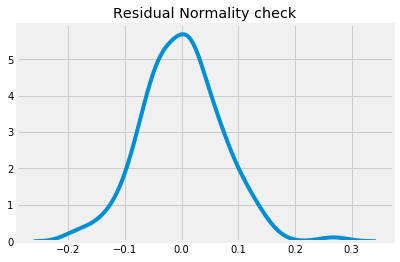

In [29]:
plt.title("Residual Normality check")
sns.kdeplot(resid);

In [30]:
test_df["resid"]=[get_resid(record) for _, record in test_df.iterrows() ]

/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
get_resid(test_df.iloc[0])

/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


-0.009050674893085975

In [32]:
resid_max = max(test_df["resid"])
test_df[test_df["resid"] == resid_max]

,dnf_rate,location,gender:ladies,event,date,finish_times,datetime,season,days_since_season_start,ski_field,...,region:FRA,region:GER,region:ITA,region:KOR,region:NEUTRAL,region:NOR,region:SE_ALPS,days^2_since_season_start,days^3_since_season_start,resid
27,0.444444,Kitzbuehel (AUT),False,Super Combined,27 January 2013,"[225.8, 227.06, 228.36, 231.32999999999998, 23...",2013-01-27,2013,92,Kitzbuehel (AUT),...,0,0,0,0,0,0,1,8464,778688,0.267517


In [33]:
max(test_df["dnf_rate"])

0.4444444444444444

In [34]:
print(len(X_test_scaled), len(X_train_scaled))

147 590


# Model explanation

In [35]:
best_lasso.coef_


array([-0.01339562,  0.02023781,  0.00502437, -0.0408625 ,  0.01905042,
        0.0482483 , -0.        , -0.01308225, -0.00308682, -0.00488821,
       -0.        ,  0.00341619, -0.00054624, -0.00399685,  0.00018575,
        0.        ,  0.00895093,  0.        , -0.03599209])

In [36]:
best_lasso.intercept_

0.14058928313892774

### Verifying `features` and `model.coef_` share on order

In [37]:
X_test_scaled[0].dot(best_lasso.coef_)+best_lasso.intercept_

0.15387826109998254

In [38]:
best_lasso.predict(X_test_scaled[0].reshape(1,-1))

array([0.15387826])

In [39]:
first_unscaled = test_df[features].iloc[0]
first = ssX.transform(first_unscaled.values.reshape(1,-1))
first.dot(best_lasso.coef_) + best_lasso.intercept_

/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([0.15387826])

### Explaining `model.coef_`

In [40]:
coefs = dict(zip(best_lasso.coef_, features))
coefs[0] = ""

In [41]:
prefix_null = re.compile(r"^.*:")

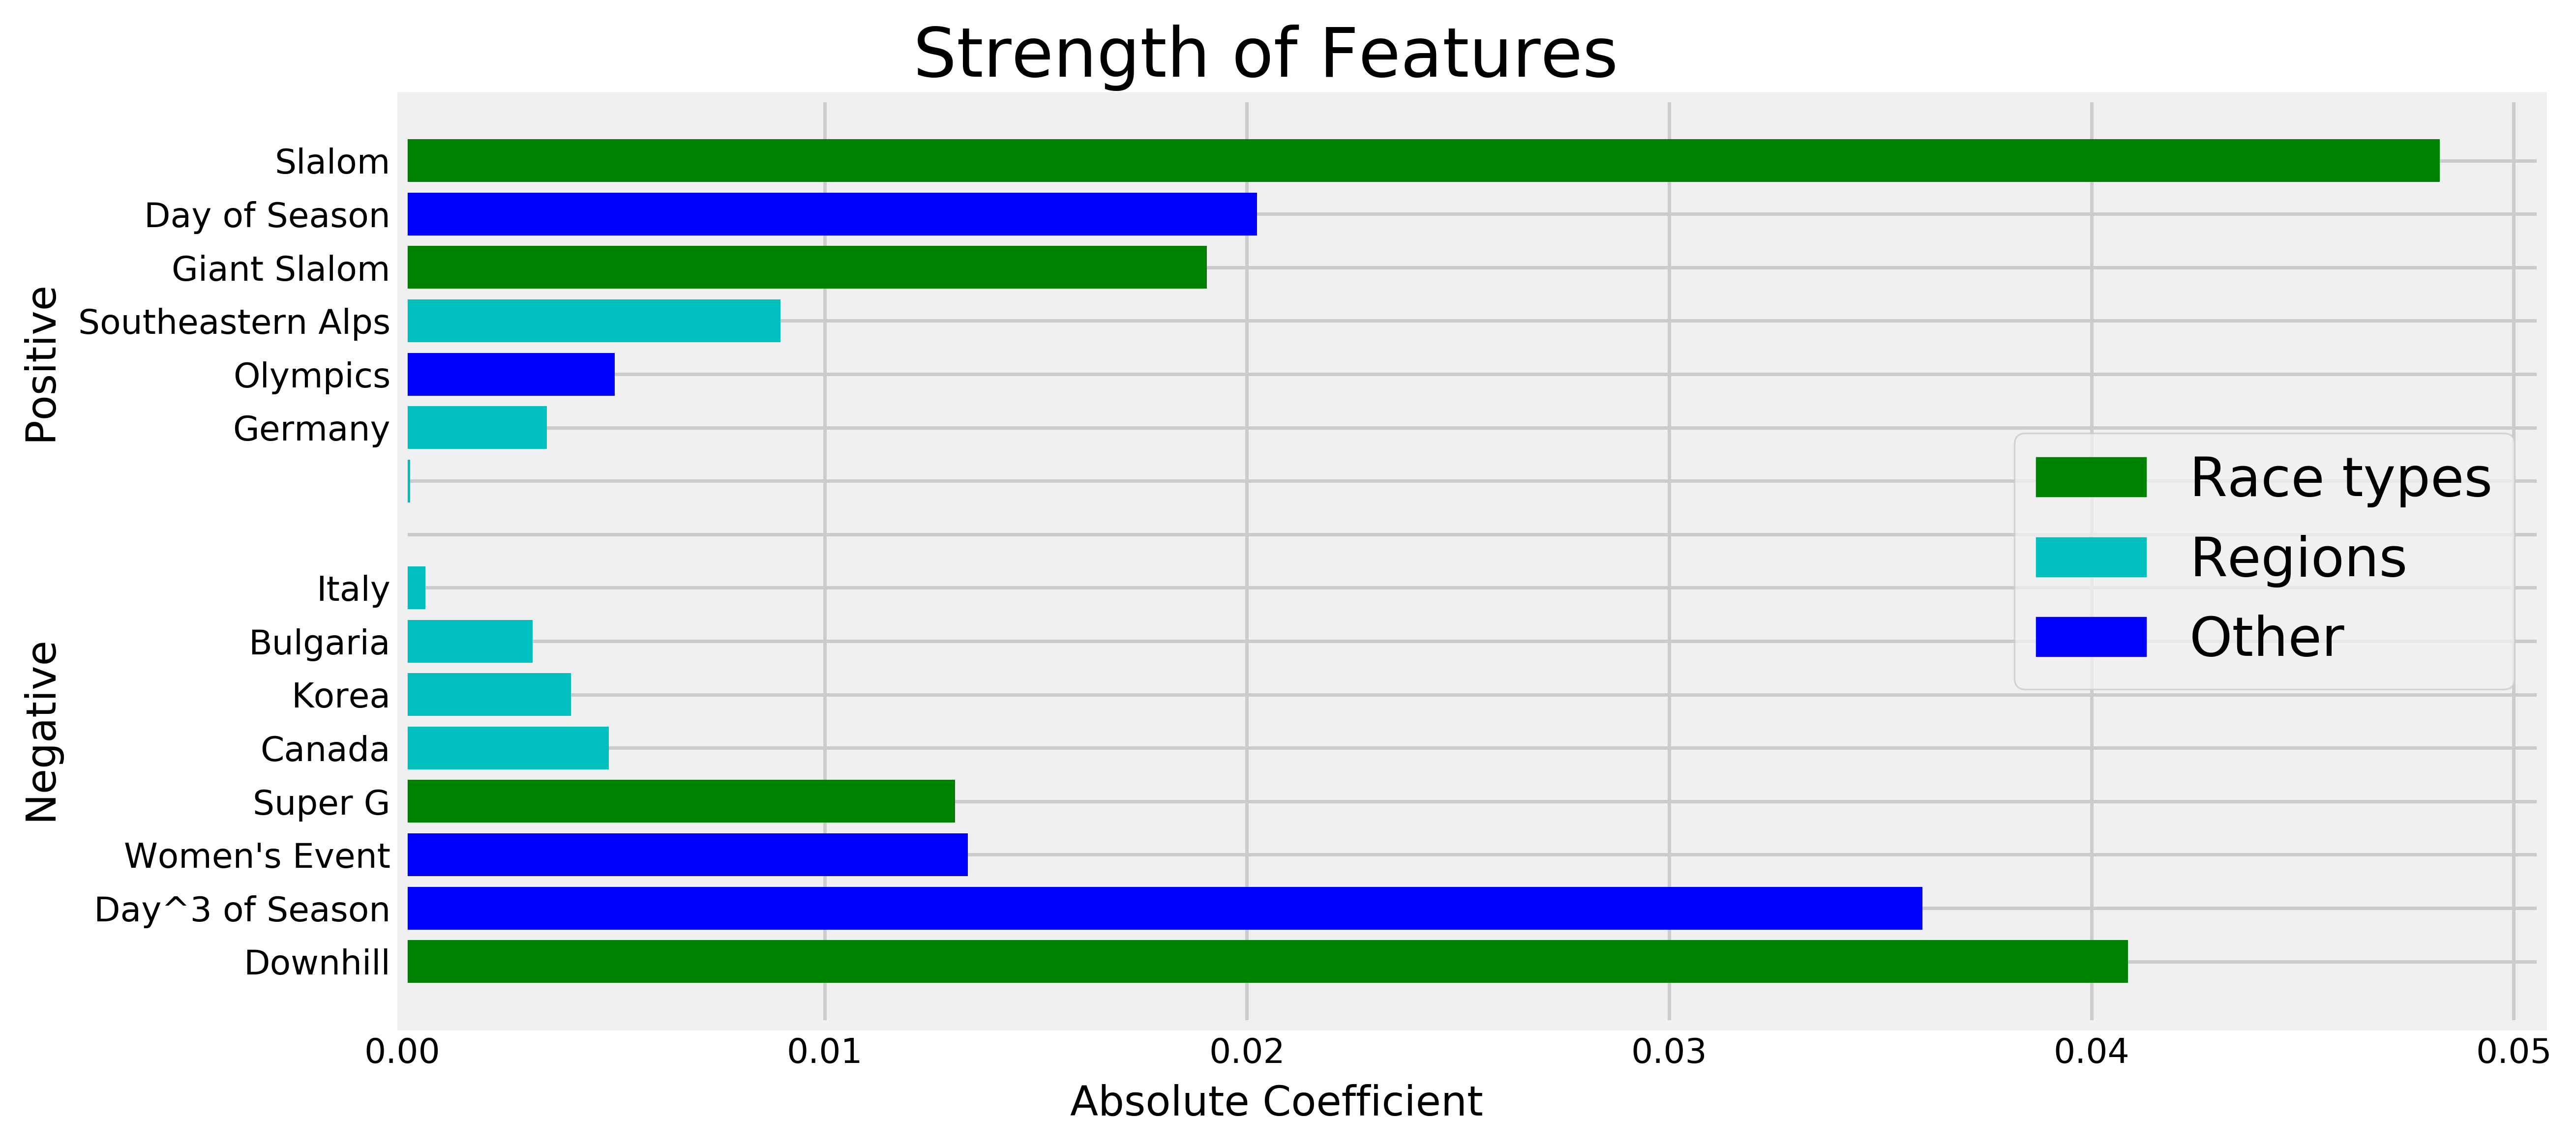

In [42]:
def get_color(feature):
    color = "b"
    if "event:" in feature:
        color = "g"
    elif "region" in feature:
        color = "c"
    return(color)
        
def readable(feature):
    feature = feature.replace("_", " ")
    feature = prefix_null.sub("",feature)
    feature = feature.replace("days","Day").replace("since season start","of Season")
    if feature in feature_dict:
        feature = feature_dict[feature]
    return(feature)

feature_dict = {
    "SE ALPS" : "Southeastern Alps",
    "GER" : "Germany",
    "NEUTRAL" : "",
    "ITA" : "Italy",
    "BUL" : "Bulgaria",
    "KOR" : "Korea",
    "CAN" : "Canada",
    "ladies": "Women's Event",
    "olympics": "Olympics"
}
    
i=0
ylabels=[]

plt.figure(dpi=500,figsize=(10,5))

for coef, feature in sorted(coefs.items()):
    plt.barh(i,np.abs(coef), color=get_color(feature))
    ylabels.append( readable( feature))
    i+=1
plt.yticks(range(len(ylabels)),ylabels);
plt.legend(handles=[
             mpatches.Patch(color="g", label="Race types"),
             mpatches.Patch(color="c", label="Regions"),
             mpatches.Patch(color="b", label="Other")
          ], loc="center right", prop={"size":16})
plt.ylabel(" Negative               Positive", rotation=90)
plt.xlabel("Absolute Coefficient                              ")
plt.title("Strength of Features                   ",size=20);